### Import Libraries

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
from src.utils import *
from src.filters import *
import pickle
import scipy as sio
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import os
from itertools import cycle, islice
import copy
import sys
sys.modules.values()


/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


dict_values([<module 'sys' (built-in)>, <module 'builtins' (built-in)>, <module 'importlib._bootstrap' (frozen)>, <module '_imp' (built-in)>, <module '_thread' (built-in)>, <module '_warnings' (built-in)>, <module '_weakref' (built-in)>, <module 'io' (built-in)>, <module 'marshal' (built-in)>, <module 'posix' (built-in)>, <module 'importlib._bootstrap_external' (frozen)>, <module 'time' (built-in)>, <module 'zipimport' (frozen)>, <module '_codecs' (built-in)>, <module 'codecs' from '/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/codecs.py'>, <module 'encodings.aliases' from '/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/encodings/aliases.py'>, <module 'encodings' from '/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/encodings/__init__.py'>, <module 'encodings.utf_8' from '/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/encodings/utf_8.py'>, <module '_signal' (built-in)>, <module 'encodings.latin_1' from '/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/encodings/latin_1.py'>, <module

In [2]:
np.show_config()

blas_info:
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/Users/sam/miniconda/envs/BMI_CCA/lib']
    include_dirs = ['/Users/sam/miniconda/envs/BMI_CCA/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/Users/sam/miniconda/envs/BMI_CCA/lib']
    include_dirs = ['/Users/sam/miniconda/envs/BMI_CCA/include']
    language = c
lapack_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas']
    library_dirs = ['/Users/sam/miniconda/envs/BMI_CCA/lib']
    language = f77
lapack_opt_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas', 'cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/Users/sam/miniconda/envs/BMI_CCA/lib']
    language = c
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/sam/miniconda/envs/BMI_CCA/include']
Supported SIMD exten

In [ ]:
from datetime import datetime

keys = list(data_dict.keys())  # get a list of all keys in the dictionary
sorted_keys = sorted(keys, key=lambda x: datetime.strptime(x.split('_')[1], '%y%m%d'))
print(sorted_keys)

### Helper functions

#### Misc

In [ ]:
start = 0.005
step = .1
list1 = np.arange(start, .2, step)
big_step = 0.05
list2 = np.arange(list1[-1]+ big_step, 1, big_step)
subsample_list = [*list1, *list2]
subsample_list = np.arange(.005, 1, .05)
print(subsample_list)

In [3]:
start = 0.005
step = .005
list1 = np.arange(start, .2, step)
big_step = 0.05
list2 = np.arange(list1[-1]+ big_step, 1, big_step)
subsample_list = [*list1, *list2]
# subsample_list = np.arange(0.005, 1, .05)
# print(len(subsample_list))
print(subsample_list)

[0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145, 0.15, 0.155, 0.16, 0.165, 0.17, 0.17500000000000002, 0.18, 0.185, 0.19, 0.195, 0.245, 0.295, 0.345, 0.39499999999999996, 0.44499999999999995, 0.49499999999999994, 0.5449999999999999, 0.595, 0.6449999999999999, 0.6949999999999998, 0.7449999999999999, 0.7949999999999999, 0.8449999999999999, 0.8949999999999998, 0.9449999999999998, 0.9949999999999999]


In [ ]:
start = 0.005
step = .005
list1 = np.arange(start, .1, step)
big_step = 0.05
list2 = np.arange(list1[-1]+ big_step, 1, big_step)
# subsample_list = [*list1, *list2]
subsample_list = [*list1]
# subsample_list = np.arange(0.005, 1, .05)
# print(len(subsample_list))
print(subsample_list)

#### Function to load all data from the folder

In [4]:
def load_data_from_folder(path, exporting_graph=False, raw_data=False):
    """
    Loads data from files in the specified folder path and returns a dictionary of data objects.

    Parameters:
    path (str): The path to the folder containing the data files.
    exporting_graph (bool, optional): Whether to export a graph. Defaults to False.
    raw_data (bool, optional): Whether to load raw data. Defaults to False.

    Returns:
    data_dict: contains all the cort_processor objects
    sorted_keys: list of keys for the above dict sorted by dates

    Examples:
    path = '/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/remove_channels_pickles/n9_removed_channels'
    data_dict, sorted_keys = load_data_from_folder(path=path)
    """
    filenames = os.listdir(path)

    temp_datasets = []
    temp_var_names = []
    data_dict = {}
    file_list = []
    plt.close("all")
    ignore_extensions = ('.pdf', '.DS_Store')
    for file in filenames:
        if file.endswith(ignore_extensions):
            continue  # ignore this file
        file_list.append(os.path.splitext(file)[0])

        current_path = path+'/'+file
        
        if raw_data:
            cp = CortProcessor(current_path) # Load mat file from Filippe data
        else:
            with open(current_path, 'rb') as inp:
                cp = pickle.load(inp)

        # Add data object to dict with respected name
        dict_name = '_'.join(os.path.splitext(file)[0].split('_')[:2])
        data_dict[dict_name] = cp


        if exporting_graph:
            h, vaffy, test_x, test_y = cp.decode_angles()
            predic = test_wiener_filter(test_x, h)
            samples = test_x.shape[0]
            
            # Font data for exporting figure
            plt.rcParams['pdf.fonttype'] = 42
            plt.rcParams['ps.fonttype'] = 42

            ts = np.linspace(0, (samples*50)/1000, samples)

            fig, ax = plt.subplots()
            fig.set_size_inches(10, 2)
            ax.plot(ts, test_y[:,1], color='black')
            ax.plot(ts, predic[:,1], color='red')
            ax.set_xlim((10,15))
            ax.axis('off')
            print(vaf(predic[:,1], test_y[:,1]))

            current_pdf_file = current_path.replace(".mat", ".pdf")
        
    from datetime import datetime

    keys = list(data_dict.keys())  # get a list of all keys in the dictionary
    sorted_keys = sorted(keys, key=lambda x: datetime.strptime(x.split('_')[1], '%y%m%d'))
    print(sorted_keys)

    return data_dict, sorted_keys

#### Prints information about the keys and arrays in the input dictionary.

In [5]:
def describe_dict(input_dict):
    """
    Prints information about the keys and arrays in the input dictionary.

    Parameters:
    input_dict (dict): A dictionary containing keys and corresponding arrays.

    Returns:
    None
    """
    keys_list = list(input_dict.keys())
    # Print the list of keys
    print(f"List of keys {keys_list}")
    
    # Loop through each key in the dictionary
    for key in input_dict:
        if key != 'angle_names' and key != 'which_channels':
            # Loop through each array in the list value associated with the current key
            for array in input_dict[key]:
                # Get the shape (dimensions) of the current array
                array_size = len(array)
                array_shape = len(array[0])
                
                # Print the key, index of the current array within the list, and its dimensions
                print(f"Key '{key}' has length {array_size} with {array_shape} columns")


#### Split subsample list into subgroups for parallelization

In [6]:
def split_range_into_groups(list_of_numbers, num_groups, step=1):
    groups = {}
    groups_index ={}
    list_length = len(list_of_numbers)
    if num_groups > list_length:
        num_groups = list_length
        
    for i in np.arange(0, num_groups, 1):
        groups[i], groups_index[i] = [], []
        currentIndex = i+1
        startIndex = 1
        # Populate the current group
        while currentIndex <= len(list_of_numbers):
            groups[i].append(list_of_numbers[currentIndex-1])
            groups_index[i].append(currentIndex-1)
            currentIndex = i+1 + num_groups*startIndex
            startIndex+=1

        # # Sort the group backward if i is odd
        # if i % 2 == 1:
        #     groups[i] = groups[i][::-1]
        #     groups_index[i] = groups_index[i][::-1]
            
    return groups, groups_index

#### Single - Decoder comparisons
- getting PCA decoder scores
1) we subsample Day-N data, fit PCA transformation, and then transform it. 
2) We train new PCA decoder on only this low-D subsampled data
3) We transform entire Day-N data, and decode using this new PCA decoder. 

In [ ]:
def compare_decoders_single_perms(cp1, cp2,
                    subsample_list,
                    pca_dims=8,
                    split_ratio=0.8):
    """
    Compares the performance of different decoders on the given CortProcessor objects.

    Parameters:
    cp1 (CortProcessor): The first CortProcessor object.
    cp2 (CortProcessor): The second CortProcessor object.
    subsample_list (list): A list of subsample sizes to use for evaluation.
    pca_dims (int, optional): The number of dimensions to use for PCA. Defaults to 8.
    split_ratio (float, optional): The ratio to split the data into training and testing sets. Defaults to 0.8.

    Returns:
    scores_dict: a dictionary contained the result of the following decoders
        
           cca_decoder_scores (list): The scores of CCA decoder for each subsample size.
           pca_decoder_scores (list): The scores of PCA decoder for each subsample size.
           fixed_decoder_scores (list): The scores of fixed decoder for each subsample size.

    Examples:
    scores_dict = compare_decoders(cp1, cp2,
                                    subsample_list,
                                    pca_dims=10,
                                    split_ratio=0.8)
    """
    # Train-Test split
    nummy = cp2.data['rates'][0].shape[0]
    percent_data = int(split_ratio * nummy)

    cp2_test = copy.deepcopy(cp2)

    cp2.data['rates'] = [cp2.data['rates'][0][:percent_data, :]]
    cp2.data['angles'] = [cp2.data['angles'][0][:percent_data, :]]

    cp2_test.data['rates']= [cp2_test.data['rates'][0][percent_data:, :]]
    cp2_test.data['angles']= [cp2_test.data['angles'][0][percent_data:, :]]

    describe_dict(cp1.data)
    print()
    describe_dict(cp2.data)
    print()
    describe_dict(cp2_test.data)

    #get day0 decoder weights, scaled + unscaled versions
    day0_decoder, _, _, _ = cp1.decode_angles(X=cp1.apply_PCA(dims=pca_dims))
    day0_transformer = cp1.pca_object

    day0_decoder_no_offset = day0_decoder[1:,:]
    offset = day0_decoder[0,:]

    # get scaled day-0 decoder
    X_tempy = cp1.apply_PCA(pca_dims)
    scaler = StandardScaler()
    X_scale = scaler.fit_transform(np.squeeze(X_tempy))
    day0_decoder_scale, _, _, _ = cp1.decode_angles(X=[X_scale])

    # scores keeper
    fixed_decoder_scores, pca_decoder_scores, cca_decoder_scores, pinv_scores, r_scores = [], [], [], [], []

    # transformer keeper
    pca_predic, number_of_gaits, cca_transformers, r_predic, pinv_predic_all = [], [], [], [], []

    # prepare test y data
    test_y = np.squeeze(np.array(cp2_test.data['angles']))

    for i in range(len(subsample_list)):
        ### testing decoder
        ## day-0 fixed decoder
        test_x_fixed = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=day0_transformer)))
        test_x_fixed_format, test_y_format = format_data(test_x_fixed, test_y)

        temp_y = test_wiener_filter(test_x_fixed_format, day0_decoder)
        fixed_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))

        sub_x, sub_y = cp2.subsample(percent=subsample_list[i])

        gait_counter = sub_y
        temp_gaits, _ = cp2.get_gait_indices(Y=sub_y)
        number_of_gaits.append(temp_gaits[0].size - 1)
        
        
        ## PCA decoder
        # apply PCA just using subsampled data on the rates (x) data
        sub_x_pca = cp2.apply_PCA(dims=pca_dims, X=sub_x) # don't np.squeeze this line
        
        # save PCA transformation
        pca_object = cp2.pca_object
    
        # train PCA decoder 
        temp_h, _, _, _ = cp2.decode_angles(X=sub_x_pca, Y=sub_y)

        # test PCA decorder
        test_x_pca = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=pca_object)))
        test_x_pca_format, test_y_format = format_data(test_x_pca, test_y)

        temp_y = test_wiener_filter(test_x_pca_format, temp_h)
        pca_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
        pca_predic.append(temp_y)

        ## CCA decoder
        # Prepare the CCA object by
        #  aligning Day-N subsampled data to Day-0 data by fitting PCA 
        # temp_cca = CCAProcessor(cp1, cp2)
        
        temp_cp2 = copy.deepcopy(cp2)
        sub_x2, sub_y2 = temp_cp2.subsample(percent = subsample_list[i])
        
        temp_cp2.data['rates'] = sub_x2
        temp_cp2.data['angles'] = sub_y2
        
        temp_cca = CCAProcessor(cp1, temp_cp2)

        # fit Day-0 PCA transformation on subsampled Day-n data, and then transform it
        pca_sub_x1, pca_sub_x2 = temp_cca.apply_PCA(preset_num_components=pca_dims, day_0_transformer=day0_transformer)

        # fit a CCA transformation on subsampled, low-D day-N data
        temp_cca_transformer, _ = temp_cca.apply_CCA(preset_num_components=pca_dims, pca=True)
        
        # add cca transformer for record
        cca_transformers.append(temp_cca_transformer)
        
        # test CCA
        #  apply our PCA transformation to entire Day-N, 
        #  and then apply our CCA transformation to entire low-D day-N data
        test_x = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=temp_cca.data['cp2']['pca_transformer'])))   
        test_y = np.squeeze(np.array(cp2_test.data['angles']))
        
        # temp_x_cca_space [=] subsampled, low-d, CCA-transformed day-n data rates
        _, test_x_cca_space = temp_cca_transformer.transform(test_x, test_x)
        
        # then transform back to the original space
        temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)
        temp_x_format, test_y_format = format_data(temp_x, test_y)

        temp_y = test_wiener_filter(temp_x_format, day0_decoder)
        cca_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))

        ## Regression fit
        # sub_x_pca [=] subsampled rates data in PCA space
        
        # apply PCA to subsampled data
        sub_x_pca_squeezed = np.squeeze(sub_x_pca)
        # transform PCA subsample to day-0 shape
        _, sub_x_cca_space = temp_cca_transformer.transform(sub_x_pca_squeezed, sub_x_pca_squeezed)
        
        # then transform back to the original space
        temp_x = temp_cca_transformer.inverse_transform(sub_x_cca_space)

        # scale transformed data 
        scaler = StandardScaler()
        temp_x_scale = scaler.fit_transform(temp_x)
        
        temp_x_format, temp_y_format = format_data(temp_x_scale, sub_y[0])
        
        # regression fit the scaled data
        wpost, _ = ridge_fit(b0=day0_decoder_scale, x_format=temp_x_format, y_format=temp_y_format, my_alpha=100.0)

        # pinv fit
        pinv_clf, _ = temp_cca.apply_pinv_transform(x=sub_x[0], y=sub_y[0], decoder=day0_decoder) 
        
        # test
        raw_test_x = cp2_test.data['rates'][0]
        raw_test_y = cp2_test.data['angles'][0]
        raw_test_x_format, raw_test_y_format = format_data(raw_test_x, raw_test_y)
        trans_test_x = pinv_clf.predict(raw_test_x_format)
        pinv_predict = np.dot(trans_test_x, day0_decoder_no_offset) + offset
        
        pinv_predic_all.append(pinv_predict)
        
        # preloaded decoder
        _, test_x2tox1 = temp_cca.apply_CCA(cp2_x=test_x, transformer=temp_cca_transformer)
        test_x2tox1_scale = scaler.transform(test_x2tox1)
        test_x2tox1_scale_format, _ = format_data(test_x2tox1_scale, test_y)
        temp_y = test_wiener_filter(test_x2tox1_scale_format, wpost)

        r_predic.append(temp_y)  
        r_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
        pinv_scores.append(vaf(test_y_format[:,1], pinv_predict[:,1]))

    scores_dict = {}
    scores_dict['fixed_decoder_scores'] = fixed_decoder_scores
    scores_dict['pca_decoder_scores'] = pca_decoder_scores
    scores_dict['cca_decoder_scores'] = cca_decoder_scores
    scores_dict['r_scores'] = r_scores
    scores_dict['pinv_scores'] = pinv_scores
    scores_dict['number_of_gaits'] = number_of_gaits

    return scores_dict


#### Single - Plots the VAF (Variance Accounted For) comparison for different decoders.

In [ ]:
def plot_vaf_comparison_single(number_of_gaits,
                        title_str,
                        path,
                        max_gait=65,
                        fixed_decoder_scores=None,
                        pca_decoder_scores=None,
                        cca_decoder_scores=None,
                        r_scores=None,
                        pinv_scores=None):
    """
    Plots the VAF (Variance Accounted For) comparison for different decoders.

    Parameters:
    number_of_gaits (int): The number of gaits to plot.
    title_str (str): The title string for the plot.
    path (str): The path to save the plot.
    max_gait (int, optional): The maximum gait number to include. Defaults to 65.
    fixed_decoder_scores (list, optional): The scores of the fixed decoder. Defaults to None.
    pca_decoder_scores (list, optional): The scores of the PCA decoder. Defaults to None.
    cca_decoder_scores (list, optional): The scores of the CCA decoder. Defaults to None.
    r_scores (list, optional): The scores of the R decoder. Defaults to None.
    pinv_scores (list, optional): The scores of the pinv decoder. Defaults to None.

    Returns:
    None
    """

    plt.close("all")
    # Font data for exporting figure
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

    fig = plt.figure()
    fig.set_size_inches(10, 5)
    ax1 = fig.add_subplot(111)
    x = subsample_list
    ax1.set_ylim(bottom=-1, top=1)

    if fixed_decoder_scores is not None:
        ax1.plot(number_of_gaits, fixed_decoder_scores, '--', color='tab:pink', label='fixed_decoder')
    if cca_decoder_scores is not None:
        ax1.plot(number_of_gaits, cca_decoder_scores, marker='s', color='tab:green', label='cca aligned')
    if r_scores is not None:
        ax1.plot(number_of_gaits, r_scores, marker='*', color='tab:orange', label='preloaded decoder')
    if pinv_scores is not None:
        ax1.plot(number_of_gaits, pinv_scores, marker='+', color='tab:purple', label='pinv decoder')
    if pca_decoder_scores is not None:
        peak = np.full(len(number_of_gaits), max(pca_decoder_scores))
        ax1.plot(number_of_gaits, pca_decoder_scores, marker='o', color='tab:blue', label='pca decoder')
        ax1.plot(number_of_gaits, peak, '--', color='tab:blue', label='max pca decoder')

    ax1.legend(loc='lower right')

    if max_gait > max(number_of_gaits):
        max_gait = max(number_of_gaits)
        
    ax1.set_xlim(0, max_gait)
    ax1.set_xlabel('Number of Gait Cycles Trained On')
    ax1.set_ylabel('VAF')
    plt.title(title_str)
    plt.show()

    pdf_file_path = os.path.join(path, title_str + '.pdf')
    plt.savefig(pdf_file_path)

#### Multiple - Decoder comparisons - Compartmentalize

In [7]:
import copy
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

import numpy as np
import copy
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

# Function to split the data into train and test sets
def split_data(cp2_original, split_ratio):
    cp2 = copy.deepcopy(cp2_original)
    nummy = cp2.data['rates'][0].shape[0]
    percent_data = int(split_ratio * nummy)

    cp2_test = copy.deepcopy(cp2)

    cp2.data['rates'] = [cp2.data['rates'][0][:percent_data, :]]
    cp2.data['angles'] = [cp2.data['angles'][0][:percent_data, :]]

    cp2_test.data['rates'] = [cp2_test.data['rates'][0][percent_data:, :]]
    cp2_test.data['angles'] = [cp2_test.data['angles'][0][percent_data:, :]]

    return cp2, cp2_test, percent_data

# Function to obtain the day0 decoder weights
def get_day0_decoder(cp1, pca_dims):
    X_tempy = cp1.apply_PCA(dims=pca_dims)
    scaler = StandardScaler()
    X_scale = scaler.fit_transform(np.squeeze(X_tempy))
    day0_decoder_scale, _, _, _ = cp1.decode_angles(X=[X_scale])

    day0_decoder, _, _, _ = cp1.decode_angles(X=cp1.apply_PCA(dims=pca_dims))
    day0_transformer = cp1.pca_object
    day0_decoder_no_offset = day0_decoder[1:, :]
    offset = day0_decoder[0, :]

    return day0_decoder, day0_transformer, day0_decoder_no_offset, offset, day0_decoder_scale

def get_pca_decoder_score(cp2_raw, cp2_test_raw, pca_dims, sub_x, sub_y, test_y):
    try:
        # apply PCA just using subsampled data on the rates (x) data
        cp2_test = copy.deepcopy(cp2_test_raw)
        cp2 = copy.deepcopy(cp2_raw)

        sub_x_pca = cp2.apply_PCA(dims=pca_dims, X=sub_x) # don't np.squeeze this line

        # save PCA transformation
        pca_object = cp2.pca_object

        # train PCA decoder 
        temp_h, _, _, _ = cp2.decode_angles(X=sub_x_pca, Y=sub_y)

        # test PCA decoder
        test_x_pca = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=pca_object)))
        test_x_pca_format, test_y_format = format_data(test_x_pca, test_y)

        temp_y = test_wiener_filter(test_x_pca_format, temp_h)

        vaf_score = vaf(test_y_format[:, 1], temp_y[:, 1])
        return vaf_score, None
    except Exception as e:
        print(f"Traceback: \n {traceback.format_exc()}")
        return None, e

def get_cca_decoder_score(cp1_raw, cp2_raw, cp2_test_raw, day0_decoder, day0_transformer, pca_dims, sub_x, sub_y):
    try:
        # Prepare the CCA object by aligning Day-N subsampled data to Day-0 data by fitting PCA 
        # make subsampled cp2
        cp2_test = copy.deepcopy(cp2_test_raw)

        temp_cp2 = copy.deepcopy(cp2_raw)
        temp_cp2.data['rates'] = sub_x
        temp_cp2.data['angles'] = sub_y

        temp_cca = CCAProcessor(cp1_raw, temp_cp2)
        # check pca_dims validity. Slicing the data too small -> not enough data for features
        check_pca_dims = min(len(temp_cca.data['cp2']['proc_x']), len(temp_cca.data['cp1']['proc_x']), pca_dims)
        if check_pca_dims >= pca_dims:
            # fit Day-0 PCA transformation on subsampled Day-n data, and then transform it
            pca_sub_x1, pca_sub_x2 = temp_cca.apply_PCA(preset_num_components=pca_dims, day_0_transformer=day0_transformer)
            
        # fit a CCA transformation on subsampled, low-D day-N data
        temp_cca_transformer, _ = temp_cca.apply_CCA(preset_num_components=pca_dims, pca=True)

    except Exception as e:
        temp_cca_transformer = None
        print(f"Traceback: \n {traceback.format_exc()}")

    try:
        # test CCA
        # apply our PCA transformation to entire Day-N, 
        # and then apply our CCA transformation to entire low-D day-N data
        test_x_squeeze = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=temp_cca.data['cp2']['pca_transformer'])))   
        test_y_squeeze = np.squeeze(np.array(cp2_test.data['angles']))

        # temp_x_cca_space [=] subsampled, low-d, CCA-transformed day-n data rates
        _, test_x_cca_space = temp_cca_transformer.transform(test_x_squeeze, test_x_squeeze)

        # then transform back to the original space
        temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)
        temp_x_format, test_y_format = format_data(temp_x, test_y_squeeze)

        if check_pca_dims >= pca_dims:
            temp_y = test_wiener_filter(temp_x_format, day0_decoder)
        vaf_score = vaf(test_y_format[:, 1], temp_y[:, 1])
        return vaf_score, None, temp_cca, temp_cca_transformer
    except Exception as e:
        print(f"Traceback: \n {traceback.format_exc()}")
        return None, e, temp_cca, temp_cca_transformer

def get_regression_fit_score(cp2_raw, cp2_test_raw, temp_cca, temp_cca_transformer, day0_decoder_scale, pca_dims, sub_x, sub_y):
    try:
        # sub_x_pca [=] subsampled rates data in PCA space
        # apply PCA to subsampled data
        cp2_test = copy.deepcopy(cp2_test_raw)
        cp2 = copy.deepcopy(cp2_raw)
        sub_x_pca = cp2.apply_PCA(dims=pca_dims, X=sub_x) # don't np.squeeze this line
        sub_x_pca_squeezed = np.squeeze(sub_x_pca)
        # transform PCA subsample to day-0 shape
        _, sub_x_cca_space = temp_cca_transformer.transform(sub_x_pca_squeezed, sub_x_pca_squeezed)

        # then transform back to the original space
        temp_x = temp_cca_transformer.inverse_transform(sub_x_cca_space)

        # scale transformed data 
        scaler = StandardScaler()
        temp_x_scale = scaler.fit_transform(temp_x)
        # temp_x_scale = scaler.transform(temp_x)
        temp_x_format, temp_y_format = format_data(temp_x_scale, sub_y[0])

        # regression fit the scaled data
        wpost, _ = ridge_fit(b0=day0_decoder_scale, x_format=temp_x_format, y_format=temp_y_format, my_alpha=100.0)
        
        # preloaded decoder
        test_x_squeeze = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=cp2.pca_object)))   
        test_y_squeeze = np.squeeze(np.array(cp2_test.data['angles']))
        _, test_x2tox1 = temp_cca.apply_CCA(cp2_x=test_x_squeeze, transformer=temp_cca_transformer)
        test_x2tox1_scale = scaler.transform(test_x2tox1)
        test_x2tox1_scale_format, test_y_format = format_data(test_x2tox1_scale, test_y_squeeze)
        temp_y = test_wiener_filter(test_x2tox1_scale_format, wpost)
        vaf_score = vaf(test_y_format[:, 1], temp_y[:, 1])
        return vaf_score, None
    except Exception as e:
        print(f"Traceback: \n {traceback.format_exc()}")
        return None, e


# Function to obtain number of gait in the subsampled data
def get_gait_count(cp2, sub_y):
    temp_gaits, _ = cp2.get_gait_indices(Y=sub_y)
    num_gaits = temp_gaits[0].size - 1
    return num_gaits

# def process_subsample_data(cp1, cp2_raw, cp2_test_raw, test_y, pca_dims, day0_transformer, day0_decoder, day0_decoder_no_offset, day0_decoder_scale, temp_cca, offset, scaler, index_group, subsample_subgroups, subsample_subgroups_index, percent_data, subsample_list, step, pca_decoder_scores, cca_decoder_scores, pinv_scores, r_scores, number_of_gaits):
def process_subsample_data(cp1_original, cp2_original, pca_dims, split_ratio, index_group, subsample_subgroups, subsample_subgroups_index, subsample_list, step):

    cp1 = copy.deepcopy(cp1_original)
    cp2 = copy.deepcopy(cp2_original)
    # Train-Test split
    cp2, cp2_test, percent_data = split_data(cp2_original=cp2_original, split_ratio=split_ratio)

    # prepare copy of data
    cp2_test_raw = copy.deepcopy(cp2_test)
    cp2_raw = copy.deepcopy(cp2)

    describe_dict(cp1.data)
    print()
    describe_dict(cp2.data)
    print()
    describe_dict(cp2_test.data)

    #get day0 decoder weights, scaled + unscaled versions
    day0_decoder, day0_transformer, \
    day0_decoder_no_offset, offset, day0_decoder_scale = get_day0_decoder(cp1=cp1, pca_dims=pca_dims)

    temp_cca = CCAProcessor(cp1, cp2)
    # scores keeper
    
    # transformer keeper
    # pca_predic, number_of_gaits, cca_transformers, r_predic, pinv_predic_all = {}, {}, {}, {}, {}

    # prepare test y data
    test_y = np.squeeze(np.array(cp2_test.data['angles']))
    pca_decoder_scores, cca_decoder_scores, pinv_scores, r_scores, number_of_gaits, fixed_decoder_scores = {}, {}, {}, {}, {}, {}
    subsample_list = subsample_subgroups[index_group]
    subsample_list_index = subsample_subgroups_index[index_group]

    for i in range(len(subsample_list)):
        cp2 = copy.deepcopy(cp2_raw)
        cp2_test = copy.deepcopy(cp2_test_raw)

        sub_idx = subsample_list_index[i]
        print(f"current idx is {sub_idx}")
        # slicing prepare
        slice_sample = int(subsample_list[i]*percent_data)    
        step_sample = int(step * percent_data)
        
        # preallocate score keepers
        pca_decoder_scores[sub_idx], cca_decoder_scores[sub_idx], pinv_scores[sub_idx], r_scores[sub_idx], number_of_gaits[sub_idx], fixed_decoder_scores[sub_idx] = [], [], [], [], [], []

        ### testing decoder
        ## day-0 fixed decoder
        try:
            test_x_fixed = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=day0_transformer)))
            test_x_fixed_format, test_y_format = format_data(test_x_fixed, test_y)

            temp_y = test_wiener_filter(test_x_fixed_format, day0_decoder)
            fixed_decoder_scores[sub_idx].append(vaf(test_y_format[:,1], temp_y[:,1]))
            print(f" Succeeded fixed decoder - slice #: {slice_sample}, step #: {step_sample}")
        except Exception as e:
            print(f" Failed fixed decoder - {e} - slice #: {slice_sample}, step #: {step_sample}\n")
            print(f"Traceback: \n {traceback.format_exc()}")

        max_idx = len(np.arange(0, percent_data-step_sample, step_sample))
        for idx, k in enumerate(np.arange(0, percent_data-step_sample, step_sample)):
            cp2 = copy.deepcopy(cp2_raw)
            end_slice = int(k+slice_sample)
            print(f" Current subsample#: {subsample_list[i]}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx},  slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}")
            if (k+slice_sample > percent_data):
                break
            sub_x = [cp2.data['rates'][0][int(k):end_slice, :]]
            sub_y = [cp2.data['angles'][0][int(k):end_slice, :]]
            
            # Process sub_x and sub_y
            num_gaits = get_gait_count(cp2=cp2, sub_y=sub_y)
            number_of_gaits[sub_idx].append(num_gaits)
            
            # Get PCA decoder score
            vaf_score, error_message = get_pca_decoder_score(cp2_raw=cp2_raw, cp2_test_raw=cp2_test_raw, pca_dims=pca_dims, sub_x=sub_x, sub_y=sub_y, test_y=test_y)
            
            if vaf_score is not None:
                pca_decoder_scores[sub_idx].append(vaf_score)
                print(f" Succeeded pca decoder - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}")
            else:
                print(f" Failed pca decoder - {error_message} - gaits #: {num_gaits}, {(i+1)/len(subsample_list)}, group #: {index_group}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}\n")

            # Get CCA decoder score
            try:
                vaf_score, error_message, temp_cca, temp_cca_transformer = get_cca_decoder_score(cp1_raw=cp1, cp2_raw=cp2_raw, cp2_test_raw=cp2_test_raw, day0_decoder=day0_decoder, day0_transformer=day0_transformer, pca_dims=pca_dims, sub_x=sub_x, sub_y=sub_y)
                if vaf_score is not None:
                    cca_decoder_scores[sub_idx].append(vaf_score)
                    print(f" Succeeded cca decoder - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}")
                else:
                    print(f" Failed cca decoder - {error_message} - gaits #: {num_gaits}, {(i+1)/len(subsample_list)}, group #: {index_group}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}\n")
            except Exception as e:
                print(f" Failed cca decoder - {e} - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}\n")
                print(f"Traceback: \n {traceback.format_exc()}")
            
            ## Regression fit
            try:
                vaf_score, error_message = get_regression_fit_score(cp2_raw=cp2_raw, cp2_test_raw=cp2_test_raw, temp_cca=temp_cca, temp_cca_transformer=temp_cca_transformer, day0_decoder_scale=day0_decoder_scale, pca_dims=pca_dims, sub_x=sub_x, sub_y=sub_y)
                if vaf_score is not None:
                    r_scores[sub_idx].append(vaf_score)
                else:
                    print(f" Failed regression fit - {error_message} - gaits #: {num_gaits}, {(i+1)/len(subsample_list)}, group #: {index_group}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}\n")
            except Exception as e:
                print(f" Failed regression fit - {e} - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}\n")
                print(f"Traceback: \n {traceback.format_exc()}")

            ## Pinv fit
            try:
                cp2_test = copy.deepcopy(cp2_test_raw)
                pinv_clf, _ = temp_cca.apply_pinv_transform(x=sub_x[0], y=sub_y[0], decoder=day0_decoder) 

                ## test
                raw_test_x = cp2_test.data['rates'][0]
                raw_test_y = cp2_test.data['angles'][0]
                raw_test_x_format, raw_test_y_format = format_data(raw_test_x, raw_test_y)
                trans_test_x = pinv_clf.predict(raw_test_x_format)
                pinv_predict = np.dot(trans_test_x, day0_decoder_no_offset) + offset

                pinv_predic_all = pinv_predict
                pinv_scores[sub_idx].append(vaf(test_y_format[:, 1], pinv_predict[:, 1]))
                print(f" Succeeded pinv fit - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}\n")
            except Exception as e:
                print(f" Failed pinv fit - {e} - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}\n")
                print(f"Traceback: \n {traceback.format_exc()}")

    scores_dict = {}
    scores_dict['fixed_decoder_scores'] = fixed_decoder_scores
    scores_dict['pca_decoder_scores'] = pca_decoder_scores
    scores_dict['cca_decoder_scores'] = cca_decoder_scores
    scores_dict['r_scores'] = r_scores
    scores_dict['pinv_scores'] = pinv_scores
    scores_dict['number_of_gaits'] = number_of_gaits

    return scores_dict
 
def compare_decoders_all_perms(cp1, cp2,
                    subsample_list,
                    multiThread=False,
                    multiProcess=False,
                    num_processes=6,
                    step=0.005,
                    pca_dims=8,
                    split_ratio=0.8):
    """
    Compares the performance of different decoders on the given CortProcessor objects.

    Parameters:
    cp1 (CortProcessor): The first CortProcessor object.
    cp2 (CortProcessor): The second CortProcessor object.
    subsample_list (list): A list of subsample sizes to use for evaluation.
    pca_dims (int, optional): The number of dimensions to use for PCA. Defaults to 8.
    split_ratio (float, optional): The ratio to split the data into training and testing sets. Defaults to 0.8.

    Returns:
    scores_dict: a dictionary contained the result of the following decoders
        
           cca_decoder_scores (list): The scores of CCA decoder for each subsample size.
           pca_decoder_scores (list): The scores of PCA decoder for each subsample size.
           fixed_decoder_scores (list): The scores of fixed decoder for each subsample size.

    Examples:
    scores_dict = compare_decoders(cp1, cp2,
                                    subsample_list,
                                    pca_dims=10,
                                    split_ratio=0.8)
    """
    # Train-Test split
    cp2_raw = copy.deepcopy(cp2)
    cp1_raw = copy.deepcopy(cp1)
    
    pca_decoder_scores, cca_decoder_scores, pinv_scores, r_scores, number_of_gaits, fixed_decoder_scores = {}, {}, {}, {}, {}, {}

    subsample_subgroups, subsample_subgroups_index = split_range_into_groups(subsample_list, num_processes)
    if multiThread is True:
        results = []
        # Create a ThreadPoolExecutor with the desired number of processes
        executor = ThreadPoolExecutor()    
        # Submit tasks to the executor
        futures = [executor.submit(process_subsample_data, cp1_raw, cp2_raw, pca_dims, split_ratio, index_group, subsample_subgroups, subsample_subgroups_index, subsample_list, step)
                    for index_group in range(num_processes)]
        # Wait for all tasks to complete and retrieve the results
        for future in as_completed(futures):
            results.append(future.result())

    elif multiProcess is True:
        # Create a ProcessPoolExecutor with the desired number of processes
        executor = ProcessPoolExecutor(max_workers=num_processes)    
        # Submit tasks to the executor
        futures = [executor.submit(process_subsample_data, cp1_raw, cp2_raw, pca_dims, split_ratio, index_group, subsample_subgroups, subsample_subgroups_index, subsample_list, step)
                    for index_group in range(num_processes)]
        
        # Wait for all tasks to complete and retrieve the results
        results = [future.result() for future in futures]
    else:
        results = []
        for index_group in range(num_processes):
            result = process_subsample_data(cp1_raw, cp2_raw, pca_dims, split_ratio, index_group, subsample_subgroups, subsample_subgroups_index, subsample_list, step)
            results.append(result)

    for result in results:
        if result is not None:
                score_dict = result
                pca_decoder_scores = {**pca_decoder_scores, **score_dict['pca_decoder_scores']}
                cca_decoder_scores = {**cca_decoder_scores, **score_dict['cca_decoder_scores']}
                fixed_decoder_scores = {**fixed_decoder_scores, **score_dict['fixed_decoder_scores']}
                r_scores = {**r_scores, **score_dict['r_scores']}
                pinv_scores = {**pinv_scores, **score_dict['pinv_scores']}
                number_of_gaits = {**number_of_gaits, **score_dict['number_of_gaits']}

    # # Create a dictionary to store the scores
    scores_dict = {
        'cca_decoder_scores': cca_decoder_scores,
        'pca_decoder_scores': pca_decoder_scores,
        'fixed_decoder_scores': fixed_decoder_scores,
        'r_scores': r_scores,
        'pinv_scores': pinv_scores,
        'number_of_gaits': number_of_gaits
    }

    return scores_dict


#### Multiple - Decoder comparisons - Parallize test

In [ ]:
import copy
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

import numpy as np
import copy
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

# def process_subsample_data(cp1, cp2_raw, cp2_test_raw, test_y, pca_dims, day0_transformer, day0_decoder, day0_decoder_no_offset, day0_decoder_scale, temp_cca, offset, scaler, index_group, subsample_subgroups, subsample_subgroups_index, percent_data, subsample_list, step, pca_decoder_scores, cca_decoder_scores, pinv_scores, r_scores, number_of_gaits):
def process_subsample_data(cp1_original, cp2_original, pca_dims, split_ratio, index_group, subsample_subgroups, subsample_subgroups_index, subsample_list, step):

    cp1 = copy.deepcopy(cp1_original)
    cp2 = copy.deepcopy(cp2_original)
    # Train-Test split
    nummy = cp2.data['rates'][0].shape[0]
    percent_data = int(split_ratio * nummy)

    cp2_test = copy.deepcopy(cp2)

    cp2.data['rates'] = [cp2.data['rates'][0][:percent_data, :]]
    cp2.data['angles'] = [cp2.data['angles'][0][:percent_data, :]]

    cp2_test.data['rates']= [cp2_test.data['rates'][0][percent_data:, :]]
    cp2_test.data['angles']= [cp2_test.data['angles'][0][percent_data:, :]]

    # prepare copy of data
    cp2_test_raw = copy.deepcopy(cp2_test)
    cp2_raw = copy.deepcopy(cp2)

    describe_dict(cp1.data)
    print()
    describe_dict(cp2.data)
    print()
    describe_dict(cp2_test.data)

    #get day0 decoder weights, scaled + unscaled versions
    day0_decoder, _, _, _ = cp1.decode_angles(X=cp1.apply_PCA(dims=pca_dims))
    day0_transformer = cp1.pca_object

    day0_decoder_no_offset = day0_decoder[1:,:]
    offset = day0_decoder[0,:]

    # get scaled day-0 decoder
    X_tempy = cp1.apply_PCA(pca_dims)
    scaler = StandardScaler()
    X_scale = scaler.fit_transform(np.squeeze(X_tempy))
    day0_decoder_scale, _, _, _ = cp1.decode_angles(X=[X_scale])

    temp_cca = CCAProcessor(cp1, cp2)
    # scores keeper
    
    # transformer keeper
    # pca_predic, number_of_gaits, cca_transformers, r_predic, pinv_predic_all = {}, {}, {}, {}, {}

    # prepare test y data
    test_y = np.squeeze(np.array(cp2_test.data['angles']))
    pca_decoder_scores, cca_decoder_scores, pinv_scores, r_scores, number_of_gaits, fixed_decoder_scores = {}, {}, {}, {}, {}, {}
    subsample_list = subsample_subgroups[index_group]
    subsample_list_index = subsample_subgroups_index[index_group]

    for i in range(len(subsample_list)):
        cp2 = copy.deepcopy(cp2_raw)
        cp2_test = copy.deepcopy(cp2_test_raw)

        sub_idx = subsample_list_index[i]
        print(f"current idx is {sub_idx}")
        # slicing prepare
        slice_sample = int(subsample_list[i]*percent_data)    
        step_sample = int(step * percent_data)
        
        # preallocate score keepers
        pca_decoder_scores[sub_idx], cca_decoder_scores[sub_idx], pinv_scores[sub_idx], r_scores[sub_idx], number_of_gaits[sub_idx], fixed_decoder_scores[sub_idx] = [], [], [], [], [], []

        ### testing decoder
        ## day-0 fixed decoder
        try:
            test_x_fixed = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=day0_transformer)))
            test_x_fixed_format, test_y_format = format_data(test_x_fixed, test_y)

            temp_y = test_wiener_filter(test_x_fixed_format, day0_decoder)
            fixed_decoder_scores[sub_idx].append(vaf(test_y_format[:,1], temp_y[:,1]))
            print(f" Succeeded fixed decoder - slice #: {slice_sample}, step #: {step_sample}")
        except Exception as e:
            print(f" Failed fixed decoder - {e} - slice #: {slice_sample}, step #: {step_sample}\n")
            print(f"Traceback: \n {traceback.format_exc()}")

        max_idx = len(np.arange(0, percent_data-step_sample, step_sample))
        for idx, k in enumerate(np.arange(0, percent_data-step_sample, step_sample)):
            cp2 = copy.deepcopy(cp2_raw)
            end_slice = int(k+slice_sample)
            print(f" Current subsample#: {subsample_list[i]}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx},  slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}")
            if (k+slice_sample > percent_data):
                break
            sub_x = [cp2.data['rates'][0][int(k):end_slice, :]]
            sub_y = [cp2.data['angles'][0][int(k):end_slice, :]]
            
            # Process sub_x and sub_y
            gait_counter = sub_y
            temp_gaits, _ = cp2.get_gait_indices(Y=sub_y)
            num_gaits = temp_gaits[0].size - 1
            number_of_gaits[sub_idx].append(num_gaits)
                
            try:
                # apply PCA just using subsampled data on the rates (x) data
                cp2_test = copy.deepcopy(cp2_test_raw)
                sub_x_pca = cp2.apply_PCA(dims=pca_dims, X=sub_x) # don't np.squeeze this line

                # save PCA transformation
                pca_object = cp2.pca_object

                # train PCA decoder 
                temp_h, _, _, _ = cp2.decode_angles(X=sub_x_pca, Y=sub_y)

                # test PCA decoder
                test_x_pca = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=pca_object)))
                test_x_pca_format, test_y_format = format_data(test_x_pca, test_y)

                temp_y = test_wiener_filter(test_x_pca_format, temp_h)
                pca_decoder_scores[sub_idx].append(vaf(test_y_format[:, 1], temp_y[:, 1]))
                print(f" Succeeded pca decoder - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}")
            except Exception as e:
                print(f" Failed pca decoder - {e} - gaits #: {num_gaits}, {(i+1)/len(subsample_list)}, group #: {index_group}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}\n")
                print(f"Traceback: \n {traceback.format_exc()}")

            try:
                # Prepare the CCA object by aligning Day-N subsampled data to Day-0 data by fitting PCA 
                # make subsampled cp2
                cp2_test = copy.deepcopy(cp2_test_raw)

                temp_cp2 = copy.deepcopy(cp2_raw)
                temp_cp2.data['rates'] = sub_x
                temp_cp2.data['angles'] = sub_y

                temp_cca = CCAProcessor(cp1, temp_cp2)
                # check pca_dims validity. Slicing the data too small -> not enough data for features
                check_pca_dims = min(len(temp_cca.data['cp2']['proc_x']), len(temp_cca.data['cp1']['proc_x']), pca_dims)
                if check_pca_dims >= pca_dims:
                    # fit Day-0 PCA transformation on subsampled Day-n data, and then transform it
                    pca_sub_x1, pca_sub_x2 = temp_cca.apply_PCA(preset_num_components=pca_dims, day_0_transformer=day0_transformer)
                    
                # else:
                #     temp_pca_dims = check_pca_dims
                #     # get temporary scaled day-0 decoder
                #     temp_cp1 = copy.deepcopy(cp1_original)
                #     #get day0 decoder weights, scaled + unscaled versions
                #     day0_decoder_temp, _, _, _ = temp_cp1.decode_angles(X=temp_cp1.apply_PCA(dims=temp_pca_dims))
                #     day0_transformer_temp = temp_cp1.pca_object
                #     # get scaled day-0 decoder
                #     X_pca_temp = temp_cp1.apply_PCA(pca_dims)
                #     scaler_temp = StandardScaler()
                #     X_scale_temp = scaler_temp.fit_transform(np.squeeze(X_pca_temp))
                #     day0_decoder_scale_temp, _, _, _ = cp1.decode_angles(X=[X_scale_temp])
                #     temp_cca = CCAProcessor(temp_cp1, temp_cp2)
                #     # fit Day-0 PCA transformation on subsampled Day-n data, and then transform it
                #     pca_sub_x1, pca_sub_x2 = temp_cca.apply_PCA(preset_num_components=pca_dims, day_0_transformer=day0_transformer_temp)

                # fit a CCA transformation on subsampled, low-D day-N data
                temp_cca_transformer, _ = temp_cca.apply_CCA(preset_num_components=pca_dims, pca=True)

                # add cca transformer for record
                cca_transformers = temp_cca_transformer
                print(f" Succeeded temp cca - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}")
            except Exception as e:
                print(f" Failed temp cca - {e} - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}")
                print(f"Traceback: \n {traceback.format_exc()}")

            try:
                # test CCA
                # apply our PCA transformation to entire Day-N, 
                # and then apply our CCA transformation to entire low-D day-N data
                test_x_squeeze = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=temp_cca.data['cp2']['pca_transformer'])))   
                test_y_squeeze = np.squeeze(np.array(cp2_test.data['angles']))

                # temp_x_cca_space [=] subsampled, low-d, CCA-transformed day-n data rates
                _, test_x_cca_space = temp_cca_transformer.transform(test_x_squeeze, test_x_squeeze)

                # then transform back to the original space
                temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)
                temp_x_format, test_y_format = format_data(temp_x, test_y_squeeze)

                if check_pca_dims >= pca_dims:
                    temp_y = test_wiener_filter(temp_x_format, day0_decoder)
                # else:
                #     temp_y = test_wiener_filter(temp_x_format, day0_decoder_temp)
                cca_decoder_scores[sub_idx].append(vaf(test_y_format[:, 1], temp_y[:, 1]))
                print(f" Succeeded test CCA - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}")
            except Exception as e:
                print(f" Failed test CCA - {e} - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}")
                print(f"Traceback: \n {traceback.format_exc()}")

            try:
                ## Regression fit
                # sub_x_pca [=] subsampled rates data in PCA space
                # apply PCA to subsampled data
                cp2_test = copy.deepcopy(cp2_test_raw)
                sub_x_pca_squeezed = np.squeeze(sub_x_pca)
                # transform PCA subsample to day-0 shape
                _, sub_x_cca_space = temp_cca_transformer.transform(sub_x_pca_squeezed, sub_x_pca_squeezed)

                # then transform back to the original space
                temp_x = temp_cca_transformer.inverse_transform(sub_x_cca_space)

                # scale transformed data 
                scaler = StandardScaler()
                temp_x_scale = scaler.fit_transform(temp_x)
                # temp_x_scale = scaler.transform(temp_x)
                temp_x_format, temp_y_format = format_data(temp_x_scale, sub_y[0])

                # regression fit the scaled data
                wpost, _ = ridge_fit(b0=day0_decoder_scale, x_format=temp_x_format, y_format=temp_y_format, my_alpha=100.0)
                
                # preloaded decoder
                test_x_squeeze = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=cp2.pca_object)))   
                test_y_squeeze = np.squeeze(np.array(cp2_test.data['angles']))
                _, test_x2tox1 = temp_cca.apply_CCA(cp2_x=test_x_squeeze, transformer=temp_cca_transformer)
                test_x2tox1_scale = scaler.transform(test_x2tox1)
                test_x2tox1_scale_format, _ = format_data(test_x2tox1_scale, test_y_squeeze)
                temp_y = test_wiener_filter(test_x2tox1_scale_format, wpost)
                r_scores[sub_idx].append(vaf(test_y_format[:, 1], temp_y[:, 1]))
                print(f" Succeeded test regression fit - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}")
            except:
                print(f" Failed test regression fit - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}")

            try:
                ## Pinv fit
                cp2_test = copy.deepcopy(cp2_test_raw)
                pinv_clf, _ = temp_cca.apply_pinv_transform(x=sub_x[0], y=sub_y[0], decoder=day0_decoder) 

                ## test
                raw_test_x = cp2_test.data['rates'][0]
                raw_test_y = cp2_test.data['angles'][0]
                raw_test_x_format, raw_test_y_format = format_data(raw_test_x, raw_test_y)
                trans_test_x = pinv_clf.predict(raw_test_x_format)
                pinv_predict = np.dot(trans_test_x, day0_decoder_no_offset) + offset

                pinv_predic_all = pinv_predict
                pinv_scores[sub_idx].append(vaf(test_y_format[:, 1], pinv_predict[:, 1]))
                print(f" Succeeded pinv fit - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}\n")
            except:
                print(f" Failed pinv fit - gaits #: {num_gaits}, subsample index #: {(i+1)}/{len(subsample_list)}, group #: {index_group}, step #: {idx}/{max_idx}, slice #: {slice_sample}, step #: {step_sample}, start: {k}, end: {end_slice}\n")

    scores_dict = {}
    scores_dict['fixed_decoder_scores'] = fixed_decoder_scores
    scores_dict['pca_decoder_scores'] = pca_decoder_scores
    scores_dict['cca_decoder_scores'] = cca_decoder_scores
    scores_dict['r_scores'] = r_scores
    scores_dict['pinv_scores'] = pinv_scores
    scores_dict['number_of_gaits'] = number_of_gaits

    return scores_dict
 
def compare_decoders_all_perms(cp1, cp2,
                    subsample_list,
                    multiThread=False,
                    multiProcess=False,
                    num_processes=6,
                    step=0.005,
                    pca_dims=8,
                    split_ratio=0.8):
    """
    Compares the performance of different decoders on the given CortProcessor objects.

    Parameters:
    cp1 (CortProcessor): The first CortProcessor object.
    cp2 (CortProcessor): The second CortProcessor object.
    subsample_list (list): A list of subsample sizes to use for evaluation.
    pca_dims (int, optional): The number of dimensions to use for PCA. Defaults to 8.
    split_ratio (float, optional): The ratio to split the data into training and testing sets. Defaults to 0.8.

    Returns:
    scores_dict: a dictionary contained the result of the following decoders
        
           cca_decoder_scores (list): The scores of CCA decoder for each subsample size.
           pca_decoder_scores (list): The scores of PCA decoder for each subsample size.
           fixed_decoder_scores (list): The scores of fixed decoder for each subsample size.

    Examples:
    scores_dict = compare_decoders(cp1, cp2,
                                    subsample_list,
                                    pca_dims=10,
                                    split_ratio=0.8)
    """
    # Train-Test split
    cp2_raw = copy.deepcopy(cp2)
    cp1_raw = copy.deepcopy(cp1)

    # nummy = cp2.data['rates'][0].shape[0]
    # percent_data = int(split_ratio * nummy)

    # cp2_test = copy.deepcopy(cp2)

    # cp2.data['rates'] = [cp2.data['rates'][0][:percent_data, :]]
    # cp2.data['angles'] = [cp2.data['angles'][0][:percent_data, :]]

    # cp2_test.data['rates']= [cp2_test.data['rates'][0][percent_data:, :]]
    # cp2_test.data['angles']= [cp2_test.data['angles'][0][percent_data:, :]]

    # # # prepare copy of data
    # # cp2_test_raw = copy.deepcopy(cp2_test)
    # # cp2_raw = copy.deepcopy(cp2)

    # describe_dict(cp1.data)
    # print()
    # describe_dict(cp2.data)
    # print()
    # describe_dict(cp2_test.data)

    # #get day0 decoder weights, scaled + unscaled versions
    # day0_decoder, _, _, _ = cp1.decode_angles(X=cp1.apply_PCA(dims=pca_dims))
    # day0_transformer = cp1.pca_object

    # day0_decoder_no_offset = day0_decoder[1:,:]
    # offset = day0_decoder[0,:]

    # # get scaled day-0 decoder
    # X_tempy = cp1.apply_PCA(pca_dims)
    # scaler = StandardScaler()
    # X_scale = scaler.fit_transform(np.squeeze(X_tempy))
    # day0_decoder_scale, _, _, _ = cp1.decode_angles(X=[X_scale])

    # temp_cca = CCAProcessor(cp1, cp2)
    # scores keeper
    
    pca_decoder_scores, cca_decoder_scores, pinv_scores, r_scores, number_of_gaits, fixed_decoder_scores = {}, {}, {}, {}, {}, {}

    # transformer keeper
    # pca_predic, number_of_gaits, cca_transformers, r_predic, pinv_predic_all = {}, {}, {}, {}, {}

    # prepare test y data
    # test_y = np.squeeze(np.array(cp2_test.data['angles']))
    
    subsample_subgroups, subsample_subgroups_index = split_range_into_groups(subsample_list, num_processes)
    if multiThread is True:
        results = []
        # Create a ThreadPoolExecutor with the desired number of processes
        executor = ThreadPoolExecutor()    
        # Submit tasks to the executor
        # futures = [executor.submit(process_subsample_data, cp1, cp2_raw, cp2_test_raw, test_y, pca_dims, day0_transformer, day0_decoder, day0_decoder_no_offset, day0_decoder_scale, temp_cca,
        #                             offset, scaler, index_group, subsample_subgroups, subsample_subgroups_index, percent_data, subsample_list, step, pca_decoder_scores, cca_decoder_scores, pinv_scores, r_scores, number_of_gaits)
        #             for index_group in range(num_processes)]
        futures = [executor.submit(process_subsample_data, cp1_raw, cp2_raw, pca_dims, split_ratio, index_group, subsample_subgroups, subsample_subgroups_index, subsample_list, step)
                    for index_group in range(num_processes)]
        # Wait for all tasks to complete and retrieve the results
        for future in as_completed(futures):
            results.append(future.result())
    elif multiProcess is True:
        # Create a ProcessPoolExecutor with the desired number of processes
        executor = ProcessPoolExecutor(max_workers=num_processes)    
        # Submit tasks to the executor
        # futures = [executor.submit(process_subsample_data, cp1, cp2_raw, cp2_test_raw, test_y, pca_dims, day0_transformer, day0_decoder, day0_decoder_no_offset, day0_decoder_scale, temp_cca,
        #                             offset, scaler, index_group, subsample_subgroups, subsample_subgroups_index, percent_data, subsample_list, step, pca_decoder_scores, cca_decoder_scores, pinv_scores, r_scores, number_of_gaits)
        #             for index_group in range(num_processes)]
        futures = [executor.submit(process_subsample_data, cp1_raw, cp2_raw, pca_dims, split_ratio, index_group, subsample_subgroups, subsample_subgroups_index, subsample_list, step)
                    for index_group in range(num_processes)]
        
        # Wait for all tasks to complete and retrieve the results
        results = [future.result() for future in futures]
    else:
        results = []
        for index_group in range(num_processes):
            # result = process_subsample_data(cp1, cp2_raw, cp2_test_raw, test_y, pca_dims, day0_transformer, day0_decoder, day0_decoder_no_offset, day0_decoder_scale, temp_cca,
            #                         offset, scaler, index_group, subsample_subgroups, subsample_subgroups_index, percent_data, subsample_list, step, pca_decoder_scores, cca_decoder_scores, pinv_scores, r_scores, number_of_gaits)
            result = process_subsample_data(cp1_raw, cp2_raw, pca_dims, split_ratio, index_group, subsample_subgroups, subsample_subgroups_index, subsample_list, step)
            results.append(result)

    # Separate the results into individual lists
    # indexReturn, cca_score, pca_score, r_score, pinv_score, num_gaits, fixed_decoder_score = zip(*[result for result in results if result is not None])

    for result in results:
        if result is not None:
                score_dict = result
                pca_decoder_scores = {**pca_decoder_scores, **score_dict['pca_decoder_scores']}
                cca_decoder_scores = {**cca_decoder_scores, **score_dict['cca_decoder_scores']}
                fixed_decoder_scores = {**fixed_decoder_scores, **score_dict['fixed_decoder_scores']}
                r_scores = {**r_scores, **score_dict['r_scores']}
                pinv_scores = {**pinv_scores, **score_dict['pinv_scores']}
                number_of_gaits = {**number_of_gaits, **score_dict['number_of_gaits']}

    # # Create a dictionary to store the scores
    scores_dict = {
        'cca_decoder_scores': cca_decoder_scores,
        'pca_decoder_scores': pca_decoder_scores,
        'fixed_decoder_scores': fixed_decoder_scores,
        'r_scores': r_scores,
        'pinv_scores': pinv_scores,
        'number_of_gaits': number_of_gaits
    }

    return scores_dict


#### Multiple - Decoder comparisons
- getting PCA decoder scores
1) we subsample Day-N data, fit PCA transformation, and then transform it. 
2) We train new PCA decoder on only this low-D subsampled data
3) We transform entire Day-N data, and decode using this new PCA decoder. 

In [ ]:
def compare_decoders_all_perms(cp1, cp2,
                    subsample_list,
                    step=0.005,
                    pca_dims=8,
                    split_ratio=0.8):
    """
    Compares the performance of different decoders on the given CortProcessor objects.

    Parameters:
    cp1 (CortProcessor): The first CortProcessor object.
    cp2 (CortProcessor): The second CortProcessor object.
    subsample_list (list): A list of subsample sizes to use for evaluation.
    pca_dims (int, optional): The number of dimensions to use for PCA. Defaults to 8.
    split_ratio (float, optional): The ratio to split the data into training and testing sets. Defaults to 0.8.

    Returns:
    scores_dict: a dictionary contained the result of the following decoders
        
           cca_decoder_scores (list): The scores of CCA decoder for each subsample size.
           pca_decoder_scores (list): The scores of PCA decoder for each subsample size.
           fixed_decoder_scores (list): The scores of fixed decoder for each subsample size.

    Examples:
    scores_dict = compare_decoders(cp1, cp2,
                                    subsample_list,
                                    pca_dims=10,
                                    split_ratio=0.8)
    """
    # Train-Test split
    nummy = cp2.data['rates'][0].shape[0]
    percent_data = int(split_ratio * nummy)

    cp2_test = copy.deepcopy(cp2)

    cp2.data['rates'] = [cp2.data['rates'][0][:percent_data, :]]
    cp2.data['angles'] = [cp2.data['angles'][0][:percent_data, :]]

    cp2_test.data['rates']= [cp2_test.data['rates'][0][percent_data:, :]]
    cp2_test.data['angles']= [cp2_test.data['angles'][0][percent_data:, :]]

    # prepare copy of data
    cp2_test_raw = copy.deepcopy(cp2_test)
    cp2_raw = copy.deepcopy(cp2)

    describe_dict(cp1.data)
    print()
    describe_dict(cp2.data)
    print()
    describe_dict(cp2_test.data)

    #get day0 decoder weights, scaled + unscaled versions
    day0_decoder, _, _, _ = cp1.decode_angles(X=cp1.apply_PCA(dims=pca_dims))
    day0_transformer = cp1.pca_object

    day0_decoder_no_offset = day0_decoder[1:,:]
    offset = day0_decoder[0,:]

    # get scaled day-0 decoder
    X_tempy = cp1.apply_PCA(pca_dims)
    scaler = StandardScaler()
    X_scale = scaler.fit_transform(np.squeeze(X_tempy))
    day0_decoder_scale, _, _, _ = cp1.decode_angles(X=[X_scale])

    temp_cca = CCAProcessor(cp1, cp2)
    # scores keeper
    fixed_decoder_scores = []
    pca_decoder_scores, cca_decoder_scores, pinv_scores, r_scores = {}, {}, {}, {}

    # transformer keeper
    pca_predic, number_of_gaits, cca_transformers, r_predic, pinv_predic_all = {}, {}, {}, {}, {}

    # prepare test y data
    test_y = np.squeeze(np.array(cp2_test.data['angles']))

    for i in range(len(subsample_list)):
        cp2 = copy.deepcopy(cp2_raw)
        cp2_test = copy.deepcopy(cp2_test_raw)
        
        # slicing prepare
        slice_sample = int(subsample_list[i]*percent_data)    
        step_sample = int(step * percent_data)

        # preallocate score keepers
        pca_decoder_scores[i], cca_decoder_scores[i], pinv_scores[i], r_scores[i] = [], [], [], []

        # preallocate transformer keeps
        pca_predic[i], number_of_gaits[i], cca_transformers[i], r_predic[i], pinv_predic_all[i] = [], [], [], [], []

        ### testing decoder
        ## day-0 fixed decoder
        test_x_fixed = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=day0_transformer)))
        test_x_fixed_format, test_y_format = format_data(test_x_fixed, test_y)

        temp_y = test_wiener_filter(test_x_fixed_format, day0_decoder)
        fixed_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))

        for idx, k in enumerate(np.arange(0, percent_data-step_sample, step_sample)):
            end_slice = int(k+slice_sample)
            print(f"slice = {slice_sample} and step = {step_sample}, k = {k}, and end slice = {end_slice}")
            if (k+slice_sample > percent_data):
                break
            sub_x = [cp2.data['rates'][0][int(k):end_slice, :]]
            sub_y = [cp2.data['angles'][0][int(k):end_slice, :]]
            # sub_x, sub_y = cp2.subsample(percent=subsample_list[i])

            gait_counter = sub_y
            temp_gaits, _ = cp2.get_gait_indices(Y=sub_y)
            number_of_gaits[i].append(temp_gaits[0].size - 1)
            
            ## PCA decoder
            try:
                # apply PCA just using subsampled data on the rates (x) data
                sub_x_pca = cp2.apply_PCA(dims=pca_dims, X=sub_x) # don't np.squeeze this line
                
                # save PCA transformation
                pca_object = cp2.pca_object
            
                # train PCA decoder 
                temp_h, _, _, _ = cp2.decode_angles(X=sub_x_pca, Y=sub_y)

                # test PCA decorder
                test_x_pca = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=pca_object)))
                test_x_pca_format, test_y_format = format_data(test_x_pca, test_y)

                temp_y = test_wiener_filter(test_x_pca_format, temp_h)
                pca_decoder_scores[i].append(vaf(test_y_format[:,1], temp_y[:,1]))
                pca_predic[i].append(temp_y)
                print(f"Succeeded pca decoder - {k}:{end_slice}\n") 
            except:
                print(f"failed pca decoder - {k}:{end_slice}")

            ## CCA decoder
            # Prepare the CCA object by
            #  aligning Day-N subsampled data to Day-0 data by fitting PCA 
            #make subsampled cp2

            temp_cp2 = copy.deepcopy(cp2_raw)
            temp_cp2.data['rates'] = sub_x
            temp_cp2.data['angles'] = sub_y

            try:
                temp_cca = CCAProcessor(cp1, temp_cp2)
            except:
                cca_transformers[i].append(temp_cca_transformer)
                print('failed temp cca')
            
            try:
                # fit Day-0 PCA transformation on subsampled Day-n data, and then transform it
                pca_sub_x1, pca_sub_x2 = temp_cca.apply_PCA(preset_num_components=pca_dims, day_0_transformer=day0_transformer)

                # fit a CCA transformation on subsampled, low-D day-N data
                temp_cca_transformer, _ = temp_cca.apply_CCA(preset_num_components=pca_dims, pca=True)
                
                # add cca transformer for record
                cca_transformers[i].append(temp_cca_transformer)
            except:
                print('failed fit pca to cca')
            
            # test CCA
            #  apply our PCA transformation to entire Day-N, 
            #  and then apply our CCA transformation to entire low-D day-N data
            try:
                test_x = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=temp_cca.data['cp2']['pca_transformer'])))   
                test_y = np.squeeze(np.array(cp2_test.data['angles']))
                
                # temp_x_cca_space [=] subsampled, low-d, CCA-transformed day-n data rates
                _, test_x_cca_space = temp_cca_transformer.transform(test_x, test_x)
                
                # then transform back to the original space
                temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)
                temp_x_format, test_y_format = format_data(temp_x, test_y)

                temp_y = test_wiener_filter(temp_x_format, day0_decoder)
                cca_decoder_scores[i].append(vaf(test_y_format[:, 1], temp_y[:, 1]))
            except:
                print('failed test CCA')

            ## Regression fit
            # sub_x_pca [=] subsampled rates data in PCA space
            
            # apply PCA to subsampled data
            sub_x_pca_squeezed = np.squeeze(sub_x_pca)
            # transform PCA subsample to day-0 shape
            _, sub_x_cca_space = temp_cca_transformer.transform(sub_x_pca_squeezed, sub_x_pca_squeezed)
            
            # then transform back to the original space
            temp_x = temp_cca_transformer.inverse_transform(sub_x_cca_space)

            # scale transformed data 
            scaler = StandardScaler()
            temp_x_scale = scaler.fit_transform(temp_x)
            
            temp_x_format, temp_y_format = format_data(temp_x_scale, sub_y[0])
            
            # regression fit the scaled data
            wpost, _ = ridge_fit(b0=day0_decoder_scale, x_format=temp_x_format, y_format=temp_y_format, my_alpha=100.0)

            # pinv fit
            pinv_clf, _ = temp_cca.apply_pinv_transform(x=sub_x[0], y=sub_y[0], decoder=day0_decoder) 
            
            # test
            raw_test_x = cp2_test.data['rates'][0]
            raw_test_y = cp2_test.data['angles'][0]
            raw_test_x_format, raw_test_y_format = format_data(raw_test_x, raw_test_y)
            trans_test_x = pinv_clf.predict(raw_test_x_format)
            pinv_predict = np.dot(trans_test_x, day0_decoder_no_offset) + offset
            
            pinv_predic_all[i].append(pinv_predict)
            
            # preloaded decoder
            _, test_x2tox1 = temp_cca.apply_CCA(cp2_x=test_x, transformer=temp_cca_transformer)
            test_x2tox1_scale = scaler.transform(test_x2tox1)
            test_x2tox1_scale_format, _ = format_data(test_x2tox1_scale, test_y)
            temp_y = test_wiener_filter(test_x2tox1_scale_format, wpost)

            r_predic[i].append(temp_y)  
            r_scores[i].append(vaf(test_y_format[:, 1], temp_y[:, 1]))
            pinv_scores[i].append(vaf(test_y_format[:, 1], pinv_predict[:, 1]))

    scores_dict = {}
    scores_dict['fixed_decoder_scores'] = fixed_decoder_scores
    scores_dict['pca_decoder_scores'] = pca_decoder_scores
    scores_dict['cca_decoder_scores'] = cca_decoder_scores
    scores_dict['r_scores'] = r_scores
    scores_dict['pinv_scores'] = pinv_scores
    scores_dict['number_of_gaits'] = number_of_gaits

    return scores_dict


#### Multiple - Plots the VAF (Variance Accounted For) comparison for different decoders.

In [5]:
def plot_vaf_comparison_multiple(number_of_gaits,
                                subsample_list,
                                title_str,
                                path,
                                max_gait=65,
                                min_gait=0,
                                ylim=None,
                                fixed_decoder_scores=None,
                                pca_decoder_scores=None,
                                cca_decoder_scores=None,
                                r_scores=None,
                                pinv_scores=None):
    """
    Plots the VAF (Variance Accounted For) comparison for different decoders.

    Parameters:
    number_of_gaits (int): The number of gaits to plot.
    title_str (str): The title string for the plot.
    path (str): The path to save the plot.
    max_gait (int, optional): The maximum gait number to include. Defaults to 65.
    ylim (tuple, optional): The limits for the y-axis as a tuple (bottom, top). Defaults to None.
    fixed_decoder_scores (list, optional): The scores of the fixed decoder. Defaults to None.
    pca_decoder_scores (list, optional): The scores of the PCA decoder. Defaults to None.
    cca_decoder_scores (list, optional): The scores of the CCA decoder. Defaults to None.
    r_scores (list, optional): The scores of the R decoder. Defaults to None.
    pinv_scores (list, optional): The scores of the pinv decoder. Defaults to None.

    Returns:
    None
    """

    plt.close("all")
    # Font data for exporting figure
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

    fig = plt.figure()
    fig.set_size_inches(15, 5)
    ax1 = fig.add_subplot(111)
    x = subsample_list
    if ylim is not None:
        ax1.set_ylim(bottom=ylim[0], top=ylim[1])
    else:
        ax1.set_ylim(bottom=-1, top=1)

    ax1.set_yticks(np.arange(-1, 1.2, 0.2))  # Set y-axis tick locations

    # calculate the mean and std of each of the decoder's score
    num_gaits = []
    pca_scores_avg, pca_scores_std = [], []
    cca_scores_avg, cca_scores_std = [], []
    r_scores_avg, r_scores_std = [], []
    pinv_scores_avg, pinv_scores_std = [], []
    fixed_decoder_score_clean = []
    for i in range(len(subsample_list)):
        num_gaits.append(int(np.average(number_of_gaits[i])))
        if pca_decoder_scores is not None:
            pca_scores_avg.append(np.average(pca_decoder_scores[i]))
            pca_scores_std.append(np.std(pca_decoder_scores[i]))
        
        if cca_decoder_scores is not None:
            cca_scores_avg.append(np.average(cca_decoder_scores[i]))
            cca_scores_std.append(np.std(cca_decoder_scores[i]))
        
        if r_scores is not None:
            r_scores_avg.append(np.average(r_scores[i]))
            r_scores_std.append(np.std(r_scores[i]))
        
        if pinv_scores is not None:
            pinv_scores_avg.append(np.average(pinv_scores[i]))
            pinv_scores_std.append(np.std(pinv_scores[i])) 

        if fixed_decoder_scores is not None:
            if isinstance(fixed_decoder_scores, dict):
                fixed_decoder_score_clean.append(fixed_decoder_scores[i][0])
            else:
                fixed_decoder_score_clean = fixed_decoder_scores
            


    if fixed_decoder_scores is not None:
        ax1.plot(num_gaits, fixed_decoder_score_clean, '--', color='tab:pink', label='fixed_decoder')
    if pca_decoder_scores is not None:
        peak = np.full(len(num_gaits), max(pca_scores_avg))
        ax1.errorbar(num_gaits, pca_scores_avg, yerr=pca_scores_std, marker='o', color='tab:blue', label='pca decoder')
        ax1.plot(num_gaits, peak, '--', color='tab:blue', label='max pca decoder')
    if cca_decoder_scores is not None:
        ax1.errorbar(num_gaits, cca_scores_avg, yerr=cca_scores_std, marker='s', color='tab:green', label='cca aligned')
    if r_scores is not None:
        ax1.errorbar(num_gaits, r_scores_avg, yerr=r_scores_std, marker='*', color='tab:orange', label='preloaded decoder')
    if pinv_scores is not None:
        ax1.errorbar(num_gaits, pinv_scores_avg, yerr=pinv_scores_std, marker='+', color='tab:purple', label='pinv decoder')
    
    ax1.legend(loc='lower right')

    if max_gait > max(number_of_gaits):
        max_gait = max(number_of_gaits)
        
    ax1.set_xlim(min_gait, max_gait)
    ax1.set_xlabel('Number of Gait Cycles Trained On')
    ax1.set_ylabel('VAF')
    plt.title(title_str)
    plt.show()

    pdf_file_path = os.path.join(path, title_str + '.pdf')
    plt.savefig(pdf_file_path)

### Test runs

#### Train-Test split

In [ ]:
# Train-Test split
nummy = cp2.data['rates'][0].shape[0]
percent_data = int(.8 * nummy)

cp2_test = copy.deepcopy(cp2)

cp2.data['rates'] = [cp2.data['rates'][0][:percent_data, :]]
cp2.data['angles'] = [cp2.data['angles'][0][:percent_data, :]]

cp2_test.data['rates']= [cp2_test.data['rates'][0][percent_data:, :]]
cp2_test.data['angles']= [cp2_test.data['angles'][0][percent_data:, :]]

describe_dict(cp1.data)
print()
describe_dict(cp2.data)
print()
describe_dict(cp2_test.data)

# Set pca dimensions #
pca_dims = 12

#get day0 decoder weights, scaled + unscaled versions
day0_decoder, _, _, _ = cp1.decode_angles(X=cp1.apply_PCA(dims=pca_dims))
day0_transformer = cp1.pca_object

day0_decoder_no_offset = day0_decoder[1:,:]
offset = day0_decoder[0,:]

# get scaled day-0 decoder
X_tempy = cp1.apply_PCA(pca_dims)
scaler = StandardScaler()
X_scale = scaler.fit_transform(np.squeeze(X_tempy))
day0_decoder_scale, _, _, _ = cp1.decode_angles(X=[X_scale])

# scores keeper
fixed_decoder_scores = []
pca_decoder_scores = []
cca_decoder_scores = []
pinv_scores = []
r_scores = []

# transformer keeper
pca_predic = []
number_of_gaits = []
cca_transformers = []
r_predic = []
pinv_predic_all = []

# prepare test y data
test_y = np.squeeze(np.array(cp2_test.data['angles']))

for i in range(len(subsample_list)):
    sub_x, sub_y = cp2.subsample(percent=subsample_list[i])

    gait_counter = sub_y
    temp_gaits, _ = cp2.get_gait_indices(Y=sub_y)
    number_of_gaits.append(temp_gaits[0].size - 1)
    
    ### testing decoder
    ## day-0 fixed decoder
    test_x_fixed = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=day0_transformer)))
    test_x_fixed_format, test_y_format = format_data(test_x_fixed, test_y)

    temp_y = test_wiener_filter(test_x_fixed_format, day0_decoder)
    fixed_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    ## PCA decoder
    # apply PCA just using subsampled data on the rates (x) data
    sub_x_pca = cp2.apply_PCA(dims=pca_dims, X=sub_x) # don't np.squeeze this line
    
    # save PCA transformation
    pca_object = cp2.pca_object
   
    # train PCA decoder 
    temp_h, _, _, _ = cp2.decode_angles(X=sub_x_pca, Y=sub_y)

    # test PCA decorder
    test_x_pca = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=pca_object)))
    test_x_pca_format, test_y_format = format_data(test_x_pca, test_y)

    temp_y = test_wiener_filter(test_x_pca_format, temp_h)
    pca_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    pca_predic.append(temp_y)

    ## CCA decoder
    # Prepare the CCA object by
    #  aligning Day-N subsampled data to Day-0 data by fitting PCA 
    temp_cca = CCAProcessor(cp1, cp2)
    
    # fit Day-0 PCA transformation on subsampled Day-n data, and then transform it
    pca_sub_x1, pca_sub_x2 = temp_cca.apply_PCA(preset_num_components=pca_dims, day_0_transformer=day0_transformer)

    # fit a CCA transformation on subsampled, low-D day-N data
    temp_cca_transformer, _ = temp_cca.apply_CCA(preset_num_components=pca_dims, pca=True)
    
    # add cca transformer for record
    cca_transformers.append(temp_cca_transformer)
    
    # test CCA
    #  apply our PCA transformation to entire Day-N, 
    #  and then apply our CCA transformation to entire low-D day-N data
    test_x = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=temp_cca.data['cp2']['pca_transformer'])))   
    
    # temp_x_cca_space [=] subsampled, low-d, CCA-transformed day-n data rates
    _, test_x_cca_space = temp_cca_transformer.transform(test_x, test_x)
    
    # then transform back to the original space
    temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)
    temp_x_format, test_y_format = format_data(temp_x, test_y)

    temp_y = test_wiener_filter(temp_x_format, day0_decoder)
    cca_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))

    ## Regression fit
    # sub_x_pca [=] subsampled rates data in PCA space
    
    # apply PCA to subsampled data
    sub_x_pca_squeezed = np.squeeze(sub_x_pca)
    # transform PCA subsample to day-0 shape
    _, sub_x_cca_space = temp_cca_transformer.transform(sub_x_pca_squeezed, sub_x_pca_squeezed)
    
    # then transform back to the original space
    temp_x = temp_cca_transformer.inverse_transform(sub_x_cca_space)

    # scale transformed data 
    scaler = StandardScaler()
    temp_x_scale = scaler.fit_transform(temp_x)
    
    temp_x_format, temp_y_format = format_data(temp_x_scale, sub_y[0])
    
    # regression fit the scaled data
    wpost, _ = ridge_fit(b0=day0_decoder_scale, x_format=temp_x_format, y_format=temp_y_format, my_alpha=100.0)

    # pinv fit
    pinv_clf, _ = temp_cca.apply_pinv_transform(x=sub_x[0], y=sub_y[0], decoder=day0_decoder) 
    
    # test
    raw_test_x = cp2_test.data['rates'][0]
    raw_test_y = cp2_test.data['angles'][0]
    raw_test_x_format, raw_test_y_format = format_data(raw_test_x, raw_test_y)
    trans_test_x = pinv_clf.predict(raw_test_x_format)
    pinv_predict = np.dot(trans_test_x, day0_decoder_no_offset) + offset
    
    pinv_predic_all.append(pinv_predict)
    
    # preloaded decoder
    _, test_x2tox1 = temp_cca.apply_CCA(cp2_x=test_x, transformer=temp_cca_transformer)
    test_x2tox1_scale = scaler.transform(test_x2tox1)
    test_x2tox1_scale_format, _ = format_data(test_x2tox1_scale, test_y)
    temp_y = test_wiener_filter(test_x2tox1_scale_format, wpost)

    r_predic.append(temp_y)  
    r_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    pinv_scores.append(vaf(test_y_format[:,1], pinv_predict[:,1]))

print(fixed_decoder_scores)
print(pca_decoder_scores)
print(cca_decoder_scores)

#### Function tests

#### General paths for usage

In [8]:
path_N9 = '/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/remove_channels_pickles/n9_removed_channels'
path_N5 = '/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/remove_channels_pickles/n5_removed_channels'
path_N6 = '/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/remove_channels_pickles/n6_removed_channels'
saving_path = '/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data'

##### Same rat N9

In [ ]:
%%capture
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")

data_dict_N9, sorted_keys_N9 = load_data_from_folder(path=path_N9)
cp1_N9 = data_dict_N9[sorted_keys_N9[0]]
cp2_N9 = data_dict_N9[sorted_keys_N9[1]]
cp3_N9 = data_dict_N9[sorted_keys_N9[2]]
pca_dims = 12

scores_dict_N9_12 = compare_decoders_single_perms(cp1_N9, cp2_N9,
                                    subsample_list,
                                    pca_dims=pca_dims,
                                    split_ratio=0.8)

plot_vaf_comparison_single(number_of_gaits=scores_dict_N9_12['number_of_gaits'],
                    title_str=f'N9 - Same rats - Different dates 1-2 - VAF for Different Decoders - Single - {pca_dims} PCA Dims - {formatted_datetime}',
                    path=saving_path,
                    max_gait=100,
                    fixed_decoder_scores=scores_dict_N9_12['fixed_decoder_scores'],
                    pca_decoder_scores=scores_dict_N9_12['pca_decoder_scores'],
                    cca_decoder_scores=scores_dict_N9_12['cca_decoder_scores'],
                    r_scores=scores_dict_N9_12['r_scores'],
                    pinv_scores=scores_dict_N9_12['pinv_scores'])

scores_dict_N9_13 = compare_decoders_single_perms(cp1_N9, cp3_N9,
                                    subsample_list,
                                    pca_dims=pca_dims,
                                    split_ratio=0.8)

plot_vaf_comparison_single(number_of_gaits=scores_dict_N9_13['number_of_gaits'],
                    title_str=f'N9 - Same rats - Different dates 1-3 - VAF for Different Decoders - Single - {pca_dims} PCA Dims - {formatted_datetime}',
                    path=saving_path,
                    max_gait=100,
                    fixed_decoder_scores=scores_dict_N9_13['fixed_decoder_scores'],
                    pca_decoder_scores=scores_dict_N9_13['pca_decoder_scores'],
                    cca_decoder_scores=scores_dict_N9_13['cca_decoder_scores'],
                    r_scores=scores_dict_N9_13['r_scores'],
                    pinv_scores=scores_dict_N9_13['pinv_scores'])

Mutiprocessing test

['N9_171121', 'N9_171204', 'N9_171211', 'N9_171214']
List of keys ['rates', 'coords', 'angles', 'angle_names', 'which_channels']
Key 'rates' has length 12015 with 14 columns
Key 'coords' has length 12015 with 21 columns
Key 'angles' has length 12015 with 5 columns

List of keys ['rates', 'coords', 'angles', 'angle_names', 'which_channels']
Key 'rates' has length 6000 with 14 columns
Key 'coords' has length 7500 with 21 columns
Key 'angles' has length 6000 with 5 columns

List of keys ['rates', 'coords', 'angles', 'angle_names', 'which_channels']
Key 'rates' has length 1500 with 14 columns
Key 'coords' has length 7500 with 21 columns
Key 'angles' has length 1500 with 5 columns
should be good to align
(4998, 14)
(4998, 5)
(4998, 14)
(4998, 5)
current idx is 0
 Succeeded fixed decoder - slice #: 30, step #: 30
 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 0/199,  slice #: 30, step #: 30, start: 0, end: 30
 Succeeded pca decoder - gaits #: 4, subsample index #: 1

/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 2/199, slice #: 30, step #: 30, start: 60, end: 90
initial_scoring is : -0.72
new_scoring is: 0.49
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 2/199, slice #: 30, step #: 30, start: 60, end: 90

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 3/199,  slice #: 30, step #: 30, start: 90, end: 120
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 3/199, slice #: 30, step #: 30, start: 90, end: 120
should be good to align
(8, 14)
(8, 5)
(8, 14)
(8, 5)
Traceback: 
 Traceback (most recent call last):
  File "/var/folders/w2/4p18hpz92q117fc4jjgzrn0r0000gn/T/ipykernel_23551/2446295652.py", line 87, in get_cca_decoder_score
    temp_cca_transformer, _ = temp_cca.apply_CCA(preset_num_components=pca_dims, pca=True)
  File "/Users/sam/Dropbox/Tresch Lab/CCA stuffs/bmi-cca/src/cca_processor.py", line 182, in apply_CCA
    num_c

 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 11/199, slice #: 30, step #: 30, start: 330, end: 360
initial_scoring is : 0.03
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 11/199, slice #: 30, step #: 30, start: 330, end: 360

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 12/199,  slice #: 30, step #: 30, start: 360, end: 390
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 12/199, slice #: 30, step #: 30, start: 360, end: 390
should be good to align
(29, 14)
(29, 5)
(29, 14)
(29, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 12/199, slice #: 30, step #: 30, start: 360, end: 390
initial_scoring is : 0.55
new_scoring is: 0.89
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 12/199, slice #: 30, step #: 30, start: 360, end: 390

 Current subsample#: 0.005, subsample index 

 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 28/199, slice #: 30, step #: 30, start: 840, end: 870

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 29/199,  slice #: 30, step #: 30, start: 870, end: 900
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 29/199, slice #: 30, step #: 30, start: 870, end: 900
should be good to align
(29, 14)
(29, 5)
(29, 14)
(29, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 29/199, slice #: 30, step #: 30, start: 870, end: 900
initial_scoring is : 0.23
new_scoring is: 0.88
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 29/199, slice #: 30, step #: 30, start: 870, end: 900

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 30/199,  slice #: 30, step #: 30, start: 900, end: 930
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 30/199, slice #: 

 Succeeded cca decoder - gaits #: 2, subsample index #: 1/55, group #: 0, step #: 46/199, slice #: 30, step #: 30, start: 1380, end: 1410
initial_scoring is : -0.07
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 2, subsample index #: 1/55, group #: 0, step #: 46/199, slice #: 30, step #: 30, start: 1380, end: 1410

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 47/199,  slice #: 30, step #: 30, start: 1410, end: 1440
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 47/199, slice #: 30, step #: 30, start: 1410, end: 1440
should be good to align
(10, 14)
(10, 5)
(10, 14)
(10, 5)
Traceback: 
 Traceback (most recent call last):
  File "/var/folders/w2/4p18hpz92q117fc4jjgzrn0r0000gn/T/ipykernel_23551/2446295652.py", line 87, in get_cca_decoder_score
    temp_cca_transformer, _ = temp_cca.apply_CCA(preset_num_components=pca_dims, pca=True)
  File "/Users/sam/Dropbox/Tresch Lab/CCA stuffs/bmi-cca/src/cca_processor.py", line 182, i

/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 54/199, slice #: 30, step #: 30, start: 1620, end: 1650

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 55/199,  slice #: 30, step #: 30, start: 1650, end: 1680
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 55/199, slice #: 30, step #: 30, start: 1650, end: 1680
should be good to align
(29, 14)
(29, 5)
(29, 14)
(29, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 55/199, slice #: 30, step #: 30, start: 1650, end: 1680
initial_scoring is : 0.45
new_scoring is: 0.92
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 55/199, slice #: 30, step #: 30, start: 1650, end: 1680

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 56/199,  slice #: 30, step #: 30, start: 1680, end: 1710
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 56/19

initial_scoring is : -0.89
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 2, subsample index #: 1/55, group #: 0, step #: 71/199, slice #: 30, step #: 30, start: 2130, end: 2160

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 72/199,  slice #: 30, step #: 30, start: 2160, end: 2190
 Succeeded pca decoder - gaits #: 4, subsample index #: 1/55, group #: 0, step #: 72/199, slice #: 30, step #: 30, start: 2160, end: 2190
should be good to align
(15, 14)
(15, 5)
(15, 14)
(15, 5)
 Succeeded cca decoder - gaits #: 4, subsample index #: 1/55, group #: 0, step #: 72/199, slice #: 30, step #: 30, start: 2160, end: 2190
initial_scoring is : 0.15
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 4, subsample index #: 1/55, group #: 0, step #: 72/199, slice #: 30, step #: 30, start: 2160, end: 2190

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 73/199,  slice #: 30, step #: 30, start: 2190, end: 2220
 Succeeded pca decoder - gaits #: 3, sub

 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 79/199, slice #: 30, step #: 30, start: 2370, end: 2400
initial_scoring is : 0.38
new_scoring is: 0.88
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 79/199, slice #: 30, step #: 30, start: 2370, end: 2400

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 80/199,  slice #: 30, step #: 30, start: 2400, end: 2430
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 80/199, slice #: 30, step #: 30, start: 2400, end: 2430
should be good to align
(29, 14)
(29, 5)
(29, 14)
(29, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 80/199, slice #: 30, step #: 30, start: 2400, end: 2430
initial_scoring is : 0.38
new_scoring is: 0.86
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 80/199, slice #: 30, step #: 30, start: 2400, end: 2430

 Current subsample#: 0.005, subs

initial_scoring is : -0.66
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 2, subsample index #: 1/55, group #: 0, step #: 87/199, slice #: 30, step #: 30, start: 2610, end: 2640

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 88/199,  slice #: 30, step #: 30, start: 2640, end: 2670
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 88/199, slice #: 30, step #: 30, start: 2640, end: 2670
should be good to align
(11, 14)
(11, 5)
(11, 14)
(11, 5)
Traceback: 
 Traceback (most recent call last):
  File "/var/folders/w2/4p18hpz92q117fc4jjgzrn0r0000gn/T/ipykernel_23551/2446295652.py", line 87, in get_cca_decoder_score
    temp_cca_transformer, _ = temp_cca.apply_CCA(preset_num_components=pca_dims, pca=True)
  File "/Users/sam/Dropbox/Tresch Lab/CCA stuffs/bmi-cca/src/cca_processor.py", line 182, in apply_CCA
    num_components = min(len(cp2_x), len(cp1_x), preset_num_components)
TypeError: object of type 'NoneType' has no len()

Tr

 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 96/199, slice #: 30, step #: 30, start: 2880, end: 2910
should be good to align
(29, 14)
(29, 5)
(29, 14)
(29, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 96/199, slice #: 30, step #: 30, start: 2880, end: 2910
initial_scoring is : 0.42
new_scoring is: 0.83
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 96/199, slice #: 30, step #: 30, start: 2880, end: 2910

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 97/199,  slice #: 30, step #: 30, start: 2910, end: 2940
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 97/199, slice #: 30, step #: 30, start: 2910, end: 2940
should be good to align
(25, 14)
(25, 5)
(25, 14)
(25, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 97/199, slice #: 30, step #: 30, start: 2910, end: 2940
initial_scoring is 

 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 104/199, slice #: 30, step #: 30, start: 3120, end: 3150

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 105/199,  slice #: 30, step #: 30, start: 3150, end: 3180
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 105/199, slice #: 30, step #: 30, start: 3150, end: 3180
should be good to align
(29, 14)
(29, 5)
(29, 14)
(29, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 105/199, slice #: 30, step #: 30, start: 3150, end: 3180
initial_scoring is : 0.5
new_scoring is: 0.91
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 105/199, slice #: 30, step #: 30, start: 3150, end: 3180

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 106/199,  slice #: 30, step #: 30, start: 3180, end: 3210
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 

 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 121/199, slice #: 30, step #: 30, start: 3630, end: 3660
should be good to align
(26, 14)
(26, 5)
(26, 14)
(26, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 121/199, slice #: 30, step #: 30, start: 3630, end: 3660
initial_scoring is : -0.75
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 121/199, slice #: 30, step #: 30, start: 3630, end: 3660

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 122/199,  slice #: 30, step #: 30, start: 3660, end: 3690
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 122/199, slice #: 30, step #: 30, start: 3660, end: 3690
should be good to align
(29, 14)
(29, 5)
(29, 14)
(29, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 122/199, slice #: 30, step #: 30, start: 3660, end: 3690
initial_scor

/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 129/199, slice #: 30, step #: 30, start: 3870, end: 3900
initial_scoring is : 0.26
new_scoring is: 0.84
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 129/199, slice #: 30, step #: 30, start: 3870, end: 3900

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 130/199,  slice #: 30, step #: 30, start: 3900, end: 3930
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 130/199, slice #: 30, step #: 30, start: 3900, end: 3930
should be good to align
(12, 14)
(12, 5)
(12, 14)
(12, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 130/199, slice #: 30, step #: 30, start: 3900, end: 3930
initial_scoring is : -0.28
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 130/199, slice #: 30, step #: 30, start: 3900, end: 3930

 Current subsample#: 0.00

should be good to align
(29, 14)
(29, 5)
(29, 14)
(29, 5)
 Succeeded cca decoder - gaits #: 2, subsample index #: 1/55, group #: 0, step #: 138/199, slice #: 30, step #: 30, start: 4140, end: 4170
initial_scoring is : 0.18
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 2, subsample index #: 1/55, group #: 0, step #: 138/199, slice #: 30, step #: 30, start: 4140, end: 4170

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 139/199,  slice #: 30, step #: 30, start: 4170, end: 4200
 Succeeded pca decoder - gaits #: 4, subsample index #: 1/55, group #: 0, step #: 139/199, slice #: 30, step #: 30, start: 4170, end: 4200
should be good to align
(11, 14)
(11, 5)
(11, 14)
(11, 5)
Traceback: 
 Traceback (most recent call last):
  File "/var/folders/w2/4p18hpz92q117fc4jjgzrn0r0000gn/T/ipykernel_23551/2446295652.py", line 87, in get_cca_decoder_score
    temp_cca_transformer, _ = temp_cca.apply_CCA(preset_num_components=pca_dims, pca=True)
  File "/Users/sam/Dropbox/Tr

/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 147/199, slice #: 30, step #: 30, start: 4410, end: 4440
initial_scoring is : -0.69
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 147/199, slice #: 30, step #: 30, start: 4410, end: 4440

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 148/199,  slice #: 30, step #: 30, start: 4440, end: 4470
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 148/199, slice #: 30, step #: 30, start: 4440, end: 4470
should be good to align
(13, 14)
(13, 5)
(13, 14)
(13, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 148/199, slice #: 30, step #: 30, start: 4440, end: 4470
initial_scoring is : -0.33
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 148/199, slice #: 30, step #: 30, start: 4440, end: 4470

 Current subsample#: 0.0

 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 156/199, slice #: 30, step #: 30, start: 4680, end: 4710
should be good to align
(9, 14)
(9, 5)
(9, 14)
(9, 5)
Traceback: 
 Traceback (most recent call last):
  File "/var/folders/w2/4p18hpz92q117fc4jjgzrn0r0000gn/T/ipykernel_23551/2446295652.py", line 87, in get_cca_decoder_score
    temp_cca_transformer, _ = temp_cca.apply_CCA(preset_num_components=pca_dims, pca=True)
  File "/Users/sam/Dropbox/Tresch Lab/CCA stuffs/bmi-cca/src/cca_processor.py", line 182, in apply_CCA
    num_components = min(len(cp2_x), len(cp1_x), preset_num_components)
TypeError: object of type 'NoneType' has no len()

Traceback: 
 Traceback (most recent call last):
  File "/var/folders/w2/4p18hpz92q117fc4jjgzrn0r0000gn/T/ipykernel_23551/2446295652.py", line 97, in get_cca_decoder_score
    test_x_squeeze = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=temp_cca.data['cp2']['pca_transformer'])))
KeyError: 'pca_tra

 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 164/199, slice #: 30, step #: 30, start: 4920, end: 4950

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 165/199,  slice #: 30, step #: 30, start: 4950, end: 4980
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 165/199, slice #: 30, step #: 30, start: 4950, end: 4980
should be good to align
(29, 14)
(29, 5)
(29, 14)
(29, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 165/199, slice #: 30, step #: 30, start: 4950, end: 4980
initial_scoring is : -0.29
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 165/199, slice #: 30, step #: 30, start: 4950, end: 4980

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 166/199,  slice #: 30, step #: 30, start: 4980, end: 5010
 Succeeded pca decoder - gaits #: 2, subsample index #: 1/55, group #: 0, step #

 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 179/199, slice #: 30, step #: 30, start: 5370, end: 5400

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 180/199,  slice #: 30, step #: 30, start: 5400, end: 5430
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 180/199, slice #: 30, step #: 30, start: 5400, end: 5430
should be good to align
(29, 14)
(29, 5)
(29, 14)
(29, 5)
 Succeeded cca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 180/199, slice #: 30, step #: 30, start: 5400, end: 5430
initial_scoring is : 0.13
new_scoring is: 0.85
 Succeeded pinv fit - gaits #: 3, subsample index #: 1/55, group #: 0, step #: 180/199, slice #: 30, step #: 30, start: 5400, end: 5430

 Current subsample#: 0.005, subsample index #: 1/55, group #: 0, step #: 181/199,  slice #: 30, step #: 30, start: 5430, end: 5460
 Succeeded pca decoder - gaits #: 3, subsample index #: 1/55, group #: 0, step #:

should be good to align
(5, 14)
(5, 5)
(5, 14)
(5, 5)
Traceback: 
 Traceback (most recent call last):
  File "/var/folders/w2/4p18hpz92q117fc4jjgzrn0r0000gn/T/ipykernel_23551/2446295652.py", line 87, in get_cca_decoder_score
    temp_cca_transformer, _ = temp_cca.apply_CCA(preset_num_components=pca_dims, pca=True)
  File "/Users/sam/Dropbox/Tresch Lab/CCA stuffs/bmi-cca/src/cca_processor.py", line 182, in apply_CCA
    num_components = min(len(cp2_x), len(cp1_x), preset_num_components)
TypeError: object of type 'NoneType' has no len()

Traceback: 
 Traceback (most recent call last):
  File "/var/folders/w2/4p18hpz92q117fc4jjgzrn0r0000gn/T/ipykernel_23551/2446295652.py", line 97, in get_cca_decoder_score
    test_x_squeeze = np.squeeze(np.array(cp2_test.apply_PCA(dims=pca_dims, transformer=temp_cca.data['cp2']['pca_transformer'])))
KeyError: 'pca_transformer'

 Failed cca decoder - 'pca_transformer' - gaits #: 3, 0.01818181818181818, group #: 0, slice #: 30, step #: 30, start: 5640, end

 Succeeded pca decoder - gaits #: 2, subsample index #: 1/55, group #: 0, step #: 197/199, slice #: 30, step #: 30, start: 5910, end: 5940
should be good to align
Traceback: 
 Traceback (most recent call last):
  File "/var/folders/w2/4p18hpz92q117fc4jjgzrn0r0000gn/T/ipykernel_23551/2446295652.py", line 79, in get_cca_decoder_score
    temp_cca = CCAProcessor(cp1_raw, temp_cp2)
  File "/Users/sam/Dropbox/Tresch Lab/CCA stuffs/bmi-cca/src/cca_processor.py", line 38, in __init__
    self.sort_and_align()
  File "/Users/sam/Dropbox/Tresch Lab/CCA stuffs/bmi-cca/src/cca_processor.py", line 294, in sort_and_align
    return np.concatenate(cp1_final_x), np.concatenate(cp1_final_y), np.concatenate(cp2_final_x), np.concatenate(cp2_final_y)
ValueError: need at least one array to concatenate

Traceback: 
 Traceback (most recent call last):
  File "/var/folders/w2/4p18hpz92q117fc4jjgzrn0r0000gn/T/ipykernel_23551/2446295652.py", line 97, in get_cca_decoder_score
    test_x_squeeze = np.squeeze(np.

 Succeeded pca decoder - gaits #: 6, subsample index #: 2/55, group #: 0, step #: 12/199, slice #: 60, step #: 30, start: 360, end: 420
should be good to align
(56, 14)
(56, 5)
(56, 14)
(56, 5)
 Succeeded cca decoder - gaits #: 6, subsample index #: 2/55, group #: 0, step #: 12/199, slice #: 60, step #: 30, start: 360, end: 420
initial_scoring is : 0.4
new_scoring is: 0.88
 Succeeded pinv fit - gaits #: 6, subsample index #: 2/55, group #: 0, step #: 12/199, slice #: 60, step #: 30, start: 360, end: 420

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 13/199,  slice #: 60, step #: 30, start: 390, end: 450
 Succeeded pca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 13/199, slice #: 60, step #: 30, start: 390, end: 450
should be good to align
(39, 14)
(39, 5)
(39, 14)
(39, 5)
 Succeeded cca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 13/199, slice #: 60, step #: 30, start: 390, end: 450
initial_scoring is : -0.39
new_sc

 Succeeded pca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 25/199, slice #: 60, step #: 30, start: 750, end: 810
should be good to align
(38, 14)
(38, 5)
(38, 14)
(38, 5)
 Succeeded cca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 25/199, slice #: 60, step #: 30, start: 750, end: 810
initial_scoring is : -0.41
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 25/199, slice #: 60, step #: 30, start: 750, end: 810

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 26/199,  slice #: 60, step #: 30, start: 780, end: 840
local variable 'best_h' referenced before assignment
did you run process() first.
Traceback: 
 Traceback (most recent call last):
  File "/var/folders/w2/4p18hpz92q117fc4jjgzrn0r0000gn/T/ipykernel_23551/2446295652.py", line 55, in get_pca_decoder_score
    temp_h, _, _, _ = cp2.decode_angles(X=sub_x_pca, Y=sub_y)
TypeError: cannot unpack non-iterable NoneType 

 Succeeded pca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 40/199, slice #: 60, step #: 30, start: 1200, end: 1260
should be good to align
(36, 14)
(36, 5)
(36, 14)
(36, 5)
 Succeeded cca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 40/199, slice #: 60, step #: 30, start: 1200, end: 1260
initial_scoring is : -1.01
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 40/199, slice #: 60, step #: 30, start: 1200, end: 1260

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 41/199,  slice #: 60, step #: 30, start: 1230, end: 1290
 Succeeded pca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 41/199, slice #: 60, step #: 30, start: 1230, end: 1290
should be good to align
(59, 14)
(59, 5)
(59, 14)
(59, 5)
 Succeeded cca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 41/199, slice #: 60, step #: 30, start: 1230, end: 1290
initial_scoring is 

should be good to align
(54, 14)
(54, 5)
(54, 14)
(54, 5)
 Succeeded cca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 58/199, slice #: 60, step #: 30, start: 1740, end: 1800
initial_scoring is : 0.14
new_scoring is: 0.84
 Succeeded pinv fit - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 58/199, slice #: 60, step #: 30, start: 1740, end: 1800

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 59/199,  slice #: 60, step #: 30, start: 1770, end: 1830
 Succeeded pca decoder - gaits #: 7, subsample index #: 2/55, group #: 0, step #: 59/199, slice #: 60, step #: 30, start: 1770, end: 1830
should be good to align
(45, 14)
(45, 5)
(45, 14)
(45, 5)
 Succeeded cca decoder - gaits #: 7, subsample index #: 2/55, group #: 0, step #: 59/199, slice #: 60, step #: 30, start: 1770, end: 1830
initial_scoring is : -0.25
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 7, subsample index #: 2/55, group #: 0, step #: 59/199, slice #: 60, step #: 30

 Succeeded pinv fit - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 73/199, slice #: 60, step #: 30, start: 2190, end: 2250

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 74/199,  slice #: 60, step #: 30, start: 2220, end: 2280
 Succeeded pca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 74/199, slice #: 60, step #: 30, start: 2220, end: 2280
should be good to align
(19, 14)
(19, 5)
(19, 14)
(19, 5)
 Succeeded cca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 74/199, slice #: 60, step #: 30, start: 2220, end: 2280
initial_scoring is : -0.21
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 74/199, slice #: 60, step #: 30, start: 2220, end: 2280

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 75/199,  slice #: 60, step #: 30, start: 2250, end: 2310
 Succeeded pca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 75/199

should be good to align
(53, 14)
(53, 5)
(53, 14)
(53, 5)
 Succeeded cca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 89/199, slice #: 60, step #: 30, start: 2670, end: 2730
initial_scoring is : 0.2
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 89/199, slice #: 60, step #: 30, start: 2670, end: 2730

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 90/199,  slice #: 60, step #: 30, start: 2700, end: 2760
 Succeeded pca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 90/199, slice #: 60, step #: 30, start: 2700, end: 2760
should be good to align
(59, 14)
(59, 5)
(59, 14)
(59, 5)
 Succeeded cca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 90/199, slice #: 60, step #: 30, start: 2700, end: 2760
initial_scoring is : 0.11
new_scoring is: 0.81
 Succeeded pinv fit - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 90/199, slice #: 60, step #: 30, 

/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


 Succeeded cca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 107/199, slice #: 60, step #: 30, start: 3210, end: 3270
initial_scoring is : 0.42
new_scoring is: 0.9
 Succeeded pinv fit - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 107/199, slice #: 60, step #: 30, start: 3210, end: 3270

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 108/199,  slice #: 60, step #: 30, start: 3240, end: 3300
 Succeeded pca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 108/199, slice #: 60, step #: 30, start: 3240, end: 3300
should be good to align
(50, 14)
(50, 5)
(50, 14)
(50, 5)
 Succeeded cca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 108/199, slice #: 60, step #: 30, start: 3240, end: 3300
initial_scoring is : 0.23
new_scoring is: 0.85
 Succeeded pinv fit - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 108/199, slice #: 60, step #: 30, start: 3240, end: 3300

 Current subsample#: 0.01, s

 Succeeded cca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 120/199, slice #: 60, step #: 30, start: 3600, end: 3660
initial_scoring is : -0.62
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 120/199, slice #: 60, step #: 30, start: 3600, end: 3660

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 121/199,  slice #: 60, step #: 30, start: 3630, end: 3690
 Succeeded pca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 121/199, slice #: 60, step #: 30, start: 3630, end: 3690
should be good to align
(37, 14)
(37, 5)
(37, 14)
(37, 5)
 Succeeded cca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 121/199, slice #: 60, step #: 30, start: 3630, end: 3690
initial_scoring is : -1.08
new_scoring is: 0.81
 Succeeded pinv fit - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 121/199, slice #: 60, step #: 30, start: 3630, end: 3690

 Current subsample#: 0.01

 Succeeded cca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 135/199, slice #: 60, step #: 30, start: 4050, end: 4110
initial_scoring is : 0.52
new_scoring is: 0.93
 Succeeded pinv fit - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 135/199, slice #: 60, step #: 30, start: 4050, end: 4110

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 136/199,  slice #: 60, step #: 30, start: 4080, end: 4140
 Succeeded pca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 136/199, slice #: 60, step #: 30, start: 4080, end: 4140
should be good to align
(59, 14)
(59, 5)
(59, 14)
(59, 5)
 Succeeded cca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 136/199, slice #: 60, step #: 30, start: 4080, end: 4140
initial_scoring is : 0.66
new_scoring is: 0.94
 Succeeded pinv fit - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 136/199, slice #: 60, step #: 30, start: 4080, end: 4140

 Current subsample#: 0.01, 

 Succeeded pinv fit - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 150/199, slice #: 60, step #: 30, start: 4500, end: 4560

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 151/199,  slice #: 60, step #: 30, start: 4530, end: 4590
 Succeeded pca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 151/199, slice #: 60, step #: 30, start: 4530, end: 4590
should be good to align
(31, 14)
(31, 5)
(31, 14)
(31, 5)
 Succeeded cca decoder - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 151/199, slice #: 60, step #: 30, start: 4530, end: 4590
initial_scoring is : -0.62
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 4, subsample index #: 2/55, group #: 0, step #: 151/199, slice #: 60, step #: 30, start: 4530, end: 4590

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 152/199,  slice #: 60, step #: 30, start: 4560, end: 4620
 Succeeded pca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 

 Succeeded pca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 171/199, slice #: 60, step #: 30, start: 5130, end: 5190
should be good to align
(59, 14)
(59, 5)
(59, 14)
(59, 5)
 Succeeded cca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 171/199, slice #: 60, step #: 30, start: 5130, end: 5190
initial_scoring is : 0.49
new_scoring is: 0.86
 Succeeded pinv fit - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 171/199, slice #: 60, step #: 30, start: 5130, end: 5190

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 172/199,  slice #: 60, step #: 30, start: 5160, end: 5220
 Succeeded pca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 172/199, slice #: 60, step #: 30, start: 5160, end: 5220
should be good to align
(59, 14)
(59, 5)
(59, 14)
(59, 5)
 Succeeded cca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 172/199, slice #: 60, step #: 30, start: 5160, end: 5220
initial_scorin

 Succeeded cca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 186/199, slice #: 60, step #: 30, start: 5580, end: 5640
initial_scoring is : -1.08
new_scoring is: 0.61
 Succeeded pinv fit - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 186/199, slice #: 60, step #: 30, start: 5580, end: 5640

 Current subsample#: 0.01, subsample index #: 2/55, group #: 0, step #: 187/199,  slice #: 60, step #: 30, start: 5610, end: 5670
 Succeeded pca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 187/199, slice #: 60, step #: 30, start: 5610, end: 5670
should be good to align
(29, 14)
(29, 5)
(29, 14)
(29, 5)
 Succeeded cca decoder - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 187/199, slice #: 60, step #: 30, start: 5610, end: 5670
initial_scoring is : -0.2
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 5, subsample index #: 2/55, group #: 0, step #: 187/199, slice #: 60, step #: 30, start: 5610, end: 5670

 Current subsample#: 0.01,

 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 2/199, slice #: 90, step #: 30, start: 60, end: 150

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 3/199,  slice #: 90, step #: 30, start: 90, end: 180
 Succeeded pca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 3/199, slice #: 90, step #: 30, start: 90, end: 180
should be good to align
(89, 14)
(89, 5)
(89, 14)
(89, 5)
 Succeeded cca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 3/199, slice #: 90, step #: 30, start: 90, end: 180
initial_scoring is : 0.14
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 3/199, slice #: 90, step #: 30, start: 90, end: 180

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 4/199,  slice #: 90, step #: 30, start: 120, end: 210
 Succeeded pca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 4/199, slice #: 90, step #: 

(89, 14)
(89, 5)
(89, 14)
(89, 5)
 Succeeded cca decoder - gaits #: 8, subsample index #: 3/55, group #: 0, step #: 16/199, slice #: 90, step #: 30, start: 480, end: 570
initial_scoring is : 0.33
new_scoring is: 0.81
 Succeeded pinv fit - gaits #: 8, subsample index #: 3/55, group #: 0, step #: 16/199, slice #: 90, step #: 30, start: 480, end: 570

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 17/199,  slice #: 90, step #: 30, start: 510, end: 600
 Succeeded pca decoder - gaits #: 8, subsample index #: 3/55, group #: 0, step #: 17/199, slice #: 90, step #: 30, start: 510, end: 600
should be good to align
(84, 14)
(84, 5)
(84, 14)
(84, 5)
 Succeeded cca decoder - gaits #: 8, subsample index #: 3/55, group #: 0, step #: 17/199, slice #: 90, step #: 30, start: 510, end: 600
initial_scoring is : -0.59
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 8, subsample index #: 3/55, group #: 0, step #: 17/199, slice #: 90, step #: 30, start: 510, end: 600

 Current 

 Succeeded pca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 30/199, slice #: 90, step #: 30, start: 900, end: 990
should be good to align
(69, 14)
(69, 5)
(69, 14)
(69, 5)
 Succeeded cca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 30/199, slice #: 90, step #: 30, start: 900, end: 990
initial_scoring is : 0.19
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 30/199, slice #: 90, step #: 30, start: 900, end: 990

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 31/199,  slice #: 90, step #: 30, start: 930, end: 1020
 Succeeded pca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 31/199, slice #: 90, step #: 30, start: 930, end: 1020
should be good to align
(89, 14)
(89, 5)
(89, 14)
(89, 5)
 Succeeded cca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 31/199, slice #: 90, step #: 30, start: 930, end: 1020
initial_scoring is : 0.23
ne

should be good to align
(82, 14)
(82, 5)
(82, 14)
(82, 5)
 Succeeded cca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 46/199, slice #: 90, step #: 30, start: 1380, end: 1470
initial_scoring is : 0.62
new_scoring is: 0.89
 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 46/199, slice #: 90, step #: 30, start: 1380, end: 1470

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 47/199,  slice #: 90, step #: 30, start: 1410, end: 1500
 Succeeded pca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 47/199, slice #: 90, step #: 30, start: 1410, end: 1500
should be good to align
(89, 14)
(89, 5)
(89, 14)
(89, 5)
 Succeeded cca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 47/199, slice #: 90, step #: 30, start: 1410, end: 1500
initial_scoring is : 0.35
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 47/199, slice #: 90, step #: 30

 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 61/199, slice #: 90, step #: 30, start: 1830, end: 1920

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 62/199,  slice #: 90, step #: 30, start: 1860, end: 1950
 Succeeded pca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 62/199, slice #: 90, step #: 30, start: 1860, end: 1950
should be good to align
(83, 14)
(83, 5)
(83, 14)
(83, 5)
 Succeeded cca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 62/199, slice #: 90, step #: 30, start: 1860, end: 1950
initial_scoring is : 0.35
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 62/199, slice #: 90, step #: 30, start: 1860, end: 1950

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 63/199,  slice #: 90, step #: 30, start: 1890, end: 1980
 Succeeded pca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 63/19

should be good to align
(89, 14)
(89, 5)
(89, 14)
(89, 5)
 Succeeded cca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 79/199, slice #: 90, step #: 30, start: 2370, end: 2460
initial_scoring is : 0.54
new_scoring is: 0.84
 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 79/199, slice #: 90, step #: 30, start: 2370, end: 2460

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 80/199,  slice #: 90, step #: 30, start: 2400, end: 2490
 Succeeded pca decoder - gaits #: 8, subsample index #: 3/55, group #: 0, step #: 80/199, slice #: 90, step #: 30, start: 2400, end: 2490
should be good to align
(86, 14)
(86, 5)
(86, 14)
(86, 5)
 Succeeded cca decoder - gaits #: 8, subsample index #: 3/55, group #: 0, step #: 80/199, slice #: 90, step #: 30, start: 2400, end: 2490
initial_scoring is : 0.51
new_scoring is: 0.88
 Succeeded pinv fit - gaits #: 8, subsample index #: 3/55, group #: 0, step #: 80/199, slice #: 90, step #: 30

 Succeeded cca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 95/199, slice #: 90, step #: 30, start: 2850, end: 2940
initial_scoring is : 0.55
new_scoring is: 0.89
 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 95/199, slice #: 90, step #: 30, start: 2850, end: 2940

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 96/199,  slice #: 90, step #: 30, start: 2880, end: 2970
 Succeeded pca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 96/199, slice #: 90, step #: 30, start: 2880, end: 2970
should be good to align
(51, 14)
(51, 5)
(51, 14)
(51, 5)
 Succeeded cca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 96/199, slice #: 90, step #: 30, start: 2880, end: 2970
initial_scoring is : 0.55
new_scoring is: 0.86
 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 96/199, slice #: 90, step #: 30, start: 2880, end: 2970

 Current subsample#: 0.015, subs

 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 113/199, slice #: 90, step #: 30, start: 3390, end: 3480

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 114/199,  slice #: 90, step #: 30, start: 3420, end: 3510
 Succeeded pca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 114/199, slice #: 90, step #: 30, start: 3420, end: 3510
should be good to align
(68, 14)
(68, 5)
(68, 14)
(68, 5)
 Succeeded cca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 114/199, slice #: 90, step #: 30, start: 3420, end: 3510
initial_scoring is : 0.12
new_scoring is: 0.85
 Succeeded pinv fit - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 114/199, slice #: 90, step #: 30, start: 3420, end: 3510

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 115/199,  slice #: 90, step #: 30, start: 3450, end: 3540
 Succeeded pca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #:

 Succeeded pca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 132/199, slice #: 90, step #: 30, start: 3960, end: 4050
should be good to align
(89, 14)
(89, 5)
(89, 14)
(89, 5)
 Succeeded cca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 132/199, slice #: 90, step #: 30, start: 3960, end: 4050
initial_scoring is : 0.36
new_scoring is: 0.84
 Succeeded pinv fit - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 132/199, slice #: 90, step #: 30, start: 3960, end: 4050

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 133/199,  slice #: 90, step #: 30, start: 3990, end: 4080
 Succeeded pca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 133/199, slice #: 90, step #: 30, start: 3990, end: 4080
should be good to align
(86, 14)
(86, 5)
(86, 14)
(86, 5)
 Succeeded cca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 133/199, slice #: 90, step #: 30, start: 3990, end: 4080
initial_scori

 Succeeded pinv fit - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 149/199, slice #: 90, step #: 30, start: 4470, end: 4560

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 150/199,  slice #: 90, step #: 30, start: 4500, end: 4590
 Succeeded pca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 150/199, slice #: 90, step #: 30, start: 4500, end: 4590
should be good to align
(62, 14)
(62, 5)
(62, 14)
(62, 5)
 Succeeded cca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 150/199, slice #: 90, step #: 30, start: 4500, end: 4590
initial_scoring is : -0.79
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 150/199, slice #: 90, step #: 30, start: 4500, end: 4590

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 151/199,  slice #: 90, step #: 30, start: 4530, end: 4620
 Succeeded pca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #

 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 166/199, slice #: 90, step #: 30, start: 4980, end: 5070

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 167/199,  slice #: 90, step #: 30, start: 5010, end: 5100
 Succeeded pca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 167/199, slice #: 90, step #: 30, start: 5010, end: 5100
should be good to align
(89, 14)
(89, 5)
(89, 14)
(89, 5)
 Succeeded cca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 167/199, slice #: 90, step #: 30, start: 5010, end: 5100
initial_scoring is : 0.47
new_scoring is: 0.85
 Succeeded pinv fit - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 167/199, slice #: 90, step #: 30, start: 5010, end: 5100

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 168/199,  slice #: 90, step #: 30, start: 5040, end: 5130
 Succeeded pca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #:

 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 179/199, slice #: 90, step #: 30, start: 5370, end: 5460

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 180/199,  slice #: 90, step #: 30, start: 5400, end: 5490
 Succeeded pca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 180/199, slice #: 90, step #: 30, start: 5400, end: 5490
should be good to align
(51, 14)
(51, 5)
(51, 14)
(51, 5)
 Succeeded cca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 180/199, slice #: 90, step #: 30, start: 5400, end: 5490
initial_scoring is : -0.43
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 7, subsample index #: 3/55, group #: 0, step #: 180/199, slice #: 90, step #: 30, start: 5400, end: 5490

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 181/199,  slice #: 90, step #: 30, start: 5430, end: 5520
 Succeeded pca decoder - gaits #: 7, subsample index #: 3/55, group #: 0, step #

 Succeeded cca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 193/199, slice #: 90, step #: 30, start: 5790, end: 5880
initial_scoring is : -0.59
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 193/199, slice #: 90, step #: 30, start: 5790, end: 5880

 Current subsample#: 0.015, subsample index #: 3/55, group #: 0, step #: 194/199,  slice #: 90, step #: 30, start: 5820, end: 5910
 Succeeded pca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 194/199, slice #: 90, step #: 30, start: 5820, end: 5910
should be good to align
(56, 14)
(56, 5)
(56, 14)
(56, 5)
 Succeeded cca decoder - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 194/199, slice #: 90, step #: 30, start: 5820, end: 5910
initial_scoring is : -0.55
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 6, subsample index #: 3/55, group #: 0, step #: 194/199, slice #: 90, step #: 30, start: 5820, end: 5910

 Current subsample#: 0.0

 Succeeded pinv fit - gaits #: 10, subsample index #: 4/55, group #: 0, step #: 10/199, slice #: 120, step #: 30, start: 300, end: 420

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 11/199,  slice #: 120, step #: 30, start: 330, end: 450
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 11/199, slice #: 120, step #: 30, start: 330, end: 450
should be good to align
(95, 14)
(95, 5)
(95, 14)
(95, 5)
 Succeeded cca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 11/199, slice #: 120, step #: 30, start: 330, end: 450
initial_scoring is : 0.1
new_scoring is: 0.85
 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 11/199, slice #: 120, step #: 30, start: 330, end: 450

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 12/199,  slice #: 120, step #: 30, start: 360, end: 480
 Succeeded pca decoder - gaits #: 10, subsample index #: 4/55, group #: 0, step #: 12/199, slic

 Succeeded cca decoder - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 24/199, slice #: 120, step #: 30, start: 720, end: 840
initial_scoring is : -1.01
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 24/199, slice #: 120, step #: 30, start: 720, end: 840

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 25/199,  slice #: 120, step #: 30, start: 750, end: 870
 Succeeded pca decoder - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 25/199, slice #: 120, step #: 30, start: 750, end: 870
should be good to align
(61, 14)
(61, 5)
(61, 14)
(61, 5)
 Succeeded cca decoder - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 25/199, slice #: 120, step #: 30, start: 750, end: 870
initial_scoring is : -0.9
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 25/199, slice #: 120, step #: 30, start: 750, end: 870

 Current subsample#: 0.02, subsample i

 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 38/199, slice #: 120, step #: 30, start: 1140, end: 1260

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 39/199,  slice #: 120, step #: 30, start: 1170, end: 1290
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 39/199, slice #: 120, step #: 30, start: 1170, end: 1290
should be good to align
(98, 14)
(98, 5)
(98, 14)
(98, 5)
 Succeeded cca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 39/199, slice #: 120, step #: 30, start: 1170, end: 1290
initial_scoring is : -0.13
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 39/199, slice #: 120, step #: 30, start: 1170, end: 1290

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 40/199,  slice #: 120, step #: 30, start: 1200, end: 1320
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 

 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 53/199, slice #: 120, step #: 30, start: 1590, end: 1710

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 54/199,  slice #: 120, step #: 30, start: 1620, end: 1740
 Succeeded pca decoder - gaits #: 10, subsample index #: 4/55, group #: 0, step #: 54/199, slice #: 120, step #: 30, start: 1620, end: 1740
should be good to align
(109, 14)
(109, 5)
(109, 14)
(109, 5)
 Succeeded cca decoder - gaits #: 10, subsample index #: 4/55, group #: 0, step #: 54/199, slice #: 120, step #: 30, start: 1620, end: 1740
initial_scoring is : 0.43
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 10, subsample index #: 4/55, group #: 0, step #: 54/199, slice #: 120, step #: 30, start: 1620, end: 1740

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 55/199,  slice #: 120, step #: 30, start: 1650, end: 1770
 Succeeded pca decoder - gaits #: 10, subsample index #: 4/55, group #: 0, st

 Succeeded pinv fit - gaits #: 10, subsample index #: 4/55, group #: 0, step #: 67/199, slice #: 120, step #: 30, start: 2010, end: 2130

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 68/199,  slice #: 120, step #: 30, start: 2040, end: 2160
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 68/199, slice #: 120, step #: 30, start: 2040, end: 2160
should be good to align
(92, 14)
(92, 5)
(92, 14)
(92, 5)
 Succeeded cca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 68/199, slice #: 120, step #: 30, start: 2040, end: 2160
initial_scoring is : -0.94
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 68/199, slice #: 120, step #: 30, start: 2040, end: 2160

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 69/199,  slice #: 120, step #: 30, start: 2070, end: 2190
 Succeeded pca decoder - gaits #: 10, subsample index #: 4/55, group #: 0, step #

 Succeeded pinv fit - gaits #: 10, subsample index #: 4/55, group #: 0, step #: 82/199, slice #: 120, step #: 30, start: 2460, end: 2580

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 83/199,  slice #: 120, step #: 30, start: 2490, end: 2610
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 83/199, slice #: 120, step #: 30, start: 2490, end: 2610
should be good to align
(98, 14)
(98, 5)
(98, 14)
(98, 5)
 Succeeded cca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 83/199, slice #: 120, step #: 30, start: 2490, end: 2610
initial_scoring is : -0.32
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 83/199, slice #: 120, step #: 30, start: 2490, end: 2610

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 84/199,  slice #: 120, step #: 30, start: 2520, end: 2640
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #:

 Succeeded pinv fit - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 98/199, slice #: 120, step #: 30, start: 2940, end: 3060

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 99/199,  slice #: 120, step #: 30, start: 2970, end: 3090
 Succeeded pca decoder - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 99/199, slice #: 120, step #: 30, start: 2970, end: 3090
should be good to align
(98, 14)
(98, 5)
(98, 14)
(98, 5)
 Succeeded cca decoder - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 99/199, slice #: 120, step #: 30, start: 2970, end: 3090
initial_scoring is : -0.49
new_scoring is: 0.84
 Succeeded pinv fit - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 99/199, slice #: 120, step #: 30, start: 2970, end: 3090

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 100/199,  slice #: 120, step #: 30, start: 3000, end: 3120
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #:

 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 113/199, slice #: 120, step #: 30, start: 3390, end: 3510

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 114/199,  slice #: 120, step #: 30, start: 3420, end: 3540
 Succeeded pca decoder - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 114/199, slice #: 120, step #: 30, start: 3420, end: 3540
should be good to align
(69, 14)
(69, 5)
(69, 14)
(69, 5)
 Succeeded cca decoder - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 114/199, slice #: 120, step #: 30, start: 3420, end: 3540
initial_scoring is : -0.6
new_scoring is: 0.81
 Succeeded pinv fit - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 114/199, slice #: 120, step #: 30, start: 3420, end: 3540

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 115/199,  slice #: 120, step #: 30, start: 3450, end: 3570
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, ste

 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 128/199, slice #: 120, step #: 30, start: 3840, end: 3960

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 129/199,  slice #: 120, step #: 30, start: 3870, end: 3990
 Succeeded pca decoder - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 129/199, slice #: 120, step #: 30, start: 3870, end: 3990
should be good to align
(97, 14)
(97, 5)
(97, 14)
(97, 5)
 Succeeded cca decoder - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 129/199, slice #: 120, step #: 30, start: 3870, end: 3990
initial_scoring is : 0.37
new_scoring is: 0.84
 Succeeded pinv fit - gaits #: 8, subsample index #: 4/55, group #: 0, step #: 129/199, slice #: 120, step #: 30, start: 3870, end: 3990

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 130/199,  slice #: 120, step #: 30, start: 3900, end: 4020
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, ste

 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 144/199, slice #: 120, step #: 30, start: 4320, end: 4440
should be good to align
(93, 14)
(93, 5)
(93, 14)
(93, 5)
 Succeeded cca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 144/199, slice #: 120, step #: 30, start: 4320, end: 4440
initial_scoring is : 0.31
new_scoring is: 0.83
 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 144/199, slice #: 120, step #: 30, start: 4320, end: 4440

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 145/199,  slice #: 120, step #: 30, start: 4350, end: 4470
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 145/199, slice #: 120, step #: 30, start: 4350, end: 4470
should be good to align
(91, 14)
(91, 5)
(91, 14)
(91, 5)
 Succeeded cca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 145/199, slice #: 120, step #: 30, start: 4350, end: 4470
initial_

should be good to align
(112, 14)
(112, 5)
(112, 14)
(112, 5)
 Succeeded cca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 159/199, slice #: 120, step #: 30, start: 4770, end: 4890
initial_scoring is : 0.16
new_scoring is: 0.89
 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 159/199, slice #: 120, step #: 30, start: 4770, end: 4890

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 160/199,  slice #: 120, step #: 30, start: 4800, end: 4920
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 160/199, slice #: 120, step #: 30, start: 4800, end: 4920
should be good to align
(113, 14)
(113, 5)
(113, 14)
(113, 5)
 Succeeded cca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 160/199, slice #: 120, step #: 30, start: 4800, end: 4920
initial_scoring is : 0.6
new_scoring is: 0.92
 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 160/199, slice 

 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 172/199, slice #: 120, step #: 30, start: 5160, end: 5280
should be good to align
(119, 14)
(119, 5)
(119, 14)
(119, 5)
 Succeeded cca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 172/199, slice #: 120, step #: 30, start: 5160, end: 5280
initial_scoring is : 0.57
new_scoring is: 0.9
 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 172/199, slice #: 120, step #: 30, start: 5160, end: 5280

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 173/199,  slice #: 120, step #: 30, start: 5190, end: 5310
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 173/199, slice #: 120, step #: 30, start: 5190, end: 5310
should be good to align
(92, 14)
(92, 5)
(92, 14)
(92, 5)
 Succeeded cca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 173/199, slice #: 120, step #: 30, start: 5190, end: 5310
initi

(94, 14)
(94, 5)
(94, 14)
(94, 5)
 Succeeded cca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 187/199, slice #: 120, step #: 30, start: 5610, end: 5730
initial_scoring is : -0.6
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 187/199, slice #: 120, step #: 30, start: 5610, end: 5730

 Current subsample#: 0.02, subsample index #: 4/55, group #: 0, step #: 188/199,  slice #: 120, step #: 30, start: 5640, end: 5760
 Succeeded pca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 188/199, slice #: 120, step #: 30, start: 5640, end: 5760
should be good to align
(65, 14)
(65, 5)
(65, 14)
(65, 5)
 Succeeded cca decoder - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 188/199, slice #: 120, step #: 30, start: 5640, end: 5760
initial_scoring is : -0.81
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 9, subsample index #: 4/55, group #: 0, step #: 188/199, slice #: 120, step #: 30, start: 5640

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 5/199,  slice #: 150, step #: 30, start: 150, end: 300
 Succeeded pca decoder - gaits #: 12, subsample index #: 5/55, group #: 0, step #: 5/199, slice #: 150, step #: 30, start: 150, end: 300
should be good to align
(124, 14)
(124, 5)
(124, 14)
(124, 5)
 Succeeded cca decoder - gaits #: 12, subsample index #: 5/55, group #: 0, step #: 5/199, slice #: 150, step #: 30, start: 150, end: 300
initial_scoring is : -0.31
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 12, subsample index #: 5/55, group #: 0, step #: 5/199, slice #: 150, step #: 30, start: 150, end: 300

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 6/199,  slice #: 150, step #: 30, start: 180, end: 330
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 6/199, slice #: 150, step #: 30, start: 180, end: 330
should be good to align
(118, 14)
(118, 5)
(118, 14)
(118, 5)
 Succeeded cca decoder - ga

 Succeeded pca decoder - gaits #: 12, subsample index #: 5/55, group #: 0, step #: 19/199, slice #: 150, step #: 30, start: 570, end: 720
should be good to align
(122, 14)
(122, 5)
(122, 14)
(122, 5)
 Succeeded cca decoder - gaits #: 12, subsample index #: 5/55, group #: 0, step #: 19/199, slice #: 150, step #: 30, start: 570, end: 720
initial_scoring is : 0.24
new_scoring is: 0.81
 Succeeded pinv fit - gaits #: 12, subsample index #: 5/55, group #: 0, step #: 19/199, slice #: 150, step #: 30, start: 570, end: 720

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 20/199,  slice #: 150, step #: 30, start: 600, end: 750
 Succeeded pca decoder - gaits #: 12, subsample index #: 5/55, group #: 0, step #: 20/199, slice #: 150, step #: 30, start: 600, end: 750
should be good to align
(116, 14)
(116, 5)
(116, 14)
(116, 5)
 Succeeded cca decoder - gaits #: 12, subsample index #: 5/55, group #: 0, step #: 20/199, slice #: 150, step #: 30, start: 600, end: 750
initial_scor

 Succeeded pinv fit - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 33/199, slice #: 150, step #: 30, start: 990, end: 1140

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 34/199,  slice #: 150, step #: 30, start: 1020, end: 1170
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 34/199, slice #: 150, step #: 30, start: 1020, end: 1170
should be good to align
(145, 14)
(145, 5)
(145, 14)
(145, 5)
 Succeeded cca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 34/199, slice #: 150, step #: 30, start: 1020, end: 1170
initial_scoring is : 0.53
new_scoring is: 0.86
 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 34/199, slice #: 150, step #: 30, start: 1020, end: 1170

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 35/199,  slice #: 150, step #: 30, start: 1050, end: 1200
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, group #: 0,

 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 46/199, slice #: 150, step #: 30, start: 1380, end: 1530

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 47/199,  slice #: 150, step #: 30, start: 1410, end: 1560
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 47/199, slice #: 150, step #: 30, start: 1410, end: 1560
should be good to align
(149, 14)
(149, 5)
(149, 14)
(149, 5)
 Succeeded cca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 47/199, slice #: 150, step #: 30, start: 1410, end: 1560
initial_scoring is : 0.48
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 47/199, slice #: 150, step #: 30, start: 1410, end: 1560

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 48/199,  slice #: 150, step #: 30, start: 1440, end: 1590
 Succeeded pca decoder - gaits #: 12, subsample index #: 5/55, group #: 0,

initial_scoring is : 0.07
new_scoring is: 0.81
 Succeeded pinv fit - gaits #: 13, subsample index #: 5/55, group #: 0, step #: 60/199, slice #: 150, step #: 30, start: 1800, end: 1950

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 61/199,  slice #: 150, step #: 30, start: 1830, end: 1980
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 61/199, slice #: 150, step #: 30, start: 1830, end: 1980
should be good to align
(149, 14)
(149, 5)
(149, 14)
(149, 5)
 Succeeded cca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 61/199, slice #: 150, step #: 30, start: 1830, end: 1980
initial_scoring is : 0.53
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 61/199, slice #: 150, step #: 30, start: 1830, end: 1980

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 62/199,  slice #: 150, step #: 30, start: 1860, end: 2010
 Succeeded pca decoder - g

 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 76/199, slice #: 150, step #: 30, start: 2280, end: 2430

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 77/199,  slice #: 150, step #: 30, start: 2310, end: 2460
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 77/199, slice #: 150, step #: 30, start: 2310, end: 2460
should be good to align
(125, 14)
(125, 5)
(125, 14)
(125, 5)
 Succeeded cca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 77/199, slice #: 150, step #: 30, start: 2310, end: 2460
initial_scoring is : -0.52
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 77/199, slice #: 150, step #: 30, start: 2310, end: 2460

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 78/199,  slice #: 150, step #: 30, start: 2340, end: 2490
 Succeeded pca decoder - gaits #: 12, subsample index #: 5/55, group #: 

 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 91/199, slice #: 150, step #: 30, start: 2730, end: 2880

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 92/199,  slice #: 150, step #: 30, start: 2760, end: 2910
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 92/199, slice #: 150, step #: 30, start: 2760, end: 2910
should be good to align
(128, 14)
(128, 5)
(128, 14)
(128, 5)
 Succeeded cca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 92/199, slice #: 150, step #: 30, start: 2760, end: 2910
initial_scoring is : 0.12
new_scoring is: 0.83
 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 92/199, slice #: 150, step #: 30, start: 2760, end: 2910

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 93/199,  slice #: 150, step #: 30, start: 2790, end: 2940
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, group #: 0

 Succeeded pca decoder - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 107/199, slice #: 150, step #: 30, start: 3210, end: 3360
should be good to align
(149, 14)
(149, 5)
(149, 14)
(149, 5)
 Succeeded cca decoder - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 107/199, slice #: 150, step #: 30, start: 3210, end: 3360
initial_scoring is : 0.51
new_scoring is: 0.85
 Succeeded pinv fit - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 107/199, slice #: 150, step #: 30, start: 3210, end: 3360

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 108/199,  slice #: 150, step #: 30, start: 3240, end: 3390
 Succeeded pca decoder - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 108/199, slice #: 150, step #: 30, start: 3240, end: 3390
should be good to align
(149, 14)
(149, 5)
(149, 14)
(149, 5)
 Succeeded cca decoder - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 108/199, slice #: 150, step #: 30, start: 3240, end:

 Succeeded cca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 120/199, slice #: 150, step #: 30, start: 3600, end: 3750
initial_scoring is : 0.19
new_scoring is: 0.85
 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 120/199, slice #: 150, step #: 30, start: 3600, end: 3750

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 121/199,  slice #: 150, step #: 30, start: 3630, end: 3780
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 121/199, slice #: 150, step #: 30, start: 3630, end: 3780
should be good to align
(138, 14)
(138, 5)
(138, 14)
(138, 5)
 Succeeded cca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 121/199, slice #: 150, step #: 30, start: 3630, end: 3780
initial_scoring is : 0.59
new_scoring is: 0.87
 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 121/199, slice #: 150, step #: 30, start: 3630, end: 3780

 Current su

 Succeeded pinv fit - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 134/199, slice #: 150, step #: 30, start: 4020, end: 4170

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 135/199,  slice #: 150, step #: 30, start: 4050, end: 4200
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 135/199, slice #: 150, step #: 30, start: 4050, end: 4200
should be good to align
(120, 14)
(120, 5)
(120, 14)
(120, 5)
 Succeeded cca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 135/199, slice #: 150, step #: 30, start: 4050, end: 4200
initial_scoring is : 0.34
new_scoring is: 0.85
 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 135/199, slice #: 150, step #: 30, start: 4050, end: 4200

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 136/199,  slice #: 150, step #: 30, start: 4080, end: 4230
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, grou

 Succeeded pinv fit - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 147/199, slice #: 150, step #: 30, start: 4410, end: 4560

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 148/199,  slice #: 150, step #: 30, start: 4440, end: 4590
 Succeeded pca decoder - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 148/199, slice #: 150, step #: 30, start: 4440, end: 4590
should be good to align
(120, 14)
(120, 5)
(120, 14)
(120, 5)
 Succeeded cca decoder - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 148/199, slice #: 150, step #: 30, start: 4440, end: 4590
initial_scoring is : 0.55
new_scoring is: 0.83
 Succeeded pinv fit - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 148/199, slice #: 150, step #: 30, start: 4440, end: 4590

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 149/199,  slice #: 150, step #: 30, start: 4470, end: 4620
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, grou

 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 160/199, slice #: 150, step #: 30, start: 4800, end: 4950

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 161/199,  slice #: 150, step #: 30, start: 4830, end: 4980
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 161/199, slice #: 150, step #: 30, start: 4830, end: 4980
should be good to align
(141, 14)
(141, 5)
(141, 14)
(141, 5)
 Succeeded cca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 161/199, slice #: 150, step #: 30, start: 4830, end: 4980
initial_scoring is : 0.35
new_scoring is: 0.87
 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 161/199, slice #: 150, step #: 30, start: 4830, end: 4980

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 162/199,  slice #: 150, step #: 30, start: 4860, end: 5010
 Succeeded pca decoder - gaits #: 10, subsample index #: 5/55, grou

 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 173/199, slice #: 150, step #: 30, start: 5190, end: 5340

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 174/199,  slice #: 150, step #: 30, start: 5220, end: 5370
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 174/199, slice #: 150, step #: 30, start: 5220, end: 5370
should be good to align
(127, 14)
(127, 5)
(127, 14)
(127, 5)
 Succeeded cca decoder - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 174/199, slice #: 150, step #: 30, start: 5220, end: 5370
initial_scoring is : 0.31
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 11, subsample index #: 5/55, group #: 0, step #: 174/199, slice #: 150, step #: 30, start: 5220, end: 5370

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 175/199,  slice #: 150, step #: 30, start: 5250, end: 5400
 Succeeded pca decoder - gaits #: 11, subsample index #: 5/55, grou

 Succeeded pca decoder - gaits #: 12, subsample index #: 5/55, group #: 0, step #: 190/199, slice #: 150, step #: 30, start: 5700, end: 5850
should be good to align
(122, 14)
(122, 5)
(122, 14)
(122, 5)
 Succeeded cca decoder - gaits #: 12, subsample index #: 5/55, group #: 0, step #: 190/199, slice #: 150, step #: 30, start: 5700, end: 5850
initial_scoring is : -0.67
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 12, subsample index #: 5/55, group #: 0, step #: 190/199, slice #: 150, step #: 30, start: 5700, end: 5850

 Current subsample#: 0.025, subsample index #: 5/55, group #: 0, step #: 191/199,  slice #: 150, step #: 30, start: 5730, end: 5880
 Succeeded pca decoder - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 191/199, slice #: 150, step #: 30, start: 5730, end: 5880
should be good to align
(100, 14)
(100, 5)
(100, 14)
(100, 5)
 Succeeded cca decoder - gaits #: 10, subsample index #: 5/55, group #: 0, step #: 191/199, slice #: 150, step #: 30, start: 5730, end

initial_scoring is : 0.31
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 6/199, slice #: 180, step #: 30, start: 180, end: 360

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 7/199,  slice #: 180, step #: 30, start: 210, end: 390
 Succeeded pca decoder - gaits #: 14, subsample index #: 6/55, group #: 0, step #: 7/199, slice #: 180, step #: 30, start: 210, end: 390
should be good to align
(155, 14)
(155, 5)
(155, 14)
(155, 5)
 Succeeded cca decoder - gaits #: 14, subsample index #: 6/55, group #: 0, step #: 7/199, slice #: 180, step #: 30, start: 210, end: 390
initial_scoring is : -0.2
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 14, subsample index #: 6/55, group #: 0, step #: 7/199, slice #: 180, step #: 30, start: 210, end: 390

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 8/199,  slice #: 180, step #: 30, start: 240, end: 420
 Succeeded pca decoder - gaits #: 14, subsampl

 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 21/199, slice #: 180, step #: 30, start: 630, end: 810

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 22/199,  slice #: 180, step #: 30, start: 660, end: 840
 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 22/199, slice #: 180, step #: 30, start: 660, end: 840
should be good to align
(113, 14)
(113, 5)
(113, 14)
(113, 5)
 Succeeded cca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 22/199, slice #: 180, step #: 30, start: 660, end: 840
initial_scoring is : -0.63
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 22/199, slice #: 180, step #: 30, start: 660, end: 840

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 23/199,  slice #: 180, step #: 30, start: 690, end: 870
 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 23/

 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 34/199, slice #: 180, step #: 30, start: 1020, end: 1200

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 35/199,  slice #: 180, step #: 30, start: 1050, end: 1230
 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 35/199, slice #: 180, step #: 30, start: 1050, end: 1230
should be good to align
(152, 14)
(152, 5)
(152, 14)
(152, 5)
 Succeeded cca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 35/199, slice #: 180, step #: 30, start: 1050, end: 1230
initial_scoring is : -0.78
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 35/199, slice #: 180, step #: 30, start: 1050, end: 1230

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 36/199,  slice #: 180, step #: 30, start: 1080, end: 1260
 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group #: 0,

 Succeeded pinv fit - gaits #: 14, subsample index #: 6/55, group #: 0, step #: 47/199, slice #: 180, step #: 30, start: 1410, end: 1590

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 48/199,  slice #: 180, step #: 30, start: 1440, end: 1620
 Succeeded pca decoder - gaits #: 14, subsample index #: 6/55, group #: 0, step #: 48/199, slice #: 180, step #: 30, start: 1440, end: 1620
should be good to align
(156, 14)
(156, 5)
(156, 14)
(156, 5)
 Succeeded cca decoder - gaits #: 14, subsample index #: 6/55, group #: 0, step #: 48/199, slice #: 180, step #: 30, start: 1440, end: 1620
initial_scoring is : 0.15
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 14, subsample index #: 6/55, group #: 0, step #: 48/199, slice #: 180, step #: 30, start: 1440, end: 1620

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 49/199,  slice #: 180, step #: 30, start: 1470, end: 1650
 Succeeded pca decoder - gaits #: 14, subsample index #: 6/55, group #: 0, 

 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 63/199, slice #: 180, step #: 30, start: 1890, end: 2070

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 64/199,  slice #: 180, step #: 30, start: 1920, end: 2100
 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 64/199, slice #: 180, step #: 30, start: 1920, end: 2100
should be good to align
(172, 14)
(172, 5)
(172, 14)
(172, 5)
 Succeeded cca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 64/199, slice #: 180, step #: 30, start: 1920, end: 2100
initial_scoring is : 0.27
new_scoring is: 0.87
 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 64/199, slice #: 180, step #: 30, start: 1920, end: 2100

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 65/199,  slice #: 180, step #: 30, start: 1950, end: 2130
 Succeeded pca decoder - gaits #: 14, subsample index #: 6/55, group #: 0, 

 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 78/199, slice #: 180, step #: 30, start: 2340, end: 2520

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 79/199,  slice #: 180, step #: 30, start: 2370, end: 2550
 Succeeded pca decoder - gaits #: 14, subsample index #: 6/55, group #: 0, step #: 79/199, slice #: 180, step #: 30, start: 2370, end: 2550
should be good to align
(152, 14)
(152, 5)
(152, 14)
(152, 5)
 Succeeded cca decoder - gaits #: 14, subsample index #: 6/55, group #: 0, step #: 79/199, slice #: 180, step #: 30, start: 2370, end: 2550
initial_scoring is : 0.5
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 14, subsample index #: 6/55, group #: 0, step #: 79/199, slice #: 180, step #: 30, start: 2370, end: 2550

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 80/199,  slice #: 180, step #: 30, start: 2400, end: 2580
 Succeeded pca decoder - gaits #: 14, subsample index #: 6/55, group #: 0, s

 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 94/199, slice #: 180, step #: 30, start: 2820, end: 3000
should be good to align
(147, 14)
(147, 5)
(147, 14)
(147, 5)
 Succeeded cca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 94/199, slice #: 180, step #: 30, start: 2820, end: 3000
initial_scoring is : -1.19
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 94/199, slice #: 180, step #: 30, start: 2820, end: 3000

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 95/199,  slice #: 180, step #: 30, start: 2850, end: 3030
 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 95/199, slice #: 180, step #: 30, start: 2850, end: 3030
should be good to align
(155, 14)
(155, 5)
(155, 14)
(155, 5)
 Succeeded cca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 95/199, slice #: 180, step #: 30, start: 2850, end: 3030


initial_scoring is : 0.3
new_scoring is: 0.84
 Succeeded pinv fit - gaits #: 12, subsample index #: 6/55, group #: 0, step #: 106/199, slice #: 180, step #: 30, start: 3180, end: 3360

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 107/199,  slice #: 180, step #: 30, start: 3210, end: 3390
 Succeeded pca decoder - gaits #: 12, subsample index #: 6/55, group #: 0, step #: 107/199, slice #: 180, step #: 30, start: 3210, end: 3390
should be good to align
(179, 14)
(179, 5)
(179, 14)
(179, 5)
 Succeeded cca decoder - gaits #: 12, subsample index #: 6/55, group #: 0, step #: 107/199, slice #: 180, step #: 30, start: 3210, end: 3390
initial_scoring is : 0.55
new_scoring is: 0.81
 Succeeded pinv fit - gaits #: 12, subsample index #: 6/55, group #: 0, step #: 107/199, slice #: 180, step #: 30, start: 3210, end: 3390

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 108/199,  slice #: 180, step #: 30, start: 3240, end: 3420
 Succeeded pca decoder 

(174, 14)
(174, 5)
(174, 14)
(174, 5)
 Succeeded cca decoder - gaits #: 12, subsample index #: 6/55, group #: 0, step #: 122/199, slice #: 180, step #: 30, start: 3660, end: 3840
initial_scoring is : 0.45
new_scoring is: 0.83
 Succeeded pinv fit - gaits #: 12, subsample index #: 6/55, group #: 0, step #: 122/199, slice #: 180, step #: 30, start: 3660, end: 3840

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 123/199,  slice #: 180, step #: 30, start: 3690, end: 3870
 Succeeded pca decoder - gaits #: 12, subsample index #: 6/55, group #: 0, step #: 123/199, slice #: 180, step #: 30, start: 3690, end: 3870
should be good to align
(175, 14)
(175, 5)
(175, 14)
(175, 5)
 Succeeded cca decoder - gaits #: 12, subsample index #: 6/55, group #: 0, step #: 123/199, slice #: 180, step #: 30, start: 3690, end: 3870
initial_scoring is : 0.34
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 12, subsample index #: 6/55, group #: 0, step #: 123/199, slice #: 180, step #: 30,

 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 137/199, slice #: 180, step #: 30, start: 4110, end: 4290

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 138/199,  slice #: 180, step #: 30, start: 4140, end: 4320
 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 138/199, slice #: 180, step #: 30, start: 4140, end: 4320
should be good to align
(150, 14)
(150, 5)
(150, 14)
(150, 5)
 Succeeded cca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 138/199, slice #: 180, step #: 30, start: 4140, end: 4320
initial_scoring is : 0.3
new_scoring is: 0.84
 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 138/199, slice #: 180, step #: 30, start: 4140, end: 4320

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 139/199,  slice #: 180, step #: 30, start: 4170, end: 4350
 Succeeded pca decoder - gaits #: 14, subsample index #: 6/55, group #

new_scoring is: 0.88
 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 153/199, slice #: 180, step #: 30, start: 4590, end: 4770

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 154/199,  slice #: 180, step #: 30, start: 4620, end: 4800
 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 154/199, slice #: 180, step #: 30, start: 4620, end: 4800
should be good to align
(169, 14)
(169, 5)
(169, 14)
(169, 5)
 Succeeded cca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 154/199, slice #: 180, step #: 30, start: 4620, end: 4800
initial_scoring is : 0.67
new_scoring is: 0.88
 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 154/199, slice #: 180, step #: 30, start: 4620, end: 4800

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 155/199,  slice #: 180, step #: 30, start: 4650, end: 4830
 Succeeded pca decoder - gaits #: 13, subsample 

 Succeeded pinv fit - gaits #: 12, subsample index #: 6/55, group #: 0, step #: 166/199, slice #: 180, step #: 30, start: 4980, end: 5160

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 167/199,  slice #: 180, step #: 30, start: 5010, end: 5190
 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 167/199, slice #: 180, step #: 30, start: 5010, end: 5190
should be good to align
(172, 14)
(172, 5)
(172, 14)
(172, 5)
 Succeeded cca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 167/199, slice #: 180, step #: 30, start: 5010, end: 5190
initial_scoring is : 0.35
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 167/199, slice #: 180, step #: 30, start: 5010, end: 5190

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 168/199,  slice #: 180, step #: 30, start: 5040, end: 5220
 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group 

 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 180/199, slice #: 180, step #: 30, start: 5400, end: 5580

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 181/199,  slice #: 180, step #: 30, start: 5430, end: 5610
 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 181/199, slice #: 180, step #: 30, start: 5430, end: 5610
should be good to align
(94, 14)
(94, 5)
(94, 14)
(94, 5)
 Succeeded cca decoder - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 181/199, slice #: 180, step #: 30, start: 5430, end: 5610
initial_scoring is : -0.27
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 13, subsample index #: 6/55, group #: 0, step #: 181/199, slice #: 180, step #: 30, start: 5430, end: 5610

 Current subsample#: 0.03, subsample index #: 6/55, group #: 0, step #: 182/199,  slice #: 180, step #: 30, start: 5460, end: 5640
 Succeeded pca decoder - gaits #: 13, subsample index #: 6/55, group #: 

 Succeeded pinv fit - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 1/199, slice #: 210, step #: 30, start: 30, end: 240

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 2/199,  slice #: 210, step #: 30, start: 60, end: 270
 Succeeded pca decoder - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 2/199, slice #: 210, step #: 30, start: 60, end: 270
should be good to align
(170, 14)
(170, 5)
(170, 14)
(170, 5)
 Succeeded cca decoder - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 2/199, slice #: 210, step #: 30, start: 60, end: 270
initial_scoring is : -0.06
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 2/199, slice #: 210, step #: 30, start: 60, end: 270

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 3/199,  slice #: 210, step #: 30, start: 90, end: 300
 Succeeded pca decoder - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 3/199, slice 

 Succeeded pinv fit - gaits #: 17, subsample index #: 7/55, group #: 0, step #: 17/199, slice #: 210, step #: 30, start: 510, end: 720

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 18/199,  slice #: 210, step #: 30, start: 540, end: 750
 Succeeded pca decoder - gaits #: 17, subsample index #: 7/55, group #: 0, step #: 18/199, slice #: 210, step #: 30, start: 540, end: 750
should be good to align
(179, 14)
(179, 5)
(179, 14)
(179, 5)
 Succeeded cca decoder - gaits #: 17, subsample index #: 7/55, group #: 0, step #: 18/199, slice #: 210, step #: 30, start: 540, end: 750
initial_scoring is : 0.1
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 17, subsample index #: 7/55, group #: 0, step #: 18/199, slice #: 210, step #: 30, start: 540, end: 750

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 19/199,  slice #: 210, step #: 30, start: 570, end: 780
 Succeeded pca decoder - gaits #: 17, subsample index #: 7/55, group #: 0, step #: 19/

 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 34/199, slice #: 210, step #: 30, start: 1020, end: 1230
should be good to align
(182, 14)
(182, 5)
(182, 14)
(182, 5)
 Succeeded cca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 34/199, slice #: 210, step #: 30, start: 1020, end: 1230
initial_scoring is : -0.87
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 34/199, slice #: 210, step #: 30, start: 1020, end: 1230

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 35/199,  slice #: 210, step #: 30, start: 1050, end: 1260
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 35/199, slice #: 210, step #: 30, start: 1050, end: 1260
should be good to align
(188, 14)
(188, 5)
(188, 14)
(188, 5)
 Succeeded cca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 35/199, slice #: 210, step #: 30, start: 1050, end: 1260

 Succeeded pinv fit - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 48/199, slice #: 210, step #: 30, start: 1440, end: 1650

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 49/199,  slice #: 210, step #: 30, start: 1470, end: 1680
 Succeeded pca decoder - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 49/199, slice #: 210, step #: 30, start: 1470, end: 1680
should be good to align
(188, 14)
(188, 5)
(188, 14)
(188, 5)
 Succeeded cca decoder - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 49/199, slice #: 210, step #: 30, start: 1470, end: 1680
initial_scoring is : -0.3
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 49/199, slice #: 210, step #: 30, start: 1470, end: 1680

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 50/199,  slice #: 210, step #: 30, start: 1500, end: 1710
 Succeeded pca decoder - gaits #: 16, subsample index #: 7/55, group #: 0,

 Succeeded pinv fit - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 64/199, slice #: 210, step #: 30, start: 1920, end: 2130

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 65/199,  slice #: 210, step #: 30, start: 1950, end: 2160
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 65/199, slice #: 210, step #: 30, start: 1950, end: 2160
should be good to align
(175, 14)
(175, 5)
(175, 14)
(175, 5)
 Succeeded cca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 65/199, slice #: 210, step #: 30, start: 1950, end: 2160
initial_scoring is : -0.05
new_scoring is: 0.81
 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 65/199, slice #: 210, step #: 30, start: 1950, end: 2160

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 66/199,  slice #: 210, step #: 30, start: 1980, end: 2190
 Succeeded pca decoder - gaits #: 16, subsample index #: 7/55, group #: 

 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 77/199, slice #: 210, step #: 30, start: 2310, end: 2520

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 78/199,  slice #: 210, step #: 30, start: 2340, end: 2550
 Succeeded pca decoder - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 78/199, slice #: 210, step #: 30, start: 2340, end: 2550
should be good to align
(152, 14)
(152, 5)
(152, 14)
(152, 5)
 Succeeded cca decoder - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 78/199, slice #: 210, step #: 30, start: 2340, end: 2550
initial_scoring is : 0.06
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 78/199, slice #: 210, step #: 30, start: 2340, end: 2550

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 79/199,  slice #: 210, step #: 30, start: 2370, end: 2580
 Succeeded pca decoder - gaits #: 16, subsample index #: 7/55, group #: 0

 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 90/199, slice #: 210, step #: 30, start: 2700, end: 2910

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 91/199,  slice #: 210, step #: 30, start: 2730, end: 2940
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 91/199, slice #: 210, step #: 30, start: 2730, end: 2940
should be good to align
(167, 14)
(167, 5)
(167, 14)
(167, 5)
 Succeeded cca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 91/199, slice #: 210, step #: 30, start: 2730, end: 2940
initial_scoring is : -1.24
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 91/199, slice #: 210, step #: 30, start: 2730, end: 2940

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 92/199,  slice #: 210, step #: 30, start: 2760, end: 2970
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, group #: 

 Succeeded cca decoder - gaits #: 14, subsample index #: 7/55, group #: 0, step #: 106/199, slice #: 210, step #: 30, start: 3180, end: 3390
initial_scoring is : 0.26
new_scoring is: 0.81
 Succeeded pinv fit - gaits #: 14, subsample index #: 7/55, group #: 0, step #: 106/199, slice #: 210, step #: 30, start: 3180, end: 3390

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 107/199,  slice #: 210, step #: 30, start: 3210, end: 3420
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 107/199, slice #: 210, step #: 30, start: 3210, end: 3420
should be good to align
(186, 14)
(186, 5)
(186, 14)
(186, 5)
 Succeeded cca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 107/199, slice #: 210, step #: 30, start: 3210, end: 3420
initial_scoring is : -0.22
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 107/199, slice #: 210, step #: 30, start: 3210, end: 3420

 Current s

 Succeeded pinv fit - gaits #: 14, subsample index #: 7/55, group #: 0, step #: 122/199, slice #: 210, step #: 30, start: 3660, end: 3870

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 123/199,  slice #: 210, step #: 30, start: 3690, end: 3900
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 123/199, slice #: 210, step #: 30, start: 3690, end: 3900
should be good to align
(201, 14)
(201, 5)
(201, 14)
(201, 5)
 Succeeded cca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 123/199, slice #: 210, step #: 30, start: 3690, end: 3900
initial_scoring is : 0.21
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 123/199, slice #: 210, step #: 30, start: 3690, end: 3900

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 124/199,  slice #: 210, step #: 30, start: 3720, end: 3930
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, grou

 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 138/199, slice #: 210, step #: 30, start: 4140, end: 4350

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 139/199,  slice #: 210, step #: 30, start: 4170, end: 4380
 Succeeded pca decoder - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 139/199, slice #: 210, step #: 30, start: 4170, end: 4380
should be good to align
(185, 14)
(185, 5)
(185, 14)
(185, 5)
 Succeeded cca decoder - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 139/199, slice #: 210, step #: 30, start: 4170, end: 4380
initial_scoring is : 0.27
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 16, subsample index #: 7/55, group #: 0, step #: 139/199, slice #: 210, step #: 30, start: 4170, end: 4380

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 140/199,  slice #: 210, step #: 30, start: 4200, end: 4410
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, group

 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 153/199, slice #: 210, step #: 30, start: 4590, end: 4800

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 154/199,  slice #: 210, step #: 30, start: 4620, end: 4830
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 154/199, slice #: 210, step #: 30, start: 4620, end: 4830
should be good to align
(198, 14)
(198, 5)
(198, 14)
(198, 5)
 Succeeded cca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 154/199, slice #: 210, step #: 30, start: 4620, end: 4830
initial_scoring is : 0.62
new_scoring is: 0.86
 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 154/199, slice #: 210, step #: 30, start: 4620, end: 4830

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 155/199,  slice #: 210, step #: 30, start: 4650, end: 4860
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, grou

 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 169/199, slice #: 210, step #: 30, start: 5070, end: 5280

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 170/199,  slice #: 210, step #: 30, start: 5100, end: 5310
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 170/199, slice #: 210, step #: 30, start: 5100, end: 5310
should be good to align
(188, 14)
(188, 5)
(188, 14)
(188, 5)
 Succeeded cca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 170/199, slice #: 210, step #: 30, start: 5100, end: 5310
initial_scoring is : 0.44
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 170/199, slice #: 210, step #: 30, start: 5100, end: 5310

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 171/199,  slice #: 210, step #: 30, start: 5130, end: 5340
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, grou

 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 182/199, slice #: 210, step #: 30, start: 5460, end: 5670
should be good to align
(128, 14)
(128, 5)
(128, 14)
(128, 5)
 Succeeded cca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 182/199, slice #: 210, step #: 30, start: 5460, end: 5670
initial_scoring is : 0.17
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 182/199, slice #: 210, step #: 30, start: 5460, end: 5670

 Current subsample#: 0.035, subsample index #: 7/55, group #: 0, step #: 183/199,  slice #: 210, step #: 30, start: 5490, end: 5700
 Succeeded pca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 183/199, slice #: 210, step #: 30, start: 5490, end: 5700
should be good to align
(139, 14)
(139, 5)
(139, 14)
(139, 5)
 Succeeded cca decoder - gaits #: 15, subsample index #: 7/55, group #: 0, step #: 183/199, slice #: 210, step #: 30, start: 5490, end:

 Succeeded pinv fit - gaits #: 18, subsample index #: 8/55, group #: 0, step #: 1/199, slice #: 240, step #: 30, start: 30, end: 270

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 2/199,  slice #: 240, step #: 30, start: 60, end: 300
 Succeeded pca decoder - gaits #: 18, subsample index #: 8/55, group #: 0, step #: 2/199, slice #: 240, step #: 30, start: 60, end: 300
should be good to align
(200, 14)
(200, 5)
(200, 14)
(200, 5)
 Succeeded cca decoder - gaits #: 18, subsample index #: 8/55, group #: 0, step #: 2/199, slice #: 240, step #: 30, start: 60, end: 300
initial_scoring is : -0.03
new_scoring is: 0.61
 Succeeded pinv fit - gaits #: 18, subsample index #: 8/55, group #: 0, step #: 2/199, slice #: 240, step #: 30, start: 60, end: 300

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 3/199,  slice #: 240, step #: 30, start: 90, end: 330
 Succeeded pca decoder - gaits #: 18, subsample index #: 8/55, group #: 0, step #: 3/199, slice #:

 Succeeded pinv fit - gaits #: 18, subsample index #: 8/55, group #: 0, step #: 15/199, slice #: 240, step #: 30, start: 450, end: 690

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 16/199,  slice #: 240, step #: 30, start: 480, end: 720
 Succeeded pca decoder - gaits #: 19, subsample index #: 8/55, group #: 0, step #: 16/199, slice #: 240, step #: 30, start: 480, end: 720
should be good to align
(212, 14)
(212, 5)
(212, 14)
(212, 5)
 Succeeded cca decoder - gaits #: 19, subsample index #: 8/55, group #: 0, step #: 16/199, slice #: 240, step #: 30, start: 480, end: 720
initial_scoring is : 0.38
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 19, subsample index #: 8/55, group #: 0, step #: 16/199, slice #: 240, step #: 30, start: 480, end: 720

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 17/199,  slice #: 240, step #: 30, start: 510, end: 750
 Succeeded pca decoder - gaits #: 19, subsample index #: 8/55, group #: 0, step #: 17/1

 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 29/199, slice #: 240, step #: 30, start: 870, end: 1110

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 30/199,  slice #: 240, step #: 30, start: 900, end: 1140
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 30/199, slice #: 240, step #: 30, start: 900, end: 1140
should be good to align
(238, 14)
(238, 5)
(238, 14)
(238, 5)
 Succeeded cca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 30/199, slice #: 240, step #: 30, start: 900, end: 1140
initial_scoring is : 0.54
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 30/199, slice #: 240, step #: 30, start: 900, end: 1140

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 31/199,  slice #: 240, step #: 30, start: 930, end: 1170
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #

 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 44/199, slice #: 240, step #: 30, start: 1320, end: 1560

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 45/199,  slice #: 240, step #: 30, start: 1350, end: 1590
 Succeeded pca decoder - gaits #: 19, subsample index #: 8/55, group #: 0, step #: 45/199, slice #: 240, step #: 30, start: 1350, end: 1590
should be good to align
(233, 14)
(233, 5)
(233, 14)
(233, 5)
 Succeeded cca decoder - gaits #: 19, subsample index #: 8/55, group #: 0, step #: 45/199, slice #: 240, step #: 30, start: 1350, end: 1590
initial_scoring is : 0.48
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 19, subsample index #: 8/55, group #: 0, step #: 45/199, slice #: 240, step #: 30, start: 1350, end: 1590

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 46/199,  slice #: 240, step #: 30, start: 1380, end: 1620
 Succeeded pca decoder - gaits #: 18, subsample index #: 8/55, group #: 0, 

 Succeeded pinv fit - gaits #: 19, subsample index #: 8/55, group #: 0, step #: 59/199, slice #: 240, step #: 30, start: 1770, end: 2010

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 60/199,  slice #: 240, step #: 30, start: 1800, end: 2040
 Succeeded pca decoder - gaits #: 19, subsample index #: 8/55, group #: 0, step #: 60/199, slice #: 240, step #: 30, start: 1800, end: 2040
should be good to align
(233, 14)
(233, 5)
(233, 14)
(233, 5)
 Succeeded cca decoder - gaits #: 19, subsample index #: 8/55, group #: 0, step #: 60/199, slice #: 240, step #: 30, start: 1800, end: 2040
initial_scoring is : 0.32
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 19, subsample index #: 8/55, group #: 0, step #: 60/199, slice #: 240, step #: 30, start: 1800, end: 2040

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 61/199,  slice #: 240, step #: 30, start: 1830, end: 2070
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, 

 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 74/199, slice #: 240, step #: 30, start: 2220, end: 2460

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 75/199,  slice #: 240, step #: 30, start: 2250, end: 2490
 Succeeded pca decoder - gaits #: 18, subsample index #: 8/55, group #: 0, step #: 75/199, slice #: 240, step #: 30, start: 2250, end: 2490
should be good to align
(190, 14)
(190, 5)
(190, 14)
(190, 5)
 Succeeded cca decoder - gaits #: 18, subsample index #: 8/55, group #: 0, step #: 75/199, slice #: 240, step #: 30, start: 2250, end: 2490
initial_scoring is : -0.44
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 18, subsample index #: 8/55, group #: 0, step #: 75/199, slice #: 240, step #: 30, start: 2250, end: 2490

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 76/199,  slice #: 240, step #: 30, start: 2280, end: 2520
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, 

 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 89/199, slice #: 240, step #: 30, start: 2670, end: 2910

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 90/199,  slice #: 240, step #: 30, start: 2700, end: 2940
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 90/199, slice #: 240, step #: 30, start: 2700, end: 2940
should be good to align
(197, 14)
(197, 5)
(197, 14)
(197, 5)
 Succeeded cca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 90/199, slice #: 240, step #: 30, start: 2700, end: 2940
initial_scoring is : -1.05
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 90/199, slice #: 240, step #: 30, start: 2700, end: 2940

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 91/199,  slice #: 240, step #: 30, start: 2730, end: 2970
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group #: 0,

 Succeeded pinv fit - gaits #: 16, subsample index #: 8/55, group #: 0, step #: 103/199, slice #: 240, step #: 30, start: 3090, end: 3330

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 104/199,  slice #: 240, step #: 30, start: 3120, end: 3360
 Succeeded pca decoder - gaits #: 16, subsample index #: 8/55, group #: 0, step #: 104/199, slice #: 240, step #: 30, start: 3120, end: 3360
should be good to align
(212, 14)
(212, 5)
(212, 14)
(212, 5)
 Succeeded cca decoder - gaits #: 16, subsample index #: 8/55, group #: 0, step #: 104/199, slice #: 240, step #: 30, start: 3120, end: 3360
initial_scoring is : -0.16
new_scoring is: 0.81
 Succeeded pinv fit - gaits #: 16, subsample index #: 8/55, group #: 0, step #: 104/199, slice #: 240, step #: 30, start: 3120, end: 3360

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 105/199,  slice #: 240, step #: 30, start: 3150, end: 3390
 Succeeded pca decoder - gaits #: 16, subsample index #: 8/55, group

 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 119/199, slice #: 240, step #: 30, start: 3570, end: 3810

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 120/199,  slice #: 240, step #: 30, start: 3600, end: 3840
 Succeeded pca decoder - gaits #: 16, subsample index #: 8/55, group #: 0, step #: 120/199, slice #: 240, step #: 30, start: 3600, end: 3840
should be good to align
(234, 14)
(234, 5)
(234, 14)
(234, 5)
 Succeeded cca decoder - gaits #: 16, subsample index #: 8/55, group #: 0, step #: 120/199, slice #: 240, step #: 30, start: 3600, end: 3840
initial_scoring is : 0.48
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 16, subsample index #: 8/55, group #: 0, step #: 120/199, slice #: 240, step #: 30, start: 3600, end: 3840

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 121/199,  slice #: 240, step #: 30, start: 3630, end: 3870
 Succeeded pca decoder - gaits #: 16, subsample index #: 8/55, group 

 Succeeded cca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 135/199, slice #: 240, step #: 30, start: 4050, end: 4290
initial_scoring is : 0.04
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 135/199, slice #: 240, step #: 30, start: 4050, end: 4290

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 136/199,  slice #: 240, step #: 30, start: 4080, end: 4320
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 136/199, slice #: 240, step #: 30, start: 4080, end: 4320
should be good to align
(210, 14)
(210, 5)
(210, 14)
(210, 5)
 Succeeded cca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 136/199, slice #: 240, step #: 30, start: 4080, end: 4320
initial_scoring is : -0.26
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 136/199, slice #: 240, step #: 30, start: 4080, end: 4320

 Current sub

 Succeeded pinv fit - gaits #: 16, subsample index #: 8/55, group #: 0, step #: 150/199, slice #: 240, step #: 30, start: 4500, end: 4740

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 151/199,  slice #: 240, step #: 30, start: 4530, end: 4770
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 151/199, slice #: 240, step #: 30, start: 4530, end: 4770
should be good to align
(208, 14)
(208, 5)
(208, 14)
(208, 5)
 Succeeded cca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 151/199, slice #: 240, step #: 30, start: 4530, end: 4770
initial_scoring is : 0.51
new_scoring is: 0.83
 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 151/199, slice #: 240, step #: 30, start: 4530, end: 4770

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 152/199,  slice #: 240, step #: 30, start: 4560, end: 4800
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group 

 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 165/199, slice #: 240, step #: 30, start: 4950, end: 5190

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 166/199,  slice #: 240, step #: 30, start: 4980, end: 5220
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 166/199, slice #: 240, step #: 30, start: 4980, end: 5220
should be good to align
(239, 14)
(239, 5)
(239, 14)
(239, 5)
 Succeeded cca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 166/199, slice #: 240, step #: 30, start: 4980, end: 5220
initial_scoring is : 0.53
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 166/199, slice #: 240, step #: 30, start: 4980, end: 5220

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 167/199,  slice #: 240, step #: 30, start: 5010, end: 5250
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group 

 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 179/199, slice #: 240, step #: 30, start: 5370, end: 5610

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 180/199,  slice #: 240, step #: 30, start: 5400, end: 5640
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 180/199, slice #: 240, step #: 30, start: 5400, end: 5640
should be good to align
(153, 14)
(153, 5)
(153, 14)
(153, 5)
 Succeeded cca decoder - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 180/199, slice #: 240, step #: 30, start: 5400, end: 5640
initial_scoring is : -0.94
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 17, subsample index #: 8/55, group #: 0, step #: 180/199, slice #: 240, step #: 30, start: 5400, end: 5640

 Current subsample#: 0.04, subsample index #: 8/55, group #: 0, step #: 181/199,  slice #: 240, step #: 30, start: 5430, end: 5670
 Succeeded pca decoder - gaits #: 17, subsample index #: 8/55, group

(212, 14)
(212, 5)
(212, 14)
(212, 5)
 Succeeded cca decoder - gaits #: 20, subsample index #: 9/55, group #: 0, step #: 2/199, slice #: 270, step #: 30, start: 60, end: 330
initial_scoring is : -0.1
new_scoring is: 0.56
 Succeeded pinv fit - gaits #: 20, subsample index #: 9/55, group #: 0, step #: 2/199, slice #: 270, step #: 30, start: 60, end: 330

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 3/199,  slice #: 270, step #: 30, start: 90, end: 360
 Succeeded pca decoder - gaits #: 20, subsample index #: 9/55, group #: 0, step #: 3/199, slice #: 270, step #: 30, start: 90, end: 360
should be good to align
(225, 14)
(225, 5)
(225, 14)
(225, 5)
 Succeeded cca decoder - gaits #: 20, subsample index #: 9/55, group #: 0, step #: 3/199, slice #: 270, step #: 30, start: 90, end: 360
initial_scoring is : 0.02
new_scoring is: 0.59
 Succeeded pinv fit - gaits #: 20, subsample index #: 9/55, group #: 0, step #: 3/199, slice #: 270, step #: 30, start: 90, end: 360

 Cu

 Succeeded pinv fit - gaits #: 21, subsample index #: 9/55, group #: 0, step #: 15/199, slice #: 270, step #: 30, start: 450, end: 720

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 16/199,  slice #: 270, step #: 30, start: 480, end: 750
 Succeeded pca decoder - gaits #: 21, subsample index #: 9/55, group #: 0, step #: 16/199, slice #: 270, step #: 30, start: 480, end: 750
should be good to align
(242, 14)
(242, 5)
(242, 14)
(242, 5)
 Succeeded cca decoder - gaits #: 21, subsample index #: 9/55, group #: 0, step #: 16/199, slice #: 270, step #: 30, start: 480, end: 750
initial_scoring is : 0.4
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 21, subsample index #: 9/55, group #: 0, step #: 16/199, slice #: 270, step #: 30, start: 480, end: 750

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 17/199,  slice #: 270, step #: 30, start: 510, end: 780
 Succeeded pca decoder - gaits #: 22, subsample index #: 9/55, group #: 0, step #: 17/

 Succeeded pinv fit - gaits #: 20, subsample index #: 9/55, group #: 0, step #: 30/199, slice #: 270, step #: 30, start: 900, end: 1170

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 31/199,  slice #: 270, step #: 30, start: 930, end: 1200
 Succeeded pca decoder - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 31/199, slice #: 270, step #: 30, start: 930, end: 1200
should be good to align
(269, 14)
(269, 5)
(269, 14)
(269, 5)
 Succeeded cca decoder - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 31/199, slice #: 270, step #: 30, start: 930, end: 1200
initial_scoring is : 0.46
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 31/199, slice #: 270, step #: 30, start: 930, end: 1200

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 32/199,  slice #: 270, step #: 30, start: 960, end: 1230
 Succeeded pca decoder - gaits #: 19, subsample index #: 9/55, group #: 0, step

 Succeeded pinv fit - gaits #: 21, subsample index #: 9/55, group #: 0, step #: 45/199, slice #: 270, step #: 30, start: 1350, end: 1620

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 46/199,  slice #: 270, step #: 30, start: 1380, end: 1650
 Succeeded pca decoder - gaits #: 20, subsample index #: 9/55, group #: 0, step #: 46/199, slice #: 270, step #: 30, start: 1380, end: 1650
should be good to align
(242, 14)
(242, 5)
(242, 14)
(242, 5)
 Succeeded cca decoder - gaits #: 20, subsample index #: 9/55, group #: 0, step #: 46/199, slice #: 270, step #: 30, start: 1380, end: 1650
initial_scoring is : 0.47
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 20, subsample index #: 9/55, group #: 0, step #: 46/199, slice #: 270, step #: 30, start: 1380, end: 1650

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 47/199,  slice #: 270, step #: 30, start: 1410, end: 1680
 Succeeded pca decoder - gaits #: 20, subsample index #: 9/55, group #: 0

/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


 Succeeded pinv fit - gaits #: 22, subsample index #: 9/55, group #: 0, step #: 56/199, slice #: 270, step #: 30, start: 1680, end: 1950

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 57/199,  slice #: 270, step #: 30, start: 1710, end: 1980
 Succeeded pca decoder - gaits #: 21, subsample index #: 9/55, group #: 0, step #: 57/199, slice #: 270, step #: 30, start: 1710, end: 1980
should be good to align
(237, 14)
(237, 5)
(237, 14)
(237, 5)
 Succeeded cca decoder - gaits #: 21, subsample index #: 9/55, group #: 0, step #: 57/199, slice #: 270, step #: 30, start: 1710, end: 1980
initial_scoring is : -0.12
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 21, subsample index #: 9/55, group #: 0, step #: 57/199, slice #: 270, step #: 30, start: 1710, end: 1980

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 58/199,  slice #: 270, step #: 30, start: 1740, end: 2010
 Succeeded pca decoder - gaits #: 21, subsample index #: 9/55, group #: 

 Succeeded pinv fit - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 71/199, slice #: 270, step #: 30, start: 2130, end: 2400

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 72/199,  slice #: 270, step #: 30, start: 2160, end: 2430
 Succeeded pca decoder - gaits #: 20, subsample index #: 9/55, group #: 0, step #: 72/199, slice #: 270, step #: 30, start: 2160, end: 2430
should be good to align
(203, 14)
(203, 5)
(203, 14)
(203, 5)
 Succeeded cca decoder - gaits #: 20, subsample index #: 9/55, group #: 0, step #: 72/199, slice #: 270, step #: 30, start: 2160, end: 2430
initial_scoring is : -0.14
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 20, subsample index #: 9/55, group #: 0, step #: 72/199, slice #: 270, step #: 30, start: 2160, end: 2430

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 73/199,  slice #: 270, step #: 30, start: 2190, end: 2460
 Succeeded pca decoder - gaits #: 19, subsample index #: 9/55, group #: 

 Succeeded pinv fit - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 85/199, slice #: 270, step #: 30, start: 2550, end: 2820

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 86/199,  slice #: 270, step #: 30, start: 2580, end: 2850
 Succeeded pca decoder - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 86/199, slice #: 270, step #: 30, start: 2580, end: 2850
should be good to align
(218, 14)
(218, 5)
(218, 14)
(218, 5)
 Succeeded cca decoder - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 86/199, slice #: 270, step #: 30, start: 2580, end: 2850
initial_scoring is : 0.51
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 86/199, slice #: 270, step #: 30, start: 2580, end: 2850

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 87/199,  slice #: 270, step #: 30, start: 2610, end: 2880
 Succeeded pca decoder - gaits #: 19, subsample index #: 9/55, group #: 0,

 Succeeded pinv fit - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 101/199, slice #: 270, step #: 30, start: 3030, end: 3300

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 102/199,  slice #: 270, step #: 30, start: 3060, end: 3330
 Succeeded pca decoder - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 102/199, slice #: 270, step #: 30, start: 3060, end: 3330
should be good to align
(240, 14)
(240, 5)
(240, 14)
(240, 5)
 Succeeded cca decoder - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 102/199, slice #: 270, step #: 30, start: 3060, end: 3330
initial_scoring is : 0.11
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 102/199, slice #: 270, step #: 30, start: 3060, end: 3330

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 103/199,  slice #: 270, step #: 30, start: 3090, end: 3360
 Succeeded pca decoder - gaits #: 18, subsample index #: 9/55, grou

 Succeeded pinv fit - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 116/199, slice #: 270, step #: 30, start: 3480, end: 3750

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 117/199,  slice #: 270, step #: 30, start: 3510, end: 3780
 Succeeded pca decoder - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 117/199, slice #: 270, step #: 30, start: 3510, end: 3780
should be good to align
(237, 14)
(237, 5)
(237, 14)
(237, 5)
 Succeeded cca decoder - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 117/199, slice #: 270, step #: 30, start: 3510, end: 3780
initial_scoring is : 0.31
new_scoring is: 0.83
 Succeeded pinv fit - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 117/199, slice #: 270, step #: 30, start: 3510, end: 3780

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 118/199,  slice #: 270, step #: 30, start: 3540, end: 3810
 Succeeded pca decoder - gaits #: 19, subsample index #: 9/55, grou

 Succeeded pinv fit - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 132/199, slice #: 270, step #: 30, start: 3960, end: 4230

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 133/199,  slice #: 270, step #: 30, start: 3990, end: 4260
 Succeeded pca decoder - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 133/199, slice #: 270, step #: 30, start: 3990, end: 4260
should be good to align
(242, 14)
(242, 5)
(242, 14)
(242, 5)
 Succeeded cca decoder - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 133/199, slice #: 270, step #: 30, start: 3990, end: 4260
initial_scoring is : 0.03
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 133/199, slice #: 270, step #: 30, start: 3990, end: 4260

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 134/199,  slice #: 270, step #: 30, start: 4020, end: 4290
 Succeeded pca decoder - gaits #: 19, subsample index #: 9/55, grou

 Succeeded pinv fit - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 147/199, slice #: 270, step #: 30, start: 4410, end: 4680

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 148/199,  slice #: 270, step #: 30, start: 4440, end: 4710
 Succeeded pca decoder - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 148/199, slice #: 270, step #: 30, start: 4440, end: 4710
should be good to align
(236, 14)
(236, 5)
(236, 14)
(236, 5)
 Succeeded cca decoder - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 148/199, slice #: 270, step #: 30, start: 4440, end: 4710
initial_scoring is : 0.57
new_scoring is: 0.85
 Succeeded pinv fit - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 148/199, slice #: 270, step #: 30, start: 4440, end: 4710

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 149/199,  slice #: 270, step #: 30, start: 4470, end: 4740
 Succeeded pca decoder - gaits #: 18, subsample index #: 9/55, grou

 Succeeded cca decoder - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 162/199, slice #: 270, step #: 30, start: 4860, end: 5130
initial_scoring is : 0.38
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 162/199, slice #: 270, step #: 30, start: 4860, end: 5130

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 163/199,  slice #: 270, step #: 30, start: 4890, end: 5160
 Succeeded pca decoder - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 163/199, slice #: 270, step #: 30, start: 4890, end: 5160
should be good to align
(236, 14)
(236, 5)
(236, 14)
(236, 5)
 Succeeded cca decoder - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 163/199, slice #: 270, step #: 30, start: 4890, end: 5160
initial_scoring is : -0.38
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 163/199, slice #: 270, step #: 30, start: 4890, end: 5160

 Current s

 Succeeded pinv fit - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 177/199, slice #: 270, step #: 30, start: 5310, end: 5580

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 178/199,  slice #: 270, step #: 30, start: 5340, end: 5610
 Succeeded pca decoder - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 178/199, slice #: 270, step #: 30, start: 5340, end: 5610
should be good to align
(185, 14)
(185, 5)
(185, 14)
(185, 5)
 Succeeded cca decoder - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 178/199, slice #: 270, step #: 30, start: 5340, end: 5610
initial_scoring is : 0.28
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 19, subsample index #: 9/55, group #: 0, step #: 178/199, slice #: 270, step #: 30, start: 5340, end: 5610

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 179/199,  slice #: 270, step #: 30, start: 5370, end: 5640
 Succeeded pca decoder - gaits #: 19, subsample index #: 9/55, grou

 Succeeded pinv fit - gaits #: 18, subsample index #: 9/55, group #: 0, step #: 191/199, slice #: 270, step #: 30, start: 5730, end: 6000

 Current subsample#: 0.045, subsample index #: 9/55, group #: 0, step #: 192/199,  slice #: 270, step #: 30, start: 5760, end: 6030
current idx is 9
 Succeeded fixed decoder - slice #: 300, step #: 30
 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 0/199,  slice #: 300, step #: 30, start: 0, end: 300
 Succeeded pca decoder - gaits #: 23, subsample index #: 10/55, group #: 0, step #: 0/199, slice #: 300, step #: 30, start: 0, end: 300
should be good to align
(245, 14)
(245, 5)
(245, 14)
(245, 5)
 Succeeded cca decoder - gaits #: 23, subsample index #: 10/55, group #: 0, step #: 0/199, slice #: 300, step #: 30, start: 0, end: 300
initial_scoring is : -0.23
new_scoring is: 0.52
 Succeeded pinv fit - gaits #: 23, subsample index #: 10/55, group #: 0, step #: 0/199, slice #: 300, step #: 30, start: 0, end: 300

 Current subsample

 Succeeded pinv fit - gaits #: 23, subsample index #: 10/55, group #: 0, step #: 14/199, slice #: 300, step #: 30, start: 420, end: 720

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 15/199,  slice #: 300, step #: 30, start: 450, end: 750
 Succeeded pca decoder - gaits #: 23, subsample index #: 10/55, group #: 0, step #: 15/199, slice #: 300, step #: 30, start: 450, end: 750
should be good to align
(272, 14)
(272, 5)
(272, 14)
(272, 5)
 Succeeded cca decoder - gaits #: 23, subsample index #: 10/55, group #: 0, step #: 15/199, slice #: 300, step #: 30, start: 450, end: 750
initial_scoring is : 0.15
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 23, subsample index #: 10/55, group #: 0, step #: 15/199, slice #: 300, step #: 30, start: 450, end: 750

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 16/199,  slice #: 300, step #: 30, start: 480, end: 780
 Succeeded pca decoder - gaits #: 24, subsample index #: 10/55, group #: 0, step 

 Succeeded pinv fit - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 30/199, slice #: 300, step #: 30, start: 900, end: 1200

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 31/199,  slice #: 300, step #: 30, start: 930, end: 1230
 Succeeded pca decoder - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 31/199, slice #: 300, step #: 30, start: 930, end: 1230
should be good to align
(272, 14)
(272, 5)
(272, 14)
(272, 5)
 Succeeded cca decoder - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 31/199, slice #: 300, step #: 30, start: 930, end: 1230
initial_scoring is : 0.36
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 31/199, slice #: 300, step #: 30, start: 930, end: 1230

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 32/199,  slice #: 300, step #: 30, start: 960, end: 1260
 Succeeded pca decoder - gaits #: 21, subsample index #: 10/55, group #: 0,

 Succeeded pinv fit - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 46/199, slice #: 300, step #: 30, start: 1380, end: 1680

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 47/199,  slice #: 300, step #: 30, start: 1410, end: 1710
 Succeeded pca decoder - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 47/199, slice #: 300, step #: 30, start: 1410, end: 1710
should be good to align
(278, 14)
(278, 5)
(278, 14)
(278, 5)
 Succeeded cca decoder - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 47/199, slice #: 300, step #: 30, start: 1410, end: 1710
initial_scoring is : 0.08
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 47/199, slice #: 300, step #: 30, start: 1410, end: 1710

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 48/199,  slice #: 300, step #: 30, start: 1440, end: 1740
 Succeeded pca decoder - gaits #: 23, subsample index #: 10/55, group 

 Succeeded pinv fit - gaits #: 23, subsample index #: 10/55, group #: 0, step #: 60/199, slice #: 300, step #: 30, start: 1800, end: 2100

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 61/199,  slice #: 300, step #: 30, start: 1830, end: 2130
 Succeeded pca decoder - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 61/199, slice #: 300, step #: 30, start: 1830, end: 2130
should be good to align
(293, 14)
(293, 5)
(293, 14)
(293, 5)
 Succeeded cca decoder - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 61/199, slice #: 300, step #: 30, start: 1830, end: 2130
initial_scoring is : 0.38
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 61/199, slice #: 300, step #: 30, start: 1830, end: 2130

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 62/199,  slice #: 300, step #: 30, start: 1860, end: 2160
 Succeeded pca decoder - gaits #: 21, subsample index #: 10/55, group

 Succeeded pinv fit - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 75/199, slice #: 300, step #: 30, start: 2250, end: 2550

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 76/199,  slice #: 300, step #: 30, start: 2280, end: 2580
 Succeeded pca decoder - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 76/199, slice #: 300, step #: 30, start: 2280, end: 2580
should be good to align
(246, 14)
(246, 5)
(246, 14)
(246, 5)
 Succeeded cca decoder - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 76/199, slice #: 300, step #: 30, start: 2280, end: 2580
initial_scoring is : -0.33
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 76/199, slice #: 300, step #: 30, start: 2280, end: 2580

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 77/199,  slice #: 300, step #: 30, start: 2310, end: 2610
 Succeeded pca decoder - gaits #: 22, subsample index #: 10/55, grou

new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 89/199, slice #: 300, step #: 30, start: 2670, end: 2970

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 90/199,  slice #: 300, step #: 30, start: 2700, end: 3000
 Succeeded pca decoder - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 90/199, slice #: 300, step #: 30, start: 2700, end: 3000
should be good to align
(225, 14)
(225, 5)
(225, 14)
(225, 5)
 Succeeded cca decoder - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 90/199, slice #: 300, step #: 30, start: 2700, end: 3000
initial_scoring is : 0.04
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 90/199, slice #: 300, step #: 30, start: 2700, end: 3000

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 91/199,  slice #: 300, step #: 30, start: 2730, end: 3030
 Succeeded pca decoder - gaits #: 21, subsample 

 Succeeded pca decoder - gaits #: 20, subsample index #: 10/55, group #: 0, step #: 102/199, slice #: 300, step #: 30, start: 3060, end: 3360
should be good to align
(270, 14)
(270, 5)
(270, 14)
(270, 5)
 Succeeded cca decoder - gaits #: 20, subsample index #: 10/55, group #: 0, step #: 102/199, slice #: 300, step #: 30, start: 3060, end: 3360
initial_scoring is : 0.32
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 20, subsample index #: 10/55, group #: 0, step #: 102/199, slice #: 300, step #: 30, start: 3060, end: 3360

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 103/199,  slice #: 300, step #: 30, start: 3090, end: 3390
 Succeeded pca decoder - gaits #: 20, subsample index #: 10/55, group #: 0, step #: 103/199, slice #: 300, step #: 30, start: 3090, end: 3390
should be good to align
(270, 14)
(270, 5)
(270, 14)
(270, 5)
 Succeeded cca decoder - gaits #: 20, subsample index #: 10/55, group #: 0, step #: 103/199, slice #: 300, step #: 30, start: 3090, 

initial_scoring is : 0.29
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 20, subsample index #: 10/55, group #: 0, step #: 117/199, slice #: 300, step #: 30, start: 3510, end: 3810

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 118/199,  slice #: 300, step #: 30, start: 3540, end: 3840
 Succeeded pca decoder - gaits #: 20, subsample index #: 10/55, group #: 0, step #: 118/199, slice #: 300, step #: 30, start: 3540, end: 3840
should be good to align
(294, 14)
(294, 5)
(294, 14)
(294, 5)
 Succeeded cca decoder - gaits #: 20, subsample index #: 10/55, group #: 0, step #: 118/199, slice #: 300, step #: 30, start: 3540, end: 3840
initial_scoring is : 0.42
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 20, subsample index #: 10/55, group #: 0, step #: 118/199, slice #: 300, step #: 30, start: 3540, end: 3840

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 119/199,  slice #: 300, step #: 30, start: 3570, end: 3870
 Succeeded pca d

 Succeeded cca decoder - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 131/199, slice #: 300, step #: 30, start: 3930, end: 4230
initial_scoring is : 0.2
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 131/199, slice #: 300, step #: 30, start: 3930, end: 4230

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 132/199,  slice #: 300, step #: 30, start: 3960, end: 4260
 Succeeded pca decoder - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 132/199, slice #: 300, step #: 30, start: 3960, end: 4260
should be good to align
(272, 14)
(272, 5)
(272, 14)
(272, 5)
 Succeeded cca decoder - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 132/199, slice #: 300, step #: 30, start: 3960, end: 4260
initial_scoring is : 0.39
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 132/199, slice #: 300, step #: 30, start: 3960, end: 4260

 Curren

 Succeeded pinv fit - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 144/199, slice #: 300, step #: 30, start: 4320, end: 4620

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 145/199,  slice #: 300, step #: 30, start: 4350, end: 4650
 Succeeded pca decoder - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 145/199, slice #: 300, step #: 30, start: 4350, end: 4650
should be good to align
(267, 14)
(267, 5)
(267, 14)
(267, 5)
 Succeeded cca decoder - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 145/199, slice #: 300, step #: 30, start: 4350, end: 4650
initial_scoring is : 0.44
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 145/199, slice #: 300, step #: 30, start: 4350, end: 4650

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 146/199,  slice #: 300, step #: 30, start: 4380, end: 4680
 Succeeded pca decoder - gaits #: 21, subsample index #: 10/55,

 Succeeded pinv fit - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 159/199, slice #: 300, step #: 30, start: 4770, end: 5070

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 160/199,  slice #: 300, step #: 30, start: 4800, end: 5100
 Succeeded pca decoder - gaits #: 20, subsample index #: 10/55, group #: 0, step #: 160/199, slice #: 300, step #: 30, start: 4800, end: 5100
should be good to align
(274, 14)
(274, 5)
(274, 14)
(274, 5)
 Succeeded cca decoder - gaits #: 20, subsample index #: 10/55, group #: 0, step #: 160/199, slice #: 300, step #: 30, start: 4800, end: 5100
initial_scoring is : 0.15
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 20, subsample index #: 10/55, group #: 0, step #: 160/199, slice #: 300, step #: 30, start: 4800, end: 5100

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 161/199,  slice #: 300, step #: 30, start: 4830, end: 5130
 Succeeded pca decoder - gaits #: 20, subsample index #: 10/55,

 Succeeded pinv fit - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 173/199, slice #: 300, step #: 30, start: 5190, end: 5490

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 174/199,  slice #: 300, step #: 30, start: 5220, end: 5520
 Succeeded pca decoder - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 174/199, slice #: 300, step #: 30, start: 5220, end: 5520
should be good to align
(243, 14)
(243, 5)
(243, 14)
(243, 5)
 Succeeded cca decoder - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 174/199, slice #: 300, step #: 30, start: 5220, end: 5520
initial_scoring is : -0.73
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 174/199, slice #: 300, step #: 30, start: 5220, end: 5520

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 175/199,  slice #: 300, step #: 30, start: 5250, end: 5550
 Succeeded pca decoder - gaits #: 21, subsample index #: 10/55

 Succeeded pinv fit - gaits #: 21, subsample index #: 10/55, group #: 0, step #: 186/199, slice #: 300, step #: 30, start: 5580, end: 5880

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 187/199,  slice #: 300, step #: 30, start: 5610, end: 5910
 Succeeded pca decoder - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 187/199, slice #: 300, step #: 30, start: 5610, end: 5910
should be good to align
(218, 14)
(218, 5)
(218, 14)
(218, 5)
 Succeeded cca decoder - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 187/199, slice #: 300, step #: 30, start: 5610, end: 5910
initial_scoring is : -0.61
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 22, subsample index #: 10/55, group #: 0, step #: 187/199, slice #: 300, step #: 30, start: 5610, end: 5910

 Current subsample#: 0.05, subsample index #: 10/55, group #: 0, step #: 188/199,  slice #: 300, step #: 30, start: 5640, end: 5940
 Succeeded pca decoder - gaits #: 21, subsample index #: 10/55

 Succeeded pinv fit - gaits #: 25, subsample index #: 11/55, group #: 0, step #: 9/199, slice #: 330, step #: 30, start: 270, end: 600

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 10/199,  slice #: 330, step #: 30, start: 300, end: 630
 Succeeded pca decoder - gaits #: 25, subsample index #: 11/55, group #: 0, step #: 10/199, slice #: 330, step #: 30, start: 300, end: 630
should be good to align
(306, 14)
(306, 5)
(306, 14)
(306, 5)
 Succeeded cca decoder - gaits #: 25, subsample index #: 11/55, group #: 0, step #: 10/199, slice #: 330, step #: 30, start: 300, end: 630
initial_scoring is : 0.39
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 25, subsample index #: 11/55, group #: 0, step #: 10/199, slice #: 330, step #: 30, start: 300, end: 630

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 11/199,  slice #: 330, step #: 30, start: 330, end: 660
 Succeeded pca decoder - gaits #: 26, subsample index #: 11/55, group #: 0, step

/Users/sam/miniconda/envs/BMI_CCA/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


 Succeeded pinv fit - gaits #: 25, subsample index #: 11/55, group #: 0, step #: 17/199, slice #: 330, step #: 30, start: 510, end: 840

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 18/199,  slice #: 330, step #: 30, start: 540, end: 870
 Succeeded pca decoder - gaits #: 25, subsample index #: 11/55, group #: 0, step #: 18/199, slice #: 330, step #: 30, start: 540, end: 870
should be good to align
(241, 14)
(241, 5)
(241, 14)
(241, 5)
 Succeeded cca decoder - gaits #: 25, subsample index #: 11/55, group #: 0, step #: 18/199, slice #: 330, step #: 30, start: 540, end: 870
initial_scoring is : -0.03
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 25, subsample index #: 11/55, group #: 0, step #: 18/199, slice #: 330, step #: 30, start: 540, end: 870

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 19/199,  slice #: 330, step #: 30, start: 570, end: 900
 Succeeded pca decoder - gaits #: 24, subsample index #: 11/55, group #: 0, st

 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 31/199, slice #: 330, step #: 30, start: 930, end: 1260

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 32/199,  slice #: 330, step #: 30, start: 960, end: 1290
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 32/199, slice #: 330, step #: 30, start: 960, end: 1290
should be good to align
(308, 14)
(308, 5)
(308, 14)
(308, 5)
 Succeeded cca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 32/199, slice #: 330, step #: 30, start: 960, end: 1290
initial_scoring is : -0.21
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 32/199, slice #: 330, step #: 30, start: 960, end: 1290

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 33/199,  slice #: 330, step #: 30, start: 990, end: 1320
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/55, group #:

 Succeeded cca decoder - gaits #: 24, subsample index #: 11/55, group #: 0, step #: 46/199, slice #: 330, step #: 30, start: 1380, end: 1710
initial_scoring is : 0.28
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 24, subsample index #: 11/55, group #: 0, step #: 46/199, slice #: 330, step #: 30, start: 1380, end: 1710

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 47/199,  slice #: 330, step #: 30, start: 1410, end: 1740
 Succeeded pca decoder - gaits #: 25, subsample index #: 11/55, group #: 0, step #: 47/199, slice #: 330, step #: 30, start: 1410, end: 1740
should be good to align
(304, 14)
(304, 5)
(304, 14)
(304, 5)
 Succeeded cca decoder - gaits #: 25, subsample index #: 11/55, group #: 0, step #: 47/199, slice #: 330, step #: 30, start: 1410, end: 1740
initial_scoring is : 0.04
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 25, subsample index #: 11/55, group #: 0, step #: 47/199, slice #: 330, step #: 30, start: 1410, end: 1740

 Current su

 Succeeded pinv fit - gaits #: 26, subsample index #: 11/55, group #: 0, step #: 60/199, slice #: 330, step #: 30, start: 1800, end: 2130

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 61/199,  slice #: 330, step #: 30, start: 1830, end: 2160
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 61/199, slice #: 330, step #: 30, start: 1830, end: 2160
should be good to align
(303, 14)
(303, 5)
(303, 14)
(303, 5)
 Succeeded cca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 61/199, slice #: 330, step #: 30, start: 1830, end: 2160
initial_scoring is : 0.43
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 61/199, slice #: 330, step #: 30, start: 1830, end: 2160

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 62/199,  slice #: 330, step #: 30, start: 1860, end: 2190
 Succeeded pca decoder - gaits #: 24, subsample index #: 11/55, gro

 Succeeded pinv fit - gaits #: 24, subsample index #: 11/55, group #: 0, step #: 75/199, slice #: 330, step #: 30, start: 2250, end: 2580

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 76/199,  slice #: 330, step #: 30, start: 2280, end: 2610
 Succeeded pca decoder - gaits #: 24, subsample index #: 11/55, group #: 0, step #: 76/199, slice #: 330, step #: 30, start: 2280, end: 2610
should be good to align
(276, 14)
(276, 5)
(276, 14)
(276, 5)
 Succeeded cca decoder - gaits #: 24, subsample index #: 11/55, group #: 0, step #: 76/199, slice #: 330, step #: 30, start: 2280, end: 2610
initial_scoring is : -0.41
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 24, subsample index #: 11/55, group #: 0, step #: 76/199, slice #: 330, step #: 30, start: 2280, end: 2610

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 77/199,  slice #: 330, step #: 30, start: 2310, end: 2640
 Succeeded pca decoder - gaits #: 24, subsample index #: 11/55, gr

 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 89/199, slice #: 330, step #: 30, start: 2670, end: 3000

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 90/199,  slice #: 330, step #: 30, start: 2700, end: 3030
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 90/199, slice #: 330, step #: 30, start: 2700, end: 3030
should be good to align
(263, 14)
(263, 5)
(263, 14)
(263, 5)
 Succeeded cca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 90/199, slice #: 330, step #: 30, start: 2700, end: 3030
initial_scoring is : 0.3
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 90/199, slice #: 330, step #: 30, start: 2700, end: 3030

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 91/199,  slice #: 330, step #: 30, start: 2730, end: 3060
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/55, grou

 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 103/199, slice #: 330, step #: 30, start: 3090, end: 3420

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 104/199,  slice #: 330, step #: 30, start: 3120, end: 3450
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 104/199, slice #: 330, step #: 30, start: 3120, end: 3450
should be good to align
(279, 14)
(279, 5)
(279, 14)
(279, 5)
 Succeeded cca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 104/199, slice #: 330, step #: 30, start: 3120, end: 3450
initial_scoring is : -0.04
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 104/199, slice #: 330, step #: 30, start: 3120, end: 3450

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 105/199,  slice #: 330, step #: 30, start: 3150, end: 3480
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/

 Succeeded pinv fit - gaits #: 22, subsample index #: 11/55, group #: 0, step #: 118/199, slice #: 330, step #: 30, start: 3540, end: 3870

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 119/199,  slice #: 330, step #: 30, start: 3570, end: 3900
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 119/199, slice #: 330, step #: 30, start: 3570, end: 3900
should be good to align
(322, 14)
(322, 5)
(322, 14)
(322, 5)
 Succeeded cca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 119/199, slice #: 330, step #: 30, start: 3570, end: 3900
initial_scoring is : 0.31
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 119/199, slice #: 330, step #: 30, start: 3570, end: 3900

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 120/199,  slice #: 330, step #: 30, start: 3600, end: 3930
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/5

 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 133/199, slice #: 330, step #: 30, start: 3990, end: 4320

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 134/199,  slice #: 330, step #: 30, start: 4020, end: 4350
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 134/199, slice #: 330, step #: 30, start: 4020, end: 4350
should be good to align
(306, 14)
(306, 5)
(306, 14)
(306, 5)
 Succeeded cca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 134/199, slice #: 330, step #: 30, start: 4020, end: 4350
initial_scoring is : 0.4
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 134/199, slice #: 330, step #: 30, start: 4020, end: 4350

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 135/199,  slice #: 330, step #: 30, start: 4050, end: 4380
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/55,

 Succeeded cca decoder - gaits #: 22, subsample index #: 11/55, group #: 0, step #: 147/199, slice #: 330, step #: 30, start: 4410, end: 4740
initial_scoring is : 0.65
new_scoring is: 0.84
 Succeeded pinv fit - gaits #: 22, subsample index #: 11/55, group #: 0, step #: 147/199, slice #: 330, step #: 30, start: 4410, end: 4740

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 148/199,  slice #: 330, step #: 30, start: 4440, end: 4770
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 148/199, slice #: 330, step #: 30, start: 4440, end: 4770
should be good to align
(297, 14)
(297, 5)
(297, 14)
(297, 5)
 Succeeded cca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 148/199, slice #: 330, step #: 30, start: 4440, end: 4770
initial_scoring is : 0.44
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 148/199, slice #: 330, step #: 30, start: 4440, end: 4770

 Curr

initial_scoring is : 0.36
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 162/199, slice #: 330, step #: 30, start: 4860, end: 5190

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 163/199,  slice #: 330, step #: 30, start: 4890, end: 5220
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 163/199, slice #: 330, step #: 30, start: 4890, end: 5220
should be good to align
(296, 14)
(296, 5)
(296, 14)
(296, 5)
 Succeeded cca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 163/199, slice #: 330, step #: 30, start: 4890, end: 5220
initial_scoring is : 0.4
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 163/199, slice #: 330, step #: 30, start: 4890, end: 5220

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 164/199,  slice #: 330, step #: 30, start: 4920, end: 5250
 Succeeded pca 

initial_scoring is : 0.32
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 176/199, slice #: 330, step #: 30, start: 5280, end: 5610

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 177/199,  slice #: 330, step #: 30, start: 5310, end: 5640
 Succeeded pca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 177/199, slice #: 330, step #: 30, start: 5310, end: 5640
should be good to align
(242, 14)
(242, 5)
(242, 14)
(242, 5)
 Succeeded cca decoder - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 177/199, slice #: 330, step #: 30, start: 5310, end: 5640
initial_scoring is : 0.23
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 177/199, slice #: 330, step #: 30, start: 5310, end: 5640

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 178/199,  slice #: 330, step #: 30, start: 5340, end: 5670
 Succeeded pca

 Succeeded pinv fit - gaits #: 23, subsample index #: 11/55, group #: 0, step #: 189/199, slice #: 330, step #: 30, start: 5670, end: 6000

 Current subsample#: 0.055, subsample index #: 11/55, group #: 0, step #: 190/199,  slice #: 330, step #: 30, start: 5700, end: 6030
current idx is 11
 Succeeded fixed decoder - slice #: 360, step #: 30
 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 0/199,  slice #: 360, step #: 30, start: 0, end: 360
 Succeeded pca decoder - gaits #: 27, subsample index #: 12/55, group #: 0, step #: 0/199, slice #: 360, step #: 30, start: 0, end: 360
should be good to align
(293, 14)
(293, 5)
(293, 14)
(293, 5)
 Succeeded cca decoder - gaits #: 27, subsample index #: 12/55, group #: 0, step #: 0/199, slice #: 360, step #: 30, start: 0, end: 360
initial_scoring is : -0.14
new_scoring is: 0.51
 Succeeded pinv fit - gaits #: 27, subsample index #: 12/55, group #: 0, step #: 0/199, slice #: 360, step #: 30, start: 0, end: 360

 Current subsam

 Succeeded pinv fit - gaits #: 28, subsample index #: 12/55, group #: 0, step #: 12/199, slice #: 360, step #: 30, start: 360, end: 720

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 13/199,  slice #: 360, step #: 30, start: 390, end: 750
 Succeeded pca decoder - gaits #: 28, subsample index #: 12/55, group #: 0, step #: 13/199, slice #: 360, step #: 30, start: 390, end: 750
should be good to align
(331, 14)
(331, 5)
(331, 14)
(331, 5)
 Succeeded cca decoder - gaits #: 28, subsample index #: 12/55, group #: 0, step #: 13/199, slice #: 360, step #: 30, start: 390, end: 750
initial_scoring is : 0.21
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 28, subsample index #: 12/55, group #: 0, step #: 13/199, slice #: 360, step #: 30, start: 390, end: 750

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 14/199,  slice #: 360, step #: 30, start: 420, end: 780
 Succeeded pca decoder - gaits #: 28, subsample index #: 12/55, group #: 0, step 

 Succeeded cca decoder - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 28/199, slice #: 360, step #: 30, start: 840, end: 1200
initial_scoring is : -0.54
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 28/199, slice #: 360, step #: 30, start: 840, end: 1200

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 29/199,  slice #: 360, step #: 30, start: 870, end: 1230
 Succeeded pca decoder - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 29/199, slice #: 360, step #: 30, start: 870, end: 1230
should be good to align
(326, 14)
(326, 5)
(326, 14)
(326, 5)
 Succeeded cca decoder - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 29/199, slice #: 360, step #: 30, start: 870, end: 1230
initial_scoring is : -0.35
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 29/199, slice #: 360, step #: 30, start: 870, end: 1230

 Current subsamp

 Succeeded pinv fit - gaits #: 27, subsample index #: 12/55, group #: 0, step #: 41/199, slice #: 360, step #: 30, start: 1230, end: 1590

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 42/199,  slice #: 360, step #: 30, start: 1260, end: 1620
 Succeeded pca decoder - gaits #: 27, subsample index #: 12/55, group #: 0, step #: 42/199, slice #: 360, step #: 30, start: 1260, end: 1620
should be good to align
(313, 14)
(313, 5)
(313, 14)
(313, 5)
 Succeeded cca decoder - gaits #: 27, subsample index #: 12/55, group #: 0, step #: 42/199, slice #: 360, step #: 30, start: 1260, end: 1620
initial_scoring is : 0.44
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 27, subsample index #: 12/55, group #: 0, step #: 42/199, slice #: 360, step #: 30, start: 1260, end: 1620

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 43/199,  slice #: 360, step #: 30, start: 1290, end: 1650
 Succeeded pca decoder - gaits #: 26, subsample index #: 12/55, group

 Succeeded pinv fit - gaits #: 28, subsample index #: 12/55, group #: 0, step #: 55/199, slice #: 360, step #: 30, start: 1650, end: 2010

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 56/199,  slice #: 360, step #: 30, start: 1680, end: 2040
 Succeeded pca decoder - gaits #: 28, subsample index #: 12/55, group #: 0, step #: 56/199, slice #: 360, step #: 30, start: 1680, end: 2040
should be good to align
(324, 14)
(324, 5)
(324, 14)
(324, 5)
 Succeeded cca decoder - gaits #: 28, subsample index #: 12/55, group #: 0, step #: 56/199, slice #: 360, step #: 30, start: 1680, end: 2040
initial_scoring is : 0.2
new_scoring is: 0.61
 Succeeded pinv fit - gaits #: 28, subsample index #: 12/55, group #: 0, step #: 56/199, slice #: 360, step #: 30, start: 1680, end: 2040

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 57/199,  slice #: 360, step #: 30, start: 1710, end: 2070
 Succeeded pca decoder - gaits #: 27, subsample index #: 12/55, group 

 Succeeded pinv fit - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 71/199, slice #: 360, step #: 30, start: 2130, end: 2490

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 72/199,  slice #: 360, step #: 30, start: 2160, end: 2520
 Succeeded pca decoder - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 72/199, slice #: 360, step #: 30, start: 2160, end: 2520
should be good to align
(291, 14)
(291, 5)
(291, 14)
(291, 5)
 Succeeded cca decoder - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 72/199, slice #: 360, step #: 30, start: 2160, end: 2520
initial_scoring is : -0.71
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 72/199, slice #: 360, step #: 30, start: 2160, end: 2520

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 73/199,  slice #: 360, step #: 30, start: 2190, end: 2550
 Succeeded pca decoder - gaits #: 26, subsample index #: 12/55, grou

 Succeeded pinv fit - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 84/199, slice #: 360, step #: 30, start: 2520, end: 2880

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 85/199,  slice #: 360, step #: 30, start: 2550, end: 2910
 Succeeded pca decoder - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 85/199, slice #: 360, step #: 30, start: 2550, end: 2910
should be good to align
(312, 14)
(312, 5)
(312, 14)
(312, 5)
 Succeeded cca decoder - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 85/199, slice #: 360, step #: 30, start: 2550, end: 2910
initial_scoring is : 0.3
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 85/199, slice #: 360, step #: 30, start: 2550, end: 2910

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 86/199,  slice #: 360, step #: 30, start: 2580, end: 2940
 Succeeded pca decoder - gaits #: 25, subsample index #: 12/55, group 

initial_scoring is : -0.2
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 100/199, slice #: 360, step #: 30, start: 3000, end: 3360

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 101/199,  slice #: 360, step #: 30, start: 3030, end: 3390
 Succeeded pca decoder - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 101/199, slice #: 360, step #: 30, start: 3030, end: 3390
should be good to align
(305, 14)
(305, 5)
(305, 14)
(305, 5)
 Succeeded cca decoder - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 101/199, slice #: 360, step #: 30, start: 3030, end: 3390
initial_scoring is : -0.35
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 101/199, slice #: 360, step #: 30, start: 3030, end: 3390

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 102/199,  slice #: 360, step #: 30, start: 3060, end: 3420
 Succeeded pca 

 Succeeded pca decoder - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 114/199, slice #: 360, step #: 30, start: 3420, end: 3780
should be good to align
(306, 14)
(306, 5)
(306, 14)
(306, 5)
 Succeeded cca decoder - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 114/199, slice #: 360, step #: 30, start: 3420, end: 3780
initial_scoring is : 0.31
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 114/199, slice #: 360, step #: 30, start: 3420, end: 3780

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 115/199,  slice #: 360, step #: 30, start: 3450, end: 3810
 Succeeded pca decoder - gaits #: 25, subsample index #: 12/55, group #: 0, step #: 115/199, slice #: 360, step #: 30, start: 3450, end: 3810
should be good to align
(330, 14)
(330, 5)
(330, 14)
(330, 5)
 Succeeded cca decoder - gaits #: 25, subsample index #: 12/55, group #: 0, step #: 115/199, slice #: 360, step #: 30, start: 3450,

 Succeeded pinv fit - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 126/199, slice #: 360, step #: 30, start: 3780, end: 4140

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 127/199,  slice #: 360, step #: 30, start: 3810, end: 4170
 Succeeded pca decoder - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 127/199, slice #: 360, step #: 30, start: 3810, end: 4170
should be good to align
(337, 14)
(337, 5)
(337, 14)
(337, 5)
 Succeeded cca decoder - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 127/199, slice #: 360, step #: 30, start: 3810, end: 4170
initial_scoring is : 0.34
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 127/199, slice #: 360, step #: 30, start: 3810, end: 4170

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 128/199,  slice #: 360, step #: 30, start: 3840, end: 4200
 Succeeded pca decoder - gaits #: 25, subsample index #: 12/55,

 Succeeded pinv fit - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 141/199, slice #: 360, step #: 30, start: 4230, end: 4590

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 142/199,  slice #: 360, step #: 30, start: 4260, end: 4620
 Succeeded pca decoder - gaits #: 25, subsample index #: 12/55, group #: 0, step #: 142/199, slice #: 360, step #: 30, start: 4260, end: 4620
should be good to align
(324, 14)
(324, 5)
(324, 14)
(324, 5)
 Succeeded cca decoder - gaits #: 25, subsample index #: 12/55, group #: 0, step #: 142/199, slice #: 360, step #: 30, start: 4260, end: 4620
initial_scoring is : 0.64
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 25, subsample index #: 12/55, group #: 0, step #: 142/199, slice #: 360, step #: 30, start: 4260, end: 4620

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 143/199,  slice #: 360, step #: 30, start: 4290, end: 4650
 Succeeded pca decoder - gaits #: 25, subsample index #: 12/55, 

 Succeeded pinv fit - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 155/199, slice #: 360, step #: 30, start: 4650, end: 5010

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 156/199,  slice #: 360, step #: 30, start: 4680, end: 5040
 Succeeded pca decoder - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 156/199, slice #: 360, step #: 30, start: 4680, end: 5040
should be good to align
(325, 14)
(325, 5)
(325, 14)
(325, 5)
 Succeeded cca decoder - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 156/199, slice #: 360, step #: 30, start: 4680, end: 5040
initial_scoring is : 0.37
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 24, subsample index #: 12/55, group #: 0, step #: 156/199, slice #: 360, step #: 30, start: 4680, end: 5040

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 157/199,  slice #: 360, step #: 30, start: 4710, end: 5070
 Succeeded pca decoder - gaits #: 25, subsample index #: 12/55,

should be good to align
(338, 14)
(338, 5)
(338, 14)
(338, 5)
 Succeeded cca decoder - gaits #: 25, subsample index #: 12/55, group #: 0, step #: 169/199, slice #: 360, step #: 30, start: 5070, end: 5430
initial_scoring is : 0.41
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 25, subsample index #: 12/55, group #: 0, step #: 169/199, slice #: 360, step #: 30, start: 5070, end: 5430

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 170/199,  slice #: 360, step #: 30, start: 5100, end: 5460
 Succeeded pca decoder - gaits #: 25, subsample index #: 12/55, group #: 0, step #: 170/199, slice #: 360, step #: 30, start: 5100, end: 5460
should be good to align
(338, 14)
(338, 5)
(338, 14)
(338, 5)
 Succeeded cca decoder - gaits #: 25, subsample index #: 12/55, group #: 0, step #: 170/199, slice #: 360, step #: 30, start: 5100, end: 5460
initial_scoring is : 0.41
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 25, subsample index #: 12/55, group #: 0, step #: 170

 Succeeded pinv fit - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 182/199, slice #: 360, step #: 30, start: 5460, end: 5820

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 183/199,  slice #: 360, step #: 30, start: 5490, end: 5850
 Succeeded pca decoder - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 183/199, slice #: 360, step #: 30, start: 5490, end: 5850
should be good to align
(266, 14)
(266, 5)
(266, 14)
(266, 5)
 Succeeded cca decoder - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 183/199, slice #: 360, step #: 30, start: 5490, end: 5850
initial_scoring is : -0.25
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 26, subsample index #: 12/55, group #: 0, step #: 183/199, slice #: 360, step #: 30, start: 5490, end: 5850

 Current subsample#: 0.06, subsample index #: 12/55, group #: 0, step #: 184/199,  slice #: 360, step #: 30, start: 5520, end: 5880
 Succeeded pca decoder - gaits #: 24, subsample index #: 12/55

initial_scoring is : 0.1
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 29, subsample index #: 13/55, group #: 0, step #: 8/199, slice #: 390, step #: 30, start: 240, end: 630

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 9/199,  slice #: 390, step #: 30, start: 270, end: 660
 Succeeded pca decoder - gaits #: 30, subsample index #: 13/55, group #: 0, step #: 9/199, slice #: 390, step #: 30, start: 270, end: 660
should be good to align
(360, 14)
(360, 5)
(360, 14)
(360, 5)
 Succeeded cca decoder - gaits #: 30, subsample index #: 13/55, group #: 0, step #: 9/199, slice #: 390, step #: 30, start: 270, end: 660
initial_scoring is : 0.2
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 30, subsample index #: 13/55, group #: 0, step #: 9/199, slice #: 390, step #: 30, start: 270, end: 660

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 10/199,  slice #: 390, step #: 30, start: 300, end: 690
 Succeeded pca decoder - gaits #: 29, s

 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 21/199, slice #: 390, step #: 30, start: 630, end: 1020

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 22/199,  slice #: 390, step #: 30, start: 660, end: 1050
 Succeeded pca decoder - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 22/199, slice #: 390, step #: 30, start: 660, end: 1050
should be good to align
(306, 14)
(306, 5)
(306, 14)
(306, 5)
 Succeeded cca decoder - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 22/199, slice #: 390, step #: 30, start: 660, end: 1050
initial_scoring is : -0.73
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 22/199, slice #: 390, step #: 30, start: 660, end: 1050

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 23/199,  slice #: 390, step #: 30, start: 690, end: 1080
 Succeeded pca decoder - gaits #: 27, subsample index #: 13/55, group #:

 Succeeded pca decoder - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 37/199, slice #: 390, step #: 30, start: 1110, end: 1500
should be good to align
(368, 14)
(368, 5)
(368, 14)
(368, 5)
 Succeeded cca decoder - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 37/199, slice #: 390, step #: 30, start: 1110, end: 1500
initial_scoring is : 0.02
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 37/199, slice #: 390, step #: 30, start: 1110, end: 1500

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 38/199,  slice #: 390, step #: 30, start: 1140, end: 1530
 Succeeded pca decoder - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 38/199, slice #: 390, step #: 30, start: 1140, end: 1530
should be good to align
(368, 14)
(368, 5)
(368, 14)
(368, 5)
 Succeeded cca decoder - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 38/199, slice #: 390, step #: 30, start: 1140, end:

 Succeeded pinv fit - gaits #: 30, subsample index #: 13/55, group #: 0, step #: 51/199, slice #: 390, step #: 30, start: 1530, end: 1920

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 52/199,  slice #: 390, step #: 30, start: 1560, end: 1950
 Succeeded pca decoder - gaits #: 30, subsample index #: 13/55, group #: 0, step #: 52/199, slice #: 390, step #: 30, start: 1560, end: 1950
should be good to align
(330, 14)
(330, 5)
(330, 14)
(330, 5)
 Succeeded cca decoder - gaits #: 30, subsample index #: 13/55, group #: 0, step #: 52/199, slice #: 390, step #: 30, start: 1560, end: 1950
initial_scoring is : 0.08
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 30, subsample index #: 13/55, group #: 0, step #: 52/199, slice #: 390, step #: 30, start: 1560, end: 1950

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 53/199,  slice #: 390, step #: 30, start: 1590, end: 1980
 Succeeded pca decoder - gaits #: 30, subsample index #: 13/55, gro

 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 66/199, slice #: 390, step #: 30, start: 1980, end: 2370

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 67/199,  slice #: 390, step #: 30, start: 2010, end: 2400
 Succeeded pca decoder - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 67/199, slice #: 390, step #: 30, start: 2010, end: 2400
should be good to align
(312, 14)
(312, 5)
(312, 14)
(312, 5)
 Succeeded cca decoder - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 67/199, slice #: 390, step #: 30, start: 2010, end: 2400
initial_scoring is : -1.03
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 67/199, slice #: 390, step #: 30, start: 2010, end: 2400

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 68/199,  slice #: 390, step #: 30, start: 2040, end: 2430
 Succeeded pca decoder - gaits #: 28, subsample index #: 13/55, gro

 Succeeded pinv fit - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 79/199, slice #: 390, step #: 30, start: 2370, end: 2760

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 80/199,  slice #: 390, step #: 30, start: 2400, end: 2790
 Succeeded pca decoder - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 80/199, slice #: 390, step #: 30, start: 2400, end: 2790
should be good to align
(333, 14)
(333, 5)
(333, 14)
(333, 5)
 Succeeded cca decoder - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 80/199, slice #: 390, step #: 30, start: 2400, end: 2790
initial_scoring is : -0.02
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 28, subsample index #: 13/55, group #: 0, step #: 80/199, slice #: 390, step #: 30, start: 2400, end: 2790

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 81/199,  slice #: 390, step #: 30, start: 2430, end: 2820
 Succeeded pca decoder - gaits #: 28, subsample index #: 13/55, gr

should be good to align
(259, 14)
(259, 5)
(259, 14)
(259, 5)
 Succeeded cca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 93/199, slice #: 390, step #: 30, start: 2790, end: 3180
initial_scoring is : 0.04
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 93/199, slice #: 390, step #: 30, start: 2790, end: 3180

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 94/199,  slice #: 390, step #: 30, start: 2820, end: 3210
 Succeeded pca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 94/199, slice #: 390, step #: 30, start: 2820, end: 3210
should be good to align
(293, 14)
(293, 5)
(293, 14)
(293, 5)
 Succeeded cca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 94/199, slice #: 390, step #: 30, start: 2820, end: 3210
initial_scoring is : 0.35
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 94/199,

 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 106/199, slice #: 390, step #: 30, start: 3180, end: 3570

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 107/199,  slice #: 390, step #: 30, start: 3210, end: 3600
 Succeeded pca decoder - gaits #: 26, subsample index #: 13/55, group #: 0, step #: 107/199, slice #: 390, step #: 30, start: 3210, end: 3600
should be good to align
(344, 14)
(344, 5)
(344, 14)
(344, 5)
 Succeeded cca decoder - gaits #: 26, subsample index #: 13/55, group #: 0, step #: 107/199, slice #: 390, step #: 30, start: 3210, end: 3600
initial_scoring is : 0.26
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 26, subsample index #: 13/55, group #: 0, step #: 107/199, slice #: 390, step #: 30, start: 3210, end: 3600

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 108/199,  slice #: 390, step #: 30, start: 3240, end: 3630
 Succeeded pca decoder - gaits #: 26, subsample index #: 13/5

 Succeeded pinv fit - gaits #: 26, subsample index #: 13/55, group #: 0, step #: 120/199, slice #: 390, step #: 30, start: 3600, end: 3990

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 121/199,  slice #: 390, step #: 30, start: 3630, end: 4020
 Succeeded pca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 121/199, slice #: 390, step #: 30, start: 3630, end: 4020
should be good to align
(362, 14)
(362, 5)
(362, 14)
(362, 5)
 Succeeded cca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 121/199, slice #: 390, step #: 30, start: 3630, end: 4020
initial_scoring is : 0.56
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 121/199, slice #: 390, step #: 30, start: 3630, end: 4020

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 122/199,  slice #: 390, step #: 30, start: 3660, end: 4050
 Succeeded pca decoder - gaits #: 26, subsample index #: 13/5

 Succeeded cca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 134/199, slice #: 390, step #: 30, start: 4020, end: 4410
initial_scoring is : 0.17
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 134/199, slice #: 390, step #: 30, start: 4020, end: 4410

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 135/199,  slice #: 390, step #: 30, start: 4050, end: 4440
 Succeeded pca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 135/199, slice #: 390, step #: 30, start: 4050, end: 4440
should be good to align
(359, 14)
(359, 5)
(359, 14)
(359, 5)
 Succeeded cca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 135/199, slice #: 390, step #: 30, start: 4050, end: 4440
initial_scoring is : 0.42
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 135/199, slice #: 390, step #: 30, start: 4050, end: 4440

 Curre

initial_scoring is : 0.56
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 148/199, slice #: 390, step #: 30, start: 4440, end: 4830

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 149/199,  slice #: 390, step #: 30, start: 4470, end: 4860
 Succeeded pca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 149/199, slice #: 390, step #: 30, start: 4470, end: 4860
should be good to align
(354, 14)
(354, 5)
(354, 14)
(354, 5)
 Succeeded cca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 149/199, slice #: 390, step #: 30, start: 4470, end: 4860
initial_scoring is : 0.57
new_scoring is: 0.81
 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 149/199, slice #: 390, step #: 30, start: 4470, end: 4860

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 150/199,  slice #: 390, step #: 30, start: 4500, end: 4890
 Succeeded pca

 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 163/199, slice #: 390, step #: 30, start: 4890, end: 5280

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 164/199,  slice #: 390, step #: 30, start: 4920, end: 5310
 Succeeded pca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 164/199, slice #: 390, step #: 30, start: 4920, end: 5310
should be good to align
(337, 14)
(337, 5)
(337, 14)
(337, 5)
 Succeeded cca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 164/199, slice #: 390, step #: 30, start: 4920, end: 5310
initial_scoring is : 0.25
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 164/199, slice #: 390, step #: 30, start: 4920, end: 5310

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 165/199,  slice #: 390, step #: 30, start: 4950, end: 5340
 Succeeded pca decoder - gaits #: 27, subsample index #: 13/5

initial_scoring is : 0.2
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 177/199, slice #: 390, step #: 30, start: 5310, end: 5700

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 178/199,  slice #: 390, step #: 30, start: 5340, end: 5730
 Succeeded pca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 178/199, slice #: 390, step #: 30, start: 5340, end: 5730
should be good to align
(284, 14)
(284, 5)
(284, 14)
(284, 5)
 Succeeded cca decoder - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 178/199, slice #: 390, step #: 30, start: 5340, end: 5730
initial_scoring is : 0.36
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 27, subsample index #: 13/55, group #: 0, step #: 178/199, slice #: 390, step #: 30, start: 5340, end: 5730

 Current subsample#: 0.065, subsample index #: 13/55, group #: 0, step #: 179/199,  slice #: 390, step #: 30, start: 5370, end: 5760
 Succeeded pca de

 Succeeded pinv fit - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 3/199, slice #: 420, step #: 30, start: 90, end: 510

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 4/199,  slice #: 420, step #: 30, start: 120, end: 540
 Succeeded pca decoder - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 4/199, slice #: 420, step #: 30, start: 120, end: 540
should be good to align
(387, 14)
(387, 5)
(387, 14)
(387, 5)
 Succeeded cca decoder - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 4/199, slice #: 420, step #: 30, start: 120, end: 540
initial_scoring is : 0.23
new_scoring is: 0.56
 Succeeded pinv fit - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 4/199, slice #: 420, step #: 30, start: 120, end: 540

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 5/199,  slice #: 420, step #: 30, start: 150, end: 570
 Succeeded pca decoder - gaits #: 32, subsample index #: 14/55, group #: 0, step #: 5/19

 Succeeded cca decoder - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 17/199, slice #: 420, step #: 30, start: 510, end: 930
initial_scoring is : 0.15
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 17/199, slice #: 420, step #: 30, start: 510, end: 930

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 18/199,  slice #: 420, step #: 30, start: 540, end: 960
 Succeeded pca decoder - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 18/199, slice #: 420, step #: 30, start: 540, end: 960
should be good to align
(335, 14)
(335, 5)
(335, 14)
(335, 5)
 Succeeded cca decoder - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 18/199, slice #: 420, step #: 30, start: 540, end: 960
initial_scoring is : 0.1
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 18/199, slice #: 420, step #: 30, start: 540, end: 960

 Current subsample#: 0.07,

 Succeeded pinv fit - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 31/199, slice #: 420, step #: 30, start: 930, end: 1350

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 32/199,  slice #: 420, step #: 30, start: 960, end: 1380
 Succeeded pca decoder - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 32/199, slice #: 420, step #: 30, start: 960, end: 1380
should be good to align
(398, 14)
(398, 5)
(398, 14)
(398, 5)
 Succeeded cca decoder - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 32/199, slice #: 420, step #: 30, start: 960, end: 1380
initial_scoring is : -0.37
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 32/199, slice #: 420, step #: 30, start: 960, end: 1380

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 33/199,  slice #: 420, step #: 30, start: 990, end: 1410
 Succeeded pca decoder - gaits #: 29, subsample index #: 14/55, group #: 0

 Succeeded cca decoder - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 44/199, slice #: 420, step #: 30, start: 1320, end: 1740
initial_scoring is : 0.11
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 44/199, slice #: 420, step #: 30, start: 1320, end: 1740

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 45/199,  slice #: 420, step #: 30, start: 1350, end: 1770
 Succeeded pca decoder - gaits #: 32, subsample index #: 14/55, group #: 0, step #: 45/199, slice #: 420, step #: 30, start: 1350, end: 1770
should be good to align
(372, 14)
(372, 5)
(372, 14)
(372, 5)
 Succeeded cca decoder - gaits #: 32, subsample index #: 14/55, group #: 0, step #: 45/199, slice #: 420, step #: 30, start: 1350, end: 1770
initial_scoring is : 0.06
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 32, subsample index #: 14/55, group #: 0, step #: 45/199, slice #: 420, step #: 30, start: 1350, end: 1770

 Current sub

 Succeeded pinv fit - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 58/199, slice #: 420, step #: 30, start: 1740, end: 2160

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 59/199,  slice #: 420, step #: 30, start: 1770, end: 2190
 Succeeded pca decoder - gaits #: 32, subsample index #: 14/55, group #: 0, step #: 59/199, slice #: 420, step #: 30, start: 1770, end: 2190
should be good to align
(377, 14)
(377, 5)
(377, 14)
(377, 5)
 Succeeded cca decoder - gaits #: 32, subsample index #: 14/55, group #: 0, step #: 59/199, slice #: 420, step #: 30, start: 1770, end: 2190
initial_scoring is : 0.35
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 32, subsample index #: 14/55, group #: 0, step #: 59/199, slice #: 420, step #: 30, start: 1770, end: 2190

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 60/199,  slice #: 420, step #: 30, start: 1800, end: 2220
 Succeeded pca decoder - gaits #: 32, subsample index #: 14/55, group

 Succeeded cca decoder - gaits #: 30, subsample index #: 14/55, group #: 0, step #: 71/199, slice #: 420, step #: 30, start: 2130, end: 2550
initial_scoring is : -0.64
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 30, subsample index #: 14/55, group #: 0, step #: 71/199, slice #: 420, step #: 30, start: 2130, end: 2550

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 72/199,  slice #: 420, step #: 30, start: 2160, end: 2580
 Succeeded pca decoder - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 72/199, slice #: 420, step #: 30, start: 2160, end: 2580
should be good to align
(343, 14)
(343, 5)
(343, 14)
(343, 5)
 Succeeded cca decoder - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 72/199, slice #: 420, step #: 30, start: 2160, end: 2580
initial_scoring is : -0.61
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 31, subsample index #: 14/55, group #: 0, step #: 72/199, slice #: 420, step #: 30, start: 2160, end: 2580

 Current s

should be good to align
(341, 14)
(341, 5)
(341, 14)
(341, 5)
 Succeeded cca decoder - gaits #: 30, subsample index #: 14/55, group #: 0, step #: 85/199, slice #: 420, step #: 30, start: 2550, end: 2970
initial_scoring is : -0.52
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 30, subsample index #: 14/55, group #: 0, step #: 85/199, slice #: 420, step #: 30, start: 2550, end: 2970

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 86/199,  slice #: 420, step #: 30, start: 2580, end: 3000
 Succeeded pca decoder - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 86/199, slice #: 420, step #: 30, start: 2580, end: 3000
should be good to align
(345, 14)
(345, 5)
(345, 14)
(345, 5)
 Succeeded cca decoder - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 86/199, slice #: 420, step #: 30, start: 2580, end: 3000
initial_scoring is : 0.05
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 86/199,

initial_scoring is : 0.35
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 27, subsample index #: 14/55, group #: 0, step #: 98/199, slice #: 420, step #: 30, start: 2940, end: 3360

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 99/199,  slice #: 420, step #: 30, start: 2970, end: 3390
 Succeeded pca decoder - gaits #: 28, subsample index #: 14/55, group #: 0, step #: 99/199, slice #: 420, step #: 30, start: 2970, end: 3390
should be good to align
(369, 14)
(369, 5)
(369, 14)
(369, 5)
 Succeeded cca decoder - gaits #: 28, subsample index #: 14/55, group #: 0, step #: 99/199, slice #: 420, step #: 30, start: 2970, end: 3390
initial_scoring is : -0.32
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 28, subsample index #: 14/55, group #: 0, step #: 99/199, slice #: 420, step #: 30, start: 2970, end: 3390

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 100/199,  slice #: 420, step #: 30, start: 3000, end: 3420
 Succeeded pca decod

 Succeeded pinv fit - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 112/199, slice #: 420, step #: 30, start: 3360, end: 3780

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 113/199,  slice #: 420, step #: 30, start: 3390, end: 3810
 Succeeded pca decoder - gaits #: 28, subsample index #: 14/55, group #: 0, step #: 113/199, slice #: 420, step #: 30, start: 3390, end: 3810
should be good to align
(373, 14)
(373, 5)
(373, 14)
(373, 5)
 Succeeded cca decoder - gaits #: 28, subsample index #: 14/55, group #: 0, step #: 113/199, slice #: 420, step #: 30, start: 3390, end: 3810
initial_scoring is : 0.25
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 28, subsample index #: 14/55, group #: 0, step #: 113/199, slice #: 420, step #: 30, start: 3390, end: 3810

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 114/199,  slice #: 420, step #: 30, start: 3420, end: 3840
 Succeeded pca decoder - gaits #: 27, subsample index #: 14/55,

 Succeeded cca decoder - gaits #: 28, subsample index #: 14/55, group #: 0, step #: 125/199, slice #: 420, step #: 30, start: 3750, end: 4170
initial_scoring is : -0.21
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 28, subsample index #: 14/55, group #: 0, step #: 125/199, slice #: 420, step #: 30, start: 3750, end: 4170

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 126/199,  slice #: 420, step #: 30, start: 3780, end: 4200
 Succeeded pca decoder - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 126/199, slice #: 420, step #: 30, start: 3780, end: 4200
should be good to align
(368, 14)
(368, 5)
(368, 14)
(368, 5)
 Succeeded cca decoder - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 126/199, slice #: 420, step #: 30, start: 3780, end: 4200
initial_scoring is : 0.15
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 126/199, slice #: 420, step #: 30, start: 3780, end: 4200

 Curr

 Succeeded pinv fit - gaits #: 28, subsample index #: 14/55, group #: 0, step #: 138/199, slice #: 420, step #: 30, start: 4140, end: 4560

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 139/199,  slice #: 420, step #: 30, start: 4170, end: 4590
 Succeeded pca decoder - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 139/199, slice #: 420, step #: 30, start: 4170, end: 4590
should be good to align
(391, 14)
(391, 5)
(391, 14)
(391, 5)
 Succeeded cca decoder - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 139/199, slice #: 420, step #: 30, start: 4170, end: 4590
initial_scoring is : 0.49
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 139/199, slice #: 420, step #: 30, start: 4170, end: 4590

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 140/199,  slice #: 420, step #: 30, start: 4200, end: 4620
 Succeeded pca decoder - gaits #: 29, subsample index #: 14/55,

(387, 14)
(387, 5)
(387, 14)
(387, 5)
 Succeeded cca decoder - gaits #: 28, subsample index #: 14/55, group #: 0, step #: 154/199, slice #: 420, step #: 30, start: 4620, end: 5040
initial_scoring is : 0.35
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 28, subsample index #: 14/55, group #: 0, step #: 154/199, slice #: 420, step #: 30, start: 4620, end: 5040

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 155/199,  slice #: 420, step #: 30, start: 4650, end: 5070
 Succeeded pca decoder - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 155/199, slice #: 420, step #: 30, start: 4650, end: 5070
should be good to align
(385, 14)
(385, 5)
(385, 14)
(385, 5)
 Succeeded cca decoder - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 155/199, slice #: 420, step #: 30, start: 4650, end: 5070
initial_scoring is : 0.56
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 155/199, slice #: 420, step 

 Succeeded pinv fit - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 166/199, slice #: 420, step #: 30, start: 4980, end: 5400

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 167/199,  slice #: 420, step #: 30, start: 5010, end: 5430
 Succeeded pca decoder - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 167/199, slice #: 420, step #: 30, start: 5010, end: 5430
should be good to align
(398, 14)
(398, 5)
(398, 14)
(398, 5)
 Succeeded cca decoder - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 167/199, slice #: 420, step #: 30, start: 5010, end: 5430
initial_scoring is : 0.48
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 167/199, slice #: 420, step #: 30, start: 5010, end: 5430

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 168/199,  slice #: 420, step #: 30, start: 5040, end: 5460
 Succeeded pca decoder - gaits #: 29, subsample index #: 14/55,

 Succeeded pinv fit - gaits #: 29, subsample index #: 14/55, group #: 0, step #: 179/199, slice #: 420, step #: 30, start: 5370, end: 5790

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 180/199,  slice #: 420, step #: 30, start: 5400, end: 5820
 Succeeded pca decoder - gaits #: 30, subsample index #: 14/55, group #: 0, step #: 180/199, slice #: 420, step #: 30, start: 5400, end: 5820
should be good to align
(289, 14)
(289, 5)
(289, 14)
(289, 5)
 Succeeded cca decoder - gaits #: 30, subsample index #: 14/55, group #: 0, step #: 180/199, slice #: 420, step #: 30, start: 5400, end: 5820
initial_scoring is : 0.05
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 30, subsample index #: 14/55, group #: 0, step #: 180/199, slice #: 420, step #: 30, start: 5400, end: 5820

 Current subsample#: 0.07, subsample index #: 14/55, group #: 0, step #: 181/199,  slice #: 420, step #: 30, start: 5430, end: 5850
 Succeeded pca decoder - gaits #: 30, subsample index #: 14/55,

 Succeeded pca decoder - gaits #: 33, subsample index #: 15/55, group #: 0, step #: 8/199, slice #: 450, step #: 30, start: 240, end: 690
should be good to align
(449, 14)
(449, 5)
(449, 14)
(449, 5)
 Succeeded cca decoder - gaits #: 33, subsample index #: 15/55, group #: 0, step #: 8/199, slice #: 450, step #: 30, start: 240, end: 690
initial_scoring is : 0.43
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 33, subsample index #: 15/55, group #: 0, step #: 8/199, slice #: 450, step #: 30, start: 240, end: 690

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 9/199,  slice #: 450, step #: 30, start: 270, end: 720
 Succeeded pca decoder - gaits #: 34, subsample index #: 15/55, group #: 0, step #: 9/199, slice #: 450, step #: 30, start: 270, end: 720
should be good to align
(398, 14)
(398, 5)
(398, 14)
(398, 5)
 Succeeded cca decoder - gaits #: 34, subsample index #: 15/55, group #: 0, step #: 9/199, slice #: 450, step #: 30, start: 270, end: 720
initial_scori

 Succeeded pinv fit - gaits #: 33, subsample index #: 15/55, group #: 0, step #: 20/199, slice #: 450, step #: 30, start: 600, end: 1050

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 21/199,  slice #: 450, step #: 30, start: 630, end: 1080
 Succeeded pca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 21/199, slice #: 450, step #: 30, start: 630, end: 1080
should be good to align
(368, 14)
(368, 5)
(368, 14)
(368, 5)
 Succeeded cca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 21/199, slice #: 450, step #: 30, start: 630, end: 1080
initial_scoring is : 0.12
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 21/199, slice #: 450, step #: 30, start: 630, end: 1080

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 22/199,  slice #: 450, step #: 30, start: 660, end: 1110
 Succeeded pca decoder - gaits #: 31, subsample index #: 15/55, group #: 0

 Succeeded cca decoder - gaits #: 32, subsample index #: 15/55, group #: 0, step #: 35/199, slice #: 450, step #: 30, start: 1050, end: 1500
initial_scoring is : 0.2
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 32, subsample index #: 15/55, group #: 0, step #: 35/199, slice #: 450, step #: 30, start: 1050, end: 1500

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 36/199,  slice #: 450, step #: 30, start: 1080, end: 1530
 Succeeded pca decoder - gaits #: 32, subsample index #: 15/55, group #: 0, step #: 36/199, slice #: 450, step #: 30, start: 1080, end: 1530
should be good to align
(428, 14)
(428, 5)
(428, 14)
(428, 5)
 Succeeded cca decoder - gaits #: 32, subsample index #: 15/55, group #: 0, step #: 36/199, slice #: 450, step #: 30, start: 1080, end: 1530
initial_scoring is : 0.16
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 32, subsample index #: 15/55, group #: 0, step #: 36/199, slice #: 450, step #: 30, start: 1080, end: 1530

 Current sub

new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 35, subsample index #: 15/55, group #: 0, step #: 50/199, slice #: 450, step #: 30, start: 1500, end: 1950

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 51/199,  slice #: 450, step #: 30, start: 1530, end: 1980
 Succeeded pca decoder - gaits #: 34, subsample index #: 15/55, group #: 0, step #: 51/199, slice #: 450, step #: 30, start: 1530, end: 1980
should be good to align
(396, 14)
(396, 5)
(396, 14)
(396, 5)
 Succeeded cca decoder - gaits #: 34, subsample index #: 15/55, group #: 0, step #: 51/199, slice #: 450, step #: 30, start: 1530, end: 1980
initial_scoring is : 0.19
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 34, subsample index #: 15/55, group #: 0, step #: 51/199, slice #: 450, step #: 30, start: 1530, end: 1980

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 52/199,  slice #: 450, step #: 30, start: 1560, end: 2010
 Succeeded pca decoder - gaits #: 34, subsampl

 Succeeded pca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 64/199, slice #: 450, step #: 30, start: 1920, end: 2370
should be good to align
(371, 14)
(371, 5)
(371, 14)
(371, 5)
 Succeeded cca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 64/199, slice #: 450, step #: 30, start: 1920, end: 2370
initial_scoring is : -0.54
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 64/199, slice #: 450, step #: 30, start: 1920, end: 2370

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 65/199,  slice #: 450, step #: 30, start: 1950, end: 2400
 Succeeded pca decoder - gaits #: 32, subsample index #: 15/55, group #: 0, step #: 65/199, slice #: 450, step #: 30, start: 1950, end: 2400
should be good to align
(366, 14)
(366, 5)
(366, 14)
(366, 5)
 Succeeded cca decoder - gaits #: 32, subsample index #: 15/55, group #: 0, step #: 65/199, slice #: 450, step #: 30, start: 1950, end

 Succeeded pinv fit - gaits #: 32, subsample index #: 15/55, group #: 0, step #: 78/199, slice #: 450, step #: 30, start: 2340, end: 2790

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 79/199,  slice #: 450, step #: 30, start: 2370, end: 2820
 Succeeded pca decoder - gaits #: 32, subsample index #: 15/55, group #: 0, step #: 79/199, slice #: 450, step #: 30, start: 2370, end: 2820
should be good to align
(378, 14)
(378, 5)
(378, 14)
(378, 5)
 Succeeded cca decoder - gaits #: 32, subsample index #: 15/55, group #: 0, step #: 79/199, slice #: 450, step #: 30, start: 2370, end: 2820
initial_scoring is : -0.35
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 32, subsample index #: 15/55, group #: 0, step #: 79/199, slice #: 450, step #: 30, start: 2370, end: 2820

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 80/199,  slice #: 450, step #: 30, start: 2400, end: 2850
 Succeeded pca decoder - gaits #: 32, subsample index #: 15/55, gr

(375, 14)
(375, 5)
(375, 14)
(375, 5)
 Succeeded cca decoder - gaits #: 30, subsample index #: 15/55, group #: 0, step #: 94/199, slice #: 450, step #: 30, start: 2820, end: 3270
initial_scoring is : 0.43
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 30, subsample index #: 15/55, group #: 0, step #: 94/199, slice #: 450, step #: 30, start: 2820, end: 3270

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 95/199,  slice #: 450, step #: 30, start: 2850, end: 3300
 Succeeded pca decoder - gaits #: 30, subsample index #: 15/55, group #: 0, step #: 95/199, slice #: 450, step #: 30, start: 2850, end: 3300
should be good to align
(366, 14)
(366, 5)
(366, 14)
(366, 5)
 Succeeded cca decoder - gaits #: 30, subsample index #: 15/55, group #: 0, step #: 95/199, slice #: 450, step #: 30, start: 2850, end: 3300
initial_scoring is : -0.79
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 30, subsample index #: 15/55, group #: 0, step #: 95/199, slice #: 450, step #: 

 Succeeded pinv fit - gaits #: 30, subsample index #: 15/55, group #: 0, step #: 107/199, slice #: 450, step #: 30, start: 3210, end: 3660

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 108/199,  slice #: 450, step #: 30, start: 3240, end: 3690
 Succeeded pca decoder - gaits #: 30, subsample index #: 15/55, group #: 0, step #: 108/199, slice #: 450, step #: 30, start: 3240, end: 3690
should be good to align
(404, 14)
(404, 5)
(404, 14)
(404, 5)
 Succeeded cca decoder - gaits #: 30, subsample index #: 15/55, group #: 0, step #: 108/199, slice #: 450, step #: 30, start: 3240, end: 3690
initial_scoring is : 0.25
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 30, subsample index #: 15/55, group #: 0, step #: 108/199, slice #: 450, step #: 30, start: 3240, end: 3690

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 109/199,  slice #: 450, step #: 30, start: 3270, end: 3720
 Succeeded pca decoder - gaits #: 31, subsample index #: 15/5

 Succeeded cca decoder - gaits #: 30, subsample index #: 15/55, group #: 0, step #: 120/199, slice #: 450, step #: 30, start: 3600, end: 4050
initial_scoring is : 0.51
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 30, subsample index #: 15/55, group #: 0, step #: 120/199, slice #: 450, step #: 30, start: 3600, end: 4050

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 121/199,  slice #: 450, step #: 30, start: 3630, end: 4080
 Succeeded pca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 121/199, slice #: 450, step #: 30, start: 3630, end: 4080
should be good to align
(421, 14)
(421, 5)
(421, 14)
(421, 5)
 Succeeded cca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 121/199, slice #: 450, step #: 30, start: 3630, end: 4080
initial_scoring is : 0.46
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 121/199, slice #: 450, step #: 30, start: 3630, end: 4080

 Curr

 Succeeded pinv fit - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 133/199, slice #: 450, step #: 30, start: 3990, end: 4440

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 134/199,  slice #: 450, step #: 30, start: 4020, end: 4470
 Succeeded pca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 134/199, slice #: 450, step #: 30, start: 4020, end: 4470
should be good to align
(419, 14)
(419, 5)
(419, 14)
(419, 5)
 Succeeded cca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 134/199, slice #: 450, step #: 30, start: 4020, end: 4470
initial_scoring is : 0.58
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 134/199, slice #: 450, step #: 30, start: 4020, end: 4470

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 135/199,  slice #: 450, step #: 30, start: 4050, end: 4500
 Succeeded pca decoder - gaits #: 31, subsample index #: 15/5

 Succeeded pca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 149/199, slice #: 450, step #: 30, start: 4470, end: 4920
should be good to align
(414, 14)
(414, 5)
(414, 14)
(414, 5)
 Succeeded cca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 149/199, slice #: 450, step #: 30, start: 4470, end: 4920
initial_scoring is : 0.53
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 149/199, slice #: 450, step #: 30, start: 4470, end: 4920

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 150/199,  slice #: 450, step #: 30, start: 4500, end: 4950
 Succeeded pca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 150/199, slice #: 450, step #: 30, start: 4500, end: 4950
should be good to align
(414, 14)
(414, 5)
(414, 14)
(414, 5)
 Succeeded cca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 150/199, slice #: 450, step #: 30, start: 4500

 Succeeded pinv fit - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 162/199, slice #: 450, step #: 30, start: 4860, end: 5310

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 163/199,  slice #: 450, step #: 30, start: 4890, end: 5340
 Succeeded pca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 163/199, slice #: 450, step #: 30, start: 4890, end: 5340
should be good to align
(395, 14)
(395, 5)
(395, 14)
(395, 5)
 Succeeded cca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 163/199, slice #: 450, step #: 30, start: 4890, end: 5340
initial_scoring is : 0.42
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 163/199, slice #: 450, step #: 30, start: 4890, end: 5340

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 164/199,  slice #: 450, step #: 30, start: 4920, end: 5370
 Succeeded pca decoder - gaits #: 31, subsample index #: 15/5

 Succeeded pinv fit - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 177/199, slice #: 450, step #: 30, start: 5310, end: 5760

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 178/199,  slice #: 450, step #: 30, start: 5340, end: 5790
 Succeeded pca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 178/199, slice #: 450, step #: 30, start: 5340, end: 5790
should be good to align
(321, 14)
(321, 5)
(321, 14)
(321, 5)
 Succeeded cca decoder - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 178/199, slice #: 450, step #: 30, start: 5340, end: 5790
initial_scoring is : 0.23
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 31, subsample index #: 15/55, group #: 0, step #: 178/199, slice #: 450, step #: 30, start: 5340, end: 5790

 Current subsample#: 0.075, subsample index #: 15/55, group #: 0, step #: 179/199,  slice #: 450, step #: 30, start: 5370, end: 5820
 Succeeded pca decoder - gaits #: 32, subsample index #: 15/5

 Succeeded pinv fit - gaits #: 36, subsample index #: 16/55, group #: 0, step #: 4/199, slice #: 480, step #: 30, start: 120, end: 600

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 5/199,  slice #: 480, step #: 30, start: 150, end: 630
 Succeeded pca decoder - gaits #: 35, subsample index #: 16/55, group #: 0, step #: 5/199, slice #: 480, step #: 30, start: 150, end: 630
should be good to align
(437, 14)
(437, 5)
(437, 14)
(437, 5)
 Succeeded cca decoder - gaits #: 35, subsample index #: 16/55, group #: 0, step #: 5/199, slice #: 480, step #: 30, start: 150, end: 630
initial_scoring is : 0.4
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 35, subsample index #: 16/55, group #: 0, step #: 5/199, slice #: 480, step #: 30, start: 150, end: 630

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 6/199,  slice #: 480, step #: 30, start: 180, end: 660
 Succeeded pca decoder - gaits #: 35, subsample index #: 16/55, group #: 0, step #: 6/19

 Succeeded pca decoder - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 20/199, slice #: 480, step #: 30, start: 600, end: 1080
should be good to align
(392, 14)
(392, 5)
(392, 14)
(392, 5)
 Succeeded cca decoder - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 20/199, slice #: 480, step #: 30, start: 600, end: 1080
initial_scoring is : 0.06
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 20/199, slice #: 480, step #: 30, start: 600, end: 1080

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 21/199,  slice #: 480, step #: 30, start: 630, end: 1110
 Succeeded pca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 21/199, slice #: 480, step #: 30, start: 630, end: 1110
should be good to align
(398, 14)
(398, 5)
(398, 14)
(398, 5)
 Succeeded cca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 21/199, slice #: 480, step #: 30, start: 630, end: 1110
i

initial_scoring is : 0.51
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 33/199, slice #: 480, step #: 30, start: 990, end: 1470

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 34/199,  slice #: 480, step #: 30, start: 1020, end: 1500
 Succeeded pca decoder - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 34/199, slice #: 480, step #: 30, start: 1020, end: 1500
should be good to align
(458, 14)
(458, 5)
(458, 14)
(458, 5)
 Succeeded cca decoder - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 34/199, slice #: 480, step #: 30, start: 1020, end: 1500
initial_scoring is : 0.49
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 34/199, slice #: 480, step #: 30, start: 1020, end: 1500

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 35/199,  slice #: 480, step #: 30, start: 1050, end: 1530
 Succeeded pca decoder 

new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 36, subsample index #: 16/55, group #: 0, step #: 47/199, slice #: 480, step #: 30, start: 1410, end: 1890

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 48/199,  slice #: 480, step #: 30, start: 1440, end: 1920
 Succeeded pca decoder - gaits #: 37, subsample index #: 16/55, group #: 0, step #: 48/199, slice #: 480, step #: 30, start: 1440, end: 1920
should be good to align
(423, 14)
(423, 5)
(423, 14)
(423, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 16/55, group #: 0, step #: 48/199, slice #: 480, step #: 30, start: 1440, end: 1920
initial_scoring is : -0.05
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 37, subsample index #: 16/55, group #: 0, step #: 48/199, slice #: 480, step #: 30, start: 1440, end: 1920

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 49/199,  slice #: 480, step #: 30, start: 1470, end: 1950
 Succeeded pca decoder - gaits #: 37, subsample

 Succeeded cca decoder - gaits #: 36, subsample index #: 16/55, group #: 0, step #: 60/199, slice #: 480, step #: 30, start: 1800, end: 2280
initial_scoring is : -0.24
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 36, subsample index #: 16/55, group #: 0, step #: 60/199, slice #: 480, step #: 30, start: 1800, end: 2280

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 61/199,  slice #: 480, step #: 30, start: 1830, end: 2310
 Succeeded pca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 61/199, slice #: 480, step #: 30, start: 1830, end: 2310
should be good to align
(431, 14)
(431, 5)
(431, 14)
(431, 5)
 Succeeded cca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 61/199, slice #: 480, step #: 30, start: 1830, end: 2310
initial_scoring is : -0.12
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 61/199, slice #: 480, step #: 30, start: 1830, end: 2310

 Current s

 Succeeded pca decoder - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 73/199, slice #: 480, step #: 30, start: 2190, end: 2670
should be good to align
(404, 14)
(404, 5)
(404, 14)
(404, 5)
 Succeeded cca decoder - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 73/199, slice #: 480, step #: 30, start: 2190, end: 2670
initial_scoring is : -0.63
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 73/199, slice #: 480, step #: 30, start: 2190, end: 2670

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 74/199,  slice #: 480, step #: 30, start: 2220, end: 2700
 Succeeded pca decoder - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 74/199, slice #: 480, step #: 30, start: 2220, end: 2700
should be good to align
(401, 14)
(401, 5)
(401, 14)
(401, 5)
 Succeeded cca decoder - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 74/199, slice #: 480, step #: 30, start: 2220, end:

 Succeeded cca decoder - gaits #: 32, subsample index #: 16/55, group #: 0, step #: 87/199, slice #: 480, step #: 30, start: 2610, end: 3090
initial_scoring is : -0.69
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 32, subsample index #: 16/55, group #: 0, step #: 87/199, slice #: 480, step #: 30, start: 2610, end: 3090

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 88/199,  slice #: 480, step #: 30, start: 2640, end: 3120
 Succeeded pca decoder - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 88/199, slice #: 480, step #: 30, start: 2640, end: 3120
should be good to align
(358, 14)
(358, 5)
(358, 14)
(358, 5)
 Succeeded cca decoder - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 88/199, slice #: 480, step #: 30, start: 2640, end: 3120
initial_scoring is : 0.39
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 34, subsample index #: 16/55, group #: 0, step #: 88/199, slice #: 480, step #: 30, start: 2640, end: 3120

 Current su

initial_scoring is : 0.01
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 101/199, slice #: 480, step #: 30, start: 3030, end: 3510

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 102/199,  slice #: 480, step #: 30, start: 3060, end: 3540
 Succeeded pca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 102/199, slice #: 480, step #: 30, start: 3060, end: 3540
should be good to align
(397, 14)
(397, 5)
(397, 14)
(397, 5)
 Succeeded cca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 102/199, slice #: 480, step #: 30, start: 3060, end: 3540
initial_scoring is : 0.36
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 102/199, slice #: 480, step #: 30, start: 3060, end: 3540

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 103/199,  slice #: 480, step #: 30, start: 3090, end: 3570
 Succeeded pca d

 Succeeded pinv fit - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 115/199, slice #: 480, step #: 30, start: 3450, end: 3930

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 116/199,  slice #: 480, step #: 30, start: 3480, end: 3960
 Succeeded pca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 116/199, slice #: 480, step #: 30, start: 3480, end: 3960
should be good to align
(426, 14)
(426, 5)
(426, 14)
(426, 5)
 Succeeded cca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 116/199, slice #: 480, step #: 30, start: 3480, end: 3960
initial_scoring is : 0.49
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 116/199, slice #: 480, step #: 30, start: 3480, end: 3960

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 117/199,  slice #: 480, step #: 30, start: 3510, end: 3990
 Succeeded pca decoder - gaits #: 31, subsample index #: 16/55,

 Succeeded pca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 130/199, slice #: 480, step #: 30, start: 3900, end: 4380
should be good to align
(418, 14)
(418, 5)
(418, 14)
(418, 5)
 Succeeded cca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 130/199, slice #: 480, step #: 30, start: 3900, end: 4380
initial_scoring is : 0.43
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 130/199, slice #: 480, step #: 30, start: 3900, end: 4380

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 131/199,  slice #: 480, step #: 30, start: 3930, end: 4410
 Succeeded pca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 131/199, slice #: 480, step #: 30, start: 3930, end: 4410
should be good to align
(449, 14)
(449, 5)
(449, 14)
(449, 5)
 Succeeded cca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 131/199, slice #: 480, step #: 30, start: 3930,

 Succeeded cca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 144/199, slice #: 480, step #: 30, start: 4320, end: 4800
initial_scoring is : -0.59
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 144/199, slice #: 480, step #: 30, start: 4320, end: 4800

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 145/199,  slice #: 480, step #: 30, start: 4350, end: 4830
 Succeeded pca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 145/199, slice #: 480, step #: 30, start: 4350, end: 4830
should be good to align
(450, 14)
(450, 5)
(450, 14)
(450, 5)
 Succeeded cca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 145/199, slice #: 480, step #: 30, start: 4350, end: 4830
initial_scoring is : 0.57
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 145/199, slice #: 480, step #: 30, start: 4350, end: 4830

 Curre

 Succeeded cca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 157/199, slice #: 480, step #: 30, start: 4710, end: 5190
initial_scoring is : 0.37
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 157/199, slice #: 480, step #: 30, start: 4710, end: 5190

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 158/199,  slice #: 480, step #: 30, start: 4740, end: 5220
 Succeeded pca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 158/199, slice #: 480, step #: 30, start: 4740, end: 5220
should be good to align
(454, 14)
(454, 5)
(454, 14)
(454, 5)
 Succeeded cca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 158/199, slice #: 480, step #: 30, start: 4740, end: 5220
initial_scoring is : 0.46
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 158/199, slice #: 480, step #: 30, start: 4740, end: 5220

 Curre

 Succeeded cca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 171/199, slice #: 480, step #: 30, start: 5130, end: 5610
initial_scoring is : 0.39
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 171/199, slice #: 480, step #: 30, start: 5130, end: 5610

 Current subsample#: 0.08, subsample index #: 16/55, group #: 0, step #: 172/199,  slice #: 480, step #: 30, start: 5160, end: 5640
 Succeeded pca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 172/199, slice #: 480, step #: 30, start: 5160, end: 5640
should be good to align
(368, 14)
(368, 5)
(368, 14)
(368, 5)
 Succeeded cca decoder - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 172/199, slice #: 480, step #: 30, start: 5160, end: 5640
initial_scoring is : 0.2
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 33, subsample index #: 16/55, group #: 0, step #: 172/199, slice #: 480, step #: 30, start: 5160, end: 5640

 Curren

 Succeeded pca decoder - gaits #: 38, subsample index #: 17/55, group #: 0, step #: 0/199, slice #: 510, step #: 30, start: 0, end: 510
should be good to align
(443, 14)
(443, 5)
(443, 14)
(443, 5)
 Succeeded cca decoder - gaits #: 38, subsample index #: 17/55, group #: 0, step #: 0/199, slice #: 510, step #: 30, start: 0, end: 510
initial_scoring is : -0.05
new_scoring is: 0.48
 Succeeded pinv fit - gaits #: 38, subsample index #: 17/55, group #: 0, step #: 0/199, slice #: 510, step #: 30, start: 0, end: 510

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 1/199,  slice #: 510, step #: 30, start: 30, end: 540
 Succeeded pca decoder - gaits #: 37, subsample index #: 17/55, group #: 0, step #: 1/199, slice #: 510, step #: 30, start: 30, end: 540
should be good to align
(484, 14)
(484, 5)
(484, 14)
(484, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 17/55, group #: 0, step #: 1/199, slice #: 510, step #: 30, start: 30, end: 540
initial_scoring is :

 Succeeded cca decoder - gaits #: 38, subsample index #: 17/55, group #: 0, step #: 13/199, slice #: 510, step #: 30, start: 390, end: 900
initial_scoring is : -0.8
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 38, subsample index #: 17/55, group #: 0, step #: 13/199, slice #: 510, step #: 30, start: 390, end: 900

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 14/199,  slice #: 510, step #: 30, start: 420, end: 930
 Succeeded pca decoder - gaits #: 37, subsample index #: 17/55, group #: 0, step #: 14/199, slice #: 510, step #: 30, start: 420, end: 930
should be good to align
(428, 14)
(428, 5)
(428, 14)
(428, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 17/55, group #: 0, step #: 14/199, slice #: 510, step #: 30, start: 420, end: 930
initial_scoring is : 0.11
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 37, subsample index #: 17/55, group #: 0, step #: 14/199, slice #: 510, step #: 30, start: 420, end: 930

 Current subsample#: 0.

initial_scoring is : -0.43
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 36, subsample index #: 17/55, group #: 0, step #: 28/199, slice #: 510, step #: 30, start: 840, end: 1350

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 29/199,  slice #: 510, step #: 30, start: 870, end: 1380
 Succeeded pca decoder - gaits #: 36, subsample index #: 17/55, group #: 0, step #: 29/199, slice #: 510, step #: 30, start: 870, end: 1380
should be good to align
(482, 14)
(482, 5)
(482, 14)
(482, 5)
 Succeeded cca decoder - gaits #: 36, subsample index #: 17/55, group #: 0, step #: 29/199, slice #: 510, step #: 30, start: 870, end: 1380
initial_scoring is : 0.44
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 36, subsample index #: 17/55, group #: 0, step #: 29/199, slice #: 510, step #: 30, start: 870, end: 1380

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 30/199,  slice #: 510, step #: 30, start: 900, end: 1410
 Succeeded pca decoder - 

 Succeeded pinv fit - gaits #: 38, subsample index #: 17/55, group #: 0, step #: 42/199, slice #: 510, step #: 30, start: 1260, end: 1770

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 43/199,  slice #: 510, step #: 30, start: 1290, end: 1800
 Succeeded pca decoder - gaits #: 37, subsample index #: 17/55, group #: 0, step #: 43/199, slice #: 510, step #: 30, start: 1290, end: 1800
should be good to align
(463, 14)
(463, 5)
(463, 14)
(463, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 17/55, group #: 0, step #: 43/199, slice #: 510, step #: 30, start: 1290, end: 1800
initial_scoring is : 0.39
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 37, subsample index #: 17/55, group #: 0, step #: 43/199, slice #: 510, step #: 30, start: 1290, end: 1800

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 44/199,  slice #: 510, step #: 30, start: 1320, end: 1830
 Succeeded pca decoder - gaits #: 39, subsample index #: 17/55, gro

 Succeeded cca decoder - gaits #: 39, subsample index #: 17/55, group #: 0, step #: 56/199, slice #: 510, step #: 30, start: 1680, end: 2190
initial_scoring is : 0.04
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 39, subsample index #: 17/55, group #: 0, step #: 56/199, slice #: 510, step #: 30, start: 1680, end: 2190

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 57/199,  slice #: 510, step #: 30, start: 1710, end: 2220
 Succeeded pca decoder - gaits #: 38, subsample index #: 17/55, group #: 0, step #: 57/199, slice #: 510, step #: 30, start: 1710, end: 2220
should be good to align
(444, 14)
(444, 5)
(444, 14)
(444, 5)
 Succeeded cca decoder - gaits #: 38, subsample index #: 17/55, group #: 0, step #: 57/199, slice #: 510, step #: 30, start: 1710, end: 2220
initial_scoring is : -0.42
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 38, subsample index #: 17/55, group #: 0, step #: 57/199, slice #: 510, step #: 30, start: 1710, end: 2220

 Current s

 Succeeded pinv fit - gaits #: 37, subsample index #: 17/55, group #: 0, step #: 69/199, slice #: 510, step #: 30, start: 2070, end: 2580

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 70/199,  slice #: 510, step #: 30, start: 2100, end: 2610
 Succeeded pca decoder - gaits #: 36, subsample index #: 17/55, group #: 0, step #: 70/199, slice #: 510, step #: 30, start: 2100, end: 2610
should be good to align
(408, 14)
(408, 5)
(408, 14)
(408, 5)
 Succeeded cca decoder - gaits #: 36, subsample index #: 17/55, group #: 0, step #: 70/199, slice #: 510, step #: 30, start: 2100, end: 2610
initial_scoring is : 0.13
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 36, subsample index #: 17/55, group #: 0, step #: 70/199, slice #: 510, step #: 30, start: 2100, end: 2610

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 71/199,  slice #: 510, step #: 30, start: 2130, end: 2640
 Succeeded pca decoder - gaits #: 36, subsample index #: 17/55, gro

 Succeeded pca decoder - gaits #: 36, subsample index #: 17/55, group #: 0, step #: 84/199, slice #: 510, step #: 30, start: 2520, end: 3030
should be good to align
(435, 14)
(435, 5)
(435, 14)
(435, 5)
 Succeeded cca decoder - gaits #: 36, subsample index #: 17/55, group #: 0, step #: 84/199, slice #: 510, step #: 30, start: 2520, end: 3030
initial_scoring is : 0.39
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 36, subsample index #: 17/55, group #: 0, step #: 84/199, slice #: 510, step #: 30, start: 2520, end: 3030

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 85/199,  slice #: 510, step #: 30, start: 2550, end: 3060
 Succeeded pca decoder - gaits #: 36, subsample index #: 17/55, group #: 0, step #: 85/199, slice #: 510, step #: 30, start: 2550, end: 3060
should be good to align
(413, 14)
(413, 5)
(413, 14)
(413, 5)
 Succeeded cca decoder - gaits #: 36, subsample index #: 17/55, group #: 0, step #: 85/199, slice #: 510, step #: 30, start: 2550, end:

 Succeeded pca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 99/199, slice #: 510, step #: 30, start: 2970, end: 3480
should be good to align
(435, 14)
(435, 5)
(435, 14)
(435, 5)
 Succeeded cca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 99/199, slice #: 510, step #: 30, start: 2970, end: 3480
initial_scoring is : -0.31
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 99/199, slice #: 510, step #: 30, start: 2970, end: 3480

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 100/199,  slice #: 510, step #: 30, start: 3000, end: 3510
 Succeeded pca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 100/199, slice #: 510, step #: 30, start: 3000, end: 3510
should be good to align
(430, 14)
(430, 5)
(430, 14)
(430, 5)
 Succeeded cca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 100/199, slice #: 510, step #: 30, start: 3000, 

new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 33, subsample index #: 17/55, group #: 0, step #: 111/199, slice #: 510, step #: 30, start: 3330, end: 3840

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 112/199,  slice #: 510, step #: 30, start: 3360, end: 3870
 Succeeded pca decoder - gaits #: 34, subsample index #: 17/55, group #: 0, step #: 112/199, slice #: 510, step #: 30, start: 3360, end: 3870
should be good to align
(462, 14)
(462, 5)
(462, 14)
(462, 5)
 Succeeded cca decoder - gaits #: 34, subsample index #: 17/55, group #: 0, step #: 112/199, slice #: 510, step #: 30, start: 3360, end: 3870
initial_scoring is : -0.33
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 34, subsample index #: 17/55, group #: 0, step #: 112/199, slice #: 510, step #: 30, start: 3360, end: 3870

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 113/199,  slice #: 510, step #: 30, start: 3390, end: 3900
 Succeeded pca decoder - gaits #: 34, s

 Succeeded pinv fit - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 127/199, slice #: 510, step #: 30, start: 3810, end: 4320

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 128/199,  slice #: 510, step #: 30, start: 3840, end: 4350
 Succeeded pca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 128/199, slice #: 510, step #: 30, start: 3840, end: 4350
should be good to align
(455, 14)
(455, 5)
(455, 14)
(455, 5)
 Succeeded cca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 128/199, slice #: 510, step #: 30, start: 3840, end: 4350
initial_scoring is : 0.05
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 128/199, slice #: 510, step #: 30, start: 3840, end: 4350

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 129/199,  slice #: 510, step #: 30, start: 3870, end: 4380
 Succeeded pca decoder - gaits #: 35, subsample index #: 17/5

should be good to align
(476, 14)
(476, 5)
(476, 14)
(476, 5)
 Succeeded cca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 142/199, slice #: 510, step #: 30, start: 4260, end: 4770
initial_scoring is : 0.59
new_scoring is: 0.8
 Succeeded pinv fit - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 142/199, slice #: 510, step #: 30, start: 4260, end: 4770

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 143/199,  slice #: 510, step #: 30, start: 4290, end: 4800
 Succeeded pca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 143/199, slice #: 510, step #: 30, start: 4290, end: 4800
should be good to align
(476, 14)
(476, 5)
(476, 14)
(476, 5)
 Succeeded cca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 143/199, slice #: 510, step #: 30, start: 4290, end: 4800
initial_scoring is : -1.06
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 14

should be good to align
(475, 14)
(475, 5)
(475, 14)
(475, 5)
 Succeeded cca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 157/199, slice #: 510, step #: 30, start: 4710, end: 5220
initial_scoring is : 0.46
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 157/199, slice #: 510, step #: 30, start: 4710, end: 5220

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 158/199,  slice #: 510, step #: 30, start: 4740, end: 5250
 Succeeded pca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 158/199, slice #: 510, step #: 30, start: 4740, end: 5250
should be good to align
(484, 14)
(484, 5)
(484, 14)
(484, 5)
 Succeeded cca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 158/199, slice #: 510, step #: 30, start: 4740, end: 5250
initial_scoring is : 0.49
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 15

 Succeeded pinv fit - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 171/199, slice #: 510, step #: 30, start: 5130, end: 5640

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 172/199,  slice #: 510, step #: 30, start: 5160, end: 5670
 Succeeded pca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 172/199, slice #: 510, step #: 30, start: 5160, end: 5670
should be good to align
(381, 14)
(381, 5)
(381, 14)
(381, 5)
 Succeeded cca decoder - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 172/199, slice #: 510, step #: 30, start: 5160, end: 5670
initial_scoring is : 0.07
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 35, subsample index #: 17/55, group #: 0, step #: 172/199, slice #: 510, step #: 30, start: 5160, end: 5670

 Current subsample#: 0.085, subsample index #: 17/55, group #: 0, step #: 173/199,  slice #: 510, step #: 30, start: 5190, end: 5700
 Succeeded pca decoder - gaits #: 35, subsample index #: 17/5

 Succeeded pca decoder - gaits #: 40, subsample index #: 18/55, group #: 0, step #: 0/199, slice #: 540, step #: 30, start: 0, end: 540
should be good to align
(473, 14)
(473, 5)
(473, 14)
(473, 5)
 Succeeded cca decoder - gaits #: 40, subsample index #: 18/55, group #: 0, step #: 0/199, slice #: 540, step #: 30, start: 0, end: 540
initial_scoring is : 0.1
new_scoring is: 0.47
 Succeeded pinv fit - gaits #: 40, subsample index #: 18/55, group #: 0, step #: 0/199, slice #: 540, step #: 30, start: 0, end: 540

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 1/199,  slice #: 540, step #: 30, start: 30, end: 570
 Succeeded pca decoder - gaits #: 40, subsample index #: 18/55, group #: 0, step #: 1/199, slice #: 540, step #: 30, start: 30, end: 570
should be good to align
(489, 14)
(489, 5)
(489, 14)
(489, 5)
 Succeeded cca decoder - gaits #: 40, subsample index #: 18/55, group #: 0, step #: 1/199, slice #: 540, step #: 30, start: 30, end: 570
initial_scoring is : 0.

 Succeeded pinv fit - gaits #: 39, subsample index #: 18/55, group #: 0, step #: 15/199, slice #: 540, step #: 30, start: 450, end: 990

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 16/199,  slice #: 540, step #: 30, start: 480, end: 1020
 Succeeded pca decoder - gaits #: 39, subsample index #: 18/55, group #: 0, step #: 16/199, slice #: 540, step #: 30, start: 480, end: 1020
should be good to align
(458, 14)
(458, 5)
(458, 14)
(458, 5)
 Succeeded cca decoder - gaits #: 39, subsample index #: 18/55, group #: 0, step #: 16/199, slice #: 540, step #: 30, start: 480, end: 1020
initial_scoring is : 0.33
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 39, subsample index #: 18/55, group #: 0, step #: 16/199, slice #: 540, step #: 30, start: 480, end: 1020

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 17/199,  slice #: 540, step #: 30, start: 510, end: 1050
 Succeeded pca decoder - gaits #: 40, subsample index #: 18/55, group #: 0, 

should be good to align
(511, 14)
(511, 5)
(511, 14)
(511, 5)
 Succeeded cca decoder - gaits #: 38, subsample index #: 18/55, group #: 0, step #: 31/199, slice #: 540, step #: 30, start: 930, end: 1470
initial_scoring is : 0.37
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 38, subsample index #: 18/55, group #: 0, step #: 31/199, slice #: 540, step #: 30, start: 930, end: 1470

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 32/199,  slice #: 540, step #: 30, start: 960, end: 1500
 Succeeded pca decoder - gaits #: 38, subsample index #: 18/55, group #: 0, step #: 32/199, slice #: 540, step #: 30, start: 960, end: 1500
should be good to align
(518, 14)
(518, 5)
(518, 14)
(518, 5)
 Succeeded cca decoder - gaits #: 38, subsample index #: 18/55, group #: 0, step #: 32/199, slice #: 540, step #: 30, start: 960, end: 1500
initial_scoring is : 0.42
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 38, subsample index #: 18/55, group #: 0, step #: 32/199, slice

 Succeeded cca decoder - gaits #: 41, subsample index #: 18/55, group #: 0, step #: 45/199, slice #: 540, step #: 30, start: 1350, end: 1890
initial_scoring is : 0.44
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 41, subsample index #: 18/55, group #: 0, step #: 45/199, slice #: 540, step #: 30, start: 1350, end: 1890

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 46/199,  slice #: 540, step #: 30, start: 1380, end: 1920
 Succeeded pca decoder - gaits #: 41, subsample index #: 18/55, group #: 0, step #: 46/199, slice #: 540, step #: 30, start: 1380, end: 1920
should be good to align
(483, 14)
(483, 5)
(483, 14)
(483, 5)
 Succeeded cca decoder - gaits #: 41, subsample index #: 18/55, group #: 0, step #: 46/199, slice #: 540, step #: 30, start: 1380, end: 1920
initial_scoring is : 0.35
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 41, subsample index #: 18/55, group #: 0, step #: 46/199, slice #: 540, step #: 30, start: 1380, end: 1920

 Current sub

 Succeeded pca decoder - gaits #: 40, subsample index #: 18/55, group #: 0, step #: 60/199, slice #: 540, step #: 30, start: 1800, end: 2340
should be good to align
(462, 14)
(462, 5)
(462, 14)
(462, 5)
 Succeeded cca decoder - gaits #: 40, subsample index #: 18/55, group #: 0, step #: 60/199, slice #: 540, step #: 30, start: 1800, end: 2340
initial_scoring is : 0.45
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 40, subsample index #: 18/55, group #: 0, step #: 60/199, slice #: 540, step #: 30, start: 1800, end: 2340

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 61/199,  slice #: 540, step #: 30, start: 1830, end: 2370
 Succeeded pca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 61/199, slice #: 540, step #: 30, start: 1830, end: 2370
should be good to align
(468, 14)
(468, 5)
(468, 14)
(468, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 61/199, slice #: 540, step #: 30, start: 1830, end: 

 Succeeded cca decoder - gaits #: 38, subsample index #: 18/55, group #: 0, step #: 74/199, slice #: 540, step #: 30, start: 2220, end: 2760
initial_scoring is : -0.76
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 38, subsample index #: 18/55, group #: 0, step #: 74/199, slice #: 540, step #: 30, start: 2220, end: 2760

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 75/199,  slice #: 540, step #: 30, start: 2250, end: 2790
 Succeeded pca decoder - gaits #: 38, subsample index #: 18/55, group #: 0, step #: 75/199, slice #: 540, step #: 30, start: 2250, end: 2790
should be good to align
(443, 14)
(443, 5)
(443, 14)
(443, 5)
 Succeeded cca decoder - gaits #: 38, subsample index #: 18/55, group #: 0, step #: 75/199, slice #: 540, step #: 30, start: 2250, end: 2790
initial_scoring is : -0.61
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 38, subsample index #: 18/55, group #: 0, step #: 75/199, slice #: 540, step #: 30, start: 2250, end: 2790

 Current su

 Succeeded pca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 89/199, slice #: 540, step #: 30, start: 2670, end: 3210
should be good to align
(412, 14)
(412, 5)
(412, 14)
(412, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 89/199, slice #: 540, step #: 30, start: 2670, end: 3210
initial_scoring is : -0.15
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 89/199, slice #: 540, step #: 30, start: 2670, end: 3210

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 90/199,  slice #: 540, step #: 30, start: 2700, end: 3240
 Succeeded pca decoder - gaits #: 36, subsample index #: 18/55, group #: 0, step #: 90/199, slice #: 540, step #: 30, start: 2700, end: 3240
should be good to align
(414, 14)
(414, 5)
(414, 14)
(414, 5)
 Succeeded cca decoder - gaits #: 36, subsample index #: 18/55, group #: 0, step #: 90/199, slice #: 540, step #: 30, start: 2700, end:

 Succeeded cca decoder - gaits #: 36, subsample index #: 18/55, group #: 0, step #: 103/199, slice #: 540, step #: 30, start: 3090, end: 3630
initial_scoring is : 0.37
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 36, subsample index #: 18/55, group #: 0, step #: 103/199, slice #: 540, step #: 30, start: 3090, end: 3630

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 104/199,  slice #: 540, step #: 30, start: 3120, end: 3660
 Succeeded pca decoder - gaits #: 36, subsample index #: 18/55, group #: 0, step #: 104/199, slice #: 540, step #: 30, start: 3120, end: 3660
should be good to align
(467, 14)
(467, 5)
(467, 14)
(467, 5)
 Succeeded cca decoder - gaits #: 36, subsample index #: 18/55, group #: 0, step #: 104/199, slice #: 540, step #: 30, start: 3120, end: 3660
initial_scoring is : 0.5
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 36, subsample index #: 18/55, group #: 0, step #: 104/199, slice #: 540, step #: 30, start: 3120, end: 3660

 Current

should be good to align
(486, 14)
(486, 5)
(486, 14)
(486, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 116/199, slice #: 540, step #: 30, start: 3480, end: 4020
initial_scoring is : 0.24
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 116/199, slice #: 540, step #: 30, start: 3480, end: 4020

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 117/199,  slice #: 540, step #: 30, start: 3510, end: 4050
 Succeeded pca decoder - gaits #: 35, subsample index #: 18/55, group #: 0, step #: 117/199, slice #: 540, step #: 30, start: 3510, end: 4050
should be good to align
(493, 14)
(493, 5)
(493, 14)
(493, 5)
 Succeeded cca decoder - gaits #: 35, subsample index #: 18/55, group #: 0, step #: 117/199, slice #: 540, step #: 30, start: 3510, end: 4050
initial_scoring is : 0.37
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 35, subsample index #: 18/55, group #: 0, step #: 117

(480, 14)
(480, 5)
(480, 14)
(480, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 130/199, slice #: 540, step #: 30, start: 3900, end: 4440
initial_scoring is : -0.49
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 130/199, slice #: 540, step #: 30, start: 3900, end: 4440

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 131/199,  slice #: 540, step #: 30, start: 3930, end: 4470
 Succeeded pca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 131/199, slice #: 540, step #: 30, start: 3930, end: 4470
should be good to align
(509, 14)
(509, 5)
(509, 14)
(509, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 131/199, slice #: 540, step #: 30, start: 3930, end: 4470
initial_scoring is : 0.5
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 131/199, slice #: 540, step

 Succeeded pinv fit - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 145/199, slice #: 540, step #: 30, start: 4350, end: 4890

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 146/199,  slice #: 540, step #: 30, start: 4380, end: 4920
 Succeeded pca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 146/199, slice #: 540, step #: 30, start: 4380, end: 4920
should be good to align
(501, 14)
(501, 5)
(501, 14)
(501, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 146/199, slice #: 540, step #: 30, start: 4380, end: 4920
initial_scoring is : 0.64
new_scoring is: 0.82
 Succeeded pinv fit - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 146/199, slice #: 540, step #: 30, start: 4380, end: 4920

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 147/199,  slice #: 540, step #: 30, start: 4410, end: 4950
 Succeeded pca decoder - gaits #: 37, subsample index #: 18/55,

 Succeeded pca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 158/199, slice #: 540, step #: 30, start: 4740, end: 5280
should be good to align
(514, 14)
(514, 5)
(514, 14)
(514, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 158/199, slice #: 540, step #: 30, start: 4740, end: 5280
initial_scoring is : 0.47
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 158/199, slice #: 540, step #: 30, start: 4740, end: 5280

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 159/199,  slice #: 540, step #: 30, start: 4770, end: 5310
 Succeeded pca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 159/199, slice #: 540, step #: 30, start: 4770, end: 5310
should be good to align
(484, 14)
(484, 5)
(484, 14)
(484, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 159/199, slice #: 540, step #: 30, start: 4770,

initial_scoring is : 0.36
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 170/199, slice #: 540, step #: 30, start: 5100, end: 5640

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 171/199,  slice #: 540, step #: 30, start: 5130, end: 5670
 Succeeded pca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 171/199, slice #: 540, step #: 30, start: 5130, end: 5670
should be good to align
(411, 14)
(411, 5)
(411, 14)
(411, 5)
 Succeeded cca decoder - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 171/199, slice #: 540, step #: 30, start: 5130, end: 5670
initial_scoring is : 0.27
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 37, subsample index #: 18/55, group #: 0, step #: 171/199, slice #: 540, step #: 30, start: 5130, end: 5670

 Current subsample#: 0.09, subsample index #: 18/55, group #: 0, step #: 172/199,  slice #: 540, step #: 30, start: 5160, end: 5700
 Succeeded pca dec

 Succeeded pinv fit - gaits #: 42, subsample index #: 19/55, group #: 0, step #: 0/199, slice #: 570, step #: 30, start: 0, end: 570

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 1/199,  slice #: 570, step #: 30, start: 30, end: 600
 Succeeded pca decoder - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 1/199, slice #: 570, step #: 30, start: 30, end: 600
should be good to align
(528, 14)
(528, 5)
(528, 14)
(528, 5)
 Succeeded cca decoder - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 1/199, slice #: 570, step #: 30, start: 30, end: 600
initial_scoring is : 0.17
new_scoring is: 0.47
 Succeeded pinv fit - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 1/199, slice #: 570, step #: 30, start: 30, end: 600

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 2/199,  slice #: 570, step #: 30, start: 60, end: 630
 Succeeded pca decoder - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 2/199, s

 Succeeded pinv fit - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 14/199, slice #: 570, step #: 30, start: 420, end: 990

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 15/199,  slice #: 570, step #: 30, start: 450, end: 1020
 Succeeded pca decoder - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 15/199, slice #: 570, step #: 30, start: 450, end: 1020
should be good to align
(488, 14)
(488, 5)
(488, 14)
(488, 5)
 Succeeded cca decoder - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 15/199, slice #: 570, step #: 30, start: 450, end: 1020
initial_scoring is : 0.31
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 15/199, slice #: 570, step #: 30, start: 450, end: 1020

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 16/199,  slice #: 570, step #: 30, start: 480, end: 1050
 Succeeded pca decoder - gaits #: 42, subsample index #: 19/55, group #: 0

 Succeeded cca decoder - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 30/199, slice #: 570, step #: 30, start: 900, end: 1470
initial_scoring is : 0.41
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 30/199, slice #: 570, step #: 30, start: 900, end: 1470

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 31/199,  slice #: 570, step #: 30, start: 930, end: 1500
 Succeeded pca decoder - gaits #: 40, subsample index #: 19/55, group #: 0, step #: 31/199, slice #: 570, step #: 30, start: 930, end: 1500
should be good to align
(548, 14)
(548, 5)
(548, 14)
(548, 5)
 Succeeded cca decoder - gaits #: 40, subsample index #: 19/55, group #: 0, step #: 31/199, slice #: 570, step #: 30, start: 930, end: 1500
initial_scoring is : 0.48
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 40, subsample index #: 19/55, group #: 0, step #: 31/199, slice #: 570, step #: 30, start: 930, end: 1500

 Current subsampl

 Succeeded pca decoder - gaits #: 44, subsample index #: 19/55, group #: 0, step #: 45/199, slice #: 570, step #: 30, start: 1350, end: 1920
should be good to align
(511, 14)
(511, 5)
(511, 14)
(511, 5)
 Succeeded cca decoder - gaits #: 44, subsample index #: 19/55, group #: 0, step #: 45/199, slice #: 570, step #: 30, start: 1350, end: 1920
initial_scoring is : 0.35
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 44, subsample index #: 19/55, group #: 0, step #: 45/199, slice #: 570, step #: 30, start: 1350, end: 1920

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 46/199,  slice #: 570, step #: 30, start: 1380, end: 1950
 Succeeded pca decoder - gaits #: 43, subsample index #: 19/55, group #: 0, step #: 46/199, slice #: 570, step #: 30, start: 1380, end: 1950
should be good to align
(510, 14)
(510, 5)
(510, 14)
(510, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 19/55, group #: 0, step #: 46/199, slice #: 570, step #: 30, start: 1380, end:

 Succeeded pinv fit - gaits #: 42, subsample index #: 19/55, group #: 0, step #: 57/199, slice #: 570, step #: 30, start: 1710, end: 2280

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 58/199,  slice #: 570, step #: 30, start: 1740, end: 2310
 Succeeded pca decoder - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 58/199, slice #: 570, step #: 30, start: 1740, end: 2310
should be good to align
(509, 14)
(509, 5)
(509, 14)
(509, 5)
 Succeeded cca decoder - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 58/199, slice #: 570, step #: 30, start: 1740, end: 2310
initial_scoring is : -0.06
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 41, subsample index #: 19/55, group #: 0, step #: 58/199, slice #: 570, step #: 30, start: 1740, end: 2310

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 59/199,  slice #: 570, step #: 30, start: 1770, end: 2340
 Succeeded pca decoder - gaits #: 42, subsample index #: 19/55, gr

 Succeeded cca decoder - gaits #: 40, subsample index #: 19/55, group #: 0, step #: 70/199, slice #: 570, step #: 30, start: 2100, end: 2670
initial_scoring is : -0.4
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 40, subsample index #: 19/55, group #: 0, step #: 70/199, slice #: 570, step #: 30, start: 2100, end: 2670

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 71/199,  slice #: 570, step #: 30, start: 2130, end: 2700
 Succeeded pca decoder - gaits #: 40, subsample index #: 19/55, group #: 0, step #: 71/199, slice #: 570, step #: 30, start: 2130, end: 2700
should be good to align
(494, 14)
(494, 5)
(494, 14)
(494, 5)
 Succeeded cca decoder - gaits #: 40, subsample index #: 19/55, group #: 0, step #: 71/199, slice #: 570, step #: 30, start: 2130, end: 2700
initial_scoring is : -0.72
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 40, subsample index #: 19/55, group #: 0, step #: 71/199, slice #: 570, step #: 30, start: 2130, end: 2700

 Current s

 Succeeded pinv fit - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 84/199, slice #: 570, step #: 30, start: 2520, end: 3090

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 85/199,  slice #: 570, step #: 30, start: 2550, end: 3120
 Succeeded pca decoder - gaits #: 40, subsample index #: 19/55, group #: 0, step #: 85/199, slice #: 570, step #: 30, start: 2550, end: 3120
should be good to align
(445, 14)
(445, 5)
(445, 14)
(445, 5)
 Succeeded cca decoder - gaits #: 40, subsample index #: 19/55, group #: 0, step #: 85/199, slice #: 570, step #: 30, start: 2550, end: 3120
initial_scoring is : 0.48
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 40, subsample index #: 19/55, group #: 0, step #: 85/199, slice #: 570, step #: 30, start: 2550, end: 3120

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 86/199,  slice #: 570, step #: 30, start: 2580, end: 3150
 Succeeded pca decoder - gaits #: 39, subsample index #: 19/55, gro

 Succeeded pinv fit - gaits #: 38, subsample index #: 19/55, group #: 0, step #: 98/199, slice #: 570, step #: 30, start: 2940, end: 3510

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 99/199,  slice #: 570, step #: 30, start: 2970, end: 3540
 Succeeded pca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 99/199, slice #: 570, step #: 30, start: 2970, end: 3540
should be good to align
(466, 14)
(466, 5)
(466, 14)
(466, 5)
 Succeeded cca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 99/199, slice #: 570, step #: 30, start: 2970, end: 3540
initial_scoring is : 0.42
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 99/199, slice #: 570, step #: 30, start: 2970, end: 3540

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 100/199,  slice #: 570, step #: 30, start: 3000, end: 3570
 Succeeded pca decoder - gaits #: 38, subsample index #: 19/55, gr

 Succeeded cca decoder - gaits #: 38, subsample index #: 19/55, group #: 0, step #: 111/199, slice #: 570, step #: 30, start: 3330, end: 3900
initial_scoring is : -0.69
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 38, subsample index #: 19/55, group #: 0, step #: 111/199, slice #: 570, step #: 30, start: 3330, end: 3900

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 112/199,  slice #: 570, step #: 30, start: 3360, end: 3930
 Succeeded pca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 112/199, slice #: 570, step #: 30, start: 3360, end: 3930
should be good to align
(517, 14)
(517, 5)
(517, 14)
(517, 5)
 Succeeded cca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 112/199, slice #: 570, step #: 30, start: 3360, end: 3930
initial_scoring is : -0.53
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 112/199, slice #: 570, step #: 30, start: 3360, end: 3930

 Cu

 Succeeded pinv fit - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 124/199, slice #: 570, step #: 30, start: 3720, end: 4290

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 125/199,  slice #: 570, step #: 30, start: 3750, end: 4320
 Succeeded pca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 125/199, slice #: 570, step #: 30, start: 3750, end: 4320
should be good to align
(512, 14)
(512, 5)
(512, 14)
(512, 5)
 Succeeded cca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 125/199, slice #: 570, step #: 30, start: 3750, end: 4320
initial_scoring is : 0.41
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 125/199, slice #: 570, step #: 30, start: 3750, end: 4320

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 126/199,  slice #: 570, step #: 30, start: 3780, end: 4350
 Succeeded pca decoder - gaits #: 39, subsample index #: 19/5

should be good to align
(516, 14)
(516, 5)
(516, 14)
(516, 5)
 Succeeded cca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 137/199, slice #: 570, step #: 30, start: 4110, end: 4680
initial_scoring is : 0.59
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 137/199, slice #: 570, step #: 30, start: 4110, end: 4680

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 138/199,  slice #: 570, step #: 30, start: 4140, end: 4710
 Succeeded pca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 138/199, slice #: 570, step #: 30, start: 4140, end: 4710
should be good to align
(519, 14)
(519, 5)
(519, 14)
(519, 5)
 Succeeded cca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 138/199, slice #: 570, step #: 30, start: 4140, end: 4710
initial_scoring is : 0.31
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 13

 Succeeded pca decoder - gaits #: 38, subsample index #: 19/55, group #: 0, step #: 151/199, slice #: 570, step #: 30, start: 4530, end: 5100
should be good to align
(516, 14)
(516, 5)
(516, 14)
(516, 5)
 Succeeded cca decoder - gaits #: 38, subsample index #: 19/55, group #: 0, step #: 151/199, slice #: 570, step #: 30, start: 4530, end: 5100
initial_scoring is : 0.38
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 38, subsample index #: 19/55, group #: 0, step #: 151/199, slice #: 570, step #: 30, start: 4530, end: 5100

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 152/199,  slice #: 570, step #: 30, start: 4560, end: 5130
 Succeeded pca decoder - gaits #: 38, subsample index #: 19/55, group #: 0, step #: 152/199, slice #: 570, step #: 30, start: 4560, end: 5130
should be good to align
(544, 14)
(544, 5)
(544, 14)
(544, 5)
 Succeeded cca decoder - gaits #: 38, subsample index #: 19/55, group #: 0, step #: 152/199, slice #: 570, step #: 30, start: 4560

 Succeeded cca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 166/199, slice #: 570, step #: 30, start: 4980, end: 5550
initial_scoring is : 0.51
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 166/199, slice #: 570, step #: 30, start: 4980, end: 5550

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 167/199,  slice #: 570, step #: 30, start: 5010, end: 5580
 Succeeded pca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 167/199, slice #: 570, step #: 30, start: 5010, end: 5580
should be good to align
(463, 14)
(463, 5)
(463, 14)
(463, 5)
 Succeeded cca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 167/199, slice #: 570, step #: 30, start: 5010, end: 5580
initial_scoring is : 0.16
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 167/199, slice #: 570, step #: 30, start: 5010, end: 5580

 Curre

initial_scoring is : 0.06
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 180/199, slice #: 570, step #: 30, start: 5400, end: 5970

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 181/199,  slice #: 570, step #: 30, start: 5430, end: 6000
 Succeeded pca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 181/199, slice #: 570, step #: 30, start: 5430, end: 6000
should be good to align
(356, 14)
(356, 5)
(356, 14)
(356, 5)
 Succeeded cca decoder - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 181/199, slice #: 570, step #: 30, start: 5430, end: 6000
initial_scoring is : -0.76
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 39, subsample index #: 19/55, group #: 0, step #: 181/199, slice #: 570, step #: 30, start: 5430, end: 6000

 Current subsample#: 0.095, subsample index #: 19/55, group #: 0, step #: 182/199,  slice #: 570, step #: 30, start: 5460, end: 6030
current idx i

 Succeeded pca decoder - gaits #: 44, subsample index #: 20/55, group #: 0, step #: 13/199, slice #: 600, step #: 30, start: 390, end: 990
should be good to align
(517, 14)
(517, 5)
(517, 14)
(517, 5)
 Succeeded cca decoder - gaits #: 44, subsample index #: 20/55, group #: 0, step #: 13/199, slice #: 600, step #: 30, start: 390, end: 990
initial_scoring is : 0.3
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 44, subsample index #: 20/55, group #: 0, step #: 13/199, slice #: 600, step #: 30, start: 390, end: 990

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 14/199,  slice #: 600, step #: 30, start: 420, end: 1020
 Succeeded pca decoder - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 14/199, slice #: 600, step #: 30, start: 420, end: 1020
should be good to align
(518, 14)
(518, 5)
(518, 14)
(518, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 14/199, slice #: 600, step #: 30, start: 420, end: 1020
initia

 Succeeded cca decoder - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 28/199, slice #: 600, step #: 30, start: 840, end: 1440
initial_scoring is : -0.43
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 28/199, slice #: 600, step #: 30, start: 840, end: 1440

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 29/199,  slice #: 600, step #: 30, start: 870, end: 1470
 Succeeded pca decoder - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 29/199, slice #: 600, step #: 30, start: 870, end: 1470
should be good to align
(565, 14)
(565, 5)
(565, 14)
(565, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 29/199, slice #: 600, step #: 30, start: 870, end: 1470
initial_scoring is : 0.44
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 29/199, slice #: 600, step #: 30, start: 870, end: 1470

 Current subsample#

 Succeeded pinv fit - gaits #: 45, subsample index #: 20/55, group #: 0, step #: 42/199, slice #: 600, step #: 30, start: 1260, end: 1860

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 43/199,  slice #: 600, step #: 30, start: 1290, end: 1890
 Succeeded pca decoder - gaits #: 44, subsample index #: 20/55, group #: 0, step #: 43/199, slice #: 600, step #: 30, start: 1290, end: 1890
should be good to align
(546, 14)
(546, 5)
(546, 14)
(546, 5)
 Succeeded cca decoder - gaits #: 44, subsample index #: 20/55, group #: 0, step #: 43/199, slice #: 600, step #: 30, start: 1290, end: 1890
initial_scoring is : 0.2
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 44, subsample index #: 20/55, group #: 0, step #: 43/199, slice #: 600, step #: 30, start: 1290, end: 1890

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 44/199,  slice #: 600, step #: 30, start: 1320, end: 1920
 Succeeded pca decoder - gaits #: 45, subsample index #: 20/55, group #:

 Succeeded pinv fit - gaits #: 45, subsample index #: 20/55, group #: 0, step #: 56/199, slice #: 600, step #: 30, start: 1680, end: 2280

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 57/199,  slice #: 600, step #: 30, start: 1710, end: 2310
 Succeeded pca decoder - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 57/199, slice #: 600, step #: 30, start: 1710, end: 2310
should be good to align
(519, 14)
(519, 5)
(519, 14)
(519, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 57/199, slice #: 600, step #: 30, start: 1710, end: 2310
initial_scoring is : -0.63
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 57/199, slice #: 600, step #: 30, start: 1710, end: 2310

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 58/199,  slice #: 600, step #: 30, start: 1740, end: 2340
 Succeeded pca decoder - gaits #: 44, subsample index #: 20/55, group 

 Succeeded cca decoder - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 69/199, slice #: 600, step #: 30, start: 2070, end: 2670
initial_scoring is : -0.36
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 69/199, slice #: 600, step #: 30, start: 2070, end: 2670

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 70/199,  slice #: 600, step #: 30, start: 2100, end: 2700
 Succeeded pca decoder - gaits #: 42, subsample index #: 20/55, group #: 0, step #: 70/199, slice #: 600, step #: 30, start: 2100, end: 2700
should be good to align
(498, 14)
(498, 5)
(498, 14)
(498, 5)
 Succeeded cca decoder - gaits #: 42, subsample index #: 20/55, group #: 0, step #: 70/199, slice #: 600, step #: 30, start: 2100, end: 2700
initial_scoring is : -0.35
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 42, subsample index #: 20/55, group #: 0, step #: 70/199, slice #: 600, step #: 30, start: 2100, end: 2700

 Current su

 Succeeded pinv fit - gaits #: 43, subsample index #: 20/55, group #: 0, step #: 82/199, slice #: 600, step #: 30, start: 2460, end: 3060

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 83/199,  slice #: 600, step #: 30, start: 2490, end: 3090
 Succeeded pca decoder - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 83/199, slice #: 600, step #: 30, start: 2490, end: 3090
should be good to align
(466, 14)
(466, 5)
(466, 14)
(466, 5)
 Succeeded cca decoder - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 83/199, slice #: 600, step #: 30, start: 2490, end: 3090
initial_scoring is : 0.32
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 83/199, slice #: 600, step #: 30, start: 2490, end: 3090

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 84/199,  slice #: 600, step #: 30, start: 2520, end: 3120
 Succeeded pca decoder - gaits #: 42, subsample index #: 20/55, group #

 Succeeded pinv fit - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 95/199, slice #: 600, step #: 30, start: 2850, end: 3450

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 96/199,  slice #: 600, step #: 30, start: 2880, end: 3480
 Succeeded pca decoder - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 96/199, slice #: 600, step #: 30, start: 2880, end: 3480
should be good to align
(494, 14)
(494, 5)
(494, 14)
(494, 5)
 Succeeded cca decoder - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 96/199, slice #: 600, step #: 30, start: 2880, end: 3480
initial_scoring is : 0.15
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 96/199, slice #: 600, step #: 30, start: 2880, end: 3480

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 97/199,  slice #: 600, step #: 30, start: 2910, end: 3510
 Succeeded pca decoder - gaits #: 41, subsample index #: 20/55, group #

 Succeeded pca decoder - gaits #: 39, subsample index #: 20/55, group #: 0, step #: 108/199, slice #: 600, step #: 30, start: 3240, end: 3840
should be good to align
(554, 14)
(554, 5)
(554, 14)
(554, 5)
 Succeeded cca decoder - gaits #: 39, subsample index #: 20/55, group #: 0, step #: 108/199, slice #: 600, step #: 30, start: 3240, end: 3840
initial_scoring is : 0.16
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 39, subsample index #: 20/55, group #: 0, step #: 108/199, slice #: 600, step #: 30, start: 3240, end: 3840

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 109/199,  slice #: 600, step #: 30, start: 3270, end: 3870
 Succeeded pca decoder - gaits #: 40, subsample index #: 20/55, group #: 0, step #: 109/199, slice #: 600, step #: 30, start: 3270, end: 3870
should be good to align
(549, 14)
(549, 5)
(549, 14)
(549, 5)
 Succeeded cca decoder - gaits #: 40, subsample index #: 20/55, group #: 0, step #: 109/199, slice #: 600, step #: 30, start: 3270, e

should be good to align
(545, 14)
(545, 5)
(545, 14)
(545, 5)
 Succeeded cca decoder - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 122/199, slice #: 600, step #: 30, start: 3660, end: 4260
initial_scoring is : 0.36
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 122/199, slice #: 600, step #: 30, start: 3660, end: 4260

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 123/199,  slice #: 600, step #: 30, start: 3690, end: 4290
 Succeeded pca decoder - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 123/199, slice #: 600, step #: 30, start: 3690, end: 4290
should be good to align
(547, 14)
(547, 5)
(547, 14)
(547, 5)
 Succeeded cca decoder - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 123/199, slice #: 600, step #: 30, start: 3690, end: 4290
initial_scoring is : 0.36
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 123/

 Succeeded pca decoder - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 137/199, slice #: 600, step #: 30, start: 4110, end: 4710
should be good to align
(549, 14)
(549, 5)
(549, 14)
(549, 5)
 Succeeded cca decoder - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 137/199, slice #: 600, step #: 30, start: 4110, end: 4710
initial_scoring is : 0.59
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 137/199, slice #: 600, step #: 30, start: 4110, end: 4710

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 138/199,  slice #: 600, step #: 30, start: 4140, end: 4740
 Succeeded pca decoder - gaits #: 40, subsample index #: 20/55, group #: 0, step #: 138/199, slice #: 600, step #: 30, start: 4140, end: 4740
should be good to align
(553, 14)
(553, 5)
(553, 14)
(553, 5)
 Succeeded cca decoder - gaits #: 40, subsample index #: 20/55, group #: 0, step #: 138/199, slice #: 600, step #: 30, start: 4140, 

 Succeeded cca decoder - gaits #: 40, subsample index #: 20/55, group #: 0, step #: 151/199, slice #: 600, step #: 30, start: 4530, end: 5130
initial_scoring is : 0.57
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 40, subsample index #: 20/55, group #: 0, step #: 151/199, slice #: 600, step #: 30, start: 4530, end: 5130

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 152/199,  slice #: 600, step #: 30, start: 4560, end: 5160
 Succeeded pca decoder - gaits #: 40, subsample index #: 20/55, group #: 0, step #: 152/199, slice #: 600, step #: 30, start: 4560, end: 5160
should be good to align
(574, 14)
(574, 5)
(574, 14)
(574, 5)
 Succeeded cca decoder - gaits #: 40, subsample index #: 20/55, group #: 0, step #: 152/199, slice #: 600, step #: 30, start: 4560, end: 5160
initial_scoring is : 0.52
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 40, subsample index #: 20/55, group #: 0, step #: 152/199, slice #: 600, step #: 30, start: 4560, end: 5160

 Curren

(493, 14)
(493, 5)
(493, 14)
(493, 5)
 Succeeded cca decoder - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 166/199, slice #: 600, step #: 30, start: 4980, end: 5580
initial_scoring is : 0.44
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 166/199, slice #: 600, step #: 30, start: 4980, end: 5580

 Current subsample#: 0.1, subsample index #: 20/55, group #: 0, step #: 167/199,  slice #: 600, step #: 30, start: 5010, end: 5610
 Succeeded pca decoder - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 167/199, slice #: 600, step #: 30, start: 5010, end: 5610
should be good to align
(497, 14)
(497, 5)
(497, 14)
(497, 5)
 Succeeded cca decoder - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 167/199, slice #: 600, step #: 30, start: 5010, end: 5610
initial_scoring is : 0.34
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 41, subsample index #: 20/55, group #: 0, step #: 167/199, slice #: 600, step #:

 Succeeded pca decoder - gaits #: 46, subsample index #: 21/55, group #: 0, step #: 0/199, slice #: 630, step #: 30, start: 0, end: 630
should be good to align
(572, 14)
(572, 5)
(572, 14)
(572, 5)
 Succeeded cca decoder - gaits #: 46, subsample index #: 21/55, group #: 0, step #: 0/199, slice #: 630, step #: 30, start: 0, end: 630
initial_scoring is : 0.1
new_scoring is: 0.45
 Succeeded pinv fit - gaits #: 46, subsample index #: 21/55, group #: 0, step #: 0/199, slice #: 630, step #: 30, start: 0, end: 630

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 1/199,  slice #: 630, step #: 30, start: 30, end: 660
 Succeeded pca decoder - gaits #: 46, subsample index #: 21/55, group #: 0, step #: 1/199, slice #: 630, step #: 30, start: 30, end: 660
should be good to align
(589, 14)
(589, 5)
(589, 14)
(589, 5)
 Succeeded cca decoder - gaits #: 46, subsample index #: 21/55, group #: 0, step #: 1/199, slice #: 630, step #: 30, start: 30, end: 660
initial_scoring is : 0

 Succeeded pinv fit - gaits #: 46, subsample index #: 21/55, group #: 0, step #: 14/199, slice #: 630, step #: 30, start: 420, end: 1050

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 15/199,  slice #: 630, step #: 30, start: 450, end: 1080
 Succeeded pca decoder - gaits #: 45, subsample index #: 21/55, group #: 0, step #: 15/199, slice #: 630, step #: 30, start: 450, end: 1080
should be good to align
(548, 14)
(548, 5)
(548, 14)
(548, 5)
 Succeeded cca decoder - gaits #: 45, subsample index #: 21/55, group #: 0, step #: 15/199, slice #: 630, step #: 30, start: 450, end: 1080
initial_scoring is : -0.48
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 45, subsample index #: 21/55, group #: 0, step #: 15/199, slice #: 630, step #: 30, start: 450, end: 1080

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 16/199,  slice #: 630, step #: 30, start: 480, end: 1110
 Succeeded pca decoder - gaits #: 45, subsample index #: 21/55, group #:

 Succeeded pinv fit - gaits #: 45, subsample index #: 21/55, group #: 0, step #: 27/199, slice #: 630, step #: 30, start: 810, end: 1440

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 28/199,  slice #: 630, step #: 30, start: 840, end: 1470
 Succeeded pca decoder - gaits #: 45, subsample index #: 21/55, group #: 0, step #: 28/199, slice #: 630, step #: 30, start: 840, end: 1470
should be good to align
(576, 14)
(576, 5)
(576, 14)
(576, 5)
 Succeeded cca decoder - gaits #: 45, subsample index #: 21/55, group #: 0, step #: 28/199, slice #: 630, step #: 30, start: 840, end: 1470
initial_scoring is : -0.76
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 45, subsample index #: 21/55, group #: 0, step #: 28/199, slice #: 630, step #: 30, start: 840, end: 1470

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 29/199,  slice #: 630, step #: 30, start: 870, end: 1500
 Succeeded pca decoder - gaits #: 45, subsample index #: 21/55, group #:

 Succeeded pinv fit - gaits #: 47, subsample index #: 21/55, group #: 0, step #: 42/199, slice #: 630, step #: 30, start: 1260, end: 1890

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 43/199,  slice #: 630, step #: 30, start: 1290, end: 1920
 Succeeded pca decoder - gaits #: 47, subsample index #: 21/55, group #: 0, step #: 43/199, slice #: 630, step #: 30, start: 1290, end: 1920
should be good to align
(554, 14)
(554, 5)
(554, 14)
(554, 5)
 Succeeded cca decoder - gaits #: 47, subsample index #: 21/55, group #: 0, step #: 43/199, slice #: 630, step #: 30, start: 1290, end: 1920
initial_scoring is : 0.3
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 47, subsample index #: 21/55, group #: 0, step #: 43/199, slice #: 630, step #: 30, start: 1290, end: 1920

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 44/199,  slice #: 630, step #: 30, start: 1320, end: 1950
 Succeeded pca decoder - gaits #: 47, subsample index #: 21/55, grou

 Succeeded pinv fit - gaits #: 46, subsample index #: 21/55, group #: 0, step #: 56/199, slice #: 630, step #: 30, start: 1680, end: 2310

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 57/199,  slice #: 630, step #: 30, start: 1710, end: 2340
 Succeeded pca decoder - gaits #: 46, subsample index #: 21/55, group #: 0, step #: 57/199, slice #: 630, step #: 30, start: 1710, end: 2340
should be good to align
(545, 14)
(545, 5)
(545, 14)
(545, 5)
 Succeeded cca decoder - gaits #: 46, subsample index #: 21/55, group #: 0, step #: 57/199, slice #: 630, step #: 30, start: 1710, end: 2340
initial_scoring is : -0.41
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 46, subsample index #: 21/55, group #: 0, step #: 57/199, slice #: 630, step #: 30, start: 1710, end: 2340

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 58/199,  slice #: 630, step #: 30, start: 1740, end: 2370
 Succeeded pca decoder - gaits #: 45, subsample index #: 21/55, gr

 Succeeded pca decoder - gaits #: 45, subsample index #: 21/55, group #: 0, step #: 69/199, slice #: 630, step #: 30, start: 2070, end: 2700
should be good to align
(525, 14)
(525, 5)
(525, 14)
(525, 5)
 Succeeded cca decoder - gaits #: 45, subsample index #: 21/55, group #: 0, step #: 69/199, slice #: 630, step #: 30, start: 2070, end: 2700
initial_scoring is : -0.33
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 45, subsample index #: 21/55, group #: 0, step #: 69/199, slice #: 630, step #: 30, start: 2070, end: 2700

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 70/199,  slice #: 630, step #: 30, start: 2100, end: 2730
 Succeeded pca decoder - gaits #: 45, subsample index #: 21/55, group #: 0, step #: 70/199, slice #: 630, step #: 30, start: 2100, end: 2730
should be good to align
(522, 14)
(522, 5)
(522, 14)
(522, 5)
 Succeeded cca decoder - gaits #: 45, subsample index #: 21/55, group #: 0, step #: 70/199, slice #: 630, step #: 30, start: 2100, end

 Succeeded pca decoder - gaits #: 44, subsample index #: 21/55, group #: 0, step #: 83/199, slice #: 630, step #: 30, start: 2490, end: 3120
should be good to align
(473, 14)
(473, 5)
(473, 14)
(473, 5)
 Succeeded cca decoder - gaits #: 44, subsample index #: 21/55, group #: 0, step #: 83/199, slice #: 630, step #: 30, start: 2490, end: 3120
initial_scoring is : 0.39
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 44, subsample index #: 21/55, group #: 0, step #: 83/199, slice #: 630, step #: 30, start: 2490, end: 3120

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 84/199,  slice #: 630, step #: 30, start: 2520, end: 3150
 Succeeded pca decoder - gaits #: 44, subsample index #: 21/55, group #: 0, step #: 84/199, slice #: 630, step #: 30, start: 2520, end: 3150
should be good to align
(483, 14)
(483, 5)
(483, 14)
(483, 5)
 Succeeded cca decoder - gaits #: 44, subsample index #: 21/55, group #: 0, step #: 84/199, slice #: 630, step #: 30, start: 2520, end:

should be good to align
(509, 14)
(509, 5)
(509, 14)
(509, 5)
 Succeeded cca decoder - gaits #: 42, subsample index #: 21/55, group #: 0, step #: 98/199, slice #: 630, step #: 30, start: 2940, end: 3570
initial_scoring is : 0.36
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 42, subsample index #: 21/55, group #: 0, step #: 98/199, slice #: 630, step #: 30, start: 2940, end: 3570

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 99/199,  slice #: 630, step #: 30, start: 2970, end: 3600
 Succeeded pca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 99/199, slice #: 630, step #: 30, start: 2970, end: 3600
should be good to align
(531, 14)
(531, 5)
(531, 14)
(531, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 99/199, slice #: 630, step #: 30, start: 2970, end: 3600
initial_scoring is : 0.44
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 99/199,

 Succeeded pinv fit - gaits #: 42, subsample index #: 21/55, group #: 0, step #: 111/199, slice #: 630, step #: 30, start: 3330, end: 3960

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 112/199,  slice #: 630, step #: 30, start: 3360, end: 3990
 Succeeded pca decoder - gaits #: 42, subsample index #: 21/55, group #: 0, step #: 112/199, slice #: 630, step #: 30, start: 3360, end: 3990
should be good to align
(560, 14)
(560, 5)
(560, 14)
(560, 5)
 Succeeded cca decoder - gaits #: 42, subsample index #: 21/55, group #: 0, step #: 112/199, slice #: 630, step #: 30, start: 3360, end: 3990
initial_scoring is : -0.2
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 42, subsample index #: 21/55, group #: 0, step #: 112/199, slice #: 630, step #: 30, start: 3360, end: 3990

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 113/199,  slice #: 630, step #: 30, start: 3390, end: 4020
 Succeeded pca decoder - gaits #: 42, subsample index #: 21/5

should be good to align
(569, 14)
(569, 5)
(569, 14)
(569, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 124/199, slice #: 630, step #: 30, start: 3720, end: 4350
initial_scoring is : 0.22
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 124/199, slice #: 630, step #: 30, start: 3720, end: 4350

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 125/199,  slice #: 630, step #: 30, start: 3750, end: 4380
 Succeeded pca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 125/199, slice #: 630, step #: 30, start: 3750, end: 4380
should be good to align
(569, 14)
(569, 5)
(569, 14)
(569, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 125/199, slice #: 630, step #: 30, start: 3750, end: 4380
initial_scoring is : 0.46
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 12

 Succeeded pinv fit - gaits #: 42, subsample index #: 21/55, group #: 0, step #: 137/199, slice #: 630, step #: 30, start: 4110, end: 4740

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 138/199,  slice #: 630, step #: 30, start: 4140, end: 4770
 Succeeded pca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 138/199, slice #: 630, step #: 30, start: 4140, end: 4770
should be good to align
(580, 14)
(580, 5)
(580, 14)
(580, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 138/199, slice #: 630, step #: 30, start: 4140, end: 4770
initial_scoring is : 0.61
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 138/199, slice #: 630, step #: 30, start: 4140, end: 4770

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 139/199,  slice #: 630, step #: 30, start: 4170, end: 4800
 Succeeded pca decoder - gaits #: 44, subsample index #: 21/5

 Succeeded pinv fit - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 152/199, slice #: 630, step #: 30, start: 4560, end: 5190

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 153/199,  slice #: 630, step #: 30, start: 4590, end: 5220
 Succeeded pca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 153/199, slice #: 630, step #: 30, start: 4590, end: 5220
should be good to align
(604, 14)
(604, 5)
(604, 14)
(604, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 153/199, slice #: 630, step #: 30, start: 4590, end: 5220
initial_scoring is : 0.47
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 153/199, slice #: 630, step #: 30, start: 4590, end: 5220

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 154/199,  slice #: 630, step #: 30, start: 4620, end: 5250
 Succeeded pca decoder - gaits #: 43, subsample index #: 21/5

 Succeeded pinv fit - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 165/199, slice #: 630, step #: 30, start: 4950, end: 5580

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 166/199,  slice #: 630, step #: 30, start: 4980, end: 5610
 Succeeded pca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 166/199, slice #: 630, step #: 30, start: 4980, end: 5610
should be good to align
(527, 14)
(527, 5)
(527, 14)
(527, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 166/199, slice #: 630, step #: 30, start: 4980, end: 5610
initial_scoring is : 0.29
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 166/199, slice #: 630, step #: 30, start: 4980, end: 5610

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 167/199,  slice #: 630, step #: 30, start: 5010, end: 5640
 Succeeded pca decoder - gaits #: 43, subsample index #: 21/5

 Succeeded pca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 178/199, slice #: 630, step #: 30, start: 5340, end: 5970
should be good to align
(449, 14)
(449, 5)
(449, 14)
(449, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 178/199, slice #: 630, step #: 30, start: 5340, end: 5970
initial_scoring is : 0.1
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 178/199, slice #: 630, step #: 30, start: 5340, end: 5970

 Current subsample#: 0.105, subsample index #: 21/55, group #: 0, step #: 179/199,  slice #: 630, step #: 30, start: 5370, end: 6000
 Succeeded pca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 179/199, slice #: 630, step #: 30, start: 5370, end: 6000
should be good to align
(414, 14)
(414, 5)
(414, 14)
(414, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 21/55, group #: 0, step #: 179/199, slice #: 630, step #: 30, start: 5370,

 Succeeded pinv fit - gaits #: 48, subsample index #: 22/55, group #: 0, step #: 11/199, slice #: 660, step #: 30, start: 330, end: 990

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 12/199,  slice #: 660, step #: 30, start: 360, end: 1020
 Succeeded pca decoder - gaits #: 48, subsample index #: 22/55, group #: 0, step #: 12/199, slice #: 660, step #: 30, start: 360, end: 1020
should be good to align
(571, 14)
(571, 5)
(571, 14)
(571, 5)
 Succeeded cca decoder - gaits #: 48, subsample index #: 22/55, group #: 0, step #: 12/199, slice #: 660, step #: 30, start: 360, end: 1020
initial_scoring is : -0.1
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 48, subsample index #: 22/55, group #: 0, step #: 12/199, slice #: 660, step #: 30, start: 360, end: 1020

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 13/199,  slice #: 660, step #: 30, start: 390, end: 1050
 Succeeded pca decoder - gaits #: 49, subsample index #: 22/55, group #: 0, 

 Succeeded pinv fit - gaits #: 46, subsample index #: 22/55, group #: 0, step #: 26/199, slice #: 660, step #: 30, start: 780, end: 1440

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 27/199,  slice #: 660, step #: 30, start: 810, end: 1470
 Succeeded pca decoder - gaits #: 47, subsample index #: 22/55, group #: 0, step #: 27/199, slice #: 660, step #: 30, start: 810, end: 1470
should be good to align
(609, 14)
(609, 5)
(609, 14)
(609, 5)
 Succeeded cca decoder - gaits #: 47, subsample index #: 22/55, group #: 0, step #: 27/199, slice #: 660, step #: 30, start: 810, end: 1470
initial_scoring is : -0.75
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 47, subsample index #: 22/55, group #: 0, step #: 27/199, slice #: 660, step #: 30, start: 810, end: 1470

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 28/199,  slice #: 660, step #: 30, start: 840, end: 1500
 Succeeded pca decoder - gaits #: 47, subsample index #: 22/55, group #: 0

 Succeeded pinv fit - gaits #: 49, subsample index #: 22/55, group #: 0, step #: 41/199, slice #: 660, step #: 30, start: 1230, end: 1890

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 42/199,  slice #: 660, step #: 30, start: 1260, end: 1920
 Succeeded pca decoder - gaits #: 50, subsample index #: 22/55, group #: 0, step #: 42/199, slice #: 660, step #: 30, start: 1260, end: 1920
should be good to align
(580, 14)
(580, 5)
(580, 14)
(580, 5)
 Succeeded cca decoder - gaits #: 50, subsample index #: 22/55, group #: 0, step #: 42/199, slice #: 660, step #: 30, start: 1260, end: 1920
initial_scoring is : 0.15
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 50, subsample index #: 22/55, group #: 0, step #: 42/199, slice #: 660, step #: 30, start: 1260, end: 1920

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 43/199,  slice #: 660, step #: 30, start: 1290, end: 1950
 Succeeded pca decoder - gaits #: 49, subsample index #: 22/55, group

 Succeeded pinv fit - gaits #: 49, subsample index #: 22/55, group #: 0, step #: 56/199, slice #: 660, step #: 30, start: 1680, end: 2340

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 57/199,  slice #: 660, step #: 30, start: 1710, end: 2370
 Succeeded pca decoder - gaits #: 47, subsample index #: 22/55, group #: 0, step #: 57/199, slice #: 660, step #: 30, start: 1710, end: 2370
should be good to align
(556, 14)
(556, 5)
(556, 14)
(556, 5)
 Succeeded cca decoder - gaits #: 47, subsample index #: 22/55, group #: 0, step #: 57/199, slice #: 660, step #: 30, start: 1710, end: 2370
initial_scoring is : -0.74
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 47, subsample index #: 22/55, group #: 0, step #: 57/199, slice #: 660, step #: 30, start: 1710, end: 2370

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 58/199,  slice #: 660, step #: 30, start: 1740, end: 2400
 Succeeded pca decoder - gaits #: 48, subsample index #: 22/55, grou

 Succeeded pinv fit - gaits #: 46, subsample index #: 22/55, group #: 0, step #: 71/199, slice #: 660, step #: 30, start: 2130, end: 2790

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 72/199,  slice #: 660, step #: 30, start: 2160, end: 2820
 Succeeded pca decoder - gaits #: 47, subsample index #: 22/55, group #: 0, step #: 72/199, slice #: 660, step #: 30, start: 2160, end: 2820
should be good to align
(541, 14)
(541, 5)
(541, 14)
(541, 5)
 Succeeded cca decoder - gaits #: 47, subsample index #: 22/55, group #: 0, step #: 72/199, slice #: 660, step #: 30, start: 2160, end: 2820
initial_scoring is : -0.51
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 47, subsample index #: 22/55, group #: 0, step #: 72/199, slice #: 660, step #: 30, start: 2160, end: 2820

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 73/199,  slice #: 660, step #: 30, start: 2190, end: 2850
 Succeeded pca decoder - gaits #: 46, subsample index #: 22/55, grou

 Succeeded pca decoder - gaits #: 46, subsample index #: 22/55, group #: 0, step #: 84/199, slice #: 660, step #: 30, start: 2520, end: 3180
should be good to align
(508, 14)
(508, 5)
(508, 14)
(508, 5)
 Succeeded cca decoder - gaits #: 46, subsample index #: 22/55, group #: 0, step #: 84/199, slice #: 660, step #: 30, start: 2520, end: 3180
initial_scoring is : 0.38
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 46, subsample index #: 22/55, group #: 0, step #: 84/199, slice #: 660, step #: 30, start: 2520, end: 3180

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 85/199,  slice #: 660, step #: 30, start: 2550, end: 3210
 Succeeded pca decoder - gaits #: 46, subsample index #: 22/55, group #: 0, step #: 85/199, slice #: 660, step #: 30, start: 2550, end: 3210
should be good to align
(516, 14)
(516, 5)
(516, 14)
(516, 5)
 Succeeded cca decoder - gaits #: 46, subsample index #: 22/55, group #: 0, step #: 85/199, slice #: 660, step #: 30, start: 2550, end: 

 Succeeded pca decoder - gaits #: 43, subsample index #: 22/55, group #: 0, step #: 98/199, slice #: 660, step #: 30, start: 2940, end: 3600
should be good to align
(542, 14)
(542, 5)
(542, 14)
(542, 5)
 Succeeded cca decoder - gaits #: 43, subsample index #: 22/55, group #: 0, step #: 98/199, slice #: 660, step #: 30, start: 2940, end: 3600
initial_scoring is : 0.43
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 43, subsample index #: 22/55, group #: 0, step #: 98/199, slice #: 660, step #: 30, start: 2940, end: 3600

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 99/199,  slice #: 660, step #: 30, start: 2970, end: 3630
 Succeeded pca decoder - gaits #: 44, subsample index #: 22/55, group #: 0, step #: 99/199, slice #: 660, step #: 30, start: 2970, end: 3630
should be good to align
(556, 14)
(556, 5)
(556, 14)
(556, 5)
 Succeeded cca decoder - gaits #: 44, subsample index #: 22/55, group #: 0, step #: 99/199, slice #: 660, step #: 30, start: 2970, end: 

 Succeeded pinv fit - gaits #: 43, subsample index #: 22/55, group #: 0, step #: 111/199, slice #: 660, step #: 30, start: 3330, end: 3990

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 112/199,  slice #: 660, step #: 30, start: 3360, end: 4020
 Succeeded pca decoder - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 112/199, slice #: 660, step #: 30, start: 3360, end: 4020
should be good to align
(588, 14)
(588, 5)
(588, 14)
(588, 5)
 Succeeded cca decoder - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 112/199, slice #: 660, step #: 30, start: 3360, end: 4020
initial_scoring is : -0.96
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 112/199, slice #: 660, step #: 30, start: 3360, end: 4020

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 113/199,  slice #: 660, step #: 30, start: 3390, end: 4050
 Succeeded pca decoder - gaits #: 43, subsample index #: 22/55

initial_scoring is : 0.28
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 124/199, slice #: 660, step #: 30, start: 3720, end: 4380

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 125/199,  slice #: 660, step #: 30, start: 3750, end: 4410
 Succeeded pca decoder - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 125/199, slice #: 660, step #: 30, start: 3750, end: 4410
should be good to align
(601, 14)
(601, 5)
(601, 14)
(601, 5)
 Succeeded cca decoder - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 125/199, slice #: 660, step #: 30, start: 3750, end: 4410
initial_scoring is : 0.35
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 125/199, slice #: 660, step #: 30, start: 3750, end: 4410

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 126/199,  slice #: 660, step #: 30, start: 3780, end: 4440
 Succeeded pca d

 Succeeded pinv fit - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 138/199, slice #: 660, step #: 30, start: 4140, end: 4800

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 139/199,  slice #: 660, step #: 30, start: 4170, end: 4830
 Succeeded pca decoder - gaits #: 46, subsample index #: 22/55, group #: 0, step #: 139/199, slice #: 660, step #: 30, start: 4170, end: 4830
should be good to align
(627, 14)
(627, 5)
(627, 14)
(627, 5)
 Succeeded cca decoder - gaits #: 46, subsample index #: 22/55, group #: 0, step #: 139/199, slice #: 660, step #: 30, start: 4170, end: 4830
initial_scoring is : 0.26
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 46, subsample index #: 22/55, group #: 0, step #: 139/199, slice #: 660, step #: 30, start: 4170, end: 4830

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 140/199,  slice #: 660, step #: 30, start: 4200, end: 4860
 Succeeded pca decoder - gaits #: 45, subsample index #: 22/55,

 Succeeded pca decoder - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 153/199, slice #: 660, step #: 30, start: 4590, end: 5250
should be good to align
(634, 14)
(634, 5)
(634, 14)
(634, 5)
 Succeeded cca decoder - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 153/199, slice #: 660, step #: 30, start: 4590, end: 5250
initial_scoring is : 0.4
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 153/199, slice #: 660, step #: 30, start: 4590, end: 5250

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 154/199,  slice #: 660, step #: 30, start: 4620, end: 5280
 Succeeded pca decoder - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 154/199, slice #: 660, step #: 30, start: 4620, end: 5280
should be good to align
(627, 14)
(627, 5)
(627, 14)
(627, 5)
 Succeeded cca decoder - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 154/199, slice #: 660, step #: 30, start: 4620, 

 Succeeded pinv fit - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 167/199, slice #: 660, step #: 30, start: 5010, end: 5670

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 168/199,  slice #: 660, step #: 30, start: 5040, end: 5700
 Succeeded pca decoder - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 168/199, slice #: 660, step #: 30, start: 5040, end: 5700
should be good to align
(536, 14)
(536, 5)
(536, 14)
(536, 5)
 Succeeded cca decoder - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 168/199, slice #: 660, step #: 30, start: 5040, end: 5700
initial_scoring is : 0.38
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 45, subsample index #: 22/55, group #: 0, step #: 168/199, slice #: 660, step #: 30, start: 5040, end: 5700

 Current subsample#: 0.11, subsample index #: 22/55, group #: 0, step #: 169/199,  slice #: 660, step #: 30, start: 5070, end: 5730
 Succeeded pca decoder - gaits #: 45, subsample index #: 22/55, 

 Succeeded pinv fit - gaits #: 50, subsample index #: 23/55, group #: 0, step #: 2/199, slice #: 690, step #: 30, start: 60, end: 750

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 3/199,  slice #: 690, step #: 30, start: 90, end: 780
 Succeeded pca decoder - gaits #: 51, subsample index #: 23/55, group #: 0, step #: 3/199, slice #: 690, step #: 30, start: 90, end: 780
should be good to align
(614, 14)
(614, 5)
(614, 14)
(614, 5)
 Succeeded cca decoder - gaits #: 51, subsample index #: 23/55, group #: 0, step #: 3/199, slice #: 690, step #: 30, start: 90, end: 780
initial_scoring is : 0.19
new_scoring is: 0.44
 Succeeded pinv fit - gaits #: 51, subsample index #: 23/55, group #: 0, step #: 3/199, slice #: 690, step #: 30, start: 90, end: 780

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 4/199,  slice #: 690, step #: 30, start: 120, end: 810
 Succeeded pca decoder - gaits #: 50, subsample index #: 23/55, group #: 0, step #: 4/199,

 Succeeded pinv fit - gaits #: 49, subsample index #: 23/55, group #: 0, step #: 15/199, slice #: 690, step #: 30, start: 450, end: 1140

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 16/199,  slice #: 690, step #: 30, start: 480, end: 1170
 Succeeded pca decoder - gaits #: 50, subsample index #: 23/55, group #: 0, step #: 16/199, slice #: 690, step #: 30, start: 480, end: 1170
should be good to align
(604, 14)
(604, 5)
(604, 14)
(604, 5)
 Succeeded cca decoder - gaits #: 50, subsample index #: 23/55, group #: 0, step #: 16/199, slice #: 690, step #: 30, start: 480, end: 1170
initial_scoring is : -0.35
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 50, subsample index #: 23/55, group #: 0, step #: 16/199, slice #: 690, step #: 30, start: 480, end: 1170

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 17/199,  slice #: 690, step #: 30, start: 510, end: 1200
 Succeeded pca decoder - gaits #: 50, subsample index #: 23/55, group #:

 Succeeded pinv fit - gaits #: 49, subsample index #: 23/55, group #: 0, step #: 28/199, slice #: 690, step #: 30, start: 840, end: 1530

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 29/199,  slice #: 690, step #: 30, start: 870, end: 1560
 Succeeded pca decoder - gaits #: 49, subsample index #: 23/55, group #: 0, step #: 29/199, slice #: 690, step #: 30, start: 870, end: 1560
should be good to align
(662, 14)
(662, 5)
(662, 14)
(662, 5)
 Succeeded cca decoder - gaits #: 49, subsample index #: 23/55, group #: 0, step #: 29/199, slice #: 690, step #: 30, start: 870, end: 1560
initial_scoring is : 0.29
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 49, subsample index #: 23/55, group #: 0, step #: 29/199, slice #: 690, step #: 30, start: 870, end: 1560

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 30/199,  slice #: 690, step #: 30, start: 900, end: 1590
 Succeeded pca decoder - gaits #: 50, subsample index #: 23/55, group #: 

 Succeeded pinv fit - gaits #: 52, subsample index #: 23/55, group #: 0, step #: 42/199, slice #: 690, step #: 30, start: 1260, end: 1950

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 43/199,  slice #: 690, step #: 30, start: 1290, end: 1980
 Succeeded pca decoder - gaits #: 51, subsample index #: 23/55, group #: 0, step #: 43/199, slice #: 690, step #: 30, start: 1290, end: 1980
should be good to align
(636, 14)
(636, 5)
(636, 14)
(636, 5)
 Succeeded cca decoder - gaits #: 51, subsample index #: 23/55, group #: 0, step #: 43/199, slice #: 690, step #: 30, start: 1290, end: 1980
initial_scoring is : 0.16
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 51, subsample index #: 23/55, group #: 0, step #: 43/199, slice #: 690, step #: 30, start: 1290, end: 1980

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 44/199,  slice #: 690, step #: 30, start: 1320, end: 2010
 Succeeded pca decoder - gaits #: 51, subsample index #: 23/55, gro

 Succeeded pinv fit - gaits #: 50, subsample index #: 23/55, group #: 0, step #: 56/199, slice #: 690, step #: 30, start: 1680, end: 2370

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 57/199,  slice #: 690, step #: 30, start: 1710, end: 2400
 Succeeded pca decoder - gaits #: 50, subsample index #: 23/55, group #: 0, step #: 57/199, slice #: 690, step #: 30, start: 1710, end: 2400
should be good to align
(582, 14)
(582, 5)
(582, 14)
(582, 5)
 Succeeded cca decoder - gaits #: 50, subsample index #: 23/55, group #: 0, step #: 57/199, slice #: 690, step #: 30, start: 1710, end: 2400
initial_scoring is : -0.42
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 50, subsample index #: 23/55, group #: 0, step #: 57/199, slice #: 690, step #: 30, start: 1710, end: 2400

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 58/199,  slice #: 690, step #: 30, start: 1740, end: 2430
 Succeeded pca decoder - gaits #: 50, subsample index #: 23/55, gr

 Succeeded pca decoder - gaits #: 49, subsample index #: 23/55, group #: 0, step #: 72/199, slice #: 690, step #: 30, start: 2160, end: 2850
should be good to align
(571, 14)
(571, 5)
(571, 14)
(571, 5)
 Succeeded cca decoder - gaits #: 49, subsample index #: 23/55, group #: 0, step #: 72/199, slice #: 690, step #: 30, start: 2160, end: 2850
initial_scoring is : -0.46
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 49, subsample index #: 23/55, group #: 0, step #: 72/199, slice #: 690, step #: 30, start: 2160, end: 2850

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 73/199,  slice #: 690, step #: 30, start: 2190, end: 2880
 Succeeded pca decoder - gaits #: 49, subsample index #: 23/55, group #: 0, step #: 73/199, slice #: 690, step #: 30, start: 2190, end: 2880
should be good to align
(568, 14)
(568, 5)
(568, 14)
(568, 5)
 Succeeded cca decoder - gaits #: 49, subsample index #: 23/55, group #: 0, step #: 73/199, slice #: 690, step #: 30, start: 2190, end

 Succeeded pinv fit - gaits #: 47, subsample index #: 23/55, group #: 0, step #: 85/199, slice #: 690, step #: 30, start: 2550, end: 3240

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 86/199,  slice #: 690, step #: 30, start: 2580, end: 3270
 Succeeded pca decoder - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 86/199, slice #: 690, step #: 30, start: 2580, end: 3270
should be good to align
(564, 14)
(564, 5)
(564, 14)
(564, 5)
 Succeeded cca decoder - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 86/199, slice #: 690, step #: 30, start: 2580, end: 3270
initial_scoring is : 0.03
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 86/199, slice #: 690, step #: 30, start: 2580, end: 3270

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 87/199,  slice #: 690, step #: 30, start: 2610, end: 3300
 Succeeded pca decoder - gaits #: 46, subsample index #: 23/55, gro

initial_scoring is : 0.45
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 100/199, slice #: 690, step #: 30, start: 3000, end: 3690

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 101/199,  slice #: 690, step #: 30, start: 3030, end: 3720
 Succeeded pca decoder - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 101/199, slice #: 690, step #: 30, start: 3030, end: 3720
should be good to align
(581, 14)
(581, 5)
(581, 14)
(581, 5)
 Succeeded cca decoder - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 101/199, slice #: 690, step #: 30, start: 3030, end: 3720
initial_scoring is : 0.42
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 101/199, slice #: 690, step #: 30, start: 3030, end: 3720

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 102/199,  slice #: 690, step #: 30, start: 3060, end: 3750
 Succeeded pca

 Succeeded pinv fit - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 115/199, slice #: 690, step #: 30, start: 3450, end: 4140

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 116/199,  slice #: 690, step #: 30, start: 3480, end: 4170
 Succeeded pca decoder - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 116/199, slice #: 690, step #: 30, start: 3480, end: 4170
should be good to align
(638, 14)
(638, 5)
(638, 14)
(638, 5)
 Succeeded cca decoder - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 116/199, slice #: 690, step #: 30, start: 3480, end: 4170
initial_scoring is : 0.53
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 116/199, slice #: 690, step #: 30, start: 3480, end: 4170

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 117/199,  slice #: 690, step #: 30, start: 3510, end: 4200
 Succeeded pca decoder - gaits #: 46, subsample index #: 23/5

 Succeeded pinv fit - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 130/199, slice #: 690, step #: 30, start: 3900, end: 4590

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 131/199,  slice #: 690, step #: 30, start: 3930, end: 4620
 Succeeded pca decoder - gaits #: 47, subsample index #: 23/55, group #: 0, step #: 131/199, slice #: 690, step #: 30, start: 3930, end: 4620
should be good to align
(638, 14)
(638, 5)
(638, 14)
(638, 5)
 Succeeded cca decoder - gaits #: 47, subsample index #: 23/55, group #: 0, step #: 131/199, slice #: 690, step #: 30, start: 3930, end: 4620
initial_scoring is : 0.54
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 47, subsample index #: 23/55, group #: 0, step #: 131/199, slice #: 690, step #: 30, start: 3930, end: 4620

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 132/199,  slice #: 690, step #: 30, start: 3960, end: 4650
 Succeeded pca decoder - gaits #: 47, subsample index #: 23/5

 Succeeded pinv fit - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 144/199, slice #: 690, step #: 30, start: 4320, end: 5010

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 145/199,  slice #: 690, step #: 30, start: 4350, end: 5040
 Succeeded pca decoder - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 145/199, slice #: 690, step #: 30, start: 4350, end: 5040
should be good to align
(639, 14)
(639, 5)
(639, 14)
(639, 5)
 Succeeded cca decoder - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 145/199, slice #: 690, step #: 30, start: 4350, end: 5040
initial_scoring is : 0.61
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 46, subsample index #: 23/55, group #: 0, step #: 145/199, slice #: 690, step #: 30, start: 4350, end: 5040

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 146/199,  slice #: 690, step #: 30, start: 4380, end: 5070
 Succeeded pca decoder - gaits #: 47, subsample index #: 23/5

 Succeeded pinv fit - gaits #: 47, subsample index #: 23/55, group #: 0, step #: 159/199, slice #: 690, step #: 30, start: 4770, end: 5460

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 160/199,  slice #: 690, step #: 30, start: 4800, end: 5490
 Succeeded pca decoder - gaits #: 47, subsample index #: 23/55, group #: 0, step #: 160/199, slice #: 690, step #: 30, start: 4800, end: 5490
should be good to align
(602, 14)
(602, 5)
(602, 14)
(602, 5)
 Succeeded cca decoder - gaits #: 47, subsample index #: 23/55, group #: 0, step #: 160/199, slice #: 690, step #: 30, start: 4800, end: 5490
initial_scoring is : 0.46
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 47, subsample index #: 23/55, group #: 0, step #: 160/199, slice #: 690, step #: 30, start: 4800, end: 5490

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 161/199,  slice #: 690, step #: 30, start: 4830, end: 5520
 Succeeded pca decoder - gaits #: 47, subsample index #: 23/5

 Succeeded pinv fit - gaits #: 47, subsample index #: 23/55, group #: 0, step #: 173/199, slice #: 690, step #: 30, start: 5190, end: 5880

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 174/199,  slice #: 690, step #: 30, start: 5220, end: 5910
 Succeeded pca decoder - gaits #: 48, subsample index #: 23/55, group #: 0, step #: 174/199, slice #: 690, step #: 30, start: 5220, end: 5910
should be good to align
(509, 14)
(509, 5)
(509, 14)
(509, 5)
 Succeeded cca decoder - gaits #: 48, subsample index #: 23/55, group #: 0, step #: 174/199, slice #: 690, step #: 30, start: 5220, end: 5910
initial_scoring is : -0.01
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 48, subsample index #: 23/55, group #: 0, step #: 174/199, slice #: 690, step #: 30, start: 5220, end: 5910

 Current subsample#: 0.115, subsample index #: 23/55, group #: 0, step #: 175/199,  slice #: 690, step #: 30, start: 5250, end: 5940
 Succeeded pca decoder - gaits #: 47, subsample index #: 23/

 Succeeded pinv fit - gaits #: 52, subsample index #: 24/55, group #: 0, step #: 10/199, slice #: 720, step #: 30, start: 300, end: 1020

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 11/199,  slice #: 720, step #: 30, start: 330, end: 1050
 Succeeded pca decoder - gaits #: 53, subsample index #: 24/55, group #: 0, step #: 11/199, slice #: 720, step #: 30, start: 330, end: 1050
should be good to align
(631, 14)
(631, 5)
(631, 14)
(631, 5)
 Succeeded cca decoder - gaits #: 53, subsample index #: 24/55, group #: 0, step #: 11/199, slice #: 720, step #: 30, start: 330, end: 1050
initial_scoring is : 0.06
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 53, subsample index #: 24/55, group #: 0, step #: 11/199, slice #: 720, step #: 30, start: 330, end: 1050

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 12/199,  slice #: 720, step #: 30, start: 360, end: 1080
 Succeeded pca decoder - gaits #: 52, subsample index #: 24/55, group #: 0,

 Succeeded pca decoder - gaits #: 50, subsample index #: 24/55, group #: 0, step #: 25/199, slice #: 720, step #: 30, start: 750, end: 1470
should be good to align
(637, 14)
(637, 5)
(637, 14)
(637, 5)
 Succeeded cca decoder - gaits #: 50, subsample index #: 24/55, group #: 0, step #: 25/199, slice #: 720, step #: 30, start: 750, end: 1470
initial_scoring is : 0.24
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 50, subsample index #: 24/55, group #: 0, step #: 25/199, slice #: 720, step #: 30, start: 750, end: 1470

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 26/199,  slice #: 720, step #: 30, start: 780, end: 1500
 Succeeded pca decoder - gaits #: 50, subsample index #: 24/55, group #: 0, step #: 26/199, slice #: 720, step #: 30, start: 780, end: 1500
should be good to align
(636, 14)
(636, 5)
(636, 14)
(636, 5)
 Succeeded cca decoder - gaits #: 50, subsample index #: 24/55, group #: 0, step #: 26/199, slice #: 720, step #: 30, start: 780, end: 1500
i

 Succeeded pinv fit - gaits #: 53, subsample index #: 24/55, group #: 0, step #: 39/199, slice #: 720, step #: 30, start: 1170, end: 1890

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 40/199,  slice #: 720, step #: 30, start: 1200, end: 1920
 Succeeded pca decoder - gaits #: 54, subsample index #: 24/55, group #: 0, step #: 40/199, slice #: 720, step #: 30, start: 1200, end: 1920
should be good to align
(621, 14)
(621, 5)
(621, 14)
(621, 5)
 Succeeded cca decoder - gaits #: 54, subsample index #: 24/55, group #: 0, step #: 40/199, slice #: 720, step #: 30, start: 1200, end: 1920
initial_scoring is : 0.29
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 54, subsample index #: 24/55, group #: 0, step #: 40/199, slice #: 720, step #: 30, start: 1200, end: 1920

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 41/199,  slice #: 720, step #: 30, start: 1230, end: 1950
 Succeeded pca decoder - gaits #: 54, subsample index #: 24/55, group

 Succeeded pinv fit - gaits #: 52, subsample index #: 24/55, group #: 0, step #: 53/199, slice #: 720, step #: 30, start: 1590, end: 2310

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 54/199,  slice #: 720, step #: 30, start: 1620, end: 2340
 Succeeded pca decoder - gaits #: 53, subsample index #: 24/55, group #: 0, step #: 54/199, slice #: 720, step #: 30, start: 1620, end: 2340
should be good to align
(629, 14)
(629, 5)
(629, 14)
(629, 5)
 Succeeded cca decoder - gaits #: 53, subsample index #: 24/55, group #: 0, step #: 54/199, slice #: 720, step #: 30, start: 1620, end: 2340
initial_scoring is : 0.01
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 53, subsample index #: 24/55, group #: 0, step #: 54/199, slice #: 720, step #: 30, start: 1620, end: 2340

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 55/199,  slice #: 720, step #: 30, start: 1650, end: 2370
 Succeeded pca decoder - gaits #: 52, subsample index #: 24/55, group

 Succeeded pinv fit - gaits #: 51, subsample index #: 24/55, group #: 0, step #: 68/199, slice #: 720, step #: 30, start: 2040, end: 2760

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 69/199,  slice #: 720, step #: 30, start: 2070, end: 2790
 Succeeded pca decoder - gaits #: 51, subsample index #: 24/55, group #: 0, step #: 69/199, slice #: 720, step #: 30, start: 2070, end: 2790
should be good to align
(594, 14)
(594, 5)
(594, 14)
(594, 5)
 Succeeded cca decoder - gaits #: 51, subsample index #: 24/55, group #: 0, step #: 69/199, slice #: 720, step #: 30, start: 2070, end: 2790
initial_scoring is : -0.47
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 51, subsample index #: 24/55, group #: 0, step #: 69/199, slice #: 720, step #: 30, start: 2070, end: 2790

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 70/199,  slice #: 720, step #: 30, start: 2100, end: 2820
 Succeeded pca decoder - gaits #: 50, subsample index #: 24/55, grou

 Succeeded pinv fit - gaits #: 51, subsample index #: 24/55, group #: 0, step #: 81/199, slice #: 720, step #: 30, start: 2430, end: 3150

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 82/199,  slice #: 720, step #: 30, start: 2460, end: 3180
 Succeeded pca decoder - gaits #: 51, subsample index #: 24/55, group #: 0, step #: 82/199, slice #: 720, step #: 30, start: 2460, end: 3180
should be good to align
(545, 14)
(545, 5)
(545, 14)
(545, 5)
 Succeeded cca decoder - gaits #: 51, subsample index #: 24/55, group #: 0, step #: 82/199, slice #: 720, step #: 30, start: 2460, end: 3180
initial_scoring is : 0.37
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 51, subsample index #: 24/55, group #: 0, step #: 82/199, slice #: 720, step #: 30, start: 2460, end: 3180

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 83/199,  slice #: 720, step #: 30, start: 2490, end: 3210
 Succeeded pca decoder - gaits #: 50, subsample index #: 24/55, group

 Succeeded pinv fit - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 96/199, slice #: 720, step #: 30, start: 2880, end: 3600

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 97/199,  slice #: 720, step #: 30, start: 2910, end: 3630
 Succeeded pca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 97/199, slice #: 720, step #: 30, start: 2910, end: 3630
should be good to align
(585, 14)
(585, 5)
(585, 14)
(585, 5)
 Succeeded cca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 97/199, slice #: 720, step #: 30, start: 2910, end: 3630
initial_scoring is : 0.06
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 97/199, slice #: 720, step #: 30, start: 2910, end: 3630

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 98/199,  slice #: 720, step #: 30, start: 2940, end: 3660
 Succeeded pca decoder - gaits #: 47, subsample index #: 24/55, group

 Succeeded pca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 112/199, slice #: 720, step #: 30, start: 3360, end: 4080
should be good to align
(647, 14)
(647, 5)
(647, 14)
(647, 5)
 Succeeded cca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 112/199, slice #: 720, step #: 30, start: 3360, end: 4080
initial_scoring is : -1.0
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 112/199, slice #: 720, step #: 30, start: 3360, end: 4080

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 113/199,  slice #: 720, step #: 30, start: 3390, end: 4110
 Succeeded pca decoder - gaits #: 47, subsample index #: 24/55, group #: 0, step #: 113/199, slice #: 720, step #: 30, start: 3390, end: 4110
should be good to align
(652, 14)
(652, 5)
(652, 14)
(652, 5)
 Succeeded cca decoder - gaits #: 47, subsample index #: 24/55, group #: 0, step #: 113/199, slice #: 720, step #: 30, start: 3390,

 Succeeded pca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 127/199, slice #: 720, step #: 30, start: 3810, end: 4530
should be good to align
(666, 14)
(666, 5)
(666, 14)
(666, 5)
 Succeeded cca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 127/199, slice #: 720, step #: 30, start: 3810, end: 4530
initial_scoring is : -0.24
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 127/199, slice #: 720, step #: 30, start: 3810, end: 4530

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 128/199,  slice #: 720, step #: 30, start: 3840, end: 4560
 Succeeded pca decoder - gaits #: 48, subsample index #: 24/55, group #: 0, step #: 128/199, slice #: 720, step #: 30, start: 3840, end: 4560
should be good to align
(650, 14)
(650, 5)
(650, 14)
(650, 5)
 Succeeded cca decoder - gaits #: 48, subsample index #: 24/55, group #: 0, step #: 128/199, slice #: 720, step #: 30, start: 3840

 Succeeded pinv fit - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 140/199, slice #: 720, step #: 30, start: 4200, end: 4920

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 141/199,  slice #: 720, step #: 30, start: 4230, end: 4950
 Succeeded pca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 141/199, slice #: 720, step #: 30, start: 4230, end: 4950
should be good to align
(681, 14)
(681, 5)
(681, 14)
(681, 5)
 Succeeded cca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 141/199, slice #: 720, step #: 30, start: 4230, end: 4950
initial_scoring is : 0.55
new_scoring is: 0.79
 Succeeded pinv fit - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 141/199, slice #: 720, step #: 30, start: 4230, end: 4950

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 142/199,  slice #: 720, step #: 30, start: 4260, end: 4980
 Succeeded pca decoder - gaits #: 49, subsample index #: 24/55,

 Succeeded pinv fit - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 154/199, slice #: 720, step #: 30, start: 4620, end: 5340

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 155/199,  slice #: 720, step #: 30, start: 4650, end: 5370
 Succeeded pca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 155/199, slice #: 720, step #: 30, start: 4650, end: 5370
should be good to align
(666, 14)
(666, 5)
(666, 14)
(666, 5)
 Succeeded cca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 155/199, slice #: 720, step #: 30, start: 4650, end: 5370
initial_scoring is : 0.56
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 155/199, slice #: 720, step #: 30, start: 4650, end: 5370

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 156/199,  slice #: 720, step #: 30, start: 4680, end: 5400
 Succeeded pca decoder - gaits #: 49, subsample index #: 24/55,

 Succeeded pca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 168/199, slice #: 720, step #: 30, start: 5040, end: 5760
should be good to align
(566, 14)
(566, 5)
(566, 14)
(566, 5)
 Succeeded cca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 168/199, slice #: 720, step #: 30, start: 5040, end: 5760
initial_scoring is : 0.17
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 168/199, slice #: 720, step #: 30, start: 5040, end: 5760

 Current subsample#: 0.12, subsample index #: 24/55, group #: 0, step #: 169/199,  slice #: 720, step #: 30, start: 5070, end: 5790
 Succeeded pca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 169/199, slice #: 720, step #: 30, start: 5070, end: 5790
should be good to align
(573, 14)
(573, 5)
(573, 14)
(573, 5)
 Succeeded cca decoder - gaits #: 49, subsample index #: 24/55, group #: 0, step #: 169/199, slice #: 720, step #: 30, start: 5070,

 Succeeded pinv fit - gaits #: 54, subsample index #: 25/55, group #: 0, step #: 5/199, slice #: 750, step #: 30, start: 150, end: 900

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 6/199,  slice #: 750, step #: 30, start: 180, end: 930
 Succeeded pca decoder - gaits #: 53, subsample index #: 25/55, group #: 0, step #: 6/199, slice #: 750, step #: 30, start: 180, end: 930
should be good to align
(633, 14)
(633, 5)
(633, 14)
(633, 5)
 Succeeded cca decoder - gaits #: 53, subsample index #: 25/55, group #: 0, step #: 6/199, slice #: 750, step #: 30, start: 180, end: 930
initial_scoring is : 0.17
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 53, subsample index #: 25/55, group #: 0, step #: 6/199, slice #: 750, step #: 30, start: 180, end: 930

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 7/199,  slice #: 750, step #: 30, start: 210, end: 960
 Succeeded pca decoder - gaits #: 54, subsample index #: 25/55, group #: 0, step #: 7

 Succeeded pinv fit - gaits #: 53, subsample index #: 25/55, group #: 0, step #: 19/199, slice #: 750, step #: 30, start: 570, end: 1320

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 20/199,  slice #: 750, step #: 30, start: 600, end: 1350
 Succeeded pca decoder - gaits #: 53, subsample index #: 25/55, group #: 0, step #: 20/199, slice #: 750, step #: 30, start: 600, end: 1350
should be good to align
(641, 14)
(641, 5)
(641, 14)
(641, 5)
 Succeeded cca decoder - gaits #: 53, subsample index #: 25/55, group #: 0, step #: 20/199, slice #: 750, step #: 30, start: 600, end: 1350
initial_scoring is : 0.39
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 53, subsample index #: 25/55, group #: 0, step #: 20/199, slice #: 750, step #: 30, start: 600, end: 1350

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 21/199,  slice #: 750, step #: 30, start: 630, end: 1380
 Succeeded pca decoder - gaits #: 52, subsample index #: 25/55, group #: 0

 Succeeded pinv fit - gaits #: 54, subsample index #: 25/55, group #: 0, step #: 34/199, slice #: 750, step #: 30, start: 1020, end: 1770

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 35/199,  slice #: 750, step #: 30, start: 1050, end: 1800
 Succeeded pca decoder - gaits #: 54, subsample index #: 25/55, group #: 0, step #: 35/199, slice #: 750, step #: 30, start: 1050, end: 1800
should be good to align
(682, 14)
(682, 5)
(682, 14)
(682, 5)
 Succeeded cca decoder - gaits #: 54, subsample index #: 25/55, group #: 0, step #: 35/199, slice #: 750, step #: 30, start: 1050, end: 1800
initial_scoring is : 0.41
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 54, subsample index #: 25/55, group #: 0, step #: 35/199, slice #: 750, step #: 30, start: 1050, end: 1800

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 36/199,  slice #: 750, step #: 30, start: 1080, end: 1830
 Succeeded pca decoder - gaits #: 56, subsample index #: 25/55, grou

 Succeeded pca decoder - gaits #: 56, subsample index #: 25/55, group #: 0, step #: 49/199, slice #: 750, step #: 30, start: 1470, end: 2220
should be good to align
(663, 14)
(663, 5)
(663, 14)
(663, 5)
 Succeeded cca decoder - gaits #: 56, subsample index #: 25/55, group #: 0, step #: 49/199, slice #: 750, step #: 30, start: 1470, end: 2220
initial_scoring is : 0.29
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 56, subsample index #: 25/55, group #: 0, step #: 49/199, slice #: 750, step #: 30, start: 1470, end: 2220

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 50/199,  slice #: 750, step #: 30, start: 1500, end: 2250
 Succeeded pca decoder - gaits #: 56, subsample index #: 25/55, group #: 0, step #: 50/199, slice #: 750, step #: 30, start: 1500, end: 2250
should be good to align
(640, 14)
(640, 5)
(640, 14)
(640, 5)
 Succeeded cca decoder - gaits #: 56, subsample index #: 25/55, group #: 0, step #: 50/199, slice #: 750, step #: 30, start: 1500, end:

 Succeeded pinv fit - gaits #: 53, subsample index #: 25/55, group #: 0, step #: 63/199, slice #: 750, step #: 30, start: 1890, end: 2640

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 64/199,  slice #: 750, step #: 30, start: 1920, end: 2670
 Succeeded pca decoder - gaits #: 53, subsample index #: 25/55, group #: 0, step #: 64/199, slice #: 750, step #: 30, start: 1920, end: 2670
should be good to align
(641, 14)
(641, 5)
(641, 14)
(641, 5)
 Succeeded cca decoder - gaits #: 53, subsample index #: 25/55, group #: 0, step #: 64/199, slice #: 750, step #: 30, start: 1920, end: 2670
initial_scoring is : 0.49
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 53, subsample index #: 25/55, group #: 0, step #: 64/199, slice #: 750, step #: 30, start: 1920, end: 2670

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 65/199,  slice #: 750, step #: 30, start: 1950, end: 2700
 Succeeded pca decoder - gaits #: 53, subsample index #: 25/55, grou

 Succeeded pinv fit - gaits #: 53, subsample index #: 25/55, group #: 0, step #: 77/199, slice #: 750, step #: 30, start: 2310, end: 3060

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 78/199,  slice #: 750, step #: 30, start: 2340, end: 3090
 Succeeded pca decoder - gaits #: 52, subsample index #: 25/55, group #: 0, step #: 78/199, slice #: 750, step #: 30, start: 2340, end: 3090
should be good to align
(583, 14)
(583, 5)
(583, 14)
(583, 5)
 Succeeded cca decoder - gaits #: 52, subsample index #: 25/55, group #: 0, step #: 78/199, slice #: 750, step #: 30, start: 2340, end: 3090
initial_scoring is : 0.04
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 52, subsample index #: 25/55, group #: 0, step #: 78/199, slice #: 750, step #: 30, start: 2340, end: 3090

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 79/199,  slice #: 750, step #: 30, start: 2370, end: 3120
 Succeeded pca decoder - gaits #: 53, subsample index #: 25/55, gro

 Succeeded pinv fit - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 92/199, slice #: 750, step #: 30, start: 2760, end: 3510

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 93/199,  slice #: 750, step #: 30, start: 2790, end: 3540
 Succeeded pca decoder - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 93/199, slice #: 750, step #: 30, start: 2790, end: 3540
should be good to align
(593, 14)
(593, 5)
(593, 14)
(593, 5)
 Succeeded cca decoder - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 93/199, slice #: 750, step #: 30, start: 2790, end: 3540
initial_scoring is : 0.39
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 93/199, slice #: 750, step #: 30, start: 2790, end: 3540

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 94/199,  slice #: 750, step #: 30, start: 2820, end: 3570
 Succeeded pca decoder - gaits #: 51, subsample index #: 25/55, gro

 Succeeded pinv fit - gaits #: 50, subsample index #: 25/55, group #: 0, step #: 106/199, slice #: 750, step #: 30, start: 3180, end: 3930

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 107/199,  slice #: 750, step #: 30, start: 3210, end: 3960
 Succeeded pca decoder - gaits #: 50, subsample index #: 25/55, group #: 0, step #: 107/199, slice #: 750, step #: 30, start: 3210, end: 3960
should be good to align
(680, 14)
(680, 5)
(680, 14)
(680, 5)
 Succeeded cca decoder - gaits #: 50, subsample index #: 25/55, group #: 0, step #: 107/199, slice #: 750, step #: 30, start: 3210, end: 3960
initial_scoring is : 0.14
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 50, subsample index #: 25/55, group #: 0, step #: 107/199, slice #: 750, step #: 30, start: 3210, end: 3960

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 108/199,  slice #: 750, step #: 30, start: 3240, end: 3990
 Succeeded pca decoder - gaits #: 49, subsample index #: 25/5

 Succeeded pinv fit - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 119/199, slice #: 750, step #: 30, start: 3570, end: 4320

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 120/199,  slice #: 750, step #: 30, start: 3600, end: 4350
 Succeeded pca decoder - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 120/199, slice #: 750, step #: 30, start: 3600, end: 4350
should be good to align
(690, 14)
(690, 5)
(690, 14)
(690, 5)
 Succeeded cca decoder - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 120/199, slice #: 750, step #: 30, start: 3600, end: 4350
initial_scoring is : 0.37
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 120/199, slice #: 750, step #: 30, start: 3600, end: 4350

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 121/199,  slice #: 750, step #: 30, start: 3630, end: 4380
 Succeeded pca decoder - gaits #: 51, subsample index #: 25/5

 Succeeded pinv fit - gaits #: 50, subsample index #: 25/55, group #: 0, step #: 133/199, slice #: 750, step #: 30, start: 3990, end: 4740

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 134/199,  slice #: 750, step #: 30, start: 4020, end: 4770
 Succeeded pca decoder - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 134/199, slice #: 750, step #: 30, start: 4020, end: 4770
should be good to align
(700, 14)
(700, 5)
(700, 14)
(700, 5)
 Succeeded cca decoder - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 134/199, slice #: 750, step #: 30, start: 4020, end: 4770
initial_scoring is : 0.55
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 134/199, slice #: 750, step #: 30, start: 4020, end: 4770

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 135/199,  slice #: 750, step #: 30, start: 4050, end: 4800
 Succeeded pca decoder - gaits #: 51, subsample index #: 25/5

 Succeeded pinv fit - gaits #: 50, subsample index #: 25/55, group #: 0, step #: 146/199, slice #: 750, step #: 30, start: 4380, end: 5130

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 147/199,  slice #: 750, step #: 30, start: 4410, end: 5160
 Succeeded pca decoder - gaits #: 50, subsample index #: 25/55, group #: 0, step #: 147/199, slice #: 750, step #: 30, start: 4410, end: 5160
should be good to align
(695, 14)
(695, 5)
(695, 14)
(695, 5)
 Succeeded cca decoder - gaits #: 50, subsample index #: 25/55, group #: 0, step #: 147/199, slice #: 750, step #: 30, start: 4410, end: 5160
initial_scoring is : 0.59
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 50, subsample index #: 25/55, group #: 0, step #: 147/199, slice #: 750, step #: 30, start: 4410, end: 5160

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 148/199,  slice #: 750, step #: 30, start: 4440, end: 5190
 Succeeded pca decoder - gaits #: 51, subsample index #: 25/5

 Succeeded pinv fit - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 160/199, slice #: 750, step #: 30, start: 4800, end: 5550

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 161/199,  slice #: 750, step #: 30, start: 4830, end: 5580
 Succeeded pca decoder - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 161/199, slice #: 750, step #: 30, start: 4830, end: 5580
should be good to align
(610, 14)
(610, 5)
(610, 14)
(610, 5)
 Succeeded cca decoder - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 161/199, slice #: 750, step #: 30, start: 4830, end: 5580
initial_scoring is : 0.47
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 161/199, slice #: 750, step #: 30, start: 4830, end: 5580

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 162/199,  slice #: 750, step #: 30, start: 4860, end: 5610
 Succeeded pca decoder - gaits #: 51, subsample index #: 25/5

 Succeeded pinv fit - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 174/199, slice #: 750, step #: 30, start: 5220, end: 5970

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 175/199,  slice #: 750, step #: 30, start: 5250, end: 6000
 Succeeded pca decoder - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 175/199, slice #: 750, step #: 30, start: 5250, end: 6000
should be good to align
(517, 14)
(517, 5)
(517, 14)
(517, 5)
 Succeeded cca decoder - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 175/199, slice #: 750, step #: 30, start: 5250, end: 6000
initial_scoring is : -0.3
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 51, subsample index #: 25/55, group #: 0, step #: 175/199, slice #: 750, step #: 30, start: 5250, end: 6000

 Current subsample#: 0.125, subsample index #: 25/55, group #: 0, step #: 176/199,  slice #: 750, step #: 30, start: 5280, end: 6030
current idx is 25
 Succeeded fixed decoder - slice #: 780, st

 Succeeded pinv fit - gaits #: 57, subsample index #: 26/55, group #: 0, step #: 13/199, slice #: 780, step #: 30, start: 390, end: 1170

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 14/199,  slice #: 780, step #: 30, start: 420, end: 1200
 Succeeded pca decoder - gaits #: 56, subsample index #: 26/55, group #: 0, step #: 14/199, slice #: 780, step #: 30, start: 420, end: 1200
should be good to align
(698, 14)
(698, 5)
(698, 14)
(698, 5)
 Succeeded cca decoder - gaits #: 56, subsample index #: 26/55, group #: 0, step #: 14/199, slice #: 780, step #: 30, start: 420, end: 1200
initial_scoring is : 0.31
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 56, subsample index #: 26/55, group #: 0, step #: 14/199, slice #: 780, step #: 30, start: 420, end: 1200

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 15/199,  slice #: 780, step #: 30, start: 450, end: 1230
 Succeeded pca decoder - gaits #: 56, subsample index #: 26/55, group #: 0,

 Succeeded pinv fit - gaits #: 56, subsample index #: 26/55, group #: 0, step #: 27/199, slice #: 780, step #: 30, start: 810, end: 1590

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 28/199,  slice #: 780, step #: 30, start: 840, end: 1620
 Succeeded pca decoder - gaits #: 56, subsample index #: 26/55, group #: 0, step #: 28/199, slice #: 780, step #: 30, start: 840, end: 1620
should be good to align
(710, 14)
(710, 5)
(710, 14)
(710, 5)
 Succeeded cca decoder - gaits #: 56, subsample index #: 26/55, group #: 0, step #: 28/199, slice #: 780, step #: 30, start: 840, end: 1620
initial_scoring is : 0.27
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 56, subsample index #: 26/55, group #: 0, step #: 28/199, slice #: 780, step #: 30, start: 840, end: 1620

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 29/199,  slice #: 780, step #: 30, start: 870, end: 1650
 Succeeded pca decoder - gaits #: 56, subsample index #: 26/55, group #: 0, 

 Succeeded pinv fit - gaits #: 58, subsample index #: 26/55, group #: 0, step #: 42/199, slice #: 780, step #: 30, start: 1260, end: 2040

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 43/199,  slice #: 780, step #: 30, start: 1290, end: 2070
 Succeeded pca decoder - gaits #: 57, subsample index #: 26/55, group #: 0, step #: 43/199, slice #: 780, step #: 30, start: 1290, end: 2070
should be good to align
(726, 14)
(726, 5)
(726, 14)
(726, 5)
 Succeeded cca decoder - gaits #: 57, subsample index #: 26/55, group #: 0, step #: 43/199, slice #: 780, step #: 30, start: 1290, end: 2070
initial_scoring is : 0.15
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 57, subsample index #: 26/55, group #: 0, step #: 43/199, slice #: 780, step #: 30, start: 1290, end: 2070

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 44/199,  slice #: 780, step #: 30, start: 1320, end: 2100
 Succeeded pca decoder - gaits #: 57, subsample index #: 26/55, group

 Succeeded pinv fit - gaits #: 57, subsample index #: 26/55, group #: 0, step #: 55/199, slice #: 780, step #: 30, start: 1650, end: 2430

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 56/199,  slice #: 780, step #: 30, start: 1680, end: 2460
 Succeeded pca decoder - gaits #: 57, subsample index #: 26/55, group #: 0, step #: 56/199, slice #: 780, step #: 30, start: 1680, end: 2460
should be good to align
(672, 14)
(672, 5)
(672, 14)
(672, 5)
 Succeeded cca decoder - gaits #: 57, subsample index #: 26/55, group #: 0, step #: 56/199, slice #: 780, step #: 30, start: 1680, end: 2460
initial_scoring is : -0.59
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 57, subsample index #: 26/55, group #: 0, step #: 56/199, slice #: 780, step #: 30, start: 1680, end: 2460

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 57/199,  slice #: 780, step #: 30, start: 1710, end: 2490
 Succeeded pca decoder - gaits #: 57, subsample index #: 26/55, grou

 Succeeded pinv fit - gaits #: 55, subsample index #: 26/55, group #: 0, step #: 70/199, slice #: 780, step #: 30, start: 2100, end: 2880

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 71/199,  slice #: 780, step #: 30, start: 2130, end: 2910
 Succeeded pca decoder - gaits #: 55, subsample index #: 26/55, group #: 0, step #: 71/199, slice #: 780, step #: 30, start: 2130, end: 2910
should be good to align
(662, 14)
(662, 5)
(662, 14)
(662, 5)
 Succeeded cca decoder - gaits #: 55, subsample index #: 26/55, group #: 0, step #: 71/199, slice #: 780, step #: 30, start: 2130, end: 2910
initial_scoring is : 0.25
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 55, subsample index #: 26/55, group #: 0, step #: 71/199, slice #: 780, step #: 30, start: 2130, end: 2910

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 72/199,  slice #: 780, step #: 30, start: 2160, end: 2940
 Succeeded pca decoder - gaits #: 56, subsample index #: 26/55, group

 Succeeded pinv fit - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 85/199, slice #: 780, step #: 30, start: 2550, end: 3330

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 86/199,  slice #: 780, step #: 30, start: 2580, end: 3360
 Succeeded pca decoder - gaits #: 52, subsample index #: 26/55, group #: 0, step #: 86/199, slice #: 780, step #: 30, start: 2580, end: 3360
should be good to align
(654, 14)
(654, 5)
(654, 14)
(654, 5)
 Succeeded cca decoder - gaits #: 52, subsample index #: 26/55, group #: 0, step #: 86/199, slice #: 780, step #: 30, start: 2580, end: 3360
initial_scoring is : -0.06
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 52, subsample index #: 26/55, group #: 0, step #: 86/199, slice #: 780, step #: 30, start: 2580, end: 3360

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 87/199,  slice #: 780, step #: 30, start: 2610, end: 3390
 Succeeded pca decoder - gaits #: 52, subsample index #: 26/55, grou

 Succeeded pinv fit - gaits #: 52, subsample index #: 26/55, group #: 0, step #: 100/199, slice #: 780, step #: 30, start: 3000, end: 3780

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 101/199,  slice #: 780, step #: 30, start: 3030, end: 3810
 Succeeded pca decoder - gaits #: 52, subsample index #: 26/55, group #: 0, step #: 101/199, slice #: 780, step #: 30, start: 3030, end: 3810
should be good to align
(679, 14)
(679, 5)
(679, 14)
(679, 5)
 Succeeded cca decoder - gaits #: 52, subsample index #: 26/55, group #: 0, step #: 101/199, slice #: 780, step #: 30, start: 3030, end: 3810
initial_scoring is : -1.09
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 52, subsample index #: 26/55, group #: 0, step #: 101/199, slice #: 780, step #: 30, start: 3030, end: 3810

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 102/199,  slice #: 780, step #: 30, start: 3060, end: 3840
 Succeeded pca decoder - gaits #: 51, subsample index #: 26/55

 Succeeded pinv fit - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 115/199, slice #: 780, step #: 30, start: 3450, end: 4230

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 116/199,  slice #: 780, step #: 30, start: 3480, end: 4260
 Succeeded pca decoder - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 116/199, slice #: 780, step #: 30, start: 3480, end: 4260
should be good to align
(701, 14)
(701, 5)
(701, 14)
(701, 5)
 Succeeded cca decoder - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 116/199, slice #: 780, step #: 30, start: 3480, end: 4260
initial_scoring is : 0.37
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 116/199, slice #: 780, step #: 30, start: 3480, end: 4260

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 117/199,  slice #: 780, step #: 30, start: 3510, end: 4290
 Succeeded pca decoder - gaits #: 52, subsample index #: 26/55,

 Succeeded pinv fit - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 130/199, slice #: 780, step #: 30, start: 3900, end: 4680

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 131/199,  slice #: 780, step #: 30, start: 3930, end: 4710
 Succeeded pca decoder - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 131/199, slice #: 780, step #: 30, start: 3930, end: 4710
should be good to align
(729, 14)
(729, 5)
(729, 14)
(729, 5)
 Succeeded cca decoder - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 131/199, slice #: 780, step #: 30, start: 3930, end: 4710
initial_scoring is : 0.55
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 131/199, slice #: 780, step #: 30, start: 3930, end: 4710

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 132/199,  slice #: 780, step #: 30, start: 3960, end: 4740
 Succeeded pca decoder - gaits #: 52, subsample index #: 26/55,

 Succeeded pinv fit - gaits #: 52, subsample index #: 26/55, group #: 0, step #: 144/199, slice #: 780, step #: 30, start: 4320, end: 5100

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 145/199,  slice #: 780, step #: 30, start: 4350, end: 5130
 Succeeded pca decoder - gaits #: 52, subsample index #: 26/55, group #: 0, step #: 145/199, slice #: 780, step #: 30, start: 4350, end: 5130
should be good to align
(729, 14)
(729, 5)
(729, 14)
(729, 5)
 Succeeded cca decoder - gaits #: 52, subsample index #: 26/55, group #: 0, step #: 145/199, slice #: 780, step #: 30, start: 4350, end: 5130
initial_scoring is : 0.64
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 52, subsample index #: 26/55, group #: 0, step #: 145/199, slice #: 780, step #: 30, start: 4350, end: 5130

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 146/199,  slice #: 780, step #: 30, start: 4380, end: 5160
 Succeeded pca decoder - gaits #: 52, subsample index #: 26/55,

 Succeeded pinv fit - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 159/199, slice #: 780, step #: 30, start: 4770, end: 5550

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 160/199,  slice #: 780, step #: 30, start: 4800, end: 5580
 Succeeded pca decoder - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 160/199, slice #: 780, step #: 30, start: 4800, end: 5580
should be good to align
(648, 14)
(648, 5)
(648, 14)
(648, 5)
 Succeeded cca decoder - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 160/199, slice #: 780, step #: 30, start: 4800, end: 5580
initial_scoring is : 0.41
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 160/199, slice #: 780, step #: 30, start: 4800, end: 5580

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 161/199,  slice #: 780, step #: 30, start: 4830, end: 5610
 Succeeded pca decoder - gaits #: 53, subsample index #: 26/55,

 Succeeded pinv fit - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 173/199, slice #: 780, step #: 30, start: 5190, end: 5970

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 174/199,  slice #: 780, step #: 30, start: 5220, end: 6000
 Succeeded pca decoder - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 174/199, slice #: 780, step #: 30, start: 5220, end: 6000
should be good to align
(548, 14)
(548, 5)
(548, 14)
(548, 5)
 Succeeded cca decoder - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 174/199, slice #: 780, step #: 30, start: 5220, end: 6000
initial_scoring is : 0.33
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 53, subsample index #: 26/55, group #: 0, step #: 174/199, slice #: 780, step #: 30, start: 5220, end: 6000

 Current subsample#: 0.13, subsample index #: 26/55, group #: 0, step #: 175/199,  slice #: 780, step #: 30, start: 5250, end: 6030
current idx is 26
 Succeeded fixed decoder - slice #: 810, step

 Succeeded pinv fit - gaits #: 59, subsample index #: 27/55, group #: 0, step #: 13/199, slice #: 810, step #: 30, start: 390, end: 1200

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 14/199,  slice #: 810, step #: 30, start: 420, end: 1230
 Succeeded pca decoder - gaits #: 58, subsample index #: 27/55, group #: 0, step #: 14/199, slice #: 810, step #: 30, start: 420, end: 1230
should be good to align
(701, 14)
(701, 5)
(701, 14)
(701, 5)
 Succeeded cca decoder - gaits #: 58, subsample index #: 27/55, group #: 0, step #: 14/199, slice #: 810, step #: 30, start: 420, end: 1230
initial_scoring is : 0.31
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 58, subsample index #: 27/55, group #: 0, step #: 14/199, slice #: 810, step #: 30, start: 420, end: 1230

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 15/199,  slice #: 810, step #: 30, start: 450, end: 1260
 Succeeded pca decoder - gaits #: 58, subsample index #: 27/55, group #: 

 Succeeded pinv fit - gaits #: 58, subsample index #: 27/55, group #: 0, step #: 27/199, slice #: 810, step #: 30, start: 810, end: 1620

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 28/199,  slice #: 810, step #: 30, start: 840, end: 1650
 Succeeded pca decoder - gaits #: 58, subsample index #: 27/55, group #: 0, step #: 28/199, slice #: 810, step #: 30, start: 840, end: 1650
should be good to align
(736, 14)
(736, 5)
(736, 14)
(736, 5)
 Succeeded cca decoder - gaits #: 58, subsample index #: 27/55, group #: 0, step #: 28/199, slice #: 810, step #: 30, start: 840, end: 1650
initial_scoring is : 0.37
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 58, subsample index #: 27/55, group #: 0, step #: 28/199, slice #: 810, step #: 30, start: 840, end: 1650

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 29/199,  slice #: 810, step #: 30, start: 870, end: 1680
 Succeeded pca decoder - gaits #: 58, subsample index #: 27/55, group #: 

 Succeeded pinv fit - gaits #: 60, subsample index #: 27/55, group #: 0, step #: 42/199, slice #: 810, step #: 30, start: 1260, end: 2070

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 43/199,  slice #: 810, step #: 30, start: 1290, end: 2100
 Succeeded pca decoder - gaits #: 59, subsample index #: 27/55, group #: 0, step #: 43/199, slice #: 810, step #: 30, start: 1290, end: 2100
should be good to align
(756, 14)
(756, 5)
(756, 14)
(756, 5)
 Succeeded cca decoder - gaits #: 59, subsample index #: 27/55, group #: 0, step #: 43/199, slice #: 810, step #: 30, start: 1290, end: 2100
initial_scoring is : 0.4
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 59, subsample index #: 27/55, group #: 0, step #: 43/199, slice #: 810, step #: 30, start: 1290, end: 2100

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 44/199,  slice #: 810, step #: 30, start: 1320, end: 2130
 Succeeded pca decoder - gaits #: 60, subsample index #: 27/55, grou

 Succeeded pinv fit - gaits #: 58, subsample index #: 27/55, group #: 0, step #: 57/199, slice #: 810, step #: 30, start: 1710, end: 2520

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 58/199,  slice #: 810, step #: 30, start: 1740, end: 2550
 Succeeded pca decoder - gaits #: 59, subsample index #: 27/55, group #: 0, step #: 58/199, slice #: 810, step #: 30, start: 1740, end: 2550
should be good to align
(690, 14)
(690, 5)
(690, 14)
(690, 5)
 Succeeded cca decoder - gaits #: 59, subsample index #: 27/55, group #: 0, step #: 58/199, slice #: 810, step #: 30, start: 1740, end: 2550
initial_scoring is : 0.35
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 59, subsample index #: 27/55, group #: 0, step #: 58/199, slice #: 810, step #: 30, start: 1740, end: 2550

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 59/199,  slice #: 810, step #: 30, start: 1770, end: 2580
 Succeeded pca decoder - gaits #: 59, subsample index #: 27/55, gro

 Succeeded pinv fit - gaits #: 58, subsample index #: 27/55, group #: 0, step #: 72/199, slice #: 810, step #: 30, start: 2160, end: 2970

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 73/199,  slice #: 810, step #: 30, start: 2190, end: 3000
 Succeeded pca decoder - gaits #: 57, subsample index #: 27/55, group #: 0, step #: 73/199, slice #: 810, step #: 30, start: 2190, end: 3000
should be good to align
(660, 14)
(660, 5)
(660, 14)
(660, 5)
 Succeeded cca decoder - gaits #: 57, subsample index #: 27/55, group #: 0, step #: 73/199, slice #: 810, step #: 30, start: 2190, end: 3000
initial_scoring is : -0.62
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 57, subsample index #: 27/55, group #: 0, step #: 73/199, slice #: 810, step #: 30, start: 2190, end: 3000

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 74/199,  slice #: 810, step #: 30, start: 2220, end: 3030
 Succeeded pca decoder - gaits #: 57, subsample index #: 27/55, gr

 Succeeded pinv fit - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 85/199, slice #: 810, step #: 30, start: 2550, end: 3360

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 86/199,  slice #: 810, step #: 30, start: 2580, end: 3390
 Succeeded pca decoder - gaits #: 54, subsample index #: 27/55, group #: 0, step #: 86/199, slice #: 810, step #: 30, start: 2580, end: 3390
should be good to align
(684, 14)
(684, 5)
(684, 14)
(684, 5)
 Succeeded cca decoder - gaits #: 54, subsample index #: 27/55, group #: 0, step #: 86/199, slice #: 810, step #: 30, start: 2580, end: 3390
initial_scoring is : 0.53
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 54, subsample index #: 27/55, group #: 0, step #: 86/199, slice #: 810, step #: 30, start: 2580, end: 3390

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 87/199,  slice #: 810, step #: 30, start: 2610, end: 3420
 Succeeded pca decoder - gaits #: 54, subsample index #: 27/55, gro

 Succeeded pinv fit - gaits #: 54, subsample index #: 27/55, group #: 0, step #: 99/199, slice #: 810, step #: 30, start: 2970, end: 3780

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 100/199,  slice #: 810, step #: 30, start: 3000, end: 3810
 Succeeded pca decoder - gaits #: 54, subsample index #: 27/55, group #: 0, step #: 100/199, slice #: 810, step #: 30, start: 3000, end: 3810
should be good to align
(708, 14)
(708, 5)
(708, 14)
(708, 5)
 Succeeded cca decoder - gaits #: 54, subsample index #: 27/55, group #: 0, step #: 100/199, slice #: 810, step #: 30, start: 3000, end: 3810
initial_scoring is : -0.51
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 54, subsample index #: 27/55, group #: 0, step #: 100/199, slice #: 810, step #: 30, start: 3000, end: 3810

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 101/199,  slice #: 810, step #: 30, start: 3030, end: 3840
 Succeeded pca decoder - gaits #: 53, subsample index #: 27/5

 Succeeded pinv fit - gaits #: 54, subsample index #: 27/55, group #: 0, step #: 114/199, slice #: 810, step #: 30, start: 3420, end: 4230

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 115/199,  slice #: 810, step #: 30, start: 3450, end: 4260
 Succeeded pca decoder - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 115/199, slice #: 810, step #: 30, start: 3450, end: 4260
should be good to align
(732, 14)
(732, 5)
(732, 14)
(732, 5)
 Succeeded cca decoder - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 115/199, slice #: 810, step #: 30, start: 3450, end: 4260
initial_scoring is : 0.36
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 115/199, slice #: 810, step #: 30, start: 3450, end: 4260

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 116/199,  slice #: 810, step #: 30, start: 3480, end: 4290
 Succeeded pca decoder - gaits #: 55, subsample index #: 27/5

 Succeeded pinv fit - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 129/199, slice #: 810, step #: 30, start: 3870, end: 4680

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 130/199,  slice #: 810, step #: 30, start: 3900, end: 4710
 Succeeded pca decoder - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 130/199, slice #: 810, step #: 30, start: 3900, end: 4710
should be good to align
(730, 14)
(730, 5)
(730, 14)
(730, 5)
 Succeeded cca decoder - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 130/199, slice #: 810, step #: 30, start: 3900, end: 4710
initial_scoring is : 0.56
new_scoring is: 0.77
 Succeeded pinv fit - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 130/199, slice #: 810, step #: 30, start: 3900, end: 4710

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 131/199,  slice #: 810, step #: 30, start: 3930, end: 4740
 Succeeded pca decoder - gaits #: 54, subsample index #: 27/5

 Succeeded pinv fit - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 142/199, slice #: 810, step #: 30, start: 4260, end: 5070

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 143/199,  slice #: 810, step #: 30, start: 4290, end: 5100
 Succeeded pca decoder - gaits #: 54, subsample index #: 27/55, group #: 0, step #: 143/199, slice #: 810, step #: 30, start: 4290, end: 5100
should be good to align
(754, 14)
(754, 5)
(754, 14)
(754, 5)
 Succeeded cca decoder - gaits #: 54, subsample index #: 27/55, group #: 0, step #: 143/199, slice #: 810, step #: 30, start: 4290, end: 5100
initial_scoring is : 0.5
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 54, subsample index #: 27/55, group #: 0, step #: 143/199, slice #: 810, step #: 30, start: 4290, end: 5100

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 144/199,  slice #: 810, step #: 30, start: 4320, end: 5130
 Succeeded pca decoder - gaits #: 54, subsample index #: 27/55

 Succeeded pinv fit - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 157/199, slice #: 810, step #: 30, start: 4710, end: 5520

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 158/199,  slice #: 810, step #: 30, start: 4740, end: 5550
 Succeeded pca decoder - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 158/199, slice #: 810, step #: 30, start: 4740, end: 5550
should be good to align
(708, 14)
(708, 5)
(708, 14)
(708, 5)
 Succeeded cca decoder - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 158/199, slice #: 810, step #: 30, start: 4740, end: 5550
initial_scoring is : 0.46
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 158/199, slice #: 810, step #: 30, start: 4740, end: 5550

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 159/199,  slice #: 810, step #: 30, start: 4770, end: 5580
 Succeeded pca decoder - gaits #: 55, subsample index #: 27/5

 Succeeded pca decoder - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 172/199, slice #: 810, step #: 30, start: 5160, end: 5970
should be good to align
(611, 14)
(611, 5)
(611, 14)
(611, 5)
 Succeeded cca decoder - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 172/199, slice #: 810, step #: 30, start: 5160, end: 5970
initial_scoring is : 0.09
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 172/199, slice #: 810, step #: 30, start: 5160, end: 5970

 Current subsample#: 0.135, subsample index #: 27/55, group #: 0, step #: 173/199,  slice #: 810, step #: 30, start: 5190, end: 6000
 Succeeded pca decoder - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 173/199, slice #: 810, step #: 30, start: 5190, end: 6000
should be good to align
(573, 14)
(573, 5)
(573, 14)
(573, 5)
 Succeeded cca decoder - gaits #: 55, subsample index #: 27/55, group #: 0, step #: 173/199, slice #: 810, step #: 30, start: 5190

 Succeeded pinv fit - gaits #: 61, subsample index #: 28/55, group #: 0, step #: 12/199, slice #: 840, step #: 30, start: 360, end: 1200

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 13/199,  slice #: 840, step #: 30, start: 390, end: 1230
 Succeeded pca decoder - gaits #: 61, subsample index #: 28/55, group #: 0, step #: 13/199, slice #: 840, step #: 30, start: 390, end: 1230
should be good to align
(730, 14)
(730, 5)
(730, 14)
(730, 5)
 Succeeded cca decoder - gaits #: 61, subsample index #: 28/55, group #: 0, step #: 13/199, slice #: 840, step #: 30, start: 390, end: 1230
initial_scoring is : 0.29
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 61, subsample index #: 28/55, group #: 0, step #: 13/199, slice #: 840, step #: 30, start: 390, end: 1230

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 14/199,  slice #: 840, step #: 30, start: 420, end: 1260
 Succeeded pca decoder - gaits #: 60, subsample index #: 28/55, group #: 0,

 Succeeded pinv fit - gaits #: 59, subsample index #: 28/55, group #: 0, step #: 25/199, slice #: 840, step #: 30, start: 750, end: 1590

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 26/199,  slice #: 840, step #: 30, start: 780, end: 1620
 Succeeded pca decoder - gaits #: 59, subsample index #: 28/55, group #: 0, step #: 26/199, slice #: 840, step #: 30, start: 780, end: 1620
should be good to align
(733, 14)
(733, 5)
(733, 14)
(733, 5)
 Succeeded cca decoder - gaits #: 59, subsample index #: 28/55, group #: 0, step #: 26/199, slice #: 840, step #: 30, start: 780, end: 1620
initial_scoring is : 0.38
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 59, subsample index #: 28/55, group #: 0, step #: 26/199, slice #: 840, step #: 30, start: 780, end: 1620

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 27/199,  slice #: 840, step #: 30, start: 810, end: 1650
 Succeeded pca decoder - gaits #: 60, subsample index #: 28/55, group #: 0,

 Succeeded pinv fit - gaits #: 62, subsample index #: 28/55, group #: 0, step #: 40/199, slice #: 840, step #: 30, start: 1200, end: 2040

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 41/199,  slice #: 840, step #: 30, start: 1230, end: 2070
 Succeeded pca decoder - gaits #: 62, subsample index #: 28/55, group #: 0, step #: 41/199, slice #: 840, step #: 30, start: 1230, end: 2070
should be good to align
(779, 14)
(779, 5)
(779, 14)
(779, 5)
 Succeeded cca decoder - gaits #: 62, subsample index #: 28/55, group #: 0, step #: 41/199, slice #: 840, step #: 30, start: 1230, end: 2070
initial_scoring is : 0.33
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 62, subsample index #: 28/55, group #: 0, step #: 41/199, slice #: 840, step #: 30, start: 1230, end: 2070

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 42/199,  slice #: 840, step #: 30, start: 1260, end: 2100
 Succeeded pca decoder - gaits #: 62, subsample index #: 28/55, group

 Succeeded pinv fit - gaits #: 61, subsample index #: 28/55, group #: 0, step #: 54/199, slice #: 840, step #: 30, start: 1620, end: 2460

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 55/199,  slice #: 840, step #: 30, start: 1650, end: 2490
 Succeeded pca decoder - gaits #: 62, subsample index #: 28/55, group #: 0, step #: 55/199, slice #: 840, step #: 30, start: 1650, end: 2490
should be good to align
(726, 14)
(726, 5)
(726, 14)
(726, 5)
 Succeeded cca decoder - gaits #: 62, subsample index #: 28/55, group #: 0, step #: 55/199, slice #: 840, step #: 30, start: 1650, end: 2490
initial_scoring is : 0.34
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 62, subsample index #: 28/55, group #: 0, step #: 55/199, slice #: 840, step #: 30, start: 1650, end: 2490

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 56/199,  slice #: 840, step #: 30, start: 1680, end: 2520
 Succeeded pca decoder - gaits #: 61, subsample index #: 28/55, group

 Succeeded pinv fit - gaits #: 60, subsample index #: 28/55, group #: 0, step #: 69/199, slice #: 840, step #: 30, start: 2070, end: 2910

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 70/199,  slice #: 840, step #: 30, start: 2100, end: 2940
 Succeeded pca decoder - gaits #: 59, subsample index #: 28/55, group #: 0, step #: 70/199, slice #: 840, step #: 30, start: 2100, end: 2940
should be good to align
(696, 14)
(696, 5)
(696, 14)
(696, 5)
 Succeeded cca decoder - gaits #: 59, subsample index #: 28/55, group #: 0, step #: 70/199, slice #: 840, step #: 30, start: 2100, end: 2940
initial_scoring is : 0.39
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 59, subsample index #: 28/55, group #: 0, step #: 70/199, slice #: 840, step #: 30, start: 2100, end: 2940

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 71/199,  slice #: 840, step #: 30, start: 2130, end: 2970
 Succeeded pca decoder - gaits #: 59, subsample index #: 28/55, group 

 Succeeded pinv fit - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 83/199, slice #: 840, step #: 30, start: 2490, end: 3330

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 84/199,  slice #: 840, step #: 30, start: 2520, end: 3360
 Succeeded pca decoder - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 84/199, slice #: 840, step #: 30, start: 2520, end: 3360
should be good to align
(706, 14)
(706, 5)
(706, 14)
(706, 5)
 Succeeded cca decoder - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 84/199, slice #: 840, step #: 30, start: 2520, end: 3360
initial_scoring is : -0.14
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 84/199, slice #: 840, step #: 30, start: 2520, end: 3360

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 85/199,  slice #: 840, step #: 30, start: 2550, end: 3390
 Succeeded pca decoder - gaits #: 57, subsample index #: 28/55, grou

new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 55, subsample index #: 28/55, group #: 0, step #: 98/199, slice #: 840, step #: 30, start: 2940, end: 3780

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 99/199,  slice #: 840, step #: 30, start: 2970, end: 3810
 Succeeded pca decoder - gaits #: 56, subsample index #: 28/55, group #: 0, step #: 99/199, slice #: 840, step #: 30, start: 2970, end: 3810
should be good to align
(743, 14)
(743, 5)
(743, 14)
(743, 5)
 Succeeded cca decoder - gaits #: 56, subsample index #: 28/55, group #: 0, step #: 99/199, slice #: 840, step #: 30, start: 2970, end: 3810
initial_scoring is : -0.21
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 56, subsample index #: 28/55, group #: 0, step #: 99/199, slice #: 840, step #: 30, start: 2970, end: 3810

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 100/199,  slice #: 840, step #: 30, start: 3000, end: 3840
 Succeeded pca decoder - gaits #: 55, subsampl

 Succeeded pinv fit - gaits #: 55, subsample index #: 28/55, group #: 0, step #: 111/199, slice #: 840, step #: 30, start: 3330, end: 4170

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 112/199,  slice #: 840, step #: 30, start: 3360, end: 4200
 Succeeded pca decoder - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 112/199, slice #: 840, step #: 30, start: 3360, end: 4200
should be good to align
(741, 14)
(741, 5)
(741, 14)
(741, 5)
 Succeeded cca decoder - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 112/199, slice #: 840, step #: 30, start: 3360, end: 4200
initial_scoring is : 0.27
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 112/199, slice #: 840, step #: 30, start: 3360, end: 4200

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 113/199,  slice #: 840, step #: 30, start: 3390, end: 4230
 Succeeded pca decoder - gaits #: 56, subsample index #: 28/55,

 Succeeded pinv fit - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 126/199, slice #: 840, step #: 30, start: 3780, end: 4620

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 127/199,  slice #: 840, step #: 30, start: 3810, end: 4650
 Succeeded pca decoder - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 127/199, slice #: 840, step #: 30, start: 3810, end: 4650
should be good to align
(764, 14)
(764, 5)
(764, 14)
(764, 5)
 Succeeded cca decoder - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 127/199, slice #: 840, step #: 30, start: 3810, end: 4650
initial_scoring is : -1.08
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 127/199, slice #: 840, step #: 30, start: 3810, end: 4650

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 128/199,  slice #: 840, step #: 30, start: 3840, end: 4680
 Succeeded pca decoder - gaits #: 57, subsample index #: 28/55

 Succeeded pinv fit - gaits #: 56, subsample index #: 28/55, group #: 0, step #: 140/199, slice #: 840, step #: 30, start: 4200, end: 5040

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 141/199,  slice #: 840, step #: 30, start: 4230, end: 5070
 Succeeded pca decoder - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 141/199, slice #: 840, step #: 30, start: 4230, end: 5070
should be good to align
(782, 14)
(782, 5)
(782, 14)
(782, 5)
 Succeeded cca decoder - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 141/199, slice #: 840, step #: 30, start: 4230, end: 5070
initial_scoring is : 0.6
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 141/199, slice #: 840, step #: 30, start: 4230, end: 5070

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 142/199,  slice #: 840, step #: 30, start: 4260, end: 5100
 Succeeded pca decoder - gaits #: 56, subsample index #: 28/55, 

 Succeeded pinv fit - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 154/199, slice #: 840, step #: 30, start: 4620, end: 5460

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 155/199,  slice #: 840, step #: 30, start: 4650, end: 5490
 Succeeded pca decoder - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 155/199, slice #: 840, step #: 30, start: 4650, end: 5490
should be good to align
(745, 14)
(745, 5)
(745, 14)
(745, 5)
 Succeeded cca decoder - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 155/199, slice #: 840, step #: 30, start: 4650, end: 5490
initial_scoring is : 0.5
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 155/199, slice #: 840, step #: 30, start: 4650, end: 5490

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 156/199,  slice #: 840, step #: 30, start: 4680, end: 5520
 Succeeded pca decoder - gaits #: 57, subsample index #: 28/55, 

 Succeeded pinv fit - gaits #: 58, subsample index #: 28/55, group #: 0, step #: 169/199, slice #: 840, step #: 30, start: 5070, end: 5910

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 170/199,  slice #: 840, step #: 30, start: 5100, end: 5940
 Succeeded pca decoder - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 170/199, slice #: 840, step #: 30, start: 5100, end: 5940
should be good to align
(642, 14)
(642, 5)
(642, 14)
(642, 5)
 Succeeded cca decoder - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 170/199, slice #: 840, step #: 30, start: 5100, end: 5940
initial_scoring is : -1.02
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 57, subsample index #: 28/55, group #: 0, step #: 170/199, slice #: 840, step #: 30, start: 5100, end: 5940

 Current subsample#: 0.14, subsample index #: 28/55, group #: 0, step #: 171/199,  slice #: 840, step #: 30, start: 5130, end: 5970
 Succeeded pca decoder - gaits #: 57, subsample index #: 28/55

 Succeeded pinv fit - gaits #: 63, subsample index #: 29/55, group #: 0, step #: 10/199, slice #: 869, step #: 30, start: 300, end: 1169

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 11/199,  slice #: 869, step #: 30, start: 330, end: 1199
 Succeeded pca decoder - gaits #: 63, subsample index #: 29/55, group #: 0, step #: 11/199, slice #: 869, step #: 30, start: 330, end: 1199
should be good to align
(774, 14)
(774, 5)
(774, 14)
(774, 5)
 Succeeded cca decoder - gaits #: 63, subsample index #: 29/55, group #: 0, step #: 11/199, slice #: 869, step #: 30, start: 330, end: 1199
initial_scoring is : 0.34
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 63, subsample index #: 29/55, group #: 0, step #: 11/199, slice #: 869, step #: 30, start: 330, end: 1199

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 12/199,  slice #: 869, step #: 30, start: 360, end: 1229
 Succeeded pca decoder - gaits #: 63, subsample index #: 29/55, group #: 

 Succeeded pinv fit - gaits #: 61, subsample index #: 29/55, group #: 0, step #: 24/199, slice #: 869, step #: 30, start: 720, end: 1589

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 25/199,  slice #: 869, step #: 30, start: 750, end: 1619
 Succeeded pca decoder - gaits #: 60, subsample index #: 29/55, group #: 0, step #: 25/199, slice #: 869, step #: 30, start: 750, end: 1619
should be good to align
(771, 14)
(771, 5)
(771, 14)
(771, 5)
 Succeeded cca decoder - gaits #: 60, subsample index #: 29/55, group #: 0, step #: 25/199, slice #: 869, step #: 30, start: 750, end: 1619
initial_scoring is : 0.4
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 60, subsample index #: 29/55, group #: 0, step #: 25/199, slice #: 869, step #: 30, start: 750, end: 1619

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 26/199,  slice #: 869, step #: 30, start: 780, end: 1649
 Succeeded pca decoder - gaits #: 61, subsample index #: 29/55, group #: 0,

 Succeeded pinv fit - gaits #: 64, subsample index #: 29/55, group #: 0, step #: 39/199, slice #: 869, step #: 30, start: 1170, end: 2039

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 40/199,  slice #: 869, step #: 30, start: 1200, end: 2069
 Succeeded pca decoder - gaits #: 64, subsample index #: 29/55, group #: 0, step #: 40/199, slice #: 869, step #: 30, start: 1200, end: 2069
should be good to align
(792, 14)
(792, 5)
(792, 14)
(792, 5)
 Succeeded cca decoder - gaits #: 64, subsample index #: 29/55, group #: 0, step #: 40/199, slice #: 869, step #: 30, start: 1200, end: 2069
initial_scoring is : 0.05
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 64, subsample index #: 29/55, group #: 0, step #: 40/199, slice #: 869, step #: 30, start: 1200, end: 2069

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 41/199,  slice #: 869, step #: 30, start: 1230, end: 2099
 Succeeded pca decoder - gaits #: 64, subsample index #: 29/55, gro

 Succeeded pinv fit - gaits #: 64, subsample index #: 29/55, group #: 0, step #: 54/199, slice #: 869, step #: 30, start: 1620, end: 2489

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 55/199,  slice #: 869, step #: 30, start: 1650, end: 2519
 Succeeded pca decoder - gaits #: 63, subsample index #: 29/55, group #: 0, step #: 55/199, slice #: 869, step #: 30, start: 1650, end: 2519
should be good to align
(738, 14)
(738, 5)
(738, 14)
(738, 5)
 Succeeded cca decoder - gaits #: 63, subsample index #: 29/55, group #: 0, step #: 55/199, slice #: 869, step #: 30, start: 1650, end: 2519
initial_scoring is : 0.34
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 63, subsample index #: 29/55, group #: 0, step #: 55/199, slice #: 869, step #: 30, start: 1650, end: 2519

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 56/199,  slice #: 869, step #: 30, start: 1680, end: 2549
 Succeeded pca decoder - gaits #: 64, subsample index #: 29/55, gro

 Succeeded pinv fit - gaits #: 62, subsample index #: 29/55, group #: 0, step #: 69/199, slice #: 869, step #: 30, start: 2070, end: 2939

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 70/199,  slice #: 869, step #: 30, start: 2100, end: 2969
 Succeeded pca decoder - gaits #: 61, subsample index #: 29/55, group #: 0, step #: 70/199, slice #: 869, step #: 30, start: 2100, end: 2969
should be good to align
(695, 14)
(695, 5)
(695, 14)
(695, 5)
 Succeeded cca decoder - gaits #: 61, subsample index #: 29/55, group #: 0, step #: 70/199, slice #: 869, step #: 30, start: 2100, end: 2969
initial_scoring is : 0.39
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 61, subsample index #: 29/55, group #: 0, step #: 70/199, slice #: 869, step #: 30, start: 2100, end: 2969

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 71/199,  slice #: 869, step #: 30, start: 2130, end: 2999
 Succeeded pca decoder - gaits #: 61, subsample index #: 29/55, grou

 Succeeded pca decoder - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 83/199, slice #: 869, step #: 30, start: 2490, end: 3359
should be good to align
(706, 14)
(706, 5)
(706, 14)
(706, 5)
 Succeeded cca decoder - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 83/199, slice #: 869, step #: 30, start: 2490, end: 3359
initial_scoring is : -0.26
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 83/199, slice #: 869, step #: 30, start: 2490, end: 3359

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 84/199,  slice #: 869, step #: 30, start: 2520, end: 3389
 Succeeded pca decoder - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 84/199, slice #: 869, step #: 30, start: 2520, end: 3389
should be good to align
(735, 14)
(735, 5)
(735, 14)
(735, 5)
 Succeeded cca decoder - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 84/199, slice #: 869, step #: 30, start: 2520, end

 Succeeded pinv fit - gaits #: 58, subsample index #: 29/55, group #: 0, step #: 97/199, slice #: 869, step #: 30, start: 2910, end: 3779

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 98/199,  slice #: 869, step #: 30, start: 2940, end: 3809
 Succeeded pca decoder - gaits #: 56, subsample index #: 29/55, group #: 0, step #: 98/199, slice #: 869, step #: 30, start: 2940, end: 3809
should be good to align
(804, 14)
(804, 5)
(804, 14)
(804, 5)
 Succeeded cca decoder - gaits #: 56, subsample index #: 29/55, group #: 0, step #: 98/199, slice #: 869, step #: 30, start: 2940, end: 3809
initial_scoring is : 0.23
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 56, subsample index #: 29/55, group #: 0, step #: 98/199, slice #: 869, step #: 30, start: 2940, end: 3809

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 99/199,  slice #: 869, step #: 30, start: 2970, end: 3839
 Succeeded pca decoder - gaits #: 57, subsample index #: 29/55, gro

should be good to align
(798, 14)
(798, 5)
(798, 14)
(798, 5)
 Succeeded cca decoder - gaits #: 58, subsample index #: 29/55, group #: 0, step #: 110/199, slice #: 869, step #: 30, start: 3300, end: 4169
initial_scoring is : 0.41
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 58, subsample index #: 29/55, group #: 0, step #: 110/199, slice #: 869, step #: 30, start: 3300, end: 4169

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 111/199,  slice #: 869, step #: 30, start: 3330, end: 4199
 Succeeded pca decoder - gaits #: 58, subsample index #: 29/55, group #: 0, step #: 111/199, slice #: 869, step #: 30, start: 3330, end: 4199
should be good to align
(773, 14)
(773, 5)
(773, 14)
(773, 5)
 Succeeded cca decoder - gaits #: 58, subsample index #: 29/55, group #: 0, step #: 111/199, slice #: 869, step #: 30, start: 3330, end: 4199
initial_scoring is : 0.4
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 58, subsample index #: 29/55, group #: 0, step #: 111

 Succeeded pinv fit - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 122/199, slice #: 869, step #: 30, start: 3660, end: 4529

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 123/199,  slice #: 869, step #: 30, start: 3690, end: 4559
 Succeeded pca decoder - gaits #: 58, subsample index #: 29/55, group #: 0, step #: 123/199, slice #: 869, step #: 30, start: 3690, end: 4559
should be good to align
(796, 14)
(796, 5)
(796, 14)
(796, 5)
 Succeeded cca decoder - gaits #: 58, subsample index #: 29/55, group #: 0, step #: 123/199, slice #: 869, step #: 30, start: 3690, end: 4559
initial_scoring is : 0.52
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 58, subsample index #: 29/55, group #: 0, step #: 123/199, slice #: 869, step #: 30, start: 3690, end: 4559

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 124/199,  slice #: 869, step #: 30, start: 3720, end: 4589
 Succeeded pca decoder - gaits #: 58, subsample index #: 29/5

 Succeeded pinv fit - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 135/199, slice #: 869, step #: 30, start: 4050, end: 4919

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 136/199,  slice #: 869, step #: 30, start: 4080, end: 4949
 Succeeded pca decoder - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 136/199, slice #: 869, step #: 30, start: 4080, end: 4949
should be good to align
(815, 14)
(815, 5)
(815, 14)
(815, 5)
 Succeeded cca decoder - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 136/199, slice #: 869, step #: 30, start: 4080, end: 4949
initial_scoring is : 0.56
new_scoring is: 0.78
 Succeeded pinv fit - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 136/199, slice #: 869, step #: 30, start: 4080, end: 4949

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 137/199,  slice #: 869, step #: 30, start: 4110, end: 4979
 Succeeded pca decoder - gaits #: 59, subsample index #: 29/5

 Succeeded pinv fit - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 148/199, slice #: 869, step #: 30, start: 4440, end: 5309

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 149/199,  slice #: 869, step #: 30, start: 4470, end: 5339
 Succeeded pca decoder - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 149/199, slice #: 869, step #: 30, start: 4470, end: 5339
should be good to align
(785, 14)
(785, 5)
(785, 14)
(785, 5)
 Succeeded cca decoder - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 149/199, slice #: 869, step #: 30, start: 4470, end: 5339
initial_scoring is : 0.52
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 149/199, slice #: 869, step #: 30, start: 4470, end: 5339

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 150/199,  slice #: 869, step #: 30, start: 4500, end: 5369
 Succeeded pca decoder - gaits #: 59, subsample index #: 29/5

 Succeeded pinv fit - gaits #: 59, subsample index #: 29/55, group #: 0, step #: 162/199, slice #: 869, step #: 30, start: 4860, end: 5729

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 163/199,  slice #: 869, step #: 30, start: 4890, end: 5759
 Succeeded pca decoder - gaits #: 58, subsample index #: 29/55, group #: 0, step #: 163/199, slice #: 869, step #: 30, start: 4890, end: 5759
should be good to align
(683, 14)
(683, 5)
(683, 14)
(683, 5)
 Succeeded cca decoder - gaits #: 58, subsample index #: 29/55, group #: 0, step #: 163/199, slice #: 869, step #: 30, start: 4890, end: 5759
initial_scoring is : 0.4
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 58, subsample index #: 29/55, group #: 0, step #: 163/199, slice #: 869, step #: 30, start: 4890, end: 5759

 Current subsample#: 0.145, subsample index #: 29/55, group #: 0, step #: 164/199,  slice #: 869, step #: 30, start: 4920, end: 5789
 Succeeded pca decoder - gaits #: 59, subsample index #: 29/55

 Succeeded pinv fit - gaits #: 64, subsample index #: 30/55, group #: 0, step #: 3/199, slice #: 900, step #: 30, start: 90, end: 990

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 4/199,  slice #: 900, step #: 30, start: 120, end: 1020
 Succeeded pca decoder - gaits #: 64, subsample index #: 30/55, group #: 0, step #: 4/199, slice #: 900, step #: 30, start: 120, end: 1020
should be good to align
(776, 14)
(776, 5)
(776, 14)
(776, 5)
 Succeeded cca decoder - gaits #: 64, subsample index #: 30/55, group #: 0, step #: 4/199, slice #: 900, step #: 30, start: 120, end: 1020
initial_scoring is : -0.06
new_scoring is: 0.49
 Succeeded pinv fit - gaits #: 64, subsample index #: 30/55, group #: 0, step #: 4/199, slice #: 900, step #: 30, start: 120, end: 1020

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 5/199,  slice #: 900, step #: 30, start: 150, end: 1050
 Succeeded pca decoder - gaits #: 65, subsample index #: 30/55, group #: 0, step #

 Succeeded pinv fit - gaits #: 65, subsample index #: 30/55, group #: 0, step #: 18/199, slice #: 900, step #: 30, start: 540, end: 1440

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 19/199,  slice #: 900, step #: 30, start: 570, end: 1470
 Succeeded pca decoder - gaits #: 64, subsample index #: 30/55, group #: 0, step #: 19/199, slice #: 900, step #: 30, start: 570, end: 1470
should be good to align
(782, 14)
(782, 5)
(782, 14)
(782, 5)
 Succeeded cca decoder - gaits #: 64, subsample index #: 30/55, group #: 0, step #: 19/199, slice #: 900, step #: 30, start: 570, end: 1470
initial_scoring is : 0.41
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 64, subsample index #: 30/55, group #: 0, step #: 19/199, slice #: 900, step #: 30, start: 570, end: 1470

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 20/199,  slice #: 900, step #: 30, start: 600, end: 1500
 Succeeded pca decoder - gaits #: 64, subsample index #: 30/55, group #: 0,

 Succeeded pinv fit - gaits #: 65, subsample index #: 30/55, group #: 0, step #: 32/199, slice #: 900, step #: 30, start: 960, end: 1860

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 33/199,  slice #: 900, step #: 30, start: 990, end: 1890
 Succeeded pca decoder - gaits #: 65, subsample index #: 30/55, group #: 0, step #: 33/199, slice #: 900, step #: 30, start: 990, end: 1890
should be good to align
(825, 14)
(825, 5)
(825, 14)
(825, 5)
 Succeeded cca decoder - gaits #: 65, subsample index #: 30/55, group #: 0, step #: 33/199, slice #: 900, step #: 30, start: 990, end: 1890
initial_scoring is : 0.17
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 65, subsample index #: 30/55, group #: 0, step #: 33/199, slice #: 900, step #: 30, start: 990, end: 1890

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 34/199,  slice #: 900, step #: 30, start: 1020, end: 1920
 Succeeded pca decoder - gaits #: 66, subsample index #: 30/55, group #: 0

 Succeeded pinv fit - gaits #: 66, subsample index #: 30/55, group #: 0, step #: 46/199, slice #: 900, step #: 30, start: 1380, end: 2280

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 47/199,  slice #: 900, step #: 30, start: 1410, end: 2310
 Succeeded pca decoder - gaits #: 65, subsample index #: 30/55, group #: 0, step #: 47/199, slice #: 900, step #: 30, start: 1410, end: 2310
should be good to align
(798, 14)
(798, 5)
(798, 14)
(798, 5)
 Succeeded cca decoder - gaits #: 65, subsample index #: 30/55, group #: 0, step #: 47/199, slice #: 900, step #: 30, start: 1410, end: 2310
initial_scoring is : -0.53
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 65, subsample index #: 30/55, group #: 0, step #: 47/199, slice #: 900, step #: 30, start: 1410, end: 2310

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 48/199,  slice #: 900, step #: 30, start: 1440, end: 2340
 Succeeded pca decoder - gaits #: 66, subsample index #: 30/55, grou

 Succeeded pca decoder - gaits #: 64, subsample index #: 30/55, group #: 0, step #: 61/199, slice #: 900, step #: 30, start: 1830, end: 2730
should be good to align
(792, 14)
(792, 5)
(792, 14)
(792, 5)
 Succeeded cca decoder - gaits #: 64, subsample index #: 30/55, group #: 0, step #: 61/199, slice #: 900, step #: 30, start: 1830, end: 2730
initial_scoring is : 0.48
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 64, subsample index #: 30/55, group #: 0, step #: 61/199, slice #: 900, step #: 30, start: 1830, end: 2730

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 62/199,  slice #: 900, step #: 30, start: 1860, end: 2760
 Succeeded pca decoder - gaits #: 63, subsample index #: 30/55, group #: 0, step #: 62/199, slice #: 900, step #: 30, start: 1860, end: 2760
should be good to align
(798, 14)
(798, 5)
(798, 14)
(798, 5)
 Succeeded cca decoder - gaits #: 63, subsample index #: 30/55, group #: 0, step #: 62/199, slice #: 900, step #: 30, start: 1860, end: 

initial_scoring is : 0.39
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 63, subsample index #: 30/55, group #: 0, step #: 75/199, slice #: 900, step #: 30, start: 2250, end: 3150

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 76/199,  slice #: 900, step #: 30, start: 2280, end: 3180
 Succeeded pca decoder - gaits #: 63, subsample index #: 30/55, group #: 0, step #: 76/199, slice #: 900, step #: 30, start: 2280, end: 3180
should be good to align
(703, 14)
(703, 5)
(703, 14)
(703, 5)
 Succeeded cca decoder - gaits #: 63, subsample index #: 30/55, group #: 0, step #: 76/199, slice #: 900, step #: 30, start: 2280, end: 3180
initial_scoring is : 0.23
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 63, subsample index #: 30/55, group #: 0, step #: 76/199, slice #: 900, step #: 30, start: 2280, end: 3180

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 77/199,  slice #: 900, step #: 30, start: 2310, end: 3210
 Succeeded pca decoder

 Succeeded pinv fit - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 88/199, slice #: 900, step #: 30, start: 2640, end: 3540

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 89/199,  slice #: 900, step #: 30, start: 2670, end: 3570
 Succeeded pca decoder - gaits #: 60, subsample index #: 30/55, group #: 0, step #: 89/199, slice #: 900, step #: 30, start: 2670, end: 3570
should be good to align
(729, 14)
(729, 5)
(729, 14)
(729, 5)
 Succeeded cca decoder - gaits #: 60, subsample index #: 30/55, group #: 0, step #: 89/199, slice #: 900, step #: 30, start: 2670, end: 3570
initial_scoring is : 0.49
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 60, subsample index #: 30/55, group #: 0, step #: 89/199, slice #: 900, step #: 30, start: 2670, end: 3570

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 90/199,  slice #: 900, step #: 30, start: 2700, end: 3600
 Succeeded pca decoder - gaits #: 60, subsample index #: 30/55, group

 Succeeded pinv fit - gaits #: 59, subsample index #: 30/55, group #: 0, step #: 103/199, slice #: 900, step #: 30, start: 3090, end: 3990

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 104/199,  slice #: 900, step #: 30, start: 3120, end: 4020
 Succeeded pca decoder - gaits #: 60, subsample index #: 30/55, group #: 0, step #: 104/199, slice #: 900, step #: 30, start: 3120, end: 4020
should be good to align
(803, 14)
(803, 5)
(803, 14)
(803, 5)
 Succeeded cca decoder - gaits #: 60, subsample index #: 30/55, group #: 0, step #: 104/199, slice #: 900, step #: 30, start: 3120, end: 4020
initial_scoring is : 0.18
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 60, subsample index #: 30/55, group #: 0, step #: 104/199, slice #: 900, step #: 30, start: 3120, end: 4020

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 105/199,  slice #: 900, step #: 30, start: 3150, end: 4050
 Succeeded pca decoder - gaits #: 59, subsample index #: 30/55, 

 Succeeded pinv fit - gaits #: 60, subsample index #: 30/55, group #: 0, step #: 117/199, slice #: 900, step #: 30, start: 3510, end: 4410

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 118/199,  slice #: 900, step #: 30, start: 3540, end: 4440
 Succeeded pca decoder - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 118/199, slice #: 900, step #: 30, start: 3540, end: 4440
should be good to align
(842, 14)
(842, 5)
(842, 14)
(842, 5)
 Succeeded cca decoder - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 118/199, slice #: 900, step #: 30, start: 3540, end: 4440
initial_scoring is : -0.33
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 118/199, slice #: 900, step #: 30, start: 3540, end: 4440

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 119/199,  slice #: 900, step #: 30, start: 3570, end: 4470
 Succeeded pca decoder - gaits #: 61, subsample index #: 30/55

 Succeeded pinv fit - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 132/199, slice #: 900, step #: 30, start: 3960, end: 4860

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 133/199,  slice #: 900, step #: 30, start: 3990, end: 4890
 Succeeded pca decoder - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 133/199, slice #: 900, step #: 30, start: 3990, end: 4890
should be good to align
(846, 14)
(846, 5)
(846, 14)
(846, 5)
 Succeeded cca decoder - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 133/199, slice #: 900, step #: 30, start: 3990, end: 4890
initial_scoring is : 0.53
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 133/199, slice #: 900, step #: 30, start: 3990, end: 4890

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 134/199,  slice #: 900, step #: 30, start: 4020, end: 4920
 Succeeded pca decoder - gaits #: 61, subsample index #: 30/55,

 Succeeded pinv fit - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 146/199, slice #: 900, step #: 30, start: 4380, end: 5280

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 147/199,  slice #: 900, step #: 30, start: 4410, end: 5310
 Succeeded pca decoder - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 147/199, slice #: 900, step #: 30, start: 4410, end: 5310
should be good to align
(815, 14)
(815, 5)
(815, 14)
(815, 5)
 Succeeded cca decoder - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 147/199, slice #: 900, step #: 30, start: 4410, end: 5310
initial_scoring is : 0.6
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 147/199, slice #: 900, step #: 30, start: 4410, end: 5310

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 148/199,  slice #: 900, step #: 30, start: 4440, end: 5340
 Succeeded pca decoder - gaits #: 61, subsample index #: 30/55, 

 Succeeded pinv fit - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 161/199, slice #: 900, step #: 30, start: 4830, end: 5730

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 162/199,  slice #: 900, step #: 30, start: 4860, end: 5760
 Succeeded pca decoder - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 162/199, slice #: 900, step #: 30, start: 4860, end: 5760
should be good to align
(714, 14)
(714, 5)
(714, 14)
(714, 5)
 Succeeded cca decoder - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 162/199, slice #: 900, step #: 30, start: 4860, end: 5760
initial_scoring is : 0.38
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 61, subsample index #: 30/55, group #: 0, step #: 162/199, slice #: 900, step #: 30, start: 4860, end: 5760

 Current subsample#: 0.15, subsample index #: 30/55, group #: 0, step #: 163/199,  slice #: 900, step #: 30, start: 4890, end: 5790
 Succeeded pca decoder - gaits #: 61, subsample index #: 30/55,

 Succeeded pinv fit - gaits #: 66, subsample index #: 31/55, group #: 0, step #: 5/199, slice #: 930, step #: 30, start: 150, end: 1080

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 6/199,  slice #: 930, step #: 30, start: 180, end: 1110
 Succeeded pca decoder - gaits #: 65, subsample index #: 31/55, group #: 0, step #: 6/199, slice #: 930, step #: 30, start: 180, end: 1110
should be good to align
(813, 14)
(813, 5)
(813, 14)
(813, 5)
 Succeeded cca decoder - gaits #: 65, subsample index #: 31/55, group #: 0, step #: 6/199, slice #: 930, step #: 30, start: 180, end: 1110
initial_scoring is : 0.25
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 65, subsample index #: 31/55, group #: 0, step #: 6/199, slice #: 930, step #: 30, start: 180, end: 1110

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 7/199,  slice #: 930, step #: 30, start: 210, end: 1140
 Succeeded pca decoder - gaits #: 66, subsample index #: 31/55, group #: 0, ste

 Succeeded pinv fit - gaits #: 67, subsample index #: 31/55, group #: 0, step #: 18/199, slice #: 930, step #: 30, start: 540, end: 1470

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 19/199,  slice #: 930, step #: 30, start: 570, end: 1500
 Succeeded pca decoder - gaits #: 66, subsample index #: 31/55, group #: 0, step #: 19/199, slice #: 930, step #: 30, start: 570, end: 1500
should be good to align
(819, 14)
(819, 5)
(819, 14)
(819, 5)
 Succeeded cca decoder - gaits #: 66, subsample index #: 31/55, group #: 0, step #: 19/199, slice #: 930, step #: 30, start: 570, end: 1500
initial_scoring is : 0.34
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 66, subsample index #: 31/55, group #: 0, step #: 19/199, slice #: 930, step #: 30, start: 570, end: 1500

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 20/199,  slice #: 930, step #: 30, start: 600, end: 1530
 Succeeded pca decoder - gaits #: 66, subsample index #: 31/55, group #: 

 Succeeded pca decoder - gaits #: 68, subsample index #: 31/55, group #: 0, step #: 33/199, slice #: 930, step #: 30, start: 990, end: 1920
should be good to align
(852, 14)
(852, 5)
(852, 14)
(852, 5)
 Succeeded cca decoder - gaits #: 68, subsample index #: 31/55, group #: 0, step #: 33/199, slice #: 930, step #: 30, start: 990, end: 1920
initial_scoring is : 0.17
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 68, subsample index #: 31/55, group #: 0, step #: 33/199, slice #: 930, step #: 30, start: 990, end: 1920

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 34/199,  slice #: 930, step #: 30, start: 1020, end: 1950
 Succeeded pca decoder - gaits #: 68, subsample index #: 31/55, group #: 0, step #: 34/199, slice #: 930, step #: 30, start: 1020, end: 1950
should be good to align
(849, 14)
(849, 5)
(849, 14)
(849, 5)
 Succeeded cca decoder - gaits #: 68, subsample index #: 31/55, group #: 0, step #: 34/199, slice #: 930, step #: 30, start: 1020, end: 19

 Succeeded pinv fit - gaits #: 68, subsample index #: 31/55, group #: 0, step #: 47/199, slice #: 930, step #: 30, start: 1410, end: 2340

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 48/199,  slice #: 930, step #: 30, start: 1440, end: 2370
 Succeeded pca decoder - gaits #: 67, subsample index #: 31/55, group #: 0, step #: 48/199, slice #: 930, step #: 30, start: 1440, end: 2370
should be good to align
(805, 14)
(805, 5)
(805, 14)
(805, 5)
 Succeeded cca decoder - gaits #: 67, subsample index #: 31/55, group #: 0, step #: 48/199, slice #: 930, step #: 30, start: 1440, end: 2370
initial_scoring is : 0.25
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 67, subsample index #: 31/55, group #: 0, step #: 48/199, slice #: 930, step #: 30, start: 1440, end: 2370

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 49/199,  slice #: 930, step #: 30, start: 1470, end: 2400
 Succeeded pca decoder - gaits #: 68, subsample index #: 31/55, gro

 Succeeded pinv fit - gaits #: 68, subsample index #: 31/55, group #: 0, step #: 60/199, slice #: 930, step #: 30, start: 1800, end: 2730

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 61/199,  slice #: 930, step #: 30, start: 1830, end: 2760
 Succeeded pca decoder - gaits #: 65, subsample index #: 31/55, group #: 0, step #: 61/199, slice #: 930, step #: 30, start: 1830, end: 2760
should be good to align
(828, 14)
(828, 5)
(828, 14)
(828, 5)
 Succeeded cca decoder - gaits #: 65, subsample index #: 31/55, group #: 0, step #: 61/199, slice #: 930, step #: 30, start: 1830, end: 2760
initial_scoring is : 0.5
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 65, subsample index #: 31/55, group #: 0, step #: 61/199, slice #: 930, step #: 30, start: 1830, end: 2760

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 62/199,  slice #: 930, step #: 30, start: 1860, end: 2790
 Succeeded pca decoder - gaits #: 65, subsample index #: 31/55, grou

 Succeeded pinv fit - gaits #: 65, subsample index #: 31/55, group #: 0, step #: 74/199, slice #: 930, step #: 30, start: 2220, end: 3150

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 75/199,  slice #: 930, step #: 30, start: 2250, end: 3180
 Succeeded pca decoder - gaits #: 65, subsample index #: 31/55, group #: 0, step #: 75/199, slice #: 930, step #: 30, start: 2250, end: 3180
should be good to align
(711, 14)
(711, 5)
(711, 14)
(711, 5)
 Succeeded cca decoder - gaits #: 65, subsample index #: 31/55, group #: 0, step #: 75/199, slice #: 930, step #: 30, start: 2250, end: 3180
initial_scoring is : 0.39
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 65, subsample index #: 31/55, group #: 0, step #: 75/199, slice #: 930, step #: 30, start: 2250, end: 3180

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 76/199,  slice #: 930, step #: 30, start: 2280, end: 3210
 Succeeded pca decoder - gaits #: 65, subsample index #: 31/55, gro

 Succeeded pinv fit - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 88/199, slice #: 930, step #: 30, start: 2640, end: 3570

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 89/199,  slice #: 930, step #: 30, start: 2670, end: 3600
 Succeeded pca decoder - gaits #: 62, subsample index #: 31/55, group #: 0, step #: 89/199, slice #: 930, step #: 30, start: 2670, end: 3600
should be good to align
(759, 14)
(759, 5)
(759, 14)
(759, 5)
 Succeeded cca decoder - gaits #: 62, subsample index #: 31/55, group #: 0, step #: 89/199, slice #: 930, step #: 30, start: 2670, end: 3600
initial_scoring is : 0.2
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 62, subsample index #: 31/55, group #: 0, step #: 89/199, slice #: 930, step #: 30, start: 2670, end: 3600

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 90/199,  slice #: 930, step #: 30, start: 2700, end: 3630
 Succeeded pca decoder - gaits #: 62, subsample index #: 31/55, grou

new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 62, subsample index #: 31/55, group #: 0, step #: 101/199, slice #: 930, step #: 30, start: 3030, end: 3960

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 102/199,  slice #: 930, step #: 30, start: 3060, end: 3990
 Succeeded pca decoder - gaits #: 61, subsample index #: 31/55, group #: 0, step #: 102/199, slice #: 930, step #: 30, start: 3060, end: 3990
should be good to align
(833, 14)
(833, 5)
(833, 14)
(833, 5)
 Succeeded cca decoder - gaits #: 61, subsample index #: 31/55, group #: 0, step #: 102/199, slice #: 930, step #: 30, start: 3060, end: 3990
initial_scoring is : 0.2
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 61, subsample index #: 31/55, group #: 0, step #: 102/199, slice #: 930, step #: 30, start: 3060, end: 3990

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 103/199,  slice #: 930, step #: 30, start: 3090, end: 4020
 Succeeded pca decoder - gaits #: 62, sub

 Succeeded pinv fit - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 115/199, slice #: 930, step #: 30, start: 3450, end: 4380

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 116/199,  slice #: 930, step #: 30, start: 3480, end: 4410
 Succeeded pca decoder - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 116/199, slice #: 930, step #: 30, start: 3480, end: 4410
should be good to align
(848, 14)
(848, 5)
(848, 14)
(848, 5)
 Succeeded cca decoder - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 116/199, slice #: 930, step #: 30, start: 3480, end: 4410
initial_scoring is : 0.48
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 116/199, slice #: 930, step #: 30, start: 3480, end: 4410

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 117/199,  slice #: 930, step #: 30, start: 3510, end: 4440
 Succeeded pca decoder - gaits #: 62, subsample index #: 31/5

 Succeeded pca decoder - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 129/199, slice #: 930, step #: 30, start: 3870, end: 4800
should be good to align
(858, 14)
(858, 5)
(858, 14)
(858, 5)
 Succeeded cca decoder - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 129/199, slice #: 930, step #: 30, start: 3870, end: 4800
initial_scoring is : 0.6
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 129/199, slice #: 930, step #: 30, start: 3870, end: 4800

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 130/199,  slice #: 930, step #: 30, start: 3900, end: 4830
 Succeeded pca decoder - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 130/199, slice #: 930, step #: 30, start: 3900, end: 4830
should be good to align
(850, 14)
(850, 5)
(850, 14)
(850, 5)
 Succeeded cca decoder - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 130/199, slice #: 930, step #: 30, start: 3900,

 Succeeded pinv fit - gaits #: 62, subsample index #: 31/55, group #: 0, step #: 141/199, slice #: 930, step #: 30, start: 4230, end: 5160

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 142/199,  slice #: 930, step #: 30, start: 4260, end: 5190
 Succeeded pca decoder - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 142/199, slice #: 930, step #: 30, start: 4260, end: 5190
should be good to align
(867, 14)
(867, 5)
(867, 14)
(867, 5)
 Succeeded cca decoder - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 142/199, slice #: 930, step #: 30, start: 4260, end: 5190
initial_scoring is : 0.59
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 142/199, slice #: 930, step #: 30, start: 4260, end: 5190

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 143/199,  slice #: 930, step #: 30, start: 4290, end: 5220
 Succeeded pca decoder - gaits #: 63, subsample index #: 31/5

 Succeeded pinv fit - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 156/199, slice #: 930, step #: 30, start: 4680, end: 5610

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 157/199,  slice #: 930, step #: 30, start: 4710, end: 5640
 Succeeded pca decoder - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 157/199, slice #: 930, step #: 30, start: 4710, end: 5640
should be good to align
(784, 14)
(784, 5)
(784, 14)
(784, 5)
 Succeeded cca decoder - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 157/199, slice #: 930, step #: 30, start: 4710, end: 5640
initial_scoring is : 0.21
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 63, subsample index #: 31/55, group #: 0, step #: 157/199, slice #: 930, step #: 30, start: 4710, end: 5640

 Current subsample#: 0.155, subsample index #: 31/55, group #: 0, step #: 158/199,  slice #: 930, step #: 30, start: 4740, end: 5670
 Succeeded pca decoder - gaits #: 63, subsample index #: 31/5

 Succeeded pinv fit - gaits #: 68, subsample index #: 32/55, group #: 0, step #: 1/199, slice #: 960, step #: 30, start: 30, end: 990

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 2/199,  slice #: 960, step #: 30, start: 60, end: 1020
 Succeeded pca decoder - gaits #: 68, subsample index #: 32/55, group #: 0, step #: 2/199, slice #: 960, step #: 30, start: 60, end: 1020
should be good to align
(836, 14)
(836, 5)
(836, 14)
(836, 5)
 Succeeded cca decoder - gaits #: 68, subsample index #: 32/55, group #: 0, step #: 2/199, slice #: 960, step #: 30, start: 60, end: 1020
initial_scoring is : 0.13
new_scoring is: 0.43
 Succeeded pinv fit - gaits #: 68, subsample index #: 32/55, group #: 0, step #: 2/199, slice #: 960, step #: 30, start: 60, end: 1020

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 3/199,  slice #: 960, step #: 30, start: 90, end: 1050
 Succeeded pca decoder - gaits #: 69, subsample index #: 32/55, group #: 0, step #: 3/19

 Succeeded pinv fit - gaits #: 68, subsample index #: 32/55, group #: 0, step #: 15/199, slice #: 960, step #: 30, start: 450, end: 1410

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 16/199,  slice #: 960, step #: 30, start: 480, end: 1440
 Succeeded pca decoder - gaits #: 69, subsample index #: 32/55, group #: 0, step #: 16/199, slice #: 960, step #: 30, start: 480, end: 1440
should be good to align
(854, 14)
(854, 5)
(854, 14)
(854, 5)
 Succeeded cca decoder - gaits #: 69, subsample index #: 32/55, group #: 0, step #: 16/199, slice #: 960, step #: 30, start: 480, end: 1440
initial_scoring is : 0.31
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 69, subsample index #: 32/55, group #: 0, step #: 16/199, slice #: 960, step #: 30, start: 480, end: 1440

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 17/199,  slice #: 960, step #: 30, start: 510, end: 1470
 Succeeded pca decoder - gaits #: 69, subsample index #: 32/55, group #: 0,

 Succeeded pinv fit - gaits #: 71, subsample index #: 32/55, group #: 0, step #: 29/199, slice #: 960, step #: 30, start: 870, end: 1830

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 30/199,  slice #: 960, step #: 30, start: 900, end: 1860
 Succeeded pca decoder - gaits #: 70, subsample index #: 32/55, group #: 0, step #: 30/199, slice #: 960, step #: 30, start: 900, end: 1860
should be good to align
(884, 14)
(884, 5)
(884, 14)
(884, 5)
 Succeeded cca decoder - gaits #: 70, subsample index #: 32/55, group #: 0, step #: 30/199, slice #: 960, step #: 30, start: 900, end: 1860
initial_scoring is : 0.24
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 70, subsample index #: 32/55, group #: 0, step #: 30/199, slice #: 960, step #: 30, start: 900, end: 1860

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 31/199,  slice #: 960, step #: 30, start: 930, end: 1890
 Succeeded pca decoder - gaits #: 69, subsample index #: 32/55, group #: 0,

 Succeeded pca decoder - gaits #: 70, subsample index #: 32/55, group #: 0, step #: 43/199, slice #: 960, step #: 30, start: 1290, end: 2250
should be good to align
(873, 14)
(873, 5)
(873, 14)
(873, 5)
 Succeeded cca decoder - gaits #: 70, subsample index #: 32/55, group #: 0, step #: 43/199, slice #: 960, step #: 30, start: 1290, end: 2250
initial_scoring is : 0.3
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 70, subsample index #: 32/55, group #: 0, step #: 43/199, slice #: 960, step #: 30, start: 1290, end: 2250

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 44/199,  slice #: 960, step #: 30, start: 1320, end: 2280
 Succeeded pca decoder - gaits #: 70, subsample index #: 32/55, group #: 0, step #: 44/199, slice #: 960, step #: 30, start: 1320, end: 2280
should be good to align
(873, 14)
(873, 5)
(873, 14)
(873, 5)
 Succeeded cca decoder - gaits #: 70, subsample index #: 32/55, group #: 0, step #: 44/199, slice #: 960, step #: 30, start: 1320, end: 2

initial_scoring is : 0.4
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 69, subsample index #: 32/55, group #: 0, step #: 57/199, slice #: 960, step #: 30, start: 1710, end: 2670

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 58/199,  slice #: 960, step #: 30, start: 1740, end: 2700
 Succeeded pca decoder - gaits #: 69, subsample index #: 32/55, group #: 0, step #: 58/199, slice #: 960, step #: 30, start: 1740, end: 2700
should be good to align
(846, 14)
(846, 5)
(846, 14)
(846, 5)
 Succeeded cca decoder - gaits #: 69, subsample index #: 32/55, group #: 0, step #: 58/199, slice #: 960, step #: 30, start: 1740, end: 2700
initial_scoring is : 0.41
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 69, subsample index #: 32/55, group #: 0, step #: 58/199, slice #: 960, step #: 30, start: 1740, end: 2700

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 59/199,  slice #: 960, step #: 30, start: 1770, end: 2730
 Succeeded pca decoder 

 Succeeded pinv fit - gaits #: 67, subsample index #: 32/55, group #: 0, step #: 70/199, slice #: 960, step #: 30, start: 2100, end: 3060

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 71/199,  slice #: 960, step #: 30, start: 2130, end: 3090
 Succeeded pca decoder - gaits #: 66, subsample index #: 32/55, group #: 0, step #: 71/199, slice #: 960, step #: 30, start: 2130, end: 3090
should be good to align
(788, 14)
(788, 5)
(788, 14)
(788, 5)
 Succeeded cca decoder - gaits #: 66, subsample index #: 32/55, group #: 0, step #: 71/199, slice #: 960, step #: 30, start: 2130, end: 3090
initial_scoring is : -0.53
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 66, subsample index #: 32/55, group #: 0, step #: 71/199, slice #: 960, step #: 30, start: 2130, end: 3090

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 72/199,  slice #: 960, step #: 30, start: 2160, end: 3120
 Succeeded pca decoder - gaits #: 68, subsample index #: 32/55, grou

 Succeeded pinv fit - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 84/199, slice #: 960, step #: 30, start: 2520, end: 3480

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 85/199,  slice #: 960, step #: 30, start: 2550, end: 3510
 Succeeded pca decoder - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 85/199, slice #: 960, step #: 30, start: 2550, end: 3510
should be good to align
(808, 14)
(808, 5)
(808, 14)
(808, 5)
 Succeeded cca decoder - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 85/199, slice #: 960, step #: 30, start: 2550, end: 3510
initial_scoring is : 0.47
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 85/199, slice #: 960, step #: 30, start: 2550, end: 3510

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 86/199,  slice #: 960, step #: 30, start: 2580, end: 3540
 Succeeded pca decoder - gaits #: 64, subsample index #: 32/55, group

initial_scoring is : 0.13
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 63, subsample index #: 32/55, group #: 0, step #: 98/199, slice #: 960, step #: 30, start: 2940, end: 3900

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 99/199,  slice #: 960, step #: 30, start: 2970, end: 3930
 Succeeded pca decoder - gaits #: 64, subsample index #: 32/55, group #: 0, step #: 99/199, slice #: 960, step #: 30, start: 2970, end: 3930
should be good to align
(859, 14)
(859, 5)
(859, 14)
(859, 5)
 Succeeded cca decoder - gaits #: 64, subsample index #: 32/55, group #: 0, step #: 99/199, slice #: 960, step #: 30, start: 2970, end: 3930
initial_scoring is : 0.4
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 64, subsample index #: 32/55, group #: 0, step #: 99/199, slice #: 960, step #: 30, start: 2970, end: 3930

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 100/199,  slice #: 960, step #: 30, start: 3000, end: 3960
 Succeeded pca decoder

 Succeeded pinv fit - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 112/199, slice #: 960, step #: 30, start: 3360, end: 4320

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 113/199,  slice #: 960, step #: 30, start: 3390, end: 4350
 Succeeded pca decoder - gaits #: 64, subsample index #: 32/55, group #: 0, step #: 113/199, slice #: 960, step #: 30, start: 3390, end: 4350
should be good to align
(860, 14)
(860, 5)
(860, 14)
(860, 5)
 Succeeded cca decoder - gaits #: 64, subsample index #: 32/55, group #: 0, step #: 113/199, slice #: 960, step #: 30, start: 3390, end: 4350
initial_scoring is : 0.38
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 64, subsample index #: 32/55, group #: 0, step #: 113/199, slice #: 960, step #: 30, start: 3390, end: 4350

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 114/199,  slice #: 960, step #: 30, start: 3420, end: 4380
 Succeeded pca decoder - gaits #: 64, subsample index #: 32/55,

 Succeeded pinv fit - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 125/199, slice #: 960, step #: 30, start: 3750, end: 4710

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 126/199,  slice #: 960, step #: 30, start: 3780, end: 4740
 Succeeded pca decoder - gaits #: 64, subsample index #: 32/55, group #: 0, step #: 126/199, slice #: 960, step #: 30, start: 3780, end: 4740
should be good to align
(882, 14)
(882, 5)
(882, 14)
(882, 5)
 Succeeded cca decoder - gaits #: 64, subsample index #: 32/55, group #: 0, step #: 126/199, slice #: 960, step #: 30, start: 3780, end: 4740
initial_scoring is : 0.55
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 64, subsample index #: 32/55, group #: 0, step #: 126/199, slice #: 960, step #: 30, start: 3780, end: 4740

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 127/199,  slice #: 960, step #: 30, start: 3810, end: 4770
 Succeeded pca decoder - gaits #: 65, subsample index #: 32/55,

 Succeeded pinv fit - gaits #: 64, subsample index #: 32/55, group #: 0, step #: 138/199, slice #: 960, step #: 30, start: 4140, end: 5100

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 139/199,  slice #: 960, step #: 30, start: 4170, end: 5130
 Succeeded pca decoder - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 139/199, slice #: 960, step #: 30, start: 4170, end: 5130
should be good to align
(906, 14)
(906, 5)
(906, 14)
(906, 5)
 Succeeded cca decoder - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 139/199, slice #: 960, step #: 30, start: 4170, end: 5130
initial_scoring is : 0.6
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 139/199, slice #: 960, step #: 30, start: 4170, end: 5130

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 140/199,  slice #: 960, step #: 30, start: 4200, end: 5160
 Succeeded pca decoder - gaits #: 64, subsample index #: 32/55, 

 Succeeded pinv fit - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 151/199, slice #: 960, step #: 30, start: 4530, end: 5490

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 152/199,  slice #: 960, step #: 30, start: 4560, end: 5520
 Succeeded pca decoder - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 152/199, slice #: 960, step #: 30, start: 4560, end: 5520
should be good to align
(879, 14)
(879, 5)
(879, 14)
(879, 5)
 Succeeded cca decoder - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 152/199, slice #: 960, step #: 30, start: 4560, end: 5520
initial_scoring is : 0.54
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 152/199, slice #: 960, step #: 30, start: 4560, end: 5520

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 153/199,  slice #: 960, step #: 30, start: 4590, end: 5550
 Succeeded pca decoder - gaits #: 65, subsample index #: 32/55,

 Succeeded pinv fit - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 166/199, slice #: 960, step #: 30, start: 4980, end: 5940

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 167/199,  slice #: 960, step #: 30, start: 5010, end: 5970
 Succeeded pca decoder - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 167/199, slice #: 960, step #: 30, start: 5010, end: 5970
should be good to align
(761, 14)
(761, 5)
(761, 14)
(761, 5)
 Succeeded cca decoder - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 167/199, slice #: 960, step #: 30, start: 5010, end: 5970
initial_scoring is : 0.18
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 65, subsample index #: 32/55, group #: 0, step #: 167/199, slice #: 960, step #: 30, start: 5010, end: 5970

 Current subsample#: 0.16, subsample index #: 32/55, group #: 0, step #: 168/199,  slice #: 960, step #: 30, start: 5040, end: 6000
 Succeeded pca decoder - gaits #: 65, subsample index #: 32/55,

 Succeeded pinv fit - gaits #: 71, subsample index #: 33/55, group #: 0, step #: 10/199, slice #: 990, step #: 30, start: 300, end: 1290

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 11/199,  slice #: 990, step #: 30, start: 330, end: 1320
 Succeeded pca decoder - gaits #: 71, subsample index #: 33/55, group #: 0, step #: 11/199, slice #: 990, step #: 30, start: 330, end: 1320
should be good to align
(882, 14)
(882, 5)
(882, 14)
(882, 5)
 Succeeded cca decoder - gaits #: 71, subsample index #: 33/55, group #: 0, step #: 11/199, slice #: 990, step #: 30, start: 330, end: 1320
initial_scoring is : 0.29
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 71, subsample index #: 33/55, group #: 0, step #: 11/199, slice #: 990, step #: 30, start: 330, end: 1320

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 12/199,  slice #: 990, step #: 30, start: 360, end: 1350
 Succeeded pca decoder - gaits #: 71, subsample index #: 33/55, group #: 

 Succeeded pinv fit - gaits #: 70, subsample index #: 33/55, group #: 0, step #: 23/199, slice #: 990, step #: 30, start: 690, end: 1680

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 24/199,  slice #: 990, step #: 30, start: 720, end: 1710
 Succeeded pca decoder - gaits #: 69, subsample index #: 33/55, group #: 0, step #: 24/199, slice #: 990, step #: 30, start: 720, end: 1710
should be good to align
(893, 14)
(893, 5)
(893, 14)
(893, 5)
 Succeeded cca decoder - gaits #: 69, subsample index #: 33/55, group #: 0, step #: 24/199, slice #: 990, step #: 30, start: 720, end: 1710
initial_scoring is : 0.38
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 69, subsample index #: 33/55, group #: 0, step #: 24/199, slice #: 990, step #: 30, start: 720, end: 1710

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 25/199,  slice #: 990, step #: 30, start: 750, end: 1740
 Succeeded pca decoder - gaits #: 70, subsample index #: 33/55, group #: 

 Succeeded cca decoder - gaits #: 72, subsample index #: 33/55, group #: 0, step #: 36/199, slice #: 990, step #: 30, start: 1080, end: 2070
initial_scoring is : 0.37
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 72, subsample index #: 33/55, group #: 0, step #: 36/199, slice #: 990, step #: 30, start: 1080, end: 2070

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 37/199,  slice #: 990, step #: 30, start: 1110, end: 2100
 Succeeded pca decoder - gaits #: 72, subsample index #: 33/55, group #: 0, step #: 37/199, slice #: 990, step #: 30, start: 1110, end: 2100
should be good to align
(915, 14)
(915, 5)
(915, 14)
(915, 5)
 Succeeded cca decoder - gaits #: 72, subsample index #: 33/55, group #: 0, step #: 37/199, slice #: 990, step #: 30, start: 1110, end: 2100
initial_scoring is : 0.45
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 72, subsample index #: 33/55, group #: 0, step #: 37/199, slice #: 990, step #: 30, start: 1110, end: 2100

 Current su

 Succeeded pinv fit - gaits #: 73, subsample index #: 33/55, group #: 0, step #: 50/199, slice #: 990, step #: 30, start: 1500, end: 2490

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 51/199,  slice #: 990, step #: 30, start: 1530, end: 2520
 Succeeded pca decoder - gaits #: 71, subsample index #: 33/55, group #: 0, step #: 51/199, slice #: 990, step #: 30, start: 1530, end: 2520
should be good to align
(843, 14)
(843, 5)
(843, 14)
(843, 5)
 Succeeded cca decoder - gaits #: 71, subsample index #: 33/55, group #: 0, step #: 51/199, slice #: 990, step #: 30, start: 1530, end: 2520
initial_scoring is : -0.02
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 71, subsample index #: 33/55, group #: 0, step #: 51/199, slice #: 990, step #: 30, start: 1530, end: 2520

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 52/199,  slice #: 990, step #: 30, start: 1560, end: 2550
 Succeeded pca decoder - gaits #: 72, subsample index #: 33/55, gr

 Succeeded pinv fit - gaits #: 70, subsample index #: 33/55, group #: 0, step #: 64/199, slice #: 990, step #: 30, start: 1920, end: 2910

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 65/199,  slice #: 990, step #: 30, start: 1950, end: 2940
 Succeeded pca decoder - gaits #: 70, subsample index #: 33/55, group #: 0, step #: 65/199, slice #: 990, step #: 30, start: 1950, end: 2940
should be good to align
(838, 14)
(838, 5)
(838, 14)
(838, 5)
 Succeeded cca decoder - gaits #: 70, subsample index #: 33/55, group #: 0, step #: 65/199, slice #: 990, step #: 30, start: 1950, end: 2940
initial_scoring is : -0.38
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 70, subsample index #: 33/55, group #: 0, step #: 65/199, slice #: 990, step #: 30, start: 1950, end: 2940

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 66/199,  slice #: 990, step #: 30, start: 1980, end: 2970
 Succeeded pca decoder - gaits #: 70, subsample index #: 33/55, gr

 Succeeded pinv fit - gaits #: 68, subsample index #: 33/55, group #: 0, step #: 78/199, slice #: 990, step #: 30, start: 2340, end: 3330

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 79/199,  slice #: 990, step #: 30, start: 2370, end: 3360
 Succeeded pca decoder - gaits #: 68, subsample index #: 33/55, group #: 0, step #: 79/199, slice #: 990, step #: 30, start: 2370, end: 3360
should be good to align
(835, 14)
(835, 5)
(835, 14)
(835, 5)
 Succeeded cca decoder - gaits #: 68, subsample index #: 33/55, group #: 0, step #: 79/199, slice #: 990, step #: 30, start: 2370, end: 3360
initial_scoring is : 0.46
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 68, subsample index #: 33/55, group #: 0, step #: 79/199, slice #: 990, step #: 30, start: 2370, end: 3360

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 80/199,  slice #: 990, step #: 30, start: 2400, end: 3390
 Succeeded pca decoder - gaits #: 68, subsample index #: 33/55, gro

 Succeeded pinv fit - gaits #: 66, subsample index #: 33/55, group #: 0, step #: 93/199, slice #: 990, step #: 30, start: 2790, end: 3780

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 94/199,  slice #: 990, step #: 30, start: 2820, end: 3810
 Succeeded pca decoder - gaits #: 66, subsample index #: 33/55, group #: 0, step #: 94/199, slice #: 990, step #: 30, start: 2820, end: 3810
should be good to align
(869, 14)
(869, 5)
(869, 14)
(869, 5)
 Succeeded cca decoder - gaits #: 66, subsample index #: 33/55, group #: 0, step #: 94/199, slice #: 990, step #: 30, start: 2820, end: 3810
initial_scoring is : 0.35
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 66, subsample index #: 33/55, group #: 0, step #: 94/199, slice #: 990, step #: 30, start: 2820, end: 3810

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 95/199,  slice #: 990, step #: 30, start: 2850, end: 3840
 Succeeded pca decoder - gaits #: 65, subsample index #: 33/55, gro

initial_scoring is : 0.38
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 65, subsample index #: 33/55, group #: 0, step #: 106/199, slice #: 990, step #: 30, start: 3180, end: 4170

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 107/199,  slice #: 990, step #: 30, start: 3210, end: 4200
 Succeeded pca decoder - gaits #: 66, subsample index #: 33/55, group #: 0, step #: 107/199, slice #: 990, step #: 30, start: 3210, end: 4200
should be good to align
(893, 14)
(893, 5)
(893, 14)
(893, 5)
 Succeeded cca decoder - gaits #: 66, subsample index #: 33/55, group #: 0, step #: 107/199, slice #: 990, step #: 30, start: 3210, end: 4200
initial_scoring is : 0.08
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 66, subsample index #: 33/55, group #: 0, step #: 107/199, slice #: 990, step #: 30, start: 3210, end: 4200

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 108/199,  slice #: 990, step #: 30, start: 3240, end: 4230
 Succeeded pca

 Succeeded pinv fit - gaits #: 66, subsample index #: 33/55, group #: 0, step #: 119/199, slice #: 990, step #: 30, start: 3570, end: 4560

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 120/199,  slice #: 990, step #: 30, start: 3600, end: 4590
 Succeeded pca decoder - gaits #: 66, subsample index #: 33/55, group #: 0, step #: 120/199, slice #: 990, step #: 30, start: 3600, end: 4590
should be good to align
(916, 14)
(916, 5)
(916, 14)
(916, 5)
 Succeeded cca decoder - gaits #: 66, subsample index #: 33/55, group #: 0, step #: 120/199, slice #: 990, step #: 30, start: 3600, end: 4590
initial_scoring is : 0.35
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 66, subsample index #: 33/55, group #: 0, step #: 120/199, slice #: 990, step #: 30, start: 3600, end: 4590

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 121/199,  slice #: 990, step #: 30, start: 3630, end: 4620
 Succeeded pca decoder - gaits #: 67, subsample index #: 33/5

 Succeeded pinv fit - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 132/199, slice #: 990, step #: 30, start: 3960, end: 4950

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 133/199,  slice #: 990, step #: 30, start: 3990, end: 4980
 Succeeded pca decoder - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 133/199, slice #: 990, step #: 30, start: 3990, end: 4980
should be good to align
(943, 14)
(943, 5)
(943, 14)
(943, 5)
 Succeeded cca decoder - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 133/199, slice #: 990, step #: 30, start: 3990, end: 4980
initial_scoring is : 0.57
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 133/199, slice #: 990, step #: 30, start: 3990, end: 4980

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 134/199,  slice #: 990, step #: 30, start: 4020, end: 5010
 Succeeded pca decoder - gaits #: 66, subsample index #: 33/5

 Succeeded pca decoder - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 145/199, slice #: 990, step #: 30, start: 4350, end: 5340
should be good to align
(909, 14)
(909, 5)
(909, 14)
(909, 5)
 Succeeded cca decoder - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 145/199, slice #: 990, step #: 30, start: 4350, end: 5340
initial_scoring is : 0.57
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 145/199, slice #: 990, step #: 30, start: 4350, end: 5340

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 146/199,  slice #: 990, step #: 30, start: 4380, end: 5370
 Succeeded pca decoder - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 146/199, slice #: 990, step #: 30, start: 4380, end: 5370
should be good to align
(911, 14)
(911, 5)
(911, 14)
(911, 5)
 Succeeded cca decoder - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 146/199, slice #: 990, step #: 30, start: 4380

 Succeeded pinv fit - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 157/199, slice #: 990, step #: 30, start: 4710, end: 5700

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 158/199,  slice #: 990, step #: 30, start: 4740, end: 5730
 Succeeded pca decoder - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 158/199, slice #: 990, step #: 30, start: 4740, end: 5730
should be good to align
(841, 14)
(841, 5)
(841, 14)
(841, 5)
 Succeeded cca decoder - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 158/199, slice #: 990, step #: 30, start: 4740, end: 5730
initial_scoring is : 0.44
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 67, subsample index #: 33/55, group #: 0, step #: 158/199, slice #: 990, step #: 30, start: 4740, end: 5730

 Current subsample#: 0.165, subsample index #: 33/55, group #: 0, step #: 159/199,  slice #: 990, step #: 30, start: 4770, end: 5760
 Succeeded pca decoder - gaits #: 67, subsample index #: 33/5

 Succeeded pinv fit - gaits #: 72, subsample index #: 34/55, group #: 0, step #: 3/199, slice #: 1020, step #: 30, start: 90, end: 1110

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 4/199,  slice #: 1020, step #: 30, start: 120, end: 1140
 Succeeded pca decoder - gaits #: 72, subsample index #: 34/55, group #: 0, step #: 4/199, slice #: 1020, step #: 30, start: 120, end: 1140
should be good to align
(896, 14)
(896, 5)
(896, 14)
(896, 5)
 Succeeded cca decoder - gaits #: 72, subsample index #: 34/55, group #: 0, step #: 4/199, slice #: 1020, step #: 30, start: 120, end: 1140
initial_scoring is : 0.29
new_scoring is: 0.51
 Succeeded pinv fit - gaits #: 72, subsample index #: 34/55, group #: 0, step #: 4/199, slice #: 1020, step #: 30, start: 120, end: 1140

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 5/199,  slice #: 1020, step #: 30, start: 150, end: 1170
 Succeeded pca decoder - gaits #: 73, subsample index #: 34/55, group #: 0, 

 Succeeded pinv fit - gaits #: 73, subsample index #: 34/55, group #: 0, step #: 16/199, slice #: 1020, step #: 30, start: 480, end: 1500

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 17/199,  slice #: 1020, step #: 30, start: 510, end: 1530
 Succeeded pca decoder - gaits #: 73, subsample index #: 34/55, group #: 0, step #: 17/199, slice #: 1020, step #: 30, start: 510, end: 1530
should be good to align
(912, 14)
(912, 5)
(912, 14)
(912, 5)
 Succeeded cca decoder - gaits #: 73, subsample index #: 34/55, group #: 0, step #: 17/199, slice #: 1020, step #: 30, start: 510, end: 1530
initial_scoring is : 0.21
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 73, subsample index #: 34/55, group #: 0, step #: 17/199, slice #: 1020, step #: 30, start: 510, end: 1530

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 18/199,  slice #: 1020, step #: 30, start: 540, end: 1560
 Succeeded pca decoder - gaits #: 73, subsample index #: 34/55, group

 Succeeded pinv fit - gaits #: 74, subsample index #: 34/55, group #: 0, step #: 31/199, slice #: 1020, step #: 30, start: 930, end: 1950

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 32/199,  slice #: 1020, step #: 30, start: 960, end: 1980
 Succeeded pca decoder - gaits #: 74, subsample index #: 34/55, group #: 0, step #: 32/199, slice #: 1020, step #: 30, start: 960, end: 1980
should be good to align
(945, 14)
(945, 5)
(945, 14)
(945, 5)
 Succeeded cca decoder - gaits #: 74, subsample index #: 34/55, group #: 0, step #: 32/199, slice #: 1020, step #: 30, start: 960, end: 1980
initial_scoring is : 0.1
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 74, subsample index #: 34/55, group #: 0, step #: 32/199, slice #: 1020, step #: 30, start: 960, end: 1980

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 33/199,  slice #: 1020, step #: 30, start: 990, end: 2010
 Succeeded pca decoder - gaits #: 74, subsample index #: 34/55, group 

 Succeeded pinv fit - gaits #: 74, subsample index #: 34/55, group #: 0, step #: 46/199, slice #: 1020, step #: 30, start: 1380, end: 2400

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 47/199,  slice #: 1020, step #: 30, start: 1410, end: 2430
 Succeeded pca decoder - gaits #: 74, subsample index #: 34/55, group #: 0, step #: 47/199, slice #: 1020, step #: 30, start: 1410, end: 2430
should be good to align
(886, 14)
(886, 5)
(886, 14)
(886, 5)
 Succeeded cca decoder - gaits #: 74, subsample index #: 34/55, group #: 0, step #: 47/199, slice #: 1020, step #: 30, start: 1410, end: 2430
initial_scoring is : 0.27
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 74, subsample index #: 34/55, group #: 0, step #: 47/199, slice #: 1020, step #: 30, start: 1410, end: 2430

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 48/199,  slice #: 1020, step #: 30, start: 1440, end: 2460
 Succeeded pca decoder - gaits #: 74, subsample index #: 34/55,

 Succeeded pinv fit - gaits #: 73, subsample index #: 34/55, group #: 0, step #: 59/199, slice #: 1020, step #: 30, start: 1770, end: 2790

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 60/199,  slice #: 1020, step #: 30, start: 1800, end: 2820
 Succeeded pca decoder - gaits #: 73, subsample index #: 34/55, group #: 0, step #: 60/199, slice #: 1020, step #: 30, start: 1800, end: 2820
should be good to align
(870, 14)
(870, 5)
(870, 14)
(870, 5)
 Succeeded cca decoder - gaits #: 73, subsample index #: 34/55, group #: 0, step #: 60/199, slice #: 1020, step #: 30, start: 1800, end: 2820
initial_scoring is : 0.52
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 73, subsample index #: 34/55, group #: 0, step #: 60/199, slice #: 1020, step #: 30, start: 1800, end: 2820

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 61/199,  slice #: 1020, step #: 30, start: 1830, end: 2850
 Succeeded pca decoder - gaits #: 71, subsample index #: 34/55,

 Succeeded pinv fit - gaits #: 72, subsample index #: 34/55, group #: 0, step #: 72/199, slice #: 1020, step #: 30, start: 2160, end: 3180

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 73/199,  slice #: 1020, step #: 30, start: 2190, end: 3210
 Succeeded pca decoder - gaits #: 71, subsample index #: 34/55, group #: 0, step #: 73/199, slice #: 1020, step #: 30, start: 2190, end: 3210
should be good to align
(806, 14)
(806, 5)
(806, 14)
(806, 5)
 Succeeded cca decoder - gaits #: 71, subsample index #: 34/55, group #: 0, step #: 73/199, slice #: 1020, step #: 30, start: 2190, end: 3210
initial_scoring is : -0.43
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 71, subsample index #: 34/55, group #: 0, step #: 73/199, slice #: 1020, step #: 30, start: 2190, end: 3210

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 74/199,  slice #: 1020, step #: 30, start: 2220, end: 3240
 Succeeded pca decoder - gaits #: 70, subsample index #: 34/55

(844, 14)
(844, 5)
(844, 14)
(844, 5)
 Succeeded cca decoder - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 85/199, slice #: 1020, step #: 30, start: 2550, end: 3570
initial_scoring is : 0.47
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 85/199, slice #: 1020, step #: 30, start: 2550, end: 3570

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 86/199,  slice #: 1020, step #: 30, start: 2580, end: 3600
 Succeeded pca decoder - gaits #: 68, subsample index #: 34/55, group #: 0, step #: 86/199, slice #: 1020, step #: 30, start: 2580, end: 3600
should be good to align
(849, 14)
(849, 5)
(849, 14)
(849, 5)
 Succeeded cca decoder - gaits #: 68, subsample index #: 34/55, group #: 0, step #: 86/199, slice #: 1020, step #: 30, start: 2580, end: 3600
initial_scoring is : 0.08
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 68, subsample index #: 34/55, group #: 0, step #: 86/199, slice #: 1020, step

 Succeeded pinv fit - gaits #: 68, subsample index #: 34/55, group #: 0, step #: 97/199, slice #: 1020, step #: 30, start: 2910, end: 3930

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 98/199,  slice #: 1020, step #: 30, start: 2940, end: 3960
 Succeeded pca decoder - gaits #: 67, subsample index #: 34/55, group #: 0, step #: 98/199, slice #: 1020, step #: 30, start: 2940, end: 3960
should be good to align
(878, 14)
(878, 5)
(878, 14)
(878, 5)
 Succeeded cca decoder - gaits #: 67, subsample index #: 34/55, group #: 0, step #: 98/199, slice #: 1020, step #: 30, start: 2940, end: 3960
initial_scoring is : 0.3
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 67, subsample index #: 34/55, group #: 0, step #: 98/199, slice #: 1020, step #: 30, start: 2940, end: 3960

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 99/199,  slice #: 1020, step #: 30, start: 2970, end: 3990
 Succeeded pca decoder - gaits #: 67, subsample index #: 34/55, 

 Succeeded pinv fit - gaits #: 68, subsample index #: 34/55, group #: 0, step #: 111/199, slice #: 1020, step #: 30, start: 3330, end: 4350

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 112/199,  slice #: 1020, step #: 30, start: 3360, end: 4380
 Succeeded pca decoder - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 112/199, slice #: 1020, step #: 30, start: 3360, end: 4380
should be good to align
(918, 14)
(918, 5)
(918, 14)
(918, 5)
 Succeeded cca decoder - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 112/199, slice #: 1020, step #: 30, start: 3360, end: 4380
initial_scoring is : 0.46
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 112/199, slice #: 1020, step #: 30, start: 3360, end: 4380

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 113/199,  slice #: 1020, step #: 30, start: 3390, end: 4410
 Succeeded pca decoder - gaits #: 68, subsample index #: 

 Succeeded pinv fit - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 126/199, slice #: 1020, step #: 30, start: 3780, end: 4800

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 127/199,  slice #: 1020, step #: 30, start: 3810, end: 4830
 Succeeded pca decoder - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 127/199, slice #: 1020, step #: 30, start: 3810, end: 4830
should be good to align
(947, 14)
(947, 5)
(947, 14)
(947, 5)
 Succeeded cca decoder - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 127/199, slice #: 1020, step #: 30, start: 3810, end: 4830
initial_scoring is : 0.5
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 127/199, slice #: 1020, step #: 30, start: 3810, end: 4830

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 128/199,  slice #: 1020, step #: 30, start: 3840, end: 4860
 Succeeded pca decoder - gaits #: 69, subsample index #: 3

should be good to align
(964, 14)
(964, 5)
(964, 14)
(964, 5)
 Succeeded cca decoder - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 141/199, slice #: 1020, step #: 30, start: 4230, end: 5250
initial_scoring is : 0.58
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 141/199, slice #: 1020, step #: 30, start: 4230, end: 5250

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 142/199,  slice #: 1020, step #: 30, start: 4260, end: 5280
 Succeeded pca decoder - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 142/199, slice #: 1020, step #: 30, start: 4260, end: 5280
should be good to align
(964, 14)
(964, 5)
(964, 14)
(964, 5)
 Succeeded cca decoder - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 142/199, slice #: 1020, step #: 30, start: 4260, end: 5280
initial_scoring is : 0.61
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 69, subsample index #: 34/55, group #: 0, step #

 Succeeded pinv fit - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 155/199, slice #: 1020, step #: 30, start: 4650, end: 5670

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 156/199,  slice #: 1020, step #: 30, start: 4680, end: 5700
 Succeeded pca decoder - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 156/199, slice #: 1020, step #: 30, start: 4680, end: 5700
should be good to align
(862, 14)
(862, 5)
(862, 14)
(862, 5)
 Succeeded cca decoder - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 156/199, slice #: 1020, step #: 30, start: 4680, end: 5700
initial_scoring is : 0.49
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 69, subsample index #: 34/55, group #: 0, step #: 156/199, slice #: 1020, step #: 30, start: 4680, end: 5700

 Current subsample#: 0.17, subsample index #: 34/55, group #: 0, step #: 157/199,  slice #: 1020, step #: 30, start: 4710, end: 5730
 Succeeded pca decoder - gaits #: 69, subsample index #: 

 Succeeded pinv fit - gaits #: 74, subsample index #: 35/55, group #: 0, step #: 2/199, slice #: 1050, step #: 30, start: 60, end: 1110

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 3/199,  slice #: 1050, step #: 30, start: 90, end: 1140
 Succeeded pca decoder - gaits #: 74, subsample index #: 35/55, group #: 0, step #: 3/199, slice #: 1050, step #: 30, start: 90, end: 1140
should be good to align
(925, 14)
(925, 5)
(925, 14)
(925, 5)
 Succeeded cca decoder - gaits #: 74, subsample index #: 35/55, group #: 0, step #: 3/199, slice #: 1050, step #: 30, start: 90, end: 1140
initial_scoring is : 0.21
new_scoring is: 0.45
 Succeeded pinv fit - gaits #: 74, subsample index #: 35/55, group #: 0, step #: 3/199, slice #: 1050, step #: 30, start: 90, end: 1140

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 4/199,  slice #: 1050, step #: 30, start: 120, end: 1170
 Succeeded pca decoder - gaits #: 75, subsample in

 Succeeded pinv fit - gaits #: 75, subsample index #: 35/55, group #: 0, step #: 16/199, slice #: 1050, step #: 30, start: 480, end: 1530

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 17/199,  slice #: 1050, step #: 30, start: 510, end: 1560
 Succeeded pca decoder - gaits #: 75, subsample index #: 35/55, group #: 0, step #: 17/199, slice #: 1050, step #: 30, start: 510, end: 1560
should be good to align
(942, 14)
(942, 5)
(942, 14)
(942, 5)
 Succeeded cca decoder - gaits #: 75, subsample index #: 35/55, group #: 0, step #: 17/199, slice #: 1050, step #: 30, start: 510, end: 1560
initial_scoring is : 0.23
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 75, subsample index #: 35/55, group #: 0, step #: 17/199, slice #: 1050, step #: 30, start: 510, end: 1560

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 18/199,  slice #: 1050, step #: 30, start: 540, end: 1590
 Succeeded pca decoder - gaits #: 76, s

 Succeeded pca decoder - gaits #: 77, subsample index #: 35/55, group #: 0, step #: 29/199, slice #: 1050, step #: 30, start: 870, end: 1920
should be good to align
(966, 14)
(966, 5)
(966, 14)
(966, 5)
 Succeeded cca decoder - gaits #: 77, subsample index #: 35/55, group #: 0, step #: 29/199, slice #: 1050, step #: 30, start: 870, end: 1920
initial_scoring is : 0.3
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 77, subsample index #: 35/55, group #: 0, step #: 29/199, slice #: 1050, step #: 30, start: 870, end: 1920

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 30/199,  slice #: 1050, step #: 30, start: 900, end: 1950
 Succeeded pca decoder - gaits #: 77, subsample index #: 35/55, group #: 0, step #: 30/199, slice #: 1050, step #: 30, start: 900, end: 1950
should be good to align
(968, 14)
(968, 5)
(968, 14)
(968, 5)
 Succeeded cca decoder - gaits #: 77, subsample index #: 35/55, group #: 0, step #: 30/199, slice #: 1050, step #: 30, sta

 Succeeded pinv fit - gaits #: 76, subsample index #: 35/55, group #: 0, step #: 43/199, slice #: 1050, step #: 30, start: 1290, end: 2340

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 44/199,  slice #: 1050, step #: 30, start: 1320, end: 2370
 Succeeded pca decoder - gaits #: 75, subsample index #: 35/55, group #: 0, step #: 44/199, slice #: 1050, step #: 30, start: 1320, end: 2370
should be good to align
(925, 14)
(925, 5)
(925, 14)
(925, 5)
 Succeeded cca decoder - gaits #: 75, subsample index #: 35/55, group #: 0, step #: 44/199, slice #: 1050, step #: 30, start: 1320, end: 2370
initial_scoring is : -0.28
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 75, subsample index #: 35/55, group #: 0, step #: 44/199, slice #: 1050, step #: 30, start: 1320, end: 2370

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 45/199,  slice #: 1050, step #: 30, start: 1350, end: 2400
 Succeeded pca decoder - gaits #

 Succeeded pca decoder - gaits #: 75, subsample index #: 35/55, group #: 0, step #: 57/199, slice #: 1050, step #: 30, start: 1710, end: 2760
should be good to align
(916, 14)
(916, 5)
(916, 14)
(916, 5)
 Succeeded cca decoder - gaits #: 75, subsample index #: 35/55, group #: 0, step #: 57/199, slice #: 1050, step #: 30, start: 1710, end: 2760
initial_scoring is : 0.4
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 75, subsample index #: 35/55, group #: 0, step #: 57/199, slice #: 1050, step #: 30, start: 1710, end: 2760

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 58/199,  slice #: 1050, step #: 30, start: 1740, end: 2790
 Succeeded pca decoder - gaits #: 75, subsample index #: 35/55, group #: 0, step #: 58/199, slice #: 1050, step #: 30, start: 1740, end: 2790
should be good to align
(915, 14)
(915, 5)
(915, 14)
(915, 5)
 Succeeded cca decoder - gaits #: 75, subsample index #: 35/55, group #: 0, step #: 58/199, slice #: 1050, step #: 30

 Succeeded pinv fit - gaits #: 74, subsample index #: 35/55, group #: 0, step #: 69/199, slice #: 1050, step #: 30, start: 2070, end: 3120

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 70/199,  slice #: 1050, step #: 30, start: 2100, end: 3150
 Succeeded pca decoder - gaits #: 73, subsample index #: 35/55, group #: 0, step #: 70/199, slice #: 1050, step #: 30, start: 2100, end: 3150
should be good to align
(810, 14)
(810, 5)
(810, 14)
(810, 5)
 Succeeded cca decoder - gaits #: 73, subsample index #: 35/55, group #: 0, step #: 70/199, slice #: 1050, step #: 30, start: 2100, end: 3150
initial_scoring is : -0.35
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 73, subsample index #: 35/55, group #: 0, step #: 70/199, slice #: 1050, step #: 30, start: 2100, end: 3150

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 71/199,  slice #: 1050, step #: 30, start: 2130, end: 3180
 Succeeded pca decoder - gaits #

 Succeeded cca decoder - gaits #: 72, subsample index #: 35/55, group #: 0, step #: 82/199, slice #: 1050, step #: 30, start: 2460, end: 3510
initial_scoring is : 0.39
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 72, subsample index #: 35/55, group #: 0, step #: 82/199, slice #: 1050, step #: 30, start: 2460, end: 3510

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 83/199,  slice #: 1050, step #: 30, start: 2490, end: 3540
 Succeeded pca decoder - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 83/199, slice #: 1050, step #: 30, start: 2490, end: 3540
should be good to align
(837, 14)
(837, 5)
(837, 14)
(837, 5)
 Succeeded cca decoder - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 83/199, slice #: 1050, step #: 30, start: 2490, end: 3540
initial_scoring is : 0.36
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 83/199, slice #: 1050, step #: 30, start: 2490, en

 Succeeded pinv fit - gaits #: 69, subsample index #: 35/55, group #: 0, step #: 94/199, slice #: 1050, step #: 30, start: 2820, end: 3870

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 95/199,  slice #: 1050, step #: 30, start: 2850, end: 3900
 Succeeded pca decoder - gaits #: 70, subsample index #: 35/55, group #: 0, step #: 95/199, slice #: 1050, step #: 30, start: 2850, end: 3900
should be good to align
(926, 14)
(926, 5)
(926, 14)
(926, 5)
 Succeeded cca decoder - gaits #: 70, subsample index #: 35/55, group #: 0, step #: 95/199, slice #: 1050, step #: 30, start: 2850, end: 3900
initial_scoring is : -0.42
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 70, subsample index #: 35/55, group #: 0, step #: 95/199, slice #: 1050, step #: 30, start: 2850, end: 3900

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 96/199,  slice #: 1050, step #: 30, start: 2880, end: 3930
 Succeeded pca decoder - gaits #

 Succeeded pinv fit - gaits #: 70, subsample index #: 35/55, group #: 0, step #: 108/199, slice #: 1050, step #: 30, start: 3240, end: 4290

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 109/199,  slice #: 1050, step #: 30, start: 3270, end: 4320
 Succeeded pca decoder - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 109/199, slice #: 1050, step #: 30, start: 3270, end: 4320
should be good to align
(948, 14)
(948, 5)
(948, 14)
(948, 5)
 Succeeded cca decoder - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 109/199, slice #: 1050, step #: 30, start: 3270, end: 4320
initial_scoring is : 0.37
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 109/199, slice #: 1050, step #: 30, start: 3270, end: 4320

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 110/199,  slice #: 1050, step #: 30, start: 3300, end: 4350
 Succeeded pca decoder - ga

 Succeeded pinv fit - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 120/199, slice #: 1050, step #: 30, start: 3600, end: 4650

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 121/199,  slice #: 1050, step #: 30, start: 3630, end: 4680
 Succeeded pca decoder - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 121/199, slice #: 1050, step #: 30, start: 3630, end: 4680
should be good to align
(971, 14)
(971, 5)
(971, 14)
(971, 5)
 Succeeded cca decoder - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 121/199, slice #: 1050, step #: 30, start: 3630, end: 4680
initial_scoring is : 0.56
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 121/199, slice #: 1050, step #: 30, start: 3630, end: 4680

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 122/199,  slice #: 1050, step #: 30, start: 3660, end: 4710
 Succeeded pca decoder - ga

 Succeeded pinv fit - gaits #: 70, subsample index #: 35/55, group #: 0, step #: 132/199, slice #: 1050, step #: 30, start: 3960, end: 5010

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 133/199,  slice #: 1050, step #: 30, start: 3990, end: 5040
 Succeeded pca decoder - gaits #: 70, subsample index #: 35/55, group #: 0, step #: 133/199, slice #: 1050, step #: 30, start: 3990, end: 5040
should be good to align
(978, 14)
(978, 5)
(978, 14)
(978, 5)
 Succeeded cca decoder - gaits #: 70, subsample index #: 35/55, group #: 0, step #: 133/199, slice #: 1050, step #: 30, start: 3990, end: 5040
initial_scoring is : 0.56
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 70, subsample index #: 35/55, group #: 0, step #: 133/199, slice #: 1050, step #: 30, start: 3990, end: 5040

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 134/199,  slice #: 1050, step #: 30, start: 4020, end: 5070
 Succeeded pca decoder - ga

 Succeeded pinv fit - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 145/199, slice #: 1050, step #: 30, start: 4350, end: 5400

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 146/199,  slice #: 1050, step #: 30, start: 4380, end: 5430
 Succeeded pca decoder - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 146/199, slice #: 1050, step #: 30, start: 4380, end: 5430
should be good to align
(971, 14)
(971, 5)
(971, 14)
(971, 5)
 Succeeded cca decoder - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 146/199, slice #: 1050, step #: 30, start: 4380, end: 5430
initial_scoring is : 0.3
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 146/199, slice #: 1050, step #: 30, start: 4380, end: 5430

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 147/199,  slice #: 1050, step #: 30, start: 4410, end: 5460
 Succeeded pca decoder - gai

 Succeeded pinv fit - gaits #: 71, subsample index #: 35/55, group #: 0, step #: 158/199, slice #: 1050, step #: 30, start: 4740, end: 5790

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 159/199,  slice #: 1050, step #: 30, start: 4770, end: 5820
 Succeeded pca decoder - gaits #: 72, subsample index #: 35/55, group #: 0, step #: 159/199, slice #: 1050, step #: 30, start: 4770, end: 5820
should be good to align
(869, 14)
(869, 5)
(869, 14)
(869, 5)
 Succeeded cca decoder - gaits #: 72, subsample index #: 35/55, group #: 0, step #: 159/199, slice #: 1050, step #: 30, start: 4770, end: 5820
initial_scoring is : 0.42
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 72, subsample index #: 35/55, group #: 0, step #: 159/199, slice #: 1050, step #: 30, start: 4770, end: 5820

 Current subsample#: 0.17500000000000002, subsample index #: 35/55, group #: 0, step #: 160/199,  slice #: 1050, step #: 30, start: 4800, end: 5850
 Succeeded pca decoder - ga

 Succeeded pinv fit - gaits #: 77, subsample index #: 36/55, group #: 0, step #: 5/199, slice #: 1080, step #: 30, start: 150, end: 1230

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 6/199,  slice #: 1080, step #: 30, start: 180, end: 1260
 Succeeded pca decoder - gaits #: 76, subsample index #: 36/55, group #: 0, step #: 6/199, slice #: 1080, step #: 30, start: 180, end: 1260
should be good to align
(942, 14)
(942, 5)
(942, 14)
(942, 5)
 Succeeded cca decoder - gaits #: 76, subsample index #: 36/55, group #: 0, step #: 6/199, slice #: 1080, step #: 30, start: 180, end: 1260
initial_scoring is : 0.3
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 76, subsample index #: 36/55, group #: 0, step #: 6/199, slice #: 1080, step #: 30, start: 180, end: 1260

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 7/199,  slice #: 1080, step #: 30, start: 210, end: 1290
 Succeeded pca decoder - gaits #: 77, subsample index #: 36/55, group #: 0, 

 Succeeded pinv fit - gaits #: 77, subsample index #: 36/55, group #: 0, step #: 19/199, slice #: 1080, step #: 30, start: 570, end: 1650

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 20/199,  slice #: 1080, step #: 30, start: 600, end: 1680
 Succeeded pca decoder - gaits #: 77, subsample index #: 36/55, group #: 0, step #: 20/199, slice #: 1080, step #: 30, start: 600, end: 1680
should be good to align
(950, 14)
(950, 5)
(950, 14)
(950, 5)
 Succeeded cca decoder - gaits #: 77, subsample index #: 36/55, group #: 0, step #: 20/199, slice #: 1080, step #: 30, start: 600, end: 1680
initial_scoring is : 0.32
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 77, subsample index #: 36/55, group #: 0, step #: 20/199, slice #: 1080, step #: 30, start: 600, end: 1680

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 21/199,  slice #: 1080, step #: 30, start: 630, end: 1710
 Succeeded pca decoder - gaits #: 76, subsample index #: 36/55, group

 Succeeded pinv fit - gaits #: 78, subsample index #: 36/55, group #: 0, step #: 32/199, slice #: 1080, step #: 30, start: 960, end: 2040

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 33/199,  slice #: 1080, step #: 30, start: 990, end: 2070
 Succeeded pca decoder - gaits #: 78, subsample index #: 36/55, group #: 0, step #: 33/199, slice #: 1080, step #: 30, start: 990, end: 2070
should be good to align
(1005, 14)
(1005, 5)
(1005, 14)
(1005, 5)
 Succeeded cca decoder - gaits #: 78, subsample index #: 36/55, group #: 0, step #: 33/199, slice #: 1080, step #: 30, start: 990, end: 2070
initial_scoring is : 0.32
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 78, subsample index #: 36/55, group #: 0, step #: 33/199, slice #: 1080, step #: 30, start: 990, end: 2070

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 34/199,  slice #: 1080, step #: 30, start: 1020, end: 2100
 Succeeded pca decoder - gaits #: 78, subsample index #: 36/55, 

 Succeeded pinv fit - gaits #: 78, subsample index #: 36/55, group #: 0, step #: 46/199, slice #: 1080, step #: 30, start: 1380, end: 2460

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 47/199,  slice #: 1080, step #: 30, start: 1410, end: 2490
 Succeeded pca decoder - gaits #: 79, subsample index #: 36/55, group #: 0, step #: 47/199, slice #: 1080, step #: 30, start: 1410, end: 2490
should be good to align
(951, 14)
(951, 5)
(951, 14)
(951, 5)
 Succeeded cca decoder - gaits #: 79, subsample index #: 36/55, group #: 0, step #: 47/199, slice #: 1080, step #: 30, start: 1410, end: 2490
initial_scoring is : 0.23
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 79, subsample index #: 36/55, group #: 0, step #: 47/199, slice #: 1080, step #: 30, start: 1410, end: 2490

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 48/199,  slice #: 1080, step #: 30, start: 1440, end: 2520
 Succeeded pca decoder - gaits #: 78, subsample index #: 36/55,

 Succeeded pinv fit - gaits #: 78, subsample index #: 36/55, group #: 0, step #: 60/199, slice #: 1080, step #: 30, start: 1800, end: 2880

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 61/199,  slice #: 1080, step #: 30, start: 1830, end: 2910
 Succeeded pca decoder - gaits #: 76, subsample index #: 36/55, group #: 0, step #: 61/199, slice #: 1080, step #: 30, start: 1830, end: 2910
should be good to align
(936, 14)
(936, 5)
(936, 14)
(936, 5)
 Succeeded cca decoder - gaits #: 76, subsample index #: 36/55, group #: 0, step #: 61/199, slice #: 1080, step #: 30, start: 1830, end: 2910
initial_scoring is : 0.51
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 76, subsample index #: 36/55, group #: 0, step #: 61/199, slice #: 1080, step #: 30, start: 1830, end: 2910

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 62/199,  slice #: 1080, step #: 30, start: 1860, end: 2940
 Succeeded pca decoder - gaits #: 76, subsample index #: 36/55,

 Succeeded pinv fit - gaits #: 74, subsample index #: 36/55, group #: 0, step #: 73/199, slice #: 1080, step #: 30, start: 2190, end: 3270

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 74/199,  slice #: 1080, step #: 30, start: 2220, end: 3300
 Succeeded pca decoder - gaits #: 74, subsample index #: 36/55, group #: 0, step #: 74/199, slice #: 1080, step #: 30, start: 2220, end: 3300
should be good to align
(867, 14)
(867, 5)
(867, 14)
(867, 5)
 Succeeded cca decoder - gaits #: 74, subsample index #: 36/55, group #: 0, step #: 74/199, slice #: 1080, step #: 30, start: 2220, end: 3300
initial_scoring is : 0.51
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 74, subsample index #: 36/55, group #: 0, step #: 74/199, slice #: 1080, step #: 30, start: 2220, end: 3300

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 75/199,  slice #: 1080, step #: 30, start: 2250, end: 3330
 Succeeded pca decoder - gaits #: 74, subsample index #: 36/55,

 Succeeded pinv fit - gaits #: 72, subsample index #: 36/55, group #: 0, step #: 87/199, slice #: 1080, step #: 30, start: 2610, end: 3690

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 88/199,  slice #: 1080, step #: 30, start: 2640, end: 3720
 Succeeded pca decoder - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 88/199, slice #: 1080, step #: 30, start: 2640, end: 3720
should be good to align
(898, 14)
(898, 5)
(898, 14)
(898, 5)
 Succeeded cca decoder - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 88/199, slice #: 1080, step #: 30, start: 2640, end: 3720
initial_scoring is : 0.43
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 88/199, slice #: 1080, step #: 30, start: 2640, end: 3720

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 89/199,  slice #: 1080, step #: 30, start: 2670, end: 3750
 Succeeded pca decoder - gaits #: 72, subsample index #: 36/55,

initial_scoring is : 0.19
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 71, subsample index #: 36/55, group #: 0, step #: 101/199, slice #: 1080, step #: 30, start: 3030, end: 4110

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 102/199,  slice #: 1080, step #: 30, start: 3060, end: 4140
 Succeeded pca decoder - gaits #: 71, subsample index #: 36/55, group #: 0, step #: 102/199, slice #: 1080, step #: 30, start: 3060, end: 4140
should be good to align
(983, 14)
(983, 5)
(983, 14)
(983, 5)
 Succeeded cca decoder - gaits #: 71, subsample index #: 36/55, group #: 0, step #: 102/199, slice #: 1080, step #: 30, start: 3060, end: 4140
initial_scoring is : -0.61
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 71, subsample index #: 36/55, group #: 0, step #: 102/199, slice #: 1080, step #: 30, start: 3060, end: 4140

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 103/199,  slice #: 1080, step #: 30, start: 3090, end: 4170
 Succeede

 Succeeded pinv fit - gaits #: 72, subsample index #: 36/55, group #: 0, step #: 114/199, slice #: 1080, step #: 30, start: 3420, end: 4500

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 115/199,  slice #: 1080, step #: 30, start: 3450, end: 4530
 Succeeded pca decoder - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 115/199, slice #: 1080, step #: 30, start: 3450, end: 4530
should be good to align
(998, 14)
(998, 5)
(998, 14)
(998, 5)
 Succeeded cca decoder - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 115/199, slice #: 1080, step #: 30, start: 3450, end: 4530
initial_scoring is : 0.45
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 115/199, slice #: 1080, step #: 30, start: 3450, end: 4530

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 116/199,  slice #: 1080, step #: 30, start: 3480, end: 4560
 Succeeded pca decoder - gaits #: 72, subsample index #: 

 Succeeded pinv fit - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 127/199, slice #: 1080, step #: 30, start: 3810, end: 4890

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 128/199,  slice #: 1080, step #: 30, start: 3840, end: 4920
 Succeeded pca decoder - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 128/199, slice #: 1080, step #: 30, start: 3840, end: 4920
should be good to align
(1005, 14)
(1005, 5)
(1005, 14)
(1005, 5)
 Succeeded cca decoder - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 128/199, slice #: 1080, step #: 30, start: 3840, end: 4920
initial_scoring is : 0.58
new_scoring is: 0.76
 Succeeded pinv fit - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 128/199, slice #: 1080, step #: 30, start: 3840, end: 4920

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 129/199,  slice #: 1080, step #: 30, start: 3870, end: 4950
 Succeeded pca decoder - gaits #: 73, subsample index

 Succeeded pinv fit - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 140/199, slice #: 1080, step #: 30, start: 4200, end: 5280

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 141/199,  slice #: 1080, step #: 30, start: 4230, end: 5310
 Succeeded pca decoder - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 141/199, slice #: 1080, step #: 30, start: 4230, end: 5310
should be good to align
(994, 14)
(994, 5)
(994, 14)
(994, 5)
 Succeeded cca decoder - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 141/199, slice #: 1080, step #: 30, start: 4230, end: 5310
initial_scoring is : 0.54
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 141/199, slice #: 1080, step #: 30, start: 4230, end: 5310

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 142/199,  slice #: 1080, step #: 30, start: 4260, end: 5340
 Succeeded pca decoder - gaits #: 73, subsample index #: 

 Succeeded pinv fit - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 154/199, slice #: 1080, step #: 30, start: 4620, end: 5700

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 155/199,  slice #: 1080, step #: 30, start: 4650, end: 5730
 Succeeded pca decoder - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 155/199, slice #: 1080, step #: 30, start: 4650, end: 5730
should be good to align
(924, 14)
(924, 5)
(924, 14)
(924, 5)
 Succeeded cca decoder - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 155/199, slice #: 1080, step #: 30, start: 4650, end: 5730
initial_scoring is : 0.45
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 73, subsample index #: 36/55, group #: 0, step #: 155/199, slice #: 1080, step #: 30, start: 4650, end: 5730

 Current subsample#: 0.18, subsample index #: 36/55, group #: 0, step #: 156/199,  slice #: 1080, step #: 30, start: 4680, end: 5760
 Succeeded pca decoder - gaits #: 73, subsample index #: 

 Succeeded pinv fit - gaits #: 78, subsample index #: 37/55, group #: 0, step #: 1/199, slice #: 1110, step #: 30, start: 30, end: 1140

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 2/199,  slice #: 1110, step #: 30, start: 60, end: 1170
 Succeeded pca decoder - gaits #: 79, subsample index #: 37/55, group #: 0, step #: 2/199, slice #: 1110, step #: 30, start: 60, end: 1170
should be good to align
(982, 14)
(982, 5)
(982, 14)
(982, 5)
 Succeeded cca decoder - gaits #: 79, subsample index #: 37/55, group #: 0, step #: 2/199, slice #: 1110, step #: 30, start: 60, end: 1170
initial_scoring is : 0.16
new_scoring is: 0.45
 Succeeded pinv fit - gaits #: 79, subsample index #: 37/55, group #: 0, step #: 2/199, slice #: 1110, step #: 30, start: 60, end: 1170

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 3/199,  slice #: 1110, step #: 30, start: 90, end: 1200
 Succeeded pca decoder - gaits #: 79, subsample index #: 37/55, group #: 0, ste

 Succeeded pinv fit - gaits #: 80, subsample index #: 37/55, group #: 0, step #: 16/199, slice #: 1110, step #: 30, start: 480, end: 1590

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 17/199,  slice #: 1110, step #: 30, start: 510, end: 1620
 Succeeded pca decoder - gaits #: 80, subsample index #: 37/55, group #: 0, step #: 17/199, slice #: 1110, step #: 30, start: 510, end: 1620
should be good to align
(979, 14)
(979, 5)
(979, 14)
(979, 5)
 Succeeded cca decoder - gaits #: 80, subsample index #: 37/55, group #: 0, step #: 17/199, slice #: 1110, step #: 30, start: 510, end: 1620
initial_scoring is : 0.39
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 80, subsample index #: 37/55, group #: 0, step #: 17/199, slice #: 1110, step #: 30, start: 510, end: 1620

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 18/199,  slice #: 1110, step #: 30, start: 540, end: 1650
 Succeeded pca decoder - gaits #: 80, subsample index #: 37/55, gro

 Succeeded pinv fit - gaits #: 81, subsample index #: 37/55, group #: 0, step #: 29/199, slice #: 1110, step #: 30, start: 870, end: 1980

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 30/199,  slice #: 1110, step #: 30, start: 900, end: 2010
 Succeeded pca decoder - gaits #: 81, subsample index #: 37/55, group #: 0, step #: 30/199, slice #: 1110, step #: 30, start: 900, end: 2010
should be good to align
(1034, 14)
(1034, 5)
(1034, 14)
(1034, 5)
 Succeeded cca decoder - gaits #: 81, subsample index #: 37/55, group #: 0, step #: 30/199, slice #: 1110, step #: 30, start: 900, end: 2010
initial_scoring is : 0.41
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 81, subsample index #: 37/55, group #: 0, step #: 30/199, slice #: 1110, step #: 30, start: 900, end: 2010

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 31/199,  slice #: 1110, step #: 30, start: 930, end: 2040
 Succeeded pca decoder - gaits #: 80, subsample index #: 37/55,

 Succeeded cca decoder - gaits #: 80, subsample index #: 37/55, group #: 0, step #: 44/199, slice #: 1110, step #: 30, start: 1320, end: 2430
initial_scoring is : -0.25
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 80, subsample index #: 37/55, group #: 0, step #: 44/199, slice #: 1110, step #: 30, start: 1320, end: 2430

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 45/199,  slice #: 1110, step #: 30, start: 1350, end: 2460
 Succeeded pca decoder - gaits #: 81, subsample index #: 37/55, group #: 0, step #: 45/199, slice #: 1110, step #: 30, start: 1350, end: 2460
should be good to align
(982, 14)
(982, 5)
(982, 14)
(982, 5)
 Succeeded cca decoder - gaits #: 81, subsample index #: 37/55, group #: 0, step #: 45/199, slice #: 1110, step #: 30, start: 1350, end: 2460
initial_scoring is : 0.28
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 81, subsample index #: 37/55, group #: 0, step #: 45/199, slice #: 1110, step #: 30, start: 1350, end: 2460

 Cur

 Succeeded pca decoder - gaits #: 79, subsample index #: 37/55, group #: 0, step #: 57/199, slice #: 1110, step #: 30, start: 1710, end: 2820
should be good to align
(934, 14)
(934, 5)
(934, 14)
(934, 5)
 Succeeded cca decoder - gaits #: 79, subsample index #: 37/55, group #: 0, step #: 57/199, slice #: 1110, step #: 30, start: 1710, end: 2820
initial_scoring is : 0.45
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 79, subsample index #: 37/55, group #: 0, step #: 57/199, slice #: 1110, step #: 30, start: 1710, end: 2820

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 58/199,  slice #: 1110, step #: 30, start: 1740, end: 2850
 Succeeded pca decoder - gaits #: 79, subsample index #: 37/55, group #: 0, step #: 58/199, slice #: 1110, step #: 30, start: 1740, end: 2850
should be good to align
(954, 14)
(954, 5)
(954, 14)
(954, 5)
 Succeeded cca decoder - gaits #: 79, subsample index #: 37/55, group #: 0, step #: 58/199, slice #: 1110, step #: 30, start: 1740

 Succeeded pca decoder - gaits #: 77, subsample index #: 37/55, group #: 0, step #: 70/199, slice #: 1110, step #: 30, start: 2100, end: 3210
should be good to align
(870, 14)
(870, 5)
(870, 14)
(870, 5)
 Succeeded cca decoder - gaits #: 77, subsample index #: 37/55, group #: 0, step #: 70/199, slice #: 1110, step #: 30, start: 2100, end: 3210
initial_scoring is : -0.59
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 77, subsample index #: 37/55, group #: 0, step #: 70/199, slice #: 1110, step #: 30, start: 2100, end: 3210

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 71/199,  slice #: 1110, step #: 30, start: 2130, end: 3240
 Succeeded pca decoder - gaits #: 76, subsample index #: 37/55, group #: 0, step #: 71/199, slice #: 1110, step #: 30, start: 2130, end: 3240
should be good to align
(909, 14)
(909, 5)
(909, 14)
(909, 5)
 Succeeded cca decoder - gaits #: 76, subsample index #: 37/55, group #: 0, step #: 71/199, slice #: 1110, step #: 30, start: 213

 Succeeded pinv fit - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 83/199, slice #: 1110, step #: 30, start: 2490, end: 3600

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 84/199,  slice #: 1110, step #: 30, start: 2520, end: 3630
 Succeeded pca decoder - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 84/199, slice #: 1110, step #: 30, start: 2520, end: 3630
should be good to align
(923, 14)
(923, 5)
(923, 14)
(923, 5)
 Succeeded cca decoder - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 84/199, slice #: 1110, step #: 30, start: 2520, end: 3630
initial_scoring is : 0.35
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 84/199, slice #: 1110, step #: 30, start: 2520, end: 3630

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 85/199,  slice #: 1110, step #: 30, start: 2550, end: 3660
 Succeeded pca decoder - gaits #: 75, subsample index #: 37/5

should be good to align
(962, 14)
(962, 5)
(962, 14)
(962, 5)
 Succeeded cca decoder - gaits #: 74, subsample index #: 37/55, group #: 0, step #: 97/199, slice #: 1110, step #: 30, start: 2910, end: 4020
initial_scoring is : -0.42
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 74, subsample index #: 37/55, group #: 0, step #: 97/199, slice #: 1110, step #: 30, start: 2910, end: 4020

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 98/199,  slice #: 1110, step #: 30, start: 2940, end: 4050
 Succeeded pca decoder - gaits #: 72, subsample index #: 37/55, group #: 0, step #: 98/199, slice #: 1110, step #: 30, start: 2940, end: 4050
should be good to align
(970, 14)
(970, 5)
(970, 14)
(970, 5)
 Succeeded cca decoder - gaits #: 72, subsample index #: 37/55, group #: 0, step #: 98/199, slice #: 1110, step #: 30, start: 2940, end: 4050
initial_scoring is : 0.35
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 72, subsample index #: 37/55, group #: 0, step #: 9

 Succeeded pca decoder - gaits #: 74, subsample index #: 37/55, group #: 0, step #: 111/199, slice #: 1110, step #: 30, start: 3330, end: 4440
should be good to align
(1012, 14)
(1012, 5)
(1012, 14)
(1012, 5)
 Succeeded cca decoder - gaits #: 74, subsample index #: 37/55, group #: 0, step #: 111/199, slice #: 1110, step #: 30, start: 3330, end: 4440
initial_scoring is : 0.46
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 74, subsample index #: 37/55, group #: 0, step #: 111/199, slice #: 1110, step #: 30, start: 3330, end: 4440

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 112/199,  slice #: 1110, step #: 30, start: 3360, end: 4470
 Succeeded pca decoder - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 112/199, slice #: 1110, step #: 30, start: 3360, end: 4470
should be good to align
(1010, 14)
(1010, 5)
(1010, 14)
(1010, 5)
 Succeeded cca decoder - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 112/199, slice #: 1110, step #: 3

 Succeeded pca decoder - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 124/199, slice #: 1110, step #: 30, start: 3720, end: 4830
should be good to align
(1031, 14)
(1031, 5)
(1031, 14)
(1031, 5)
 Succeeded cca decoder - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 124/199, slice #: 1110, step #: 30, start: 3720, end: 4830
initial_scoring is : 0.55
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 124/199, slice #: 1110, step #: 30, start: 3720, end: 4830

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 125/199,  slice #: 1110, step #: 30, start: 3750, end: 4860
 Succeeded pca decoder - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 125/199, slice #: 1110, step #: 30, start: 3750, end: 4860
should be good to align
(1029, 14)
(1029, 5)
(1029, 14)
(1029, 5)
 Succeeded cca decoder - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 125/199, slice #: 1110, step #: 3

 Succeeded pinv fit - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 138/199, slice #: 1110, step #: 30, start: 4140, end: 5250

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 139/199,  slice #: 1110, step #: 30, start: 4170, end: 5280
 Succeeded pca decoder - gaits #: 76, subsample index #: 37/55, group #: 0, step #: 139/199, slice #: 1110, step #: 30, start: 4170, end: 5280
should be good to align
(1056, 14)
(1056, 5)
(1056, 14)
(1056, 5)
 Succeeded cca decoder - gaits #: 76, subsample index #: 37/55, group #: 0, step #: 139/199, slice #: 1110, step #: 30, start: 4170, end: 5280
initial_scoring is : 0.56
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 76, subsample index #: 37/55, group #: 0, step #: 139/199, slice #: 1110, step #: 30, start: 4170, end: 5280

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 140/199,  slice #: 1110, step #: 30, start: 4200, end: 5310
 Succeeded pca decoder - gaits #: 75, subsample ind

 Succeeded pinv fit - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 153/199, slice #: 1110, step #: 30, start: 4590, end: 5700

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 154/199,  slice #: 1110, step #: 30, start: 4620, end: 5730
 Succeeded pca decoder - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 154/199, slice #: 1110, step #: 30, start: 4620, end: 5730
should be good to align
(954, 14)
(954, 5)
(954, 14)
(954, 5)
 Succeeded cca decoder - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 154/199, slice #: 1110, step #: 30, start: 4620, end: 5730
initial_scoring is : 0.53
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 75, subsample index #: 37/55, group #: 0, step #: 154/199, slice #: 1110, step #: 30, start: 4620, end: 5730

 Current subsample#: 0.185, subsample index #: 37/55, group #: 0, step #: 155/199,  slice #: 1110, step #: 30, start: 4650, end: 5760
 Succeeded pca decoder - gaits #: 75, subsample index #:

 Succeeded pinv fit - gaits #: 81, subsample index #: 38/55, group #: 0, step #: 2/199, slice #: 1140, step #: 30, start: 60, end: 1200

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 3/199,  slice #: 1140, step #: 30, start: 90, end: 1230
 Succeeded pca decoder - gaits #: 81, subsample index #: 38/55, group #: 0, step #: 3/199, slice #: 1140, step #: 30, start: 90, end: 1230
should be good to align
(988, 14)
(988, 5)
(988, 14)
(988, 5)
 Succeeded cca decoder - gaits #: 81, subsample index #: 38/55, group #: 0, step #: 3/199, slice #: 1140, step #: 30, start: 90, end: 1230
initial_scoring is : 0.17
new_scoring is: 0.46
 Succeeded pinv fit - gaits #: 81, subsample index #: 38/55, group #: 0, step #: 3/199, slice #: 1140, step #: 30, start: 90, end: 1230

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 4/199,  slice #: 1140, step #: 30, start: 120, end: 1260
 Succeeded pca decoder - gaits #: 81, subsample index #: 38/55, group #: 0, step

 Succeeded pinv fit - gaits #: 82, subsample index #: 38/55, group #: 0, step #: 15/199, slice #: 1140, step #: 30, start: 450, end: 1590

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 16/199,  slice #: 1140, step #: 30, start: 480, end: 1620
 Succeeded pca decoder - gaits #: 82, subsample index #: 38/55, group #: 0, step #: 16/199, slice #: 1140, step #: 30, start: 480, end: 1620
should be good to align
(1014, 14)
(1014, 5)
(1014, 14)
(1014, 5)
 Succeeded cca decoder - gaits #: 82, subsample index #: 38/55, group #: 0, step #: 16/199, slice #: 1140, step #: 30, start: 480, end: 1620
initial_scoring is : 0.37
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 82, subsample index #: 38/55, group #: 0, step #: 16/199, slice #: 1140, step #: 30, start: 480, end: 1620

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 17/199,  slice #: 1140, step #: 30, start: 510, end: 1650
 Succeeded pca decoder - gaits #: 82, subsample index #: 38/55, g

 Succeeded pinv fit - gaits #: 83, subsample index #: 38/55, group #: 0, step #: 29/199, slice #: 1140, step #: 30, start: 870, end: 2010

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 30/199,  slice #: 1140, step #: 30, start: 900, end: 2040
 Succeeded pca decoder - gaits #: 83, subsample index #: 38/55, group #: 0, step #: 30/199, slice #: 1140, step #: 30, start: 900, end: 2040
should be good to align
(1064, 14)
(1064, 5)
(1064, 14)
(1064, 5)
 Succeeded cca decoder - gaits #: 83, subsample index #: 38/55, group #: 0, step #: 30/199, slice #: 1140, step #: 30, start: 900, end: 2040
initial_scoring is : 0.4
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 83, subsample index #: 38/55, group #: 0, step #: 30/199, slice #: 1140, step #: 30, start: 900, end: 2040

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 31/199,  slice #: 1140, step #: 30, start: 930, end: 2070
 Succeeded pca decoder - gaits #: 82, subsample index #: 38/55, gr

 Succeeded pinv fit - gaits #: 83, subsample index #: 38/55, group #: 0, step #: 42/199, slice #: 1140, step #: 30, start: 1260, end: 2400

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 43/199,  slice #: 1140, step #: 30, start: 1290, end: 2430
 Succeeded pca decoder - gaits #: 82, subsample index #: 38/55, group #: 0, step #: 43/199, slice #: 1140, step #: 30, start: 1290, end: 2430
should be good to align
(1006, 14)
(1006, 5)
(1006, 14)
(1006, 5)
 Succeeded cca decoder - gaits #: 82, subsample index #: 38/55, group #: 0, step #: 43/199, slice #: 1140, step #: 30, start: 1290, end: 2430
initial_scoring is : 0.3
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 82, subsample index #: 38/55, group #: 0, step #: 43/199, slice #: 1140, step #: 30, start: 1290, end: 2430

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 44/199,  slice #: 1140, step #: 30, start: 1320, end: 2460
 Succeeded pca decoder - gaits #: 82, subsample index #: 38/

 Succeeded pinv fit - gaits #: 82, subsample index #: 38/55, group #: 0, step #: 56/199, slice #: 1140, step #: 30, start: 1680, end: 2820

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 57/199,  slice #: 1140, step #: 30, start: 1710, end: 2850
 Succeeded pca decoder - gaits #: 81, subsample index #: 38/55, group #: 0, step #: 57/199, slice #: 1140, step #: 30, start: 1710, end: 2850
should be good to align
(964, 14)
(964, 5)
(964, 14)
(964, 5)
 Succeeded cca decoder - gaits #: 81, subsample index #: 38/55, group #: 0, step #: 57/199, slice #: 1140, step #: 30, start: 1710, end: 2850
initial_scoring is : 0.45
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 81, subsample index #: 38/55, group #: 0, step #: 57/199, slice #: 1140, step #: 30, start: 1710, end: 2850

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 58/199,  slice #: 1140, step #: 30, start: 1740, end: 2880
 Succeeded pca decoder - gaits #: 82, subsample index #: 38/55,

 Succeeded pinv fit - gaits #: 80, subsample index #: 38/55, group #: 0, step #: 69/199, slice #: 1140, step #: 30, start: 2070, end: 3210

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 70/199,  slice #: 1140, step #: 30, start: 2100, end: 3240
 Succeeded pca decoder - gaits #: 78, subsample index #: 38/55, group #: 0, step #: 70/199, slice #: 1140, step #: 30, start: 2100, end: 3240
should be good to align
(913, 14)
(913, 5)
(913, 14)
(913, 5)
 Succeeded cca decoder - gaits #: 78, subsample index #: 38/55, group #: 0, step #: 70/199, slice #: 1140, step #: 30, start: 2100, end: 3240
initial_scoring is : -0.49
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 78, subsample index #: 38/55, group #: 0, step #: 70/199, slice #: 1140, step #: 30, start: 2100, end: 3240

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 71/199,  slice #: 1140, step #: 30, start: 2130, end: 3270
 Succeeded pca decoder - gaits #: 78, subsample index #: 38/55

 Succeeded pinv fit - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 83/199, slice #: 1140, step #: 30, start: 2490, end: 3630

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 84/199,  slice #: 1140, step #: 30, start: 2520, end: 3660
 Succeeded pca decoder - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 84/199, slice #: 1140, step #: 30, start: 2520, end: 3660
should be good to align
(961, 14)
(961, 5)
(961, 14)
(961, 5)
 Succeeded cca decoder - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 84/199, slice #: 1140, step #: 30, start: 2520, end: 3660
initial_scoring is : 0.38
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 84/199, slice #: 1140, step #: 30, start: 2520, end: 3660

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 85/199,  slice #: 1140, step #: 30, start: 2550, end: 3690
 Succeeded pca decoder - gaits #: 77, subsample index #: 38/55,

 Succeeded pca decoder - gaits #: 76, subsample index #: 38/55, group #: 0, step #: 96/199, slice #: 1140, step #: 30, start: 2880, end: 4020
should be good to align
(989, 14)
(989, 5)
(989, 14)
(989, 5)
 Succeeded cca decoder - gaits #: 76, subsample index #: 38/55, group #: 0, step #: 96/199, slice #: 1140, step #: 30, start: 2880, end: 4020
initial_scoring is : -0.81
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 76, subsample index #: 38/55, group #: 0, step #: 96/199, slice #: 1140, step #: 30, start: 2880, end: 4020

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 97/199,  slice #: 1140, step #: 30, start: 2910, end: 4050
 Succeeded pca decoder - gaits #: 75, subsample index #: 38/55, group #: 0, step #: 97/199, slice #: 1140, step #: 30, start: 2910, end: 4050
should be good to align
(994, 14)
(994, 5)
(994, 14)
(994, 5)
 Succeeded cca decoder - gaits #: 75, subsample index #: 38/55, group #: 0, step #: 97/199, slice #: 1140, step #: 30, start: 2910

 Succeeded pinv fit - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 110/199, slice #: 1140, step #: 30, start: 3300, end: 4440

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 111/199,  slice #: 1140, step #: 30, start: 3330, end: 4470
 Succeeded pca decoder - gaits #: 76, subsample index #: 38/55, group #: 0, step #: 111/199, slice #: 1140, step #: 30, start: 3330, end: 4470
should be good to align
(1042, 14)
(1042, 5)
(1042, 14)
(1042, 5)
 Succeeded cca decoder - gaits #: 76, subsample index #: 38/55, group #: 0, step #: 111/199, slice #: 1140, step #: 30, start: 3330, end: 4470
initial_scoring is : 0.45
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 76, subsample index #: 38/55, group #: 0, step #: 111/199, slice #: 1140, step #: 30, start: 3330, end: 4470

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 112/199,  slice #: 1140, step #: 30, start: 3360, end: 4500
 Succeeded pca decoder - gaits #: 77, subsample index

 Succeeded pinv fit - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 123/199, slice #: 1140, step #: 30, start: 3690, end: 4830

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 124/199,  slice #: 1140, step #: 30, start: 3720, end: 4860
 Succeeded pca decoder - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 124/199, slice #: 1140, step #: 30, start: 3720, end: 4860
should be good to align
(1059, 14)
(1059, 5)
(1059, 14)
(1059, 5)
 Succeeded cca decoder - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 124/199, slice #: 1140, step #: 30, start: 3720, end: 4860
initial_scoring is : -0.42
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 124/199, slice #: 1140, step #: 30, start: 3720, end: 4860

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 125/199,  slice #: 1140, step #: 30, start: 3750, end: 4890
 Succeeded pca decoder - gaits #: 77, subsample inde

 Succeeded pinv fit - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 137/199, slice #: 1140, step #: 30, start: 4110, end: 5250

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 138/199,  slice #: 1140, step #: 30, start: 4140, end: 5280
 Succeeded pca decoder - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 138/199, slice #: 1140, step #: 30, start: 4140, end: 5280
should be good to align
(1068, 14)
(1068, 5)
(1068, 14)
(1068, 5)
 Succeeded cca decoder - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 138/199, slice #: 1140, step #: 30, start: 4140, end: 5280
initial_scoring is : 0.55
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 138/199, slice #: 1140, step #: 30, start: 4140, end: 5280

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 139/199,  slice #: 1140, step #: 30, start: 4170, end: 5310
 Succeeded pca decoder - gaits #: 78, subsample index

new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 152/199, slice #: 1140, step #: 30, start: 4560, end: 5700

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 153/199,  slice #: 1140, step #: 30, start: 4590, end: 5730
 Succeeded pca decoder - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 153/199, slice #: 1140, step #: 30, start: 4590, end: 5730
should be good to align
(991, 14)
(991, 5)
(991, 14)
(991, 5)
 Succeeded cca decoder - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 153/199, slice #: 1140, step #: 30, start: 4590, end: 5730
initial_scoring is : 0.36
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 77, subsample index #: 38/55, group #: 0, step #: 153/199, slice #: 1140, step #: 30, start: 4590, end: 5730

 Current subsample#: 0.19, subsample index #: 38/55, group #: 0, step #: 154/199,  slice #: 1140, step #: 30, start: 4620, end: 5760
 Succeeded pca decoder - gaits #: 77

 Succeeded pinv fit - gaits #: 83, subsample index #: 39/55, group #: 0, step #: 1/199, slice #: 1170, step #: 30, start: 30, end: 1200

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 2/199,  slice #: 1170, step #: 30, start: 60, end: 1230
 Succeeded pca decoder - gaits #: 83, subsample index #: 39/55, group #: 0, step #: 2/199, slice #: 1170, step #: 30, start: 60, end: 1230
should be good to align
(1019, 14)
(1019, 5)
(1019, 14)
(1019, 5)
 Succeeded cca decoder - gaits #: 83, subsample index #: 39/55, group #: 0, step #: 2/199, slice #: 1170, step #: 30, start: 60, end: 1230
initial_scoring is : 0.08
new_scoring is: 0.45
 Succeeded pinv fit - gaits #: 83, subsample index #: 39/55, group #: 0, step #: 2/199, slice #: 1170, step #: 30, start: 60, end: 1230

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 3/199,  slice #: 1170, step #: 30, start: 90, end: 1260
 Succeeded pca decoder - gaits #: 83, subsample index #: 39/55, group #: 0,

 Succeeded pinv fit - gaits #: 84, subsample index #: 39/55, group #: 0, step #: 14/199, slice #: 1170, step #: 30, start: 420, end: 1590

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 15/199,  slice #: 1170, step #: 30, start: 450, end: 1620
 Succeeded pca decoder - gaits #: 84, subsample index #: 39/55, group #: 0, step #: 15/199, slice #: 1170, step #: 30, start: 450, end: 1620
should be good to align
(1044, 14)
(1044, 5)
(1044, 14)
(1044, 5)
 Succeeded cca decoder - gaits #: 84, subsample index #: 39/55, group #: 0, step #: 15/199, slice #: 1170, step #: 30, start: 450, end: 1620
initial_scoring is : 0.28
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 84, subsample index #: 39/55, group #: 0, step #: 15/199, slice #: 1170, step #: 30, start: 450, end: 1620

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 16/199,  slice #: 1170, step #: 30, start: 480, end: 1650
 Succeeded pca decoder - gaits #: 84, subsample index #: 39/55,

 Succeeded pinv fit - gaits #: 85, subsample index #: 39/55, group #: 0, step #: 28/199, slice #: 1170, step #: 30, start: 840, end: 2010

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 29/199,  slice #: 1170, step #: 30, start: 870, end: 2040
 Succeeded pca decoder - gaits #: 85, subsample index #: 39/55, group #: 0, step #: 29/199, slice #: 1170, step #: 30, start: 870, end: 2040
should be good to align
(1089, 14)
(1089, 5)
(1089, 14)
(1089, 5)
 Succeeded cca decoder - gaits #: 85, subsample index #: 39/55, group #: 0, step #: 29/199, slice #: 1170, step #: 30, start: 870, end: 2040
initial_scoring is : 0.23
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 85, subsample index #: 39/55, group #: 0, step #: 29/199, slice #: 1170, step #: 30, start: 870, end: 2040

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 30/199,  slice #: 1170, step #: 30, start: 900, end: 2070
 Succeeded pca decoder - gaits #: 85, subsample index #: 39/55,

should be good to align
(1044, 14)
(1044, 5)
(1044, 14)
(1044, 5)
 Succeeded cca decoder - gaits #: 84, subsample index #: 39/55, group #: 0, step #: 43/199, slice #: 1170, step #: 30, start: 1290, end: 2460
initial_scoring is : 0.32
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 84, subsample index #: 39/55, group #: 0, step #: 43/199, slice #: 1170, step #: 30, start: 1290, end: 2460

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 44/199,  slice #: 1170, step #: 30, start: 1320, end: 2490
 Succeeded pca decoder - gaits #: 85, subsample index #: 39/55, group #: 0, step #: 44/199, slice #: 1170, step #: 30, start: 1320, end: 2490
should be good to align
(1041, 14)
(1041, 5)
(1041, 14)
(1041, 5)
 Succeeded cca decoder - gaits #: 85, subsample index #: 39/55, group #: 0, step #: 44/199, slice #: 1170, step #: 30, start: 1320, end: 2490
initial_scoring is : -0.16
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 85, subsample index #: 39/55, group #: 0, s

 Succeeded pinv fit - gaits #: 84, subsample index #: 39/55, group #: 0, step #: 56/199, slice #: 1170, step #: 30, start: 1680, end: 2850

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 57/199,  slice #: 1170, step #: 30, start: 1710, end: 2880
 Succeeded pca decoder - gaits #: 84, subsample index #: 39/55, group #: 0, step #: 57/199, slice #: 1170, step #: 30, start: 1710, end: 2880
should be good to align
(990, 14)
(990, 5)
(990, 14)
(990, 5)
 Succeeded cca decoder - gaits #: 84, subsample index #: 39/55, group #: 0, step #: 57/199, slice #: 1170, step #: 30, start: 1710, end: 2880
initial_scoring is : 0.47
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 84, subsample index #: 39/55, group #: 0, step #: 57/199, slice #: 1170, step #: 30, start: 1710, end: 2880

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 58/199,  slice #: 1170, step #: 30, start: 1740, end: 2910
 Succeeded pca decoder - gaits #: 84, subsample index #: 39/5

 Succeeded pinv fit - gaits #: 81, subsample index #: 39/55, group #: 0, step #: 69/199, slice #: 1170, step #: 30, start: 2070, end: 3240

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 70/199,  slice #: 1170, step #: 30, start: 2100, end: 3270
 Succeeded pca decoder - gaits #: 80, subsample index #: 39/55, group #: 0, step #: 70/199, slice #: 1170, step #: 30, start: 2100, end: 3270
should be good to align
(943, 14)
(943, 5)
(943, 14)
(943, 5)
 Succeeded cca decoder - gaits #: 80, subsample index #: 39/55, group #: 0, step #: 70/199, slice #: 1170, step #: 30, start: 2100, end: 3270
initial_scoring is : 0.35
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 80, subsample index #: 39/55, group #: 0, step #: 70/199, slice #: 1170, step #: 30, start: 2100, end: 3270

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 71/199,  slice #: 1170, step #: 30, start: 2130, end: 3300
 Succeeded pca decoder - gaits #: 80, subsample index #: 39/5

 Succeeded pinv fit - gaits #: 80, subsample index #: 39/55, group #: 0, step #: 82/199, slice #: 1170, step #: 30, start: 2460, end: 3630

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 83/199,  slice #: 1170, step #: 30, start: 2490, end: 3660
 Succeeded pca decoder - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 83/199, slice #: 1170, step #: 30, start: 2490, end: 3660
should be good to align
(962, 14)
(962, 5)
(962, 14)
(962, 5)
 Succeeded cca decoder - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 83/199, slice #: 1170, step #: 30, start: 2490, end: 3660
initial_scoring is : 0.39
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 83/199, slice #: 1170, step #: 30, start: 2490, end: 3660

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 84/199,  slice #: 1170, step #: 30, start: 2520, end: 3690
 Succeeded pca decoder - gaits #: 79, subsample index #: 39/5

 Succeeded cca decoder - gaits #: 78, subsample index #: 39/55, group #: 0, step #: 97/199, slice #: 1170, step #: 30, start: 2910, end: 4080
initial_scoring is : -0.28
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 78, subsample index #: 39/55, group #: 0, step #: 97/199, slice #: 1170, step #: 30, start: 2910, end: 4080

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 98/199,  slice #: 1170, step #: 30, start: 2940, end: 4110
 Succeeded pca decoder - gaits #: 76, subsample index #: 39/55, group #: 0, step #: 98/199, slice #: 1170, step #: 30, start: 2940, end: 4110
should be good to align
(1030, 14)
(1030, 5)
(1030, 14)
(1030, 5)
 Succeeded cca decoder - gaits #: 76, subsample index #: 39/55, group #: 0, step #: 98/199, slice #: 1170, step #: 30, start: 2940, end: 4110
initial_scoring is : 0.34
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 76, subsample index #: 39/55, group #: 0, step #: 98/199, slice #: 1170, step #: 30, start: 2940, end: 4110



 Succeeded pinv fit - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 109/199, slice #: 1170, step #: 30, start: 3270, end: 4440

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 110/199,  slice #: 1170, step #: 30, start: 3300, end: 4470
 Succeeded pca decoder - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 110/199, slice #: 1170, step #: 30, start: 3300, end: 4470
should be good to align
(1069, 14)
(1069, 5)
(1069, 14)
(1069, 5)
 Succeeded cca decoder - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 110/199, slice #: 1170, step #: 30, start: 3300, end: 4470
initial_scoring is : 0.42
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 110/199, slice #: 1170, step #: 30, start: 3300, end: 4470

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 111/199,  slice #: 1170, step #: 30, start: 3330, end: 4500
 Succeeded pca decoder - gaits #: 78, subsample ind

 Succeeded pinv fit - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 124/199, slice #: 1170, step #: 30, start: 3720, end: 4890

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 125/199,  slice #: 1170, step #: 30, start: 3750, end: 4920
 Succeeded pca decoder - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 125/199, slice #: 1170, step #: 30, start: 3750, end: 4920
should be good to align
(1089, 14)
(1089, 5)
(1089, 14)
(1089, 5)
 Succeeded cca decoder - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 125/199, slice #: 1170, step #: 30, start: 3750, end: 4920
initial_scoring is : -0.55
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 125/199, slice #: 1170, step #: 30, start: 3750, end: 4920

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 126/199,  slice #: 1170, step #: 30, start: 3780, end: 4950
 Succeeded pca decoder - gaits #: 79, subsample in

 Succeeded cca decoder - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 138/199, slice #: 1170, step #: 30, start: 4140, end: 5310
initial_scoring is : 0.51
new_scoring is: 0.75
 Succeeded pinv fit - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 138/199, slice #: 1170, step #: 30, start: 4140, end: 5310

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 139/199,  slice #: 1170, step #: 30, start: 4170, end: 5340
 Succeeded pca decoder - gaits #: 80, subsample index #: 39/55, group #: 0, step #: 139/199, slice #: 1170, step #: 30, start: 4170, end: 5340
should be good to align
(1086, 14)
(1086, 5)
(1086, 14)
(1086, 5)
 Succeeded cca decoder - gaits #: 80, subsample index #: 39/55, group #: 0, step #: 139/199, slice #: 1170, step #: 30, start: 4170, end: 5340
initial_scoring is : 0.54
new_scoring is: 0.74
 Succeeded pinv fit - gaits #: 80, subsample index #: 39/55, group #: 0, step #: 139/199, slice #: 1170, step #: 30, start: 4170, end: 5

 Succeeded pinv fit - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 151/199, slice #: 1170, step #: 30, start: 4530, end: 5700

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 152/199,  slice #: 1170, step #: 30, start: 4560, end: 5730
 Succeeded pca decoder - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 152/199, slice #: 1170, step #: 30, start: 4560, end: 5730
should be good to align
(1021, 14)
(1021, 5)
(1021, 14)
(1021, 5)
 Succeeded cca decoder - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 152/199, slice #: 1170, step #: 30, start: 4560, end: 5730
initial_scoring is : 0.56
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 79, subsample index #: 39/55, group #: 0, step #: 152/199, slice #: 1170, step #: 30, start: 4560, end: 5730

 Current subsample#: 0.195, subsample index #: 39/55, group #: 0, step #: 153/199,  slice #: 1170, step #: 30, start: 4590, end: 5760
 Succeeded pca decoder - gaits #: 79, subsample ind

 Succeeded pinv fit - gaits #: 104, subsample index #: 40/55, group #: 0, step #: 1/199, slice #: 1470, step #: 30, start: 30, end: 1500

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 2/199,  slice #: 1470, step #: 30, start: 60, end: 1530
 Succeeded pca decoder - gaits #: 104, subsample index #: 40/55, group #: 0, step #: 2/199, slice #: 1470, step #: 30, start: 60, end: 1530
should be good to align
(1325, 14)
(1325, 5)
(1325, 14)
(1325, 5)
 Succeeded cca decoder - gaits #: 104, subsample index #: 40/55, group #: 0, step #: 2/199, slice #: 1470, step #: 30, start: 60, end: 1530
initial_scoring is : 0.29
new_scoring is: 0.48
 Succeeded pinv fit - gaits #: 104, subsample index #: 40/55, group #: 0, step #: 2/199, slice #: 1470, step #: 30, start: 60, end: 1530

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 3/199,  slice #: 1470, step #: 30, start: 90, end: 1560
 Succeeded pca decoder - gaits #: 104, subsample index #: 40/55, group 

 Succeeded pinv fit - gaits #: 106, subsample index #: 40/55, group #: 0, step #: 14/199, slice #: 1470, step #: 30, start: 420, end: 1890

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 15/199,  slice #: 1470, step #: 30, start: 450, end: 1920
 Succeeded pca decoder - gaits #: 107, subsample index #: 40/55, group #: 0, step #: 15/199, slice #: 1470, step #: 30, start: 450, end: 1920
should be good to align
(1311, 14)
(1311, 5)
(1311, 14)
(1311, 5)
 Succeeded cca decoder - gaits #: 107, subsample index #: 40/55, group #: 0, step #: 15/199, slice #: 1470, step #: 30, start: 450, end: 1920
initial_scoring is : 0.13
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 107, subsample index #: 40/55, group #: 0, step #: 15/199, slice #: 1470, step #: 30, start: 450, end: 1920

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 16/199,  slice #: 1470, step #: 30, start: 480, end: 1950
 Succeeded pca decoder - gaits #: 107, subsample index #: 4

 Succeeded cca decoder - gaits #: 106, subsample index #: 40/55, group #: 0, step #: 27/199, slice #: 1470, step #: 30, start: 810, end: 2280
initial_scoring is : 0.39
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 106, subsample index #: 40/55, group #: 0, step #: 27/199, slice #: 1470, step #: 30, start: 810, end: 2280

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 28/199,  slice #: 1470, step #: 30, start: 840, end: 2310
 Succeeded pca decoder - gaits #: 105, subsample index #: 40/55, group #: 0, step #: 28/199, slice #: 1470, step #: 30, start: 840, end: 2310
should be good to align
(1322, 14)
(1322, 5)
(1322, 14)
(1322, 5)
 Succeeded cca decoder - gaits #: 105, subsample index #: 40/55, group #: 0, step #: 28/199, slice #: 1470, step #: 30, start: 840, end: 2310
initial_scoring is : 0.15
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 105, subsample index #: 40/55, group #: 0, step #: 28/199, slice #: 1470, step #: 30, start: 840, end: 2310

 C

 Succeeded pca decoder - gaits #: 106, subsample index #: 40/55, group #: 0, step #: 40/199, slice #: 1470, step #: 30, start: 1200, end: 2670
should be good to align
(1292, 14)
(1292, 5)
(1292, 14)
(1292, 5)
 Succeeded cca decoder - gaits #: 106, subsample index #: 40/55, group #: 0, step #: 40/199, slice #: 1470, step #: 30, start: 1200, end: 2670
initial_scoring is : 0.41
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 106, subsample index #: 40/55, group #: 0, step #: 40/199, slice #: 1470, step #: 30, start: 1200, end: 2670

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 41/199,  slice #: 1470, step #: 30, start: 1230, end: 2700
 Succeeded pca decoder - gaits #: 106, subsample index #: 40/55, group #: 0, step #: 41/199, slice #: 1470, step #: 30, start: 1230, end: 2700
should be good to align
(1308, 14)
(1308, 5)
(1308, 14)
(1308, 5)
 Succeeded cca decoder - gaits #: 106, subsample index #: 40/55, group #: 0, step #: 41/199, slice #: 1470, step #: 30

 Succeeded pinv fit - gaits #: 105, subsample index #: 40/55, group #: 0, step #: 53/199, slice #: 1470, step #: 30, start: 1590, end: 3060

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 54/199,  slice #: 1470, step #: 30, start: 1620, end: 3090
 Succeeded pca decoder - gaits #: 104, subsample index #: 40/55, group #: 0, step #: 54/199, slice #: 1470, step #: 30, start: 1620, end: 3090
should be good to align
(1223, 14)
(1223, 5)
(1223, 14)
(1223, 5)
 Succeeded cca decoder - gaits #: 104, subsample index #: 40/55, group #: 0, step #: 54/199, slice #: 1470, step #: 30, start: 1620, end: 3090
initial_scoring is : 0.44
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 104, subsample index #: 40/55, group #: 0, step #: 54/199, slice #: 1470, step #: 30, start: 1620, end: 3090

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 55/199,  slice #: 1470, step #: 30, start: 1650, end: 3120
 Succeeded pca decoder - gaits #: 105, subsample inde

 Succeeded pinv fit - gaits #: 101, subsample index #: 40/55, group #: 0, step #: 68/199, slice #: 1470, step #: 30, start: 2040, end: 3510

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 69/199,  slice #: 1470, step #: 30, start: 2070, end: 3540
 Succeeded pca decoder - gaits #: 101, subsample index #: 40/55, group #: 0, step #: 69/199, slice #: 1470, step #: 30, start: 2070, end: 3540
should be good to align
(1190, 14)
(1190, 5)
(1190, 14)
(1190, 5)
 Succeeded cca decoder - gaits #: 101, subsample index #: 40/55, group #: 0, step #: 69/199, slice #: 1470, step #: 30, start: 2070, end: 3540
initial_scoring is : 0.44
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 101, subsample index #: 40/55, group #: 0, step #: 69/199, slice #: 1470, step #: 30, start: 2070, end: 3540

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 70/199,  slice #: 1470, step #: 30, start: 2100, end: 3570
 Succeeded pca decoder - gaits #: 100, subsample inde

 Succeeded pinv fit - gaits #: 100, subsample index #: 40/55, group #: 0, step #: 81/199, slice #: 1470, step #: 30, start: 2430, end: 3900

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 82/199,  slice #: 1470, step #: 30, start: 2460, end: 3930
 Succeeded pca decoder - gaits #: 100, subsample index #: 40/55, group #: 0, step #: 82/199, slice #: 1470, step #: 30, start: 2460, end: 3930
should be good to align
(1263, 14)
(1263, 5)
(1263, 14)
(1263, 5)
 Succeeded cca decoder - gaits #: 100, subsample index #: 40/55, group #: 0, step #: 82/199, slice #: 1470, step #: 30, start: 2460, end: 3930
initial_scoring is : 0.44
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 100, subsample index #: 40/55, group #: 0, step #: 82/199, slice #: 1470, step #: 30, start: 2460, end: 3930

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 83/199,  slice #: 1470, step #: 30, start: 2490, end: 3960
 Succeeded pca decoder - gaits #: 99, subsample index

 Succeeded pinv fit - gaits #: 98, subsample index #: 40/55, group #: 0, step #: 95/199, slice #: 1470, step #: 30, start: 2850, end: 4320

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 96/199,  slice #: 1470, step #: 30, start: 2880, end: 4350
 Succeeded pca decoder - gaits #: 98, subsample index #: 40/55, group #: 0, step #: 96/199, slice #: 1470, step #: 30, start: 2880, end: 4350
should be good to align
(1289, 14)
(1289, 5)
(1289, 14)
(1289, 5)
 Succeeded cca decoder - gaits #: 98, subsample index #: 40/55, group #: 0, step #: 96/199, slice #: 1470, step #: 30, start: 2880, end: 4350
initial_scoring is : 0.41
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 98, subsample index #: 40/55, group #: 0, step #: 96/199, slice #: 1470, step #: 30, start: 2880, end: 4350

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 97/199,  slice #: 1470, step #: 30, start: 2910, end: 4380
 Succeeded pca decoder - gaits #: 98, subsample index #: 

 Succeeded pinv fit - gaits #: 98, subsample index #: 40/55, group #: 0, step #: 108/199, slice #: 1470, step #: 30, start: 3240, end: 4710

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 109/199,  slice #: 1470, step #: 30, start: 3270, end: 4740
 Succeeded pca decoder - gaits #: 98, subsample index #: 40/55, group #: 0, step #: 109/199, slice #: 1470, step #: 30, start: 3270, end: 4740
should be good to align
(1351, 14)
(1351, 5)
(1351, 14)
(1351, 5)
 Succeeded cca decoder - gaits #: 98, subsample index #: 40/55, group #: 0, step #: 109/199, slice #: 1470, step #: 30, start: 3270, end: 4740
initial_scoring is : 0.51
new_scoring is: 0.7
 Succeeded pinv fit - gaits #: 98, subsample index #: 40/55, group #: 0, step #: 109/199, slice #: 1470, step #: 30, start: 3270, end: 4740

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 110/199,  slice #: 1470, step #: 30, start: 3300, end: 4770
 Succeeded pca decoder - gaits #: 99, subsample inde

 Succeeded pinv fit - gaits #: 98, subsample index #: 40/55, group #: 0, step #: 121/199, slice #: 1470, step #: 30, start: 3630, end: 5100

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 122/199,  slice #: 1470, step #: 30, start: 3660, end: 5130
 Succeeded pca decoder - gaits #: 98, subsample index #: 40/55, group #: 0, step #: 122/199, slice #: 1470, step #: 30, start: 3660, end: 5130
should be good to align
(1371, 14)
(1371, 5)
(1371, 14)
(1371, 5)
 Succeeded cca decoder - gaits #: 98, subsample index #: 40/55, group #: 0, step #: 122/199, slice #: 1470, step #: 30, start: 3660, end: 5130
initial_scoring is : 0.56
new_scoring is: 0.72
 Succeeded pinv fit - gaits #: 98, subsample index #: 40/55, group #: 0, step #: 122/199, slice #: 1470, step #: 30, start: 3660, end: 5130

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 123/199,  slice #: 1470, step #: 30, start: 3690, end: 5160
 Succeeded pca decoder - gaits #: 98, subsample ind

initial_scoring is : 0.49
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 99, subsample index #: 40/55, group #: 0, step #: 134/199, slice #: 1470, step #: 30, start: 4020, end: 5490

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 135/199,  slice #: 1470, step #: 30, start: 4050, end: 5520
 Succeeded pca decoder - gaits #: 99, subsample index #: 40/55, group #: 0, step #: 135/199, slice #: 1470, step #: 30, start: 4050, end: 5520
should be good to align
(1343, 14)
(1343, 5)
(1343, 14)
(1343, 5)
 Succeeded cca decoder - gaits #: 99, subsample index #: 40/55, group #: 0, step #: 135/199, slice #: 1470, step #: 30, start: 4050, end: 5520
initial_scoring is : 0.57
new_scoring is: 0.73
 Succeeded pinv fit - gaits #: 99, subsample index #: 40/55, group #: 0, step #: 135/199, slice #: 1470, step #: 30, start: 4050, end: 5520

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 136/199,  slice #: 1470, step #: 30, start: 4080, end: 5550
 Suc

 Succeeded pinv fit - gaits #: 99, subsample index #: 40/55, group #: 0, step #: 147/199, slice #: 1470, step #: 30, start: 4410, end: 5880

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 148/199,  slice #: 1470, step #: 30, start: 4440, end: 5910
 Succeeded pca decoder - gaits #: 100, subsample index #: 40/55, group #: 0, step #: 148/199, slice #: 1470, step #: 30, start: 4440, end: 5910
should be good to align
(1236, 14)
(1236, 5)
(1236, 14)
(1236, 5)
 Succeeded cca decoder - gaits #: 100, subsample index #: 40/55, group #: 0, step #: 148/199, slice #: 1470, step #: 30, start: 4440, end: 5910
initial_scoring is : 0.46
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 100, subsample index #: 40/55, group #: 0, step #: 148/199, slice #: 1470, step #: 30, start: 4440, end: 5910

 Current subsample#: 0.245, subsample index #: 40/55, group #: 0, step #: 149/199,  slice #: 1470, step #: 30, start: 4470, end: 5940
 Succeeded pca decoder - gaits #: 99, subsample 

 Succeeded pca decoder - gaits #: 128, subsample index #: 41/55, group #: 0, step #: 9/199, slice #: 1770, step #: 30, start: 270, end: 2040
should be good to align
(1609, 14)
(1609, 5)
(1609, 14)
(1609, 5)
 Succeeded cca decoder - gaits #: 128, subsample index #: 41/55, group #: 0, step #: 9/199, slice #: 1770, step #: 30, start: 270, end: 2040
initial_scoring is : 0.26
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 128, subsample index #: 41/55, group #: 0, step #: 9/199, slice #: 1770, step #: 30, start: 270, end: 2040

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 10/199,  slice #: 1770, step #: 30, start: 300, end: 2070
 Succeeded pca decoder - gaits #: 128, subsample index #: 41/55, group #: 0, step #: 10/199, slice #: 1770, step #: 30, start: 300, end: 2070
should be good to align
(1610, 14)
(1610, 5)
(1610, 14)
(1610, 5)
 Succeeded cca decoder - gaits #: 128, subsample index #: 41/55, group #: 0, step #: 10/199, slice #: 1770, step #: 30, start:

new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 126, subsample index #: 41/55, group #: 0, step #: 21/199, slice #: 1770, step #: 30, start: 630, end: 2400

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 22/199,  slice #: 1770, step #: 30, start: 660, end: 2430
 Succeeded pca decoder - gaits #: 126, subsample index #: 41/55, group #: 0, step #: 22/199, slice #: 1770, step #: 30, start: 660, end: 2430
should be good to align
(1534, 14)
(1534, 5)
(1534, 14)
(1534, 5)
 Succeeded cca decoder - gaits #: 126, subsample index #: 41/55, group #: 0, step #: 22/199, slice #: 1770, step #: 30, start: 660, end: 2430
initial_scoring is : -0.16
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 126, subsample index #: 41/55, group #: 0, step #: 22/199, slice #: 1770, step #: 30, start: 660, end: 2430

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 23/199,  slice #: 1770, step #: 30, start: 690, end: 2460
 Succeeded pca decoder - gaits #: 126

 Succeeded pinv fit - gaits #: 126, subsample index #: 41/55, group #: 0, step #: 35/199, slice #: 1770, step #: 30, start: 1050, end: 2820

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 36/199,  slice #: 1770, step #: 30, start: 1080, end: 2850
 Succeeded pca decoder - gaits #: 126, subsample index #: 41/55, group #: 0, step #: 36/199, slice #: 1770, step #: 30, start: 1080, end: 2850
should be good to align
(1552, 14)
(1552, 5)
(1552, 14)
(1552, 5)
 Succeeded cca decoder - gaits #: 126, subsample index #: 41/55, group #: 0, step #: 36/199, slice #: 1770, step #: 30, start: 1080, end: 2850
initial_scoring is : 0.42
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 126, subsample index #: 41/55, group #: 0, step #: 36/199, slice #: 1770, step #: 30, start: 1080, end: 2850

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 37/199,  slice #: 1770, step #: 30, start: 1110, end: 2880
 Succeeded pca decoder - gaits #: 127, subsample inde

 Succeeded pinv fit - gaits #: 126, subsample index #: 41/55, group #: 0, step #: 48/199, slice #: 1770, step #: 30, start: 1440, end: 3210

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 49/199,  slice #: 1770, step #: 30, start: 1470, end: 3240
 Succeeded pca decoder - gaits #: 125, subsample index #: 41/55, group #: 0, step #: 49/199, slice #: 1770, step #: 30, start: 1470, end: 3240
should be good to align
(1471, 14)
(1471, 5)
(1471, 14)
(1471, 5)
 Succeeded cca decoder - gaits #: 125, subsample index #: 41/55, group #: 0, step #: 49/199, slice #: 1770, step #: 30, start: 1470, end: 3240
initial_scoring is : -0.19
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 125, subsample index #: 41/55, group #: 0, step #: 49/199, slice #: 1770, step #: 30, start: 1470, end: 3240

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 50/199,  slice #: 1770, step #: 30, start: 1500, end: 3270
 Succeeded pca decoder - gaits #: 125, subsample ind

 Succeeded pinv fit - gaits #: 121, subsample index #: 41/55, group #: 0, step #: 61/199, slice #: 1770, step #: 30, start: 1830, end: 3600

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 62/199,  slice #: 1770, step #: 30, start: 1860, end: 3630
 Succeeded pca decoder - gaits #: 121, subsample index #: 41/55, group #: 0, step #: 62/199, slice #: 1770, step #: 30, start: 1860, end: 3630
should be good to align
(1490, 14)
(1490, 5)
(1490, 14)
(1490, 5)
 Succeeded cca decoder - gaits #: 121, subsample index #: 41/55, group #: 0, step #: 62/199, slice #: 1770, step #: 30, start: 1860, end: 3630
initial_scoring is : 0.54
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 121, subsample index #: 41/55, group #: 0, step #: 62/199, slice #: 1770, step #: 30, start: 1860, end: 3630

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 63/199,  slice #: 1770, step #: 30, start: 1890, end: 3660
 Succeeded pca decoder - gaits #: 121, subsample inde

 Succeeded pinv fit - gaits #: 119, subsample index #: 41/55, group #: 0, step #: 74/199, slice #: 1770, step #: 30, start: 2220, end: 3990

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 75/199,  slice #: 1770, step #: 30, start: 2250, end: 4020
 Succeeded pca decoder - gaits #: 120, subsample index #: 41/55, group #: 0, step #: 75/199, slice #: 1770, step #: 30, start: 2250, end: 4020
should be good to align
(1500, 14)
(1500, 5)
(1500, 14)
(1500, 5)
 Succeeded cca decoder - gaits #: 120, subsample index #: 41/55, group #: 0, step #: 75/199, slice #: 1770, step #: 30, start: 2250, end: 4020
initial_scoring is : 0.41
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 120, subsample index #: 41/55, group #: 0, step #: 75/199, slice #: 1770, step #: 30, start: 2250, end: 4020

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 76/199,  slice #: 1770, step #: 30, start: 2280, end: 4050
 Succeeded pca decoder - gaits #: 119, subsample inde

 Succeeded pinv fit - gaits #: 118, subsample index #: 41/55, group #: 0, step #: 87/199, slice #: 1770, step #: 30, start: 2610, end: 4380

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 88/199,  slice #: 1770, step #: 30, start: 2640, end: 4410
 Succeeded pca decoder - gaits #: 119, subsample index #: 41/55, group #: 0, step #: 88/199, slice #: 1770, step #: 30, start: 2640, end: 4410
should be good to align
(1545, 14)
(1545, 5)
(1545, 14)
(1545, 5)
 Succeeded cca decoder - gaits #: 119, subsample index #: 41/55, group #: 0, step #: 88/199, slice #: 1770, step #: 30, start: 2640, end: 4410
initial_scoring is : 0.2
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 119, subsample index #: 41/55, group #: 0, step #: 88/199, slice #: 1770, step #: 30, start: 2640, end: 4410

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 89/199,  slice #: 1770, step #: 30, start: 2670, end: 4440
 Succeeded pca decoder - gaits #: 118, subsample index

 Succeeded pinv fit - gaits #: 118, subsample index #: 41/55, group #: 0, step #: 100/199, slice #: 1770, step #: 30, start: 3000, end: 4770

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 101/199,  slice #: 1770, step #: 30, start: 3030, end: 4800
 Succeeded pca decoder - gaits #: 118, subsample index #: 41/55, group #: 0, step #: 101/199, slice #: 1770, step #: 30, start: 3030, end: 4800
should be good to align
(1599, 14)
(1599, 5)
(1599, 14)
(1599, 5)
 Succeeded cca decoder - gaits #: 118, subsample index #: 41/55, group #: 0, step #: 101/199, slice #: 1770, step #: 30, start: 3030, end: 4800
initial_scoring is : 0.53
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 118, subsample index #: 41/55, group #: 0, step #: 101/199, slice #: 1770, step #: 30, start: 3030, end: 4800

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 102/199,  slice #: 1770, step #: 30, start: 3060, end: 4830
 Succeeded pca decoder - gaits #: 118, subsampl

 Succeeded pca decoder - gaits #: 117, subsample index #: 41/55, group #: 0, step #: 113/199, slice #: 1770, step #: 30, start: 3390, end: 5160
should be good to align
(1631, 14)
(1631, 5)
(1631, 14)
(1631, 5)
 Succeeded cca decoder - gaits #: 117, subsample index #: 41/55, group #: 0, step #: 113/199, slice #: 1770, step #: 30, start: 3390, end: 5160
initial_scoring is : 0.54
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 117, subsample index #: 41/55, group #: 0, step #: 113/199, slice #: 1770, step #: 30, start: 3390, end: 5160

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 114/199,  slice #: 1770, step #: 30, start: 3420, end: 5190
 Succeeded pca decoder - gaits #: 118, subsample index #: 41/55, group #: 0, step #: 114/199, slice #: 1770, step #: 30, start: 3420, end: 5190
should be good to align
(1624, 14)
(1624, 5)
(1624, 14)
(1624, 5)
 Succeeded cca decoder - gaits #: 118, subsample index #: 41/55, group #: 0, step #: 114/199, slice #: 1770, step

 Succeeded pinv fit - gaits #: 119, subsample index #: 41/55, group #: 0, step #: 125/199, slice #: 1770, step #: 30, start: 3750, end: 5520

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 126/199,  slice #: 1770, step #: 30, start: 3780, end: 5550
 Succeeded pca decoder - gaits #: 119, subsample index #: 41/55, group #: 0, step #: 126/199, slice #: 1770, step #: 30, start: 3780, end: 5550
should be good to align
(1591, 14)
(1591, 5)
(1591, 14)
(1591, 5)
 Succeeded cca decoder - gaits #: 119, subsample index #: 41/55, group #: 0, step #: 126/199, slice #: 1770, step #: 30, start: 3780, end: 5550
initial_scoring is : 0.53
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 119, subsample index #: 41/55, group #: 0, step #: 126/199, slice #: 1770, step #: 30, start: 3780, end: 5550

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 127/199,  slice #: 1770, step #: 30, start: 3810, end: 5580
 Succeeded pca decoder - gaits #: 119, subsampl

 Succeeded pinv fit - gaits #: 120, subsample index #: 41/55, group #: 0, step #: 138/199, slice #: 1770, step #: 30, start: 4140, end: 5910

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 139/199,  slice #: 1770, step #: 30, start: 4170, end: 5940
 Succeeded pca decoder - gaits #: 120, subsample index #: 41/55, group #: 0, step #: 139/199, slice #: 1770, step #: 30, start: 4170, end: 5940
should be good to align
(1519, 14)
(1519, 5)
(1519, 14)
(1519, 5)
 Succeeded cca decoder - gaits #: 120, subsample index #: 41/55, group #: 0, step #: 139/199, slice #: 1770, step #: 30, start: 4170, end: 5940
initial_scoring is : 0.53
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 120, subsample index #: 41/55, group #: 0, step #: 139/199, slice #: 1770, step #: 30, start: 4170, end: 5940

 Current subsample#: 0.295, subsample index #: 41/55, group #: 0, step #: 140/199,  slice #: 1770, step #: 30, start: 4200, end: 5970
 Succeeded pca decoder - gaits #: 119, subsampl

 Succeeded pinv fit - gaits #: 148, subsample index #: 42/55, group #: 0, step #: 8/199, slice #: 2070, step #: 30, start: 240, end: 2310

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 9/199,  slice #: 2070, step #: 30, start: 270, end: 2340
 Succeeded pca decoder - gaits #: 149, subsample index #: 42/55, group #: 0, step #: 9/199, slice #: 2070, step #: 30, start: 270, end: 2340
should be good to align
(1857, 14)
(1857, 5)
(1857, 14)
(1857, 5)
 Succeeded cca decoder - gaits #: 149, subsample index #: 42/55, group #: 0, step #: 9/199, slice #: 2070, step #: 30, start: 270, end: 2340
initial_scoring is : 0.04
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 149, subsample index #: 42/55, group #: 0, step #: 9/199, slice #: 2070, step #: 30, start: 270, end: 2340

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 10/199,  slice #: 2070, step #: 30, start: 300, end: 2370
 Succeeded pca decoder - gaits #: 148, subsample index #: 42/55,

 Succeeded pca decoder - gaits #: 147, subsample index #: 42/55, group #: 0, step #: 23/199, slice #: 2070, step #: 30, start: 690, end: 2760
should be good to align
(1833, 14)
(1833, 5)
(1833, 14)
(1833, 5)
 Succeeded cca decoder - gaits #: 147, subsample index #: 42/55, group #: 0, step #: 23/199, slice #: 2070, step #: 30, start: 690, end: 2760
initial_scoring is : 0.44
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 147, subsample index #: 42/55, group #: 0, step #: 23/199, slice #: 2070, step #: 30, start: 690, end: 2760

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 24/199,  slice #: 2070, step #: 30, start: 720, end: 2790
 Succeeded pca decoder - gaits #: 146, subsample index #: 42/55, group #: 0, step #: 24/199, slice #: 2070, step #: 30, start: 720, end: 2790
should be good to align
(1819, 14)
(1819, 5)
(1819, 14)
(1819, 5)
 Succeeded cca decoder - gaits #: 146, subsample index #: 42/55, group #: 0, step #: 24/199, slice #: 2070, step #: 30, sta

 Succeeded pinv fit - gaits #: 147, subsample index #: 42/55, group #: 0, step #: 35/199, slice #: 2070, step #: 30, start: 1050, end: 3120

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 36/199,  slice #: 2070, step #: 30, start: 1080, end: 3150
 Succeeded pca decoder - gaits #: 147, subsample index #: 42/55, group #: 0, step #: 36/199, slice #: 2070, step #: 30, start: 1080, end: 3150
should be good to align
(1756, 14)
(1756, 5)
(1756, 14)
(1756, 5)
 Succeeded cca decoder - gaits #: 147, subsample index #: 42/55, group #: 0, step #: 36/199, slice #: 2070, step #: 30, start: 1080, end: 3150
initial_scoring is : 0.43
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 147, subsample index #: 42/55, group #: 0, step #: 36/199, slice #: 2070, step #: 30, start: 1080, end: 3150

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 37/199,  slice #: 2070, step #: 30, start: 1110, end: 3180
 Succeeded pca decoder - gaits #: 147, subsample inde

 Succeeded pinv fit - gaits #: 145, subsample index #: 42/55, group #: 0, step #: 49/199, slice #: 2070, step #: 30, start: 1470, end: 3540

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 50/199,  slice #: 2070, step #: 30, start: 1500, end: 3570
 Succeeded pca decoder - gaits #: 145, subsample index #: 42/55, group #: 0, step #: 50/199, slice #: 2070, step #: 30, start: 1500, end: 3570
should be good to align
(1710, 14)
(1710, 5)
(1710, 14)
(1710, 5)
 Succeeded cca decoder - gaits #: 145, subsample index #: 42/55, group #: 0, step #: 50/199, slice #: 2070, step #: 30, start: 1500, end: 3570
initial_scoring is : -0.18
new_scoring is: 0.61
 Succeeded pinv fit - gaits #: 145, subsample index #: 42/55, group #: 0, step #: 50/199, slice #: 2070, step #: 30, start: 1500, end: 3570

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 51/199,  slice #: 2070, step #: 30, start: 1530, end: 3600
 Succeeded pca decoder - gaits #: 144, subsample ind

 Succeeded pca decoder - gaits #: 140, subsample index #: 42/55, group #: 0, step #: 64/199, slice #: 2070, step #: 30, start: 1920, end: 3990
should be good to align
(1769, 14)
(1769, 5)
(1769, 14)
(1769, 5)
 Succeeded cca decoder - gaits #: 140, subsample index #: 42/55, group #: 0, step #: 64/199, slice #: 2070, step #: 30, start: 1920, end: 3990
initial_scoring is : 0.55
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 140, subsample index #: 42/55, group #: 0, step #: 64/199, slice #: 2070, step #: 30, start: 1920, end: 3990

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 65/199,  slice #: 2070, step #: 30, start: 1950, end: 4020
 Succeeded pca decoder - gaits #: 141, subsample index #: 42/55, group #: 0, step #: 65/199, slice #: 2070, step #: 30, start: 1950, end: 4020
should be good to align
(1766, 14)
(1766, 5)
(1766, 14)
(1766, 5)
 Succeeded cca decoder - gaits #: 141, subsample index #: 42/55, group #: 0, step #: 65/199, slice #: 2070, step #: 30

 Succeeded cca decoder - gaits #: 140, subsample index #: 42/55, group #: 0, step #: 76/199, slice #: 2070, step #: 30, start: 2280, end: 4350
initial_scoring is : 0.36
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 140, subsample index #: 42/55, group #: 0, step #: 76/199, slice #: 2070, step #: 30, start: 2280, end: 4350

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 77/199,  slice #: 2070, step #: 30, start: 2310, end: 4380
 Succeeded pca decoder - gaits #: 140, subsample index #: 42/55, group #: 0, step #: 77/199, slice #: 2070, step #: 30, start: 2310, end: 4380
should be good to align
(1792, 14)
(1792, 5)
(1792, 14)
(1792, 5)
 Succeeded cca decoder - gaits #: 140, subsample index #: 42/55, group #: 0, step #: 77/199, slice #: 2070, step #: 30, start: 2310, end: 4380
initial_scoring is : 0.49
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 140, subsample index #: 42/55, group #: 0, step #: 77/199, slice #: 2070, step #: 30, start: 2310, end: 43

 Succeeded pinv fit - gaits #: 139, subsample index #: 42/55, group #: 0, step #: 88/199, slice #: 2070, step #: 30, start: 2640, end: 4710

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 89/199,  slice #: 2070, step #: 30, start: 2670, end: 4740
 Succeeded pca decoder - gaits #: 137, subsample index #: 42/55, group #: 0, step #: 89/199, slice #: 2070, step #: 30, start: 2670, end: 4740
should be good to align
(1831, 14)
(1831, 5)
(1831, 14)
(1831, 5)
 Succeeded cca decoder - gaits #: 137, subsample index #: 42/55, group #: 0, step #: 89/199, slice #: 2070, step #: 30, start: 2670, end: 4740
initial_scoring is : 0.5
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 137, subsample index #: 42/55, group #: 0, step #: 89/199, slice #: 2070, step #: 30, start: 2670, end: 4740

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 90/199,  slice #: 2070, step #: 30, start: 2700, end: 4770
 Succeeded pca decoder - gaits #: 138, subsample index

 Succeeded pinv fit - gaits #: 137, subsample index #: 42/55, group #: 0, step #: 101/199, slice #: 2070, step #: 30, start: 3030, end: 5100

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 102/199,  slice #: 2070, step #: 30, start: 3060, end: 5130
 Succeeded pca decoder - gaits #: 137, subsample index #: 42/55, group #: 0, step #: 102/199, slice #: 2070, step #: 30, start: 3060, end: 5130
should be good to align
(1902, 14)
(1902, 5)
(1902, 14)
(1902, 5)
 Succeeded cca decoder - gaits #: 137, subsample index #: 42/55, group #: 0, step #: 102/199, slice #: 2070, step #: 30, start: 3060, end: 5130
initial_scoring is : 0.53
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 137, subsample index #: 42/55, group #: 0, step #: 102/199, slice #: 2070, step #: 30, start: 3060, end: 5130

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 103/199,  slice #: 2070, step #: 30, start: 3090, end: 5160
 Succeeded pca decoder - gaits #: 137, subsampl

 Succeeded pca decoder - gaits #: 139, subsample index #: 42/55, group #: 0, step #: 115/199, slice #: 2070, step #: 30, start: 3450, end: 5520
should be good to align
(1893, 14)
(1893, 5)
(1893, 14)
(1893, 5)
 Succeeded cca decoder - gaits #: 139, subsample index #: 42/55, group #: 0, step #: 115/199, slice #: 2070, step #: 30, start: 3450, end: 5520
initial_scoring is : -0.36
new_scoring is: 0.71
 Succeeded pinv fit - gaits #: 139, subsample index #: 42/55, group #: 0, step #: 115/199, slice #: 2070, step #: 30, start: 3450, end: 5520

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 116/199,  slice #: 2070, step #: 30, start: 3480, end: 5550
 Succeeded pca decoder - gaits #: 139, subsample index #: 42/55, group #: 0, step #: 116/199, slice #: 2070, step #: 30, start: 3480, end: 5550
should be good to align
(1871, 14)
(1871, 5)
(1871, 14)
(1871, 5)
 Succeeded cca decoder - gaits #: 139, subsample index #: 42/55, group #: 0, step #: 116/199, slice #: 2070, ste

 Succeeded pinv fit - gaits #: 139, subsample index #: 42/55, group #: 0, step #: 127/199, slice #: 2070, step #: 30, start: 3810, end: 5880

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 128/199,  slice #: 2070, step #: 30, start: 3840, end: 5910
 Succeeded pca decoder - gaits #: 140, subsample index #: 42/55, group #: 0, step #: 128/199, slice #: 2070, step #: 30, start: 3840, end: 5910
should be good to align
(1797, 14)
(1797, 5)
(1797, 14)
(1797, 5)
 Succeeded cca decoder - gaits #: 140, subsample index #: 42/55, group #: 0, step #: 128/199, slice #: 2070, step #: 30, start: 3840, end: 5910
initial_scoring is : 0.47
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 140, subsample index #: 42/55, group #: 0, step #: 128/199, slice #: 2070, step #: 30, start: 3840, end: 5910

 Current subsample#: 0.345, subsample index #: 42/55, group #: 0, step #: 129/199,  slice #: 2070, step #: 30, start: 3870, end: 5940
 Succeeded pca decoder - gaits #: 139, subsampl

 Succeeded pinv fit - gaits #: 170, subsample index #: 43/55, group #: 0, step #: 7/199, slice #: 2370, step #: 30, start: 210, end: 2580

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 8/199,  slice #: 2370, step #: 30, start: 240, end: 2610
 Succeeded pca decoder - gaits #: 170, subsample index #: 43/55, group #: 0, step #: 8/199, slice #: 2370, step #: 30, start: 240, end: 2610
should be good to align
(2113, 14)
(2113, 5)
(2113, 14)
(2113, 5)
 Succeeded cca decoder - gaits #: 170, subsample index #: 43/55, group #: 0, step #: 8/199, slice #: 2370, step #: 30, start: 240, end: 2610
initial_scoring is : 0.38
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 170, subsample index #: 43/55, group #: 0, step #: 8/199, slice #: 2370, step #: 30, start: 240, end: 2610

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 9/199,  slice #: 2370, step #: 30, start: 270, end: 2640
 Succeeded pca decoder - gaits #: 170

 Succeeded pinv fit - gaits #: 168, subsample index #: 43/55, group #: 0, step #: 21/199, slice #: 2370, step #: 30, start: 630, end: 3000

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 22/199,  slice #: 2370, step #: 30, start: 660, end: 3030
 Succeeded pca decoder - gaits #: 168, subsample index #: 43/55, group #: 0, step #: 22/199, slice #: 2370, step #: 30, start: 660, end: 3030
should be good to align
(2047, 14)
(2047, 5)
(2047, 14)
(2047, 5)
 Succeeded cca decoder - gaits #: 168, subsample index #: 43/55, group #: 0, step #: 22/199, slice #: 2370, step #: 30, start: 660, end: 3030
initial_scoring is : -0.04
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 168, subsample index #: 43/55, group #: 0, step #: 22/199, slice #: 2370, step #: 30, start: 660, end: 3030

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 23/199,  slice #: 2370, step #: 30, start: 690, end: 3060
 Succeeded pca decoder - gaits

 Succeeded pinv fit - gaits #: 166, subsample index #: 43/55, group #: 0, step #: 33/199, slice #: 2370, step #: 30, start: 990, end: 3360

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 34/199,  slice #: 2370, step #: 30, start: 1020, end: 3390
 Succeeded pca decoder - gaits #: 166, subsample index #: 43/55, group #: 0, step #: 34/199, slice #: 2370, step #: 30, start: 1020, end: 3390
should be good to align
(2058, 14)
(2058, 5)
(2058, 14)
(2058, 5)
 Succeeded cca decoder - gaits #: 166, subsample index #: 43/55, group #: 0, step #: 34/199, slice #: 2370, step #: 30, start: 1020, end: 3390
initial_scoring is : 0.35
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 166, subsample index #: 43/55, group #: 0, step #: 34/199, slice #: 2370, step #: 30, start: 1020, end: 3390

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 35/199,  slice #: 2370, step #: 30, start: 1050, end: 3420
 Succeeded pca decoder - g

 Succeeded pinv fit - gaits #: 166, subsample index #: 43/55, group #: 0, step #: 45/199, slice #: 2370, step #: 30, start: 1350, end: 3720

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 46/199,  slice #: 2370, step #: 30, start: 1380, end: 3750
 Succeeded pca decoder - gaits #: 165, subsample index #: 43/55, group #: 0, step #: 46/199, slice #: 2370, step #: 30, start: 1380, end: 3750
should be good to align
(2008, 14)
(2008, 5)
(2008, 14)
(2008, 5)
 Succeeded cca decoder - gaits #: 165, subsample index #: 43/55, group #: 0, step #: 46/199, slice #: 2370, step #: 30, start: 1380, end: 3750
initial_scoring is : 0.5
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 165, subsample index #: 43/55, group #: 0, step #: 46/199, slice #: 2370, step #: 30, start: 1380, end: 3750

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 47/199,  slice #: 2370, step #: 30, start: 1410, end: 3780
 Succeeded pca decoder - g

 Succeeded pinv fit - gaits #: 162, subsample index #: 43/55, group #: 0, step #: 58/199, slice #: 2370, step #: 30, start: 1740, end: 4110

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 59/199,  slice #: 2370, step #: 30, start: 1770, end: 4140
 Succeeded pca decoder - gaits #: 162, subsample index #: 43/55, group #: 0, step #: 59/199, slice #: 2370, step #: 30, start: 1770, end: 4140
should be good to align
(2064, 14)
(2064, 5)
(2064, 14)
(2064, 5)
 Succeeded cca decoder - gaits #: 162, subsample index #: 43/55, group #: 0, step #: 59/199, slice #: 2370, step #: 30, start: 1770, end: 4140
initial_scoring is : 0.52
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 162, subsample index #: 43/55, group #: 0, step #: 59/199, slice #: 2370, step #: 30, start: 1770, end: 4140

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 60/199,  slice #: 2370, step #: 30, start: 1800, end: 4170
 Succeeded pca decoder - 

 Succeeded pinv fit - gaits #: 160, subsample index #: 43/55, group #: 0, step #: 70/199, slice #: 2370, step #: 30, start: 2100, end: 4470

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 71/199,  slice #: 2370, step #: 30, start: 2130, end: 4500
 Succeeded pca decoder - gaits #: 160, subsample index #: 43/55, group #: 0, step #: 71/199, slice #: 2370, step #: 30, start: 2130, end: 4500
should be good to align
(2070, 14)
(2070, 5)
(2070, 14)
(2070, 5)
 Succeeded cca decoder - gaits #: 160, subsample index #: 43/55, group #: 0, step #: 71/199, slice #: 2370, step #: 30, start: 2130, end: 4500
initial_scoring is : 0.11
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 160, subsample index #: 43/55, group #: 0, step #: 71/199, slice #: 2370, step #: 30, start: 2130, end: 4500

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 72/199,  slice #: 2370, step #: 30, start: 2160, end: 4530
 Succeeded pca decoder - 

 Succeeded pinv fit - gaits #: 159, subsample index #: 43/55, group #: 0, step #: 83/199, slice #: 2370, step #: 30, start: 2490, end: 4860

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 84/199,  slice #: 2370, step #: 30, start: 2520, end: 4890
 Succeeded pca decoder - gaits #: 159, subsample index #: 43/55, group #: 0, step #: 84/199, slice #: 2370, step #: 30, start: 2520, end: 4890
should be good to align
(2116, 14)
(2116, 5)
(2116, 14)
(2116, 5)
 Succeeded cca decoder - gaits #: 159, subsample index #: 43/55, group #: 0, step #: 84/199, slice #: 2370, step #: 30, start: 2520, end: 4890
initial_scoring is : 0.57
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 159, subsample index #: 43/55, group #: 0, step #: 84/199, slice #: 2370, step #: 30, start: 2520, end: 4890

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 85/199,  slice #: 2370, step #: 30, start: 2550, end: 4920
 Succeeded pca decoder - 

 Succeeded pinv fit - gaits #: 158, subsample index #: 43/55, group #: 0, step #: 96/199, slice #: 2370, step #: 30, start: 2880, end: 5250

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 97/199,  slice #: 2370, step #: 30, start: 2910, end: 5280
 Succeeded pca decoder - gaits #: 158, subsample index #: 43/55, group #: 0, step #: 97/199, slice #: 2370, step #: 30, start: 2910, end: 5280
should be good to align
(2153, 14)
(2153, 5)
(2153, 14)
(2153, 5)
 Succeeded cca decoder - gaits #: 158, subsample index #: 43/55, group #: 0, step #: 97/199, slice #: 2370, step #: 30, start: 2910, end: 5280
initial_scoring is : 0.49
new_scoring is: 0.69
 Succeeded pinv fit - gaits #: 158, subsample index #: 43/55, group #: 0, step #: 97/199, slice #: 2370, step #: 30, start: 2910, end: 5280

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 98/199,  slice #: 2370, step #: 30, start: 2940, end: 5310
 Succeeded pca decoder - 

 Succeeded pinv fit - gaits #: 158, subsample index #: 43/55, group #: 0, step #: 108/199, slice #: 2370, step #: 30, start: 3240, end: 5610

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 109/199,  slice #: 2370, step #: 30, start: 3270, end: 5640
 Succeeded pca decoder - gaits #: 159, subsample index #: 43/55, group #: 0, step #: 109/199, slice #: 2370, step #: 30, start: 3270, end: 5640
should be good to align
(2115, 14)
(2115, 5)
(2115, 14)
(2115, 5)
 Succeeded cca decoder - gaits #: 159, subsample index #: 43/55, group #: 0, step #: 109/199, slice #: 2370, step #: 30, start: 3270, end: 5640
initial_scoring is : 0.54
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 159, subsample index #: 43/55, group #: 0, step #: 109/199, slice #: 2370, step #: 30, start: 3270, end: 5640

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 110/199,  slice #: 2370, step #: 30, start: 3300, end: 5670
 Succeeded pca deco

 Succeeded pinv fit - gaits #: 159, subsample index #: 43/55, group #: 0, step #: 120/199, slice #: 2370, step #: 30, start: 3600, end: 5970

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 121/199,  slice #: 2370, step #: 30, start: 3630, end: 6000
 Succeeded pca decoder - gaits #: 159, subsample index #: 43/55, group #: 0, step #: 121/199, slice #: 2370, step #: 30, start: 3630, end: 6000
should be good to align
(2043, 14)
(2043, 5)
(2043, 14)
(2043, 5)
 Succeeded cca decoder - gaits #: 159, subsample index #: 43/55, group #: 0, step #: 121/199, slice #: 2370, step #: 30, start: 3630, end: 6000
initial_scoring is : -0.49
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 159, subsample index #: 43/55, group #: 0, step #: 121/199, slice #: 2370, step #: 30, start: 3630, end: 6000

 Current subsample#: 0.39499999999999996, subsample index #: 43/55, group #: 0, step #: 122/199,  slice #: 2370, step #: 30, start: 3660, end: 6030
current idx is 43


 Succeeded pinv fit - gaits #: 191, subsample index #: 44/55, group #: 0, step #: 10/199, slice #: 2669, step #: 30, start: 300, end: 2969

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 11/199,  slice #: 2669, step #: 30, start: 330, end: 2999
 Succeeded pca decoder - gaits #: 191, subsample index #: 44/55, group #: 0, step #: 11/199, slice #: 2669, step #: 30, start: 330, end: 2999
should be good to align
(2334, 14)
(2334, 5)
(2334, 14)
(2334, 5)
 Succeeded cca decoder - gaits #: 191, subsample index #: 44/55, group #: 0, step #: 11/199, slice #: 2669, step #: 30, start: 330, end: 2999
initial_scoring is : 0.0
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 191, subsample index #: 44/55, group #: 0, step #: 11/199, slice #: 2669, step #: 30, start: 330, end: 2999

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 12/199,  slice #: 2669, step #: 30, start: 360, end: 3029
 Succeeded pca decoder - gaits #

 Succeeded pinv fit - gaits #: 187, subsample index #: 44/55, group #: 0, step #: 22/199, slice #: 2669, step #: 30, start: 660, end: 3329

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 23/199,  slice #: 2669, step #: 30, start: 690, end: 3359
 Succeeded pca decoder - gaits #: 187, subsample index #: 44/55, group #: 0, step #: 23/199, slice #: 2669, step #: 30, start: 690, end: 3359
should be good to align
(2296, 14)
(2296, 5)
(2296, 14)
(2296, 5)
 Succeeded cca decoder - gaits #: 187, subsample index #: 44/55, group #: 0, step #: 23/199, slice #: 2669, step #: 30, start: 690, end: 3359
initial_scoring is : 0.43
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 187, subsample index #: 44/55, group #: 0, step #: 23/199, slice #: 2669, step #: 30, start: 690, end: 3359

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 24/199,  slice #: 2669, step #: 30, start: 720, end: 3389
 Succeeded pca decoder - gaits 

 Succeeded pinv fit - gaits #: 186, subsample index #: 44/55, group #: 0, step #: 34/199, slice #: 2669, step #: 30, start: 1020, end: 3689

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 35/199,  slice #: 2669, step #: 30, start: 1050, end: 3719
 Succeeded pca decoder - gaits #: 186, subsample index #: 44/55, group #: 0, step #: 35/199, slice #: 2669, step #: 30, start: 1050, end: 3719
should be good to align
(2284, 14)
(2284, 5)
(2284, 14)
(2284, 5)
 Succeeded cca decoder - gaits #: 186, subsample index #: 44/55, group #: 0, step #: 35/199, slice #: 2669, step #: 30, start: 1050, end: 3719
initial_scoring is : 0.45
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 186, subsample index #: 44/55, group #: 0, step #: 35/199, slice #: 2669, step #: 30, start: 1050, end: 3719

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 36/199,  slice #: 2669, step #: 30, start: 1080, end: 3749
 Succeeded pca decoder - 

new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 184, subsample index #: 44/55, group #: 0, step #: 47/199, slice #: 2669, step #: 30, start: 1410, end: 4079

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 48/199,  slice #: 2669, step #: 30, start: 1440, end: 4109
 Succeeded pca decoder - gaits #: 184, subsample index #: 44/55, group #: 0, step #: 48/199, slice #: 2669, step #: 30, start: 1440, end: 4109
should be good to align
(2291, 14)
(2291, 5)
(2291, 14)
(2291, 5)
 Succeeded cca decoder - gaits #: 184, subsample index #: 44/55, group #: 0, step #: 48/199, slice #: 2669, step #: 30, start: 1440, end: 4109
initial_scoring is : 0.44
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 184, subsample index #: 44/55, group #: 0, step #: 48/199, slice #: 2669, step #: 30, start: 1440, end: 4109

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 49/199,  slice #: 2669, step #: 30, start: 1470, end: 4139
 Suc

 Succeeded cca decoder - gaits #: 183, subsample index #: 44/55, group #: 0, step #: 60/199, slice #: 2669, step #: 30, start: 1800, end: 4469
initial_scoring is : 0.56
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 183, subsample index #: 44/55, group #: 0, step #: 60/199, slice #: 2669, step #: 30, start: 1800, end: 4469

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 61/199,  slice #: 2669, step #: 30, start: 1830, end: 4499
 Succeeded pca decoder - gaits #: 181, subsample index #: 44/55, group #: 0, step #: 61/199, slice #: 2669, step #: 30, start: 1830, end: 4499
should be good to align
(2344, 14)
(2344, 5)
(2344, 14)
(2344, 5)
 Succeeded cca decoder - gaits #: 181, subsample index #: 44/55, group #: 0, step #: 61/199, slice #: 2669, step #: 30, start: 1830, end: 4499
initial_scoring is : 0.53
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 181, subsample index #: 44/55, group #: 0, step #: 61/199, slice #: 2669, step #: 30, start:

 Succeeded pinv fit - gaits #: 181, subsample index #: 44/55, group #: 0, step #: 72/199, slice #: 2669, step #: 30, start: 2160, end: 4829

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 73/199,  slice #: 2669, step #: 30, start: 2190, end: 4859
 Succeeded pca decoder - gaits #: 180, subsample index #: 44/55, group #: 0, step #: 73/199, slice #: 2669, step #: 30, start: 2190, end: 4859
should be good to align
(2350, 14)
(2350, 5)
(2350, 14)
(2350, 5)
 Succeeded cca decoder - gaits #: 180, subsample index #: 44/55, group #: 0, step #: 73/199, slice #: 2669, step #: 30, start: 2190, end: 4859
initial_scoring is : 0.28
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 180, subsample index #: 44/55, group #: 0, step #: 73/199, slice #: 2669, step #: 30, start: 2190, end: 4859

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 74/199,  slice #: 2669, step #: 30, start: 2220, end: 4889
 Succeeded pca decoder - 

 Succeeded pinv fit - gaits #: 179, subsample index #: 44/55, group #: 0, step #: 84/199, slice #: 2669, step #: 30, start: 2520, end: 5189

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 85/199,  slice #: 2669, step #: 30, start: 2550, end: 5219
 Succeeded pca decoder - gaits #: 179, subsample index #: 44/55, group #: 0, step #: 85/199, slice #: 2669, step #: 30, start: 2550, end: 5219
should be good to align
(2391, 14)
(2391, 5)
(2391, 14)
(2391, 5)
 Succeeded cca decoder - gaits #: 179, subsample index #: 44/55, group #: 0, step #: 85/199, slice #: 2669, step #: 30, start: 2550, end: 5219
initial_scoring is : -0.76
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 179, subsample index #: 44/55, group #: 0, step #: 85/199, slice #: 2669, step #: 30, start: 2550, end: 5219

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 86/199,  slice #: 2669, step #: 30, start: 2580, end: 5249
 Succeeded pca decoder -

 Succeeded pinv fit - gaits #: 178, subsample index #: 44/55, group #: 0, step #: 96/199, slice #: 2669, step #: 30, start: 2880, end: 5549

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 97/199,  slice #: 2669, step #: 30, start: 2910, end: 5579
 Succeeded pca decoder - gaits #: 178, subsample index #: 44/55, group #: 0, step #: 97/199, slice #: 2669, step #: 30, start: 2910, end: 5579
should be good to align
(2347, 14)
(2347, 5)
(2347, 14)
(2347, 5)
 Succeeded cca decoder - gaits #: 178, subsample index #: 44/55, group #: 0, step #: 97/199, slice #: 2669, step #: 30, start: 2910, end: 5579
initial_scoring is : 0.54
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 178, subsample index #: 44/55, group #: 0, step #: 97/199, slice #: 2669, step #: 30, start: 2910, end: 5579

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 98/199,  slice #: 2669, step #: 30, start: 2940, end: 5609
 Succeeded pca decoder - 

 Succeeded pinv fit - gaits #: 179, subsample index #: 44/55, group #: 0, step #: 108/199, slice #: 2669, step #: 30, start: 3240, end: 5909

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 109/199,  slice #: 2669, step #: 30, start: 3270, end: 5939
 Succeeded pca decoder - gaits #: 179, subsample index #: 44/55, group #: 0, step #: 109/199, slice #: 2669, step #: 30, start: 3270, end: 5939
should be good to align
(2329, 14)
(2329, 5)
(2329, 14)
(2329, 5)
 Succeeded cca decoder - gaits #: 179, subsample index #: 44/55, group #: 0, step #: 109/199, slice #: 2669, step #: 30, start: 3270, end: 5939
initial_scoring is : 0.41
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 179, subsample index #: 44/55, group #: 0, step #: 109/199, slice #: 2669, step #: 30, start: 3270, end: 5939

 Current subsample#: 0.44499999999999995, subsample index #: 44/55, group #: 0, step #: 110/199,  slice #: 2669, step #: 30, start: 3300, end: 5969
 Succeeded pca deco

initial_scoring is : 0.44
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 210, subsample index #: 45/55, group #: 0, step #: 9/199, slice #: 2969, step #: 30, start: 270, end: 3239

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 10/199,  slice #: 2969, step #: 30, start: 300, end: 3269
 Succeeded pca decoder - gaits #: 210, subsample index #: 45/55, group #: 0, step #: 10/199, slice #: 2969, step #: 30, start: 300, end: 3269
should be good to align
(2572, 14)
(2572, 5)
(2572, 14)
(2572, 5)
 Succeeded cca decoder - gaits #: 210, subsample index #: 45/55, group #: 0, step #: 10/199, slice #: 2969, step #: 30, start: 300, end: 3269
initial_scoring is : 0.45
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 210, subsample index #: 45/55, group #: 0, step #: 10/199, slice #: 2969, step #: 30, start: 300, end: 3269

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 11/199,  slice #: 2969, step #: 30, start: 

 Succeeded pinv fit - gaits #: 207, subsample index #: 45/55, group #: 0, step #: 22/199, slice #: 2969, step #: 30, start: 660, end: 3629

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 23/199,  slice #: 2969, step #: 30, start: 690, end: 3659
 Succeeded pca decoder - gaits #: 207, subsample index #: 45/55, group #: 0, step #: 23/199, slice #: 2969, step #: 30, start: 690, end: 3659
should be good to align
(2531, 14)
(2531, 5)
(2531, 14)
(2531, 5)
 Succeeded cca decoder - gaits #: 207, subsample index #: 45/55, group #: 0, step #: 23/199, slice #: 2969, step #: 30, start: 690, end: 3659
initial_scoring is : 0.43
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 207, subsample index #: 45/55, group #: 0, step #: 23/199, slice #: 2969, step #: 30, start: 690, end: 3659

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 24/199,  slice #: 2969, step #: 30, start: 720, end: 3689
 Succeeded pca decoder - gaits 

 Succeeded pinv fit - gaits #: 205, subsample index #: 45/55, group #: 0, step #: 35/199, slice #: 2969, step #: 30, start: 1050, end: 4019

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 36/199,  slice #: 2969, step #: 30, start: 1080, end: 4049
 Succeeded pca decoder - gaits #: 205, subsample index #: 45/55, group #: 0, step #: 36/199, slice #: 2969, step #: 30, start: 1080, end: 4049
should be good to align
(2570, 14)
(2570, 5)
(2570, 14)
(2570, 5)
 Succeeded cca decoder - gaits #: 205, subsample index #: 45/55, group #: 0, step #: 36/199, slice #: 2969, step #: 30, start: 1080, end: 4049
initial_scoring is : 0.48
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 205, subsample index #: 45/55, group #: 0, step #: 36/199, slice #: 2969, step #: 30, start: 1080, end: 4049

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 37/199,  slice #: 2969, step #: 30, start: 1110, end: 4079
 Succeeded pca decoder - 

initial_scoring is : 0.19
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 205, subsample index #: 45/55, group #: 0, step #: 48/199, slice #: 2969, step #: 30, start: 1440, end: 4409

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 49/199,  slice #: 2969, step #: 30, start: 1470, end: 4439
 Succeeded pca decoder - gaits #: 205, subsample index #: 45/55, group #: 0, step #: 49/199, slice #: 2969, step #: 30, start: 1470, end: 4439
should be good to align
(2554, 14)
(2554, 5)
(2554, 14)
(2554, 5)
 Succeeded cca decoder - gaits #: 205, subsample index #: 45/55, group #: 0, step #: 49/199, slice #: 2969, step #: 30, start: 1470, end: 4439
initial_scoring is : 0.24
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 205, subsample index #: 45/55, group #: 0, step #: 49/199, slice #: 2969, step #: 30, start: 1470, end: 4439

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 50/199,  slice #: 2969, step #: 30, s

 Succeeded pinv fit - gaits #: 203, subsample index #: 45/55, group #: 0, step #: 60/199, slice #: 2969, step #: 30, start: 1800, end: 4769

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 61/199,  slice #: 2969, step #: 30, start: 1830, end: 4799
 Succeeded pca decoder - gaits #: 200, subsample index #: 45/55, group #: 0, step #: 61/199, slice #: 2969, step #: 30, start: 1830, end: 4799
should be good to align
(2629, 14)
(2629, 5)
(2629, 14)
(2629, 5)
 Succeeded cca decoder - gaits #: 200, subsample index #: 45/55, group #: 0, step #: 61/199, slice #: 2969, step #: 30, start: 1830, end: 4799
initial_scoring is : 0.23
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 200, subsample index #: 45/55, group #: 0, step #: 61/199, slice #: 2969, step #: 30, start: 1830, end: 4799

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 62/199,  slice #: 2969, step #: 30, start: 1860, end: 4829
 Succeeded pca decoder - 

 Succeeded pinv fit - gaits #: 199, subsample index #: 45/55, group #: 0, step #: 73/199, slice #: 2969, step #: 30, start: 2190, end: 5159

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 74/199,  slice #: 2969, step #: 30, start: 2220, end: 5189
 Succeeded pca decoder - gaits #: 200, subsample index #: 45/55, group #: 0, step #: 74/199, slice #: 2969, step #: 30, start: 2220, end: 5189
should be good to align
(2621, 14)
(2621, 5)
(2621, 14)
(2621, 5)
 Succeeded cca decoder - gaits #: 200, subsample index #: 45/55, group #: 0, step #: 74/199, slice #: 2969, step #: 30, start: 2220, end: 5189
initial_scoring is : 0.46
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 200, subsample index #: 45/55, group #: 0, step #: 74/199, slice #: 2969, step #: 30, start: 2220, end: 5189

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 75/199,  slice #: 2969, step #: 30, start: 2250, end: 5219
 Succeeded pca decoder - 

 Succeeded pinv fit - gaits #: 199, subsample index #: 45/55, group #: 0, step #: 85/199, slice #: 2969, step #: 30, start: 2550, end: 5519

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 86/199,  slice #: 2969, step #: 30, start: 2580, end: 5549
 Succeeded pca decoder - gaits #: 198, subsample index #: 45/55, group #: 0, step #: 86/199, slice #: 2969, step #: 30, start: 2580, end: 5549
should be good to align
(2650, 14)
(2650, 5)
(2650, 14)
(2650, 5)
 Succeeded cca decoder - gaits #: 198, subsample index #: 45/55, group #: 0, step #: 86/199, slice #: 2969, step #: 30, start: 2580, end: 5549
initial_scoring is : -0.3
new_scoring is: 0.68
 Succeeded pinv fit - gaits #: 198, subsample index #: 45/55, group #: 0, step #: 86/199, slice #: 2969, step #: 30, start: 2580, end: 5549

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 87/199,  slice #: 2969, step #: 30, start: 2610, end: 5579
 Succeeded pca decoder - 

initial_scoring is : 0.5
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 198, subsample index #: 45/55, group #: 0, step #: 97/199, slice #: 2969, step #: 30, start: 2910, end: 5879

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 98/199,  slice #: 2969, step #: 30, start: 2940, end: 5909
 Succeeded pca decoder - gaits #: 198, subsample index #: 45/55, group #: 0, step #: 98/199, slice #: 2969, step #: 30, start: 2940, end: 5909
should be good to align
(2580, 14)
(2580, 5)
(2580, 14)
(2580, 5)
 Succeeded cca decoder - gaits #: 198, subsample index #: 45/55, group #: 0, step #: 98/199, slice #: 2969, step #: 30, start: 2940, end: 5909
initial_scoring is : 0.48
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 198, subsample index #: 45/55, group #: 0, step #: 98/199, slice #: 2969, step #: 30, start: 2940, end: 5909

 Current subsample#: 0.49499999999999994, subsample index #: 45/55, group #: 0, step #: 99/199,  slice #: 2969, step #: 30, st

 Succeeded cca decoder - gaits #: 230, subsample index #: 46/55, group #: 0, step #: 7/199, slice #: 3269, step #: 30, start: 210, end: 3479
initial_scoring is : 0.43
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 230, subsample index #: 46/55, group #: 0, step #: 7/199, slice #: 3269, step #: 30, start: 210, end: 3479

 Current subsample#: 0.5449999999999999, subsample index #: 46/55, group #: 0, step #: 8/199,  slice #: 3269, step #: 30, start: 240, end: 3509
 Succeeded pca decoder - gaits #: 230, subsample index #: 46/55, group #: 0, step #: 8/199, slice #: 3269, step #: 30, start: 240, end: 3509
should be good to align
(2835, 14)
(2835, 5)
(2835, 14)
(2835, 5)
 Succeeded cca decoder - gaits #: 230, subsample index #: 46/55, group #: 0, step #: 8/199, slice #: 3269, step #: 30, start: 240, end: 3509
initial_scoring is : 0.39
new_scoring is: 0.62
 Succeeded pinv fit - gaits #: 230, subsample index #: 46/55, group #: 0, step #: 8/199, slice #: 3269, step #: 30, start: 240, end: 3

 Succeeded pinv fit - gaits #: 227, subsample index #: 46/55, group #: 0, step #: 19/199, slice #: 3269, step #: 30, start: 570, end: 3839

 Current subsample#: 0.5449999999999999, subsample index #: 46/55, group #: 0, step #: 20/199,  slice #: 3269, step #: 30, start: 600, end: 3869
 Succeeded pca decoder - gaits #: 227, subsample index #: 46/55, group #: 0, step #: 20/199, slice #: 3269, step #: 30, start: 600, end: 3869
should be good to align
(2805, 14)
(2805, 5)
(2805, 14)
(2805, 5)
 Succeeded cca decoder - gaits #: 227, subsample index #: 46/55, group #: 0, step #: 20/199, slice #: 3269, step #: 30, start: 600, end: 3869
initial_scoring is : 0.41
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 227, subsample index #: 46/55, group #: 0, step #: 20/199, slice #: 3269, step #: 30, start: 600, end: 3869

 Current subsample#: 0.5449999999999999, subsample index #: 46/55, group #: 0, step #: 21/199,  slice #: 3269, step #: 30, start: 630, end: 3899
 Succeeded pca decoder - gaits #:

 Succeeded pinv fit - gaits #: 226, subsample index #: 46/55, group #: 0, step #: 32/199, slice #: 3269, step #: 30, start: 960, end: 4229

 Current subsample#: 0.5449999999999999, subsample index #: 46/55, group #: 0, step #: 33/199,  slice #: 3269, step #: 30, start: 990, end: 4259
 Succeeded pca decoder - gaits #: 226, subsample index #: 46/55, group #: 0, step #: 33/199, slice #: 3269, step #: 30, start: 990, end: 4259
should be good to align
(2844, 14)
(2844, 5)
(2844, 14)
(2844, 5)
 Succeeded cca decoder - gaits #: 226, subsample index #: 46/55, group #: 0, step #: 33/199, slice #: 3269, step #: 30, start: 990, end: 4259
initial_scoring is : 0.21
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 226, subsample index #: 46/55, group #: 0, step #: 33/199, slice #: 3269, step #: 30, start: 990, end: 4259

 Current subsample#: 0.5449999999999999, subsample index #: 46/55, group #: 0, step #: 34/199,  slice #: 3269, step #: 30, start: 1020, end: 4289
 Succeeded pca decoder - gaits #

 Succeeded pinv fit - gaits #: 224, subsample index #: 46/55, group #: 0, step #: 44/199, slice #: 3269, step #: 30, start: 1320, end: 4589

 Current subsample#: 0.5449999999999999, subsample index #: 46/55, group #: 0, step #: 45/199,  slice #: 3269, step #: 30, start: 1350, end: 4619
 Succeeded pca decoder - gaits #: 226, subsample index #: 46/55, group #: 0, step #: 45/199, slice #: 3269, step #: 30, start: 1350, end: 4619
should be good to align
(2839, 14)
(2839, 5)
(2839, 14)
(2839, 5)
 Succeeded cca decoder - gaits #: 226, subsample index #: 46/55, group #: 0, step #: 45/199, slice #: 3269, step #: 30, start: 1350, end: 4619
initial_scoring is : 0.16
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 226, subsample index #: 46/55, group #: 0, step #: 45/199, slice #: 3269, step #: 30, start: 1350, end: 4619

 Current subsample#: 0.5449999999999999, subsample index #: 46/55, group #: 0, step #: 46/199,  slice #: 3269, step #: 30, start: 1380, end: 4649
 Succeeded pca decoder - ga

 Succeeded pinv fit - gaits #: 224, subsample index #: 46/55, group #: 0, step #: 56/199, slice #: 3269, step #: 30, start: 1680, end: 4949

 Current subsample#: 0.5449999999999999, subsample index #: 46/55, group #: 0, step #: 57/199,  slice #: 3269, step #: 30, start: 1710, end: 4979
 Succeeded pca decoder - gaits #: 223, subsample index #: 46/55, group #: 0, step #: 57/199, slice #: 3269, step #: 30, start: 1710, end: 4979
should be good to align
(2908, 14)
(2908, 5)
(2908, 14)
(2908, 5)
 Succeeded cca decoder - gaits #: 223, subsample index #: 46/55, group #: 0, step #: 57/199, slice #: 3269, step #: 30, start: 1710, end: 4979
initial_scoring is : 0.54
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 223, subsample index #: 46/55, group #: 0, step #: 57/199, slice #: 3269, step #: 30, start: 1710, end: 4979

 Current subsample#: 0.5449999999999999, subsample index #: 46/55, group #: 0, step #: 58/199,  slice #: 3269, step #: 30, start: 1740, end: 5009
 Succeeded pca decoder - ga

 Succeeded pca decoder - gaits #: 220, subsample index #: 46/55, group #: 0, step #: 70/199, slice #: 3269, step #: 30, start: 2100, end: 5369
should be good to align
(2883, 14)
(2883, 5)
(2883, 14)
(2883, 5)
 Succeeded cca decoder - gaits #: 220, subsample index #: 46/55, group #: 0, step #: 70/199, slice #: 3269, step #: 30, start: 2100, end: 5369
initial_scoring is : 0.37
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 220, subsample index #: 46/55, group #: 0, step #: 70/199, slice #: 3269, step #: 30, start: 2100, end: 5369

 Current subsample#: 0.5449999999999999, subsample index #: 46/55, group #: 0, step #: 71/199,  slice #: 3269, step #: 30, start: 2130, end: 5399
 Succeeded pca decoder - gaits #: 220, subsample index #: 46/55, group #: 0, step #: 71/199, slice #: 3269, step #: 30, start: 2130, end: 5399
should be good to align
(2902, 14)
(2902, 5)
(2902, 14)
(2902, 5)
 Succeeded cca decoder - gaits #: 220, subsample index #: 46/55, group #: 0, step #: 71/199, slice #: 326

 Succeeded pinv fit - gaits #: 220, subsample index #: 46/55, group #: 0, step #: 82/199, slice #: 3269, step #: 30, start: 2460, end: 5729

 Current subsample#: 0.5449999999999999, subsample index #: 46/55, group #: 0, step #: 83/199,  slice #: 3269, step #: 30, start: 2490, end: 5759
 Succeeded pca decoder - gaits #: 218, subsample index #: 46/55, group #: 0, step #: 83/199, slice #: 3269, step #: 30, start: 2490, end: 5759
should be good to align
(2816, 14)
(2816, 5)
(2816, 14)
(2816, 5)
 Succeeded cca decoder - gaits #: 218, subsample index #: 46/55, group #: 0, step #: 83/199, slice #: 3269, step #: 30, start: 2490, end: 5759
initial_scoring is : 0.41
new_scoring is: 0.67
 Succeeded pinv fit - gaits #: 218, subsample index #: 46/55, group #: 0, step #: 83/199, slice #: 3269, step #: 30, start: 2490, end: 5759

 Current subsample#: 0.5449999999999999, subsample index #: 46/55, group #: 0, step #: 84/199,  slice #: 3269, step #: 30, start: 2520, end: 5789
 Succeeded pca decoder - ga

 Succeeded pinv fit - gaits #: 250, subsample index #: 47/55, group #: 0, step #: 3/199, slice #: 3570, step #: 30, start: 90, end: 3660

 Current subsample#: 0.595, subsample index #: 47/55, group #: 0, step #: 4/199,  slice #: 3570, step #: 30, start: 120, end: 3690
 Succeeded pca decoder - gaits #: 250, subsample index #: 47/55, group #: 0, step #: 4/199, slice #: 3570, step #: 30, start: 120, end: 3690
should be good to align
(3070, 14)
(3070, 5)
(3070, 14)
(3070, 5)
 Succeeded cca decoder - gaits #: 250, subsample index #: 47/55, group #: 0, step #: 4/199, slice #: 3570, step #: 30, start: 120, end: 3690
initial_scoring is : 0.33
new_scoring is: 0.57
 Succeeded pinv fit - gaits #: 250, subsample index #: 47/55, group #: 0, step #: 4/199, slice #: 3570, step #: 30, start: 120, end: 3690

 Current subsample#: 0.595, subsample index #: 47/55, group #: 0, step #: 5/199,  slice #: 3570, step #: 30, start: 150, end: 3720
 Succeeded pca decoder - gaits #: 250, subsample index #: 47/55, g

 Succeeded pinv fit - gaits #: 248, subsample index #: 47/55, group #: 0, step #: 16/199, slice #: 3570, step #: 30, start: 480, end: 4050

 Current subsample#: 0.595, subsample index #: 47/55, group #: 0, step #: 17/199,  slice #: 3570, step #: 30, start: 510, end: 4080
 Succeeded pca decoder - gaits #: 249, subsample index #: 47/55, group #: 0, step #: 17/199, slice #: 3570, step #: 30, start: 510, end: 4080
should be good to align
(3082, 14)
(3082, 5)
(3082, 14)
(3082, 5)
 Succeeded cca decoder - gaits #: 249, subsample index #: 47/55, group #: 0, step #: 17/199, slice #: 3570, step #: 30, start: 510, end: 4080
initial_scoring is : 0.42
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 249, subsample index #: 47/55, group #: 0, step #: 17/199, slice #: 3570, step #: 30, start: 510, end: 4080

 Current subsample#: 0.595, subsample index #: 47/55, group #: 0, step #: 18/199,  slice #: 3570, step #: 30, start: 540, end: 4110
 Succeeded pca decoder - gaits #: 248, subsample index #: 4

 Succeeded cca decoder - gaits #: 247, subsample index #: 47/55, group #: 0, step #: 30/199, slice #: 3570, step #: 30, start: 900, end: 4470
initial_scoring is : 0.29
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 247, subsample index #: 47/55, group #: 0, step #: 30/199, slice #: 3570, step #: 30, start: 900, end: 4470

 Current subsample#: 0.595, subsample index #: 47/55, group #: 0, step #: 31/199,  slice #: 3570, step #: 30, start: 930, end: 4500
 Succeeded pca decoder - gaits #: 246, subsample index #: 47/55, group #: 0, step #: 31/199, slice #: 3570, step #: 30, start: 930, end: 4500
should be good to align
(3181, 14)
(3181, 5)
(3181, 14)
(3181, 5)
 Succeeded cca decoder - gaits #: 246, subsample index #: 47/55, group #: 0, step #: 31/199, slice #: 3570, step #: 30, start: 930, end: 4500
initial_scoring is : 0.14
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 246, subsample index #: 47/55, group #: 0, step #: 31/199, slice #: 3570, step #: 30, start: 930, end: 4500

 C

 Succeeded pinv fit - gaits #: 246, subsample index #: 47/55, group #: 0, step #: 42/199, slice #: 3570, step #: 30, start: 1260, end: 4830

 Current subsample#: 0.595, subsample index #: 47/55, group #: 0, step #: 43/199,  slice #: 3570, step #: 30, start: 1290, end: 4860
 Succeeded pca decoder - gaits #: 245, subsample index #: 47/55, group #: 0, step #: 43/199, slice #: 3570, step #: 30, start: 1290, end: 4860
should be good to align
(3182, 14)
(3182, 5)
(3182, 14)
(3182, 5)
 Succeeded cca decoder - gaits #: 245, subsample index #: 47/55, group #: 0, step #: 43/199, slice #: 3570, step #: 30, start: 1290, end: 4860
initial_scoring is : 0.16
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 245, subsample index #: 47/55, group #: 0, step #: 43/199, slice #: 3570, step #: 30, start: 1290, end: 4860

 Current subsample#: 0.595, subsample index #: 47/55, group #: 0, step #: 44/199,  slice #: 3570, step #: 30, start: 1320, end: 4890
 Succeeded pca decoder - gaits #: 245, subsample inde

 Succeeded pinv fit - gaits #: 244, subsample index #: 47/55, group #: 0, step #: 55/199, slice #: 3570, step #: 30, start: 1650, end: 5220

 Current subsample#: 0.595, subsample index #: 47/55, group #: 0, step #: 56/199,  slice #: 3570, step #: 30, start: 1680, end: 5250
 Succeeded pca decoder - gaits #: 244, subsample index #: 47/55, group #: 0, step #: 56/199, slice #: 3570, step #: 30, start: 1680, end: 5250
should be good to align
(3190, 14)
(3190, 5)
(3190, 14)
(3190, 5)
 Succeeded cca decoder - gaits #: 244, subsample index #: 47/55, group #: 0, step #: 56/199, slice #: 3570, step #: 30, start: 1680, end: 5250
initial_scoring is : 0.48
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 244, subsample index #: 47/55, group #: 0, step #: 56/199, slice #: 3570, step #: 30, start: 1680, end: 5250

 Current subsample#: 0.595, subsample index #: 47/55, group #: 0, step #: 57/199,  slice #: 3570, step #: 30, start: 1710, end: 5280
 Succeeded pca decoder - gaits #: 243, subsample inde

 Succeeded pinv fit - gaits #: 241, subsample index #: 47/55, group #: 0, step #: 68/199, slice #: 3570, step #: 30, start: 2040, end: 5610

 Current subsample#: 0.595, subsample index #: 47/55, group #: 0, step #: 69/199,  slice #: 3570, step #: 30, start: 2070, end: 5640
 Succeeded pca decoder - gaits #: 241, subsample index #: 47/55, group #: 0, step #: 69/199, slice #: 3570, step #: 30, start: 2070, end: 5640
should be good to align
(3091, 14)
(3091, 5)
(3091, 14)
(3091, 5)
 Succeeded cca decoder - gaits #: 241, subsample index #: 47/55, group #: 0, step #: 69/199, slice #: 3570, step #: 30, start: 2070, end: 5640
initial_scoring is : 0.45
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 241, subsample index #: 47/55, group #: 0, step #: 69/199, slice #: 3570, step #: 30, start: 2070, end: 5640

 Current subsample#: 0.595, subsample index #: 47/55, group #: 0, step #: 70/199,  slice #: 3570, step #: 30, start: 2100, end: 5670
 Succeeded pca decoder - gaits #: 240, subsample inde

 Succeeded cca decoder - gaits #: 240, subsample index #: 47/55, group #: 0, step #: 81/199, slice #: 3570, step #: 30, start: 2430, end: 6000
initial_scoring is : 0.4
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 240, subsample index #: 47/55, group #: 0, step #: 81/199, slice #: 3570, step #: 30, start: 2430, end: 6000

 Current subsample#: 0.595, subsample index #: 47/55, group #: 0, step #: 82/199,  slice #: 3570, step #: 30, start: 2460, end: 6030
current idx is 47
 Succeeded fixed decoder - slice #: 3869, step #: 30
 Current subsample#: 0.6449999999999999, subsample index #: 48/55, group #: 0, step #: 0/199,  slice #: 3869, step #: 30, start: 0, end: 3869
 Succeeded pca decoder - gaits #: 270, subsample index #: 48/55, group #: 0, step #: 0/199, slice #: 3869, step #: 30, start: 0, end: 3869
should be good to align
(3354, 14)
(3354, 5)
(3354, 14)
(3354, 5)
 Succeeded cca decoder - gaits #: 270, subsample index #: 48/55, group #: 0, step #: 0/199, slice #: 3869, step #: 30, 

 Succeeded cca decoder - gaits #: 270, subsample index #: 48/55, group #: 0, step #: 11/199, slice #: 3869, step #: 30, start: 330, end: 4199
initial_scoring is : 0.39
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 270, subsample index #: 48/55, group #: 0, step #: 11/199, slice #: 3869, step #: 30, start: 330, end: 4199

 Current subsample#: 0.6449999999999999, subsample index #: 48/55, group #: 0, step #: 12/199,  slice #: 3869, step #: 30, start: 360, end: 4229
 Succeeded pca decoder - gaits #: 270, subsample index #: 48/55, group #: 0, step #: 12/199, slice #: 3869, step #: 30, start: 360, end: 4229
should be good to align
(3352, 14)
(3352, 5)
(3352, 14)
(3352, 5)
 Succeeded cca decoder - gaits #: 270, subsample index #: 48/55, group #: 0, step #: 12/199, slice #: 3869, step #: 30, start: 360, end: 4229
initial_scoring is : 0.23
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 270, subsample index #: 48/55, group #: 0, step #: 12/199, slice #: 3869, step #: 30, start: 360, 

 Succeeded pinv fit - gaits #: 266, subsample index #: 48/55, group #: 0, step #: 23/199, slice #: 3869, step #: 30, start: 690, end: 4559

 Current subsample#: 0.6449999999999999, subsample index #: 48/55, group #: 0, step #: 24/199,  slice #: 3869, step #: 30, start: 720, end: 4589
 Succeeded pca decoder - gaits #: 265, subsample index #: 48/55, group #: 0, step #: 24/199, slice #: 3869, step #: 30, start: 720, end: 4589
should be good to align
(3412, 14)
(3412, 5)
(3412, 14)
(3412, 5)
 Succeeded cca decoder - gaits #: 265, subsample index #: 48/55, group #: 0, step #: 24/199, slice #: 3869, step #: 30, start: 720, end: 4589
initial_scoring is : 0.44
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 265, subsample index #: 48/55, group #: 0, step #: 24/199, slice #: 3869, step #: 30, start: 720, end: 4589

 Current subsample#: 0.6449999999999999, subsample index #: 48/55, group #: 0, step #: 25/199,  slice #: 3869, step #: 30, start: 750, end: 4619
 Succeeded pca decoder - gaits #:

 Succeeded pca decoder - gaits #: 266, subsample index #: 48/55, group #: 0, step #: 36/199, slice #: 3869, step #: 30, start: 1080, end: 4949
should be good to align
(3443, 14)
(3443, 5)
(3443, 14)
(3443, 5)
 Succeeded cca decoder - gaits #: 266, subsample index #: 48/55, group #: 0, step #: 36/199, slice #: 3869, step #: 30, start: 1080, end: 4949
initial_scoring is : 0.27
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 266, subsample index #: 48/55, group #: 0, step #: 36/199, slice #: 3869, step #: 30, start: 1080, end: 4949

 Current subsample#: 0.6449999999999999, subsample index #: 48/55, group #: 0, step #: 37/199,  slice #: 3869, step #: 30, start: 1110, end: 4979
 Succeeded pca decoder - gaits #: 266, subsample index #: 48/55, group #: 0, step #: 37/199, slice #: 3869, step #: 30, start: 1110, end: 4979
should be good to align
(3457, 14)
(3457, 5)
(3457, 14)
(3457, 5)
 Succeeded cca decoder - gaits #: 266, subsample index #: 48/55, group #: 0, step #: 37/199, slice #: 386

 Succeeded cca decoder - gaits #: 265, subsample index #: 48/55, group #: 0, step #: 48/199, slice #: 3869, step #: 30, start: 1440, end: 5309
initial_scoring is : 0.44
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 265, subsample index #: 48/55, group #: 0, step #: 48/199, slice #: 3869, step #: 30, start: 1440, end: 5309

 Current subsample#: 0.6449999999999999, subsample index #: 48/55, group #: 0, step #: 49/199,  slice #: 3869, step #: 30, start: 1470, end: 5339
 Succeeded pca decoder - gaits #: 265, subsample index #: 48/55, group #: 0, step #: 49/199, slice #: 3869, step #: 30, start: 1470, end: 5339
should be good to align
(3409, 14)
(3409, 5)
(3409, 14)
(3409, 5)
 Succeeded cca decoder - gaits #: 265, subsample index #: 48/55, group #: 0, step #: 49/199, slice #: 3869, step #: 30, start: 1470, end: 5339
initial_scoring is : 0.45
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 265, subsample index #: 48/55, group #: 0, step #: 49/199, slice #: 3869, step #: 30, start: 

 Succeeded pinv fit - gaits #: 263, subsample index #: 48/55, group #: 0, step #: 60/199, slice #: 3869, step #: 30, start: 1800, end: 5669

 Current subsample#: 0.6449999999999999, subsample index #: 48/55, group #: 0, step #: 61/199,  slice #: 3869, step #: 30, start: 1830, end: 5699
 Succeeded pca decoder - gaits #: 261, subsample index #: 48/55, group #: 0, step #: 61/199, slice #: 3869, step #: 30, start: 1830, end: 5699
should be good to align
(3349, 14)
(3349, 5)
(3349, 14)
(3349, 5)
 Succeeded cca decoder - gaits #: 261, subsample index #: 48/55, group #: 0, step #: 61/199, slice #: 3869, step #: 30, start: 1830, end: 5699
initial_scoring is : 0.42
new_scoring is: 0.66
 Succeeded pinv fit - gaits #: 261, subsample index #: 48/55, group #: 0, step #: 61/199, slice #: 3869, step #: 30, start: 1830, end: 5699

 Current subsample#: 0.6449999999999999, subsample index #: 48/55, group #: 0, step #: 62/199,  slice #: 3869, step #: 30, start: 1860, end: 5729
 Succeeded pca decoder - ga

 Succeeded pinv fit - gaits #: 290, subsample index #: 49/55, group #: 0, step #: 0/199, slice #: 4169, step #: 30, start: 0, end: 4169

 Current subsample#: 0.6949999999999998, subsample index #: 49/55, group #: 0, step #: 1/199,  slice #: 4169, step #: 30, start: 30, end: 4199
 Succeeded pca decoder - gaits #: 290, subsample index #: 49/55, group #: 0, step #: 1/199, slice #: 4169, step #: 30, start: 30, end: 4199
should be good to align
(3626, 14)
(3626, 5)
(3626, 14)
(3626, 5)
 Succeeded cca decoder - gaits #: 290, subsample index #: 49/55, group #: 0, step #: 1/199, slice #: 4169, step #: 30, start: 30, end: 4199
initial_scoring is : 0.32
new_scoring is: 0.53
 Succeeded pinv fit - gaits #: 290, subsample index #: 49/55, group #: 0, step #: 1/199, slice #: 4169, step #: 30, start: 30, end: 4199

 Current subsample#: 0.6949999999999998, subsample index #: 49/55, group #: 0, step #: 2/199,  slice #: 4169, step #: 30, start: 60, end: 4229
 Succeeded pca decoder - gaits #: 290, subsamp

 Succeeded pca decoder - gaits #: 288, subsample index #: 49/55, group #: 0, step #: 14/199, slice #: 4169, step #: 30, start: 420, end: 4589
should be good to align
(3627, 14)
(3627, 5)
(3627, 14)
(3627, 5)
 Succeeded cca decoder - gaits #: 288, subsample index #: 49/55, group #: 0, step #: 14/199, slice #: 4169, step #: 30, start: 420, end: 4589
initial_scoring is : 0.36
new_scoring is: 0.63
 Succeeded pinv fit - gaits #: 288, subsample index #: 49/55, group #: 0, step #: 14/199, slice #: 4169, step #: 30, start: 420, end: 4589

 Current subsample#: 0.6949999999999998, subsample index #: 49/55, group #: 0, step #: 15/199,  slice #: 4169, step #: 30, start: 450, end: 4619
 Succeeded pca decoder - gaits #: 289, subsample index #: 49/55, group #: 0, step #: 15/199, slice #: 4169, step #: 30, start: 450, end: 4619
should be good to align
(3639, 14)
(3639, 5)
(3639, 14)
(3639, 5)
 Succeeded cca decoder - gaits #: 289, subsample index #: 49/55, group #: 0, step #: 15/199, slice #: 4169, st

 Succeeded cca decoder - gaits #: 286, subsample index #: 49/55, group #: 0, step #: 26/199, slice #: 4169, step #: 30, start: 780, end: 4949
initial_scoring is : 0.33
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 286, subsample index #: 49/55, group #: 0, step #: 26/199, slice #: 4169, step #: 30, start: 780, end: 4949

 Current subsample#: 0.6949999999999998, subsample index #: 49/55, group #: 0, step #: 27/199,  slice #: 4169, step #: 30, start: 810, end: 4979
 Succeeded pca decoder - gaits #: 287, subsample index #: 49/55, group #: 0, step #: 27/199, slice #: 4169, step #: 30, start: 810, end: 4979
should be good to align
(3703, 14)
(3703, 5)
(3703, 14)
(3703, 5)
 Succeeded cca decoder - gaits #: 287, subsample index #: 49/55, group #: 0, step #: 27/199, slice #: 4169, step #: 30, start: 810, end: 4979
initial_scoring is : 0.3
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 287, subsample index #: 49/55, group #: 0, step #: 27/199, slice #: 4169, step #: 30, start: 810, e

 Succeeded cca decoder - gaits #: 286, subsample index #: 49/55, group #: 0, step #: 39/199, slice #: 4169, step #: 30, start: 1170, end: 5339
initial_scoring is : 0.5
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 286, subsample index #: 49/55, group #: 0, step #: 39/199, slice #: 4169, step #: 30, start: 1170, end: 5339

 Current subsample#: 0.6949999999999998, subsample index #: 49/55, group #: 0, step #: 40/199,  slice #: 4169, step #: 30, start: 1200, end: 5369
 Succeeded pca decoder - gaits #: 286, subsample index #: 49/55, group #: 0, step #: 40/199, slice #: 4169, step #: 30, start: 1200, end: 5369
should be good to align
(3670, 14)
(3670, 5)
(3670, 14)
(3670, 5)
 Succeeded cca decoder - gaits #: 286, subsample index #: 49/55, group #: 0, step #: 40/199, slice #: 4169, step #: 30, start: 1200, end: 5369
initial_scoring is : 0.48
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 286, subsample index #: 49/55, group #: 0, step #: 40/199, slice #: 4169, step #: 30, start: 1

 Succeeded pinv fit - gaits #: 284, subsample index #: 49/55, group #: 0, step #: 51/199, slice #: 4169, step #: 30, start: 1530, end: 5699

 Current subsample#: 0.6949999999999998, subsample index #: 49/55, group #: 0, step #: 52/199,  slice #: 4169, step #: 30, start: 1560, end: 5729
 Succeeded pca decoder - gaits #: 284, subsample index #: 49/55, group #: 0, step #: 52/199, slice #: 4169, step #: 30, start: 1560, end: 5729
should be good to align
(3607, 14)
(3607, 5)
(3607, 14)
(3607, 5)
 Succeeded cca decoder - gaits #: 284, subsample index #: 49/55, group #: 0, step #: 52/199, slice #: 4169, step #: 30, start: 1560, end: 5729
initial_scoring is : 0.38
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 284, subsample index #: 49/55, group #: 0, step #: 52/199, slice #: 4169, step #: 30, start: 1560, end: 5729

 Current subsample#: 0.6949999999999998, subsample index #: 49/55, group #: 0, step #: 53/199,  slice #: 4169, step #: 30, start: 1590, end: 5759
 Succeeded pca decoder - ga

 Succeeded pinv fit - gaits #: 310, subsample index #: 50/55, group #: 0, step #: 1/199, slice #: 4469, step #: 30, start: 30, end: 4499

 Current subsample#: 0.7449999999999999, subsample index #: 50/55, group #: 0, step #: 2/199,  slice #: 4469, step #: 30, start: 60, end: 4529
 Succeeded pca decoder - gaits #: 310, subsample index #: 50/55, group #: 0, step #: 2/199, slice #: 4469, step #: 30, start: 60, end: 4529
should be good to align
(3885, 14)
(3885, 5)
(3885, 14)
(3885, 5)
 Succeeded cca decoder - gaits #: 310, subsample index #: 50/55, group #: 0, step #: 2/199, slice #: 4469, step #: 30, start: 60, end: 4529
initial_scoring is : 0.36
new_scoring is: 0.55
 Succeeded pinv fit - gaits #: 310, subsample index #: 50/55, group #: 0, step #: 2/199, slice #: 4469, step #: 30, start: 60, end: 4529

 Current subsample#: 0.7449999999999999, subsample index #: 50/55, group #: 0, step #: 3/199,  slice #: 4469, step #: 30, start: 90, end: 4559
 Succeeded pca decoder - gaits #: 309, subsam

 Succeeded cca decoder - gaits #: 309, subsample index #: 50/55, group #: 0, step #: 14/199, slice #: 4469, step #: 30, start: 420, end: 4889
initial_scoring is : 0.45
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 309, subsample index #: 50/55, group #: 0, step #: 14/199, slice #: 4469, step #: 30, start: 420, end: 4889

 Current subsample#: 0.7449999999999999, subsample index #: 50/55, group #: 0, step #: 15/199,  slice #: 4469, step #: 30, start: 450, end: 4919
 Succeeded pca decoder - gaits #: 309, subsample index #: 50/55, group #: 0, step #: 15/199, slice #: 4469, step #: 30, start: 450, end: 4919
should be good to align
(3874, 14)
(3874, 5)
(3874, 14)
(3874, 5)
 Succeeded cca decoder - gaits #: 309, subsample index #: 50/55, group #: 0, step #: 15/199, slice #: 4469, step #: 30, start: 450, end: 4919
initial_scoring is : 0.47
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 309, subsample index #: 50/55, group #: 0, step #: 15/199, slice #: 4469, step #: 30, start: 450, 

initial_scoring is : 0.44
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 306, subsample index #: 50/55, group #: 0, step #: 26/199, slice #: 4469, step #: 30, start: 780, end: 5249

 Current subsample#: 0.7449999999999999, subsample index #: 50/55, group #: 0, step #: 27/199,  slice #: 4469, step #: 30, start: 810, end: 5279
 Succeeded pca decoder - gaits #: 307, subsample index #: 50/55, group #: 0, step #: 27/199, slice #: 4469, step #: 30, start: 810, end: 5279
should be good to align
(3939, 14)
(3939, 5)
(3939, 14)
(3939, 5)
 Succeeded cca decoder - gaits #: 307, subsample index #: 50/55, group #: 0, step #: 27/199, slice #: 4469, step #: 30, start: 810, end: 5279
initial_scoring is : 0.43
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 307, subsample index #: 50/55, group #: 0, step #: 27/199, slice #: 4469, step #: 30, start: 810, end: 5279

 Current subsample#: 0.7449999999999999, subsample index #: 50/55, group #: 0, step #: 28/199,  slice #: 4469, step #: 30, start: 8

 Succeeded cca decoder - gaits #: 306, subsample index #: 50/55, group #: 0, step #: 39/199, slice #: 4469, step #: 30, start: 1170, end: 5639
initial_scoring is : 0.49
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 306, subsample index #: 50/55, group #: 0, step #: 39/199, slice #: 4469, step #: 30, start: 1170, end: 5639

 Current subsample#: 0.7449999999999999, subsample index #: 50/55, group #: 0, step #: 40/199,  slice #: 4469, step #: 30, start: 1200, end: 5669
 Succeeded pca decoder - gaits #: 306, subsample index #: 50/55, group #: 0, step #: 40/199, slice #: 4469, step #: 30, start: 1200, end: 5669
should be good to align
(3848, 14)
(3848, 5)
(3848, 14)
(3848, 5)
 Succeeded cca decoder - gaits #: 306, subsample index #: 50/55, group #: 0, step #: 40/199, slice #: 4469, step #: 30, start: 1200, end: 5669
initial_scoring is : 0.47
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 306, subsample index #: 50/55, group #: 0, step #: 40/199, slice #: 4469, step #: 30, start: 

 Succeeded pinv fit - gaits #: 304, subsample index #: 50/55, group #: 0, step #: 51/199, slice #: 4469, step #: 30, start: 1530, end: 5999

 Current subsample#: 0.7449999999999999, subsample index #: 50/55, group #: 0, step #: 52/199,  slice #: 4469, step #: 30, start: 1560, end: 6029
current idx is 50
 Succeeded fixed decoder - slice #: 4770, step #: 30
 Current subsample#: 0.7949999999999999, subsample index #: 51/55, group #: 0, step #: 0/199,  slice #: 4770, step #: 30, start: 0, end: 4770
 Succeeded pca decoder - gaits #: 331, subsample index #: 51/55, group #: 0, step #: 0/199, slice #: 4770, step #: 30, start: 0, end: 4770
should be good to align
(4120, 14)
(4120, 5)
(4120, 14)
(4120, 5)
 Succeeded cca decoder - gaits #: 331, subsample index #: 51/55, group #: 0, step #: 0/199, slice #: 4770, step #: 30, start: 0, end: 4770
initial_scoring is : 0.39
new_scoring is: 0.56
 Succeeded pinv fit - gaits #: 331, subsample index #: 51/55, group #: 0, step #: 0/199, slice #: 4770, step 

 Succeeded pinv fit - gaits #: 329, subsample index #: 51/55, group #: 0, step #: 11/199, slice #: 4770, step #: 30, start: 330, end: 5100

 Current subsample#: 0.7949999999999999, subsample index #: 51/55, group #: 0, step #: 12/199,  slice #: 4770, step #: 30, start: 360, end: 5130
 Succeeded pca decoder - gaits #: 329, subsample index #: 51/55, group #: 0, step #: 12/199, slice #: 4770, step #: 30, start: 360, end: 5130
should be good to align
(4100, 14)
(4100, 5)
(4100, 14)
(4100, 5)
 Succeeded cca decoder - gaits #: 329, subsample index #: 51/55, group #: 0, step #: 12/199, slice #: 4770, step #: 30, start: 360, end: 5130
initial_scoring is : 0.4
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 329, subsample index #: 51/55, group #: 0, step #: 12/199, slice #: 4770, step #: 30, start: 360, end: 5130

 Current subsample#: 0.7949999999999999, subsample index #: 51/55, group #: 0, step #: 13/199,  slice #: 4770, step #: 30, start: 390, end: 5160
 Succeeded pca decoder - gaits #: 

 Succeeded pca decoder - gaits #: 326, subsample index #: 51/55, group #: 0, step #: 25/199, slice #: 4770, step #: 30, start: 750, end: 5520
should be good to align
(4137, 14)
(4137, 5)
(4137, 14)
(4137, 5)
 Succeeded cca decoder - gaits #: 326, subsample index #: 51/55, group #: 0, step #: 25/199, slice #: 4770, step #: 30, start: 750, end: 5520
initial_scoring is : 0.46
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 326, subsample index #: 51/55, group #: 0, step #: 25/199, slice #: 4770, step #: 30, start: 750, end: 5520

 Current subsample#: 0.7949999999999999, subsample index #: 51/55, group #: 0, step #: 26/199,  slice #: 4770, step #: 30, start: 780, end: 5550
 Succeeded pca decoder - gaits #: 326, subsample index #: 51/55, group #: 0, step #: 26/199, slice #: 4770, step #: 30, start: 780, end: 5550
should be good to align
(4108, 14)
(4108, 5)
(4108, 14)
(4108, 5)
 Succeeded cca decoder - gaits #: 326, subsample index #: 51/55, group #: 0, step #: 26/199, slice #: 4770, st

 Succeeded pinv fit - gaits #: 326, subsample index #: 51/55, group #: 0, step #: 37/199, slice #: 4770, step #: 30, start: 1110, end: 5880

 Current subsample#: 0.7949999999999999, subsample index #: 51/55, group #: 0, step #: 38/199,  slice #: 4770, step #: 30, start: 1140, end: 5910
 Succeeded pca decoder - gaits #: 327, subsample index #: 51/55, group #: 0, step #: 38/199, slice #: 4770, step #: 30, start: 1140, end: 5910
should be good to align
(4083, 14)
(4083, 5)
(4083, 14)
(4083, 5)
 Succeeded cca decoder - gaits #: 327, subsample index #: 51/55, group #: 0, step #: 38/199, slice #: 4770, step #: 30, start: 1140, end: 5910
initial_scoring is : 0.47
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 327, subsample index #: 51/55, group #: 0, step #: 38/199, slice #: 4770, step #: 30, start: 1140, end: 5910

 Current subsample#: 0.7949999999999999, subsample index #: 51/55, group #: 0, step #: 39/199,  slice #: 4770, step #: 30, start: 1170, end: 5940
 Succeeded pca decoder - ga

 Succeeded pinv fit - gaits #: 350, subsample index #: 52/55, group #: 0, step #: 7/199, slice #: 5069, step #: 30, start: 210, end: 5279

 Current subsample#: 0.8449999999999999, subsample index #: 52/55, group #: 0, step #: 8/199,  slice #: 5069, step #: 30, start: 240, end: 5309
 Succeeded pca decoder - gaits #: 350, subsample index #: 52/55, group #: 0, step #: 8/199, slice #: 5069, step #: 30, start: 240, end: 5309
should be good to align
(4361, 14)
(4361, 5)
(4361, 14)
(4361, 5)
 Succeeded cca decoder - gaits #: 350, subsample index #: 52/55, group #: 0, step #: 8/199, slice #: 5069, step #: 30, start: 240, end: 5309
initial_scoring is : 0.44
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 350, subsample index #: 52/55, group #: 0, step #: 8/199, slice #: 5069, step #: 30, start: 240, end: 5309

 Current subsample#: 0.8449999999999999, subsample index #: 52/55, group #: 0, step #: 9/199,  slice #: 5069, step #: 30, start: 270, end: 5339
 Succeeded pca decoder - gaits #: 350, 

 Succeeded pca decoder - gaits #: 348, subsample index #: 52/55, group #: 0, step #: 20/199, slice #: 5069, step #: 30, start: 600, end: 5669
should be good to align
(4299, 14)
(4299, 5)
(4299, 14)
(4299, 5)
 Succeeded cca decoder - gaits #: 348, subsample index #: 52/55, group #: 0, step #: 20/199, slice #: 5069, step #: 30, start: 600, end: 5669
initial_scoring is : 0.36
new_scoring is: 0.65
 Succeeded pinv fit - gaits #: 348, subsample index #: 52/55, group #: 0, step #: 20/199, slice #: 5069, step #: 30, start: 600, end: 5669

 Current subsample#: 0.8449999999999999, subsample index #: 52/55, group #: 0, step #: 21/199,  slice #: 5069, step #: 30, start: 630, end: 5699
 Succeeded pca decoder - gaits #: 347, subsample index #: 52/55, group #: 0, step #: 21/199, slice #: 5069, step #: 30, start: 630, end: 5699
should be good to align
(4309, 14)
(4309, 5)
(4309, 14)
(4309, 5)
 Succeeded cca decoder - gaits #: 347, subsample index #: 52/55, group #: 0, step #: 21/199, slice #: 5069, st

 Succeeded cca decoder - gaits #: 371, subsample index #: 53/55, group #: 0, step #: 0/199, slice #: 5369, step #: 30, start: 0, end: 5369
initial_scoring is : 0.37
new_scoring is: 0.57
 Succeeded pinv fit - gaits #: 371, subsample index #: 53/55, group #: 0, step #: 0/199, slice #: 5369, step #: 30, start: 0, end: 5369

 Current subsample#: 0.8949999999999998, subsample index #: 53/55, group #: 0, step #: 1/199,  slice #: 5369, step #: 30, start: 30, end: 5399
 Succeeded pca decoder - gaits #: 370, subsample index #: 53/55, group #: 0, step #: 1/199, slice #: 5369, step #: 30, start: 30, end: 5399
should be good to align
(4619, 14)
(4619, 5)
(4619, 14)
(4619, 5)
 Succeeded cca decoder - gaits #: 370, subsample index #: 53/55, group #: 0, step #: 1/199, slice #: 5369, step #: 30, start: 30, end: 5399
initial_scoring is : 0.41
new_scoring is: 0.57
 Succeeded pinv fit - gaits #: 370, subsample index #: 53/55, group #: 0, step #: 1/199, slice #: 5369, step #: 30, start: 30, end: 5399

 Cu

 Succeeded cca decoder - gaits #: 369, subsample index #: 53/55, group #: 0, step #: 13/199, slice #: 5369, step #: 30, start: 390, end: 5759
initial_scoring is : 0.41
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 369, subsample index #: 53/55, group #: 0, step #: 13/199, slice #: 5369, step #: 30, start: 390, end: 5759

 Current subsample#: 0.8949999999999998, subsample index #: 53/55, group #: 0, step #: 14/199,  slice #: 5369, step #: 30, start: 420, end: 5789
 Succeeded pca decoder - gaits #: 369, subsample index #: 53/55, group #: 0, step #: 14/199, slice #: 5369, step #: 30, start: 420, end: 5789
should be good to align
(4545, 14)
(4545, 5)
(4545, 14)
(4545, 5)
 Succeeded cca decoder - gaits #: 369, subsample index #: 53/55, group #: 0, step #: 14/199, slice #: 5369, step #: 30, start: 420, end: 5789
initial_scoring is : 0.44
new_scoring is: 0.64
 Succeeded pinv fit - gaits #: 369, subsample index #: 53/55, group #: 0, step #: 14/199, slice #: 5369, step #: 30, start: 420, 

 Succeeded pinv fit - gaits #: 389, subsample index #: 54/55, group #: 0, step #: 3/199, slice #: 5669, step #: 30, start: 90, end: 5759

 Current subsample#: 0.9449999999999998, subsample index #: 54/55, group #: 0, step #: 4/199,  slice #: 5669, step #: 30, start: 120, end: 5789
 Succeeded pca decoder - gaits #: 390, subsample index #: 54/55, group #: 0, step #: 4/199, slice #: 5669, step #: 30, start: 120, end: 5789
should be good to align
(4794, 14)
(4794, 5)
(4794, 14)
(4794, 5)
 Succeeded cca decoder - gaits #: 390, subsample index #: 54/55, group #: 0, step #: 4/199, slice #: 5669, step #: 30, start: 120, end: 5789
initial_scoring is : 0.42
new_scoring is: 0.6
 Succeeded pinv fit - gaits #: 390, subsample index #: 54/55, group #: 0, step #: 4/199, slice #: 5669, step #: 30, start: 120, end: 5789

 Current subsample#: 0.9449999999999998, subsample index #: 54/55, group #: 0, step #: 5/199,  slice #: 5669, step #: 30, start: 150, end: 5819
 Succeeded pca decoder - gaits #: 391, su

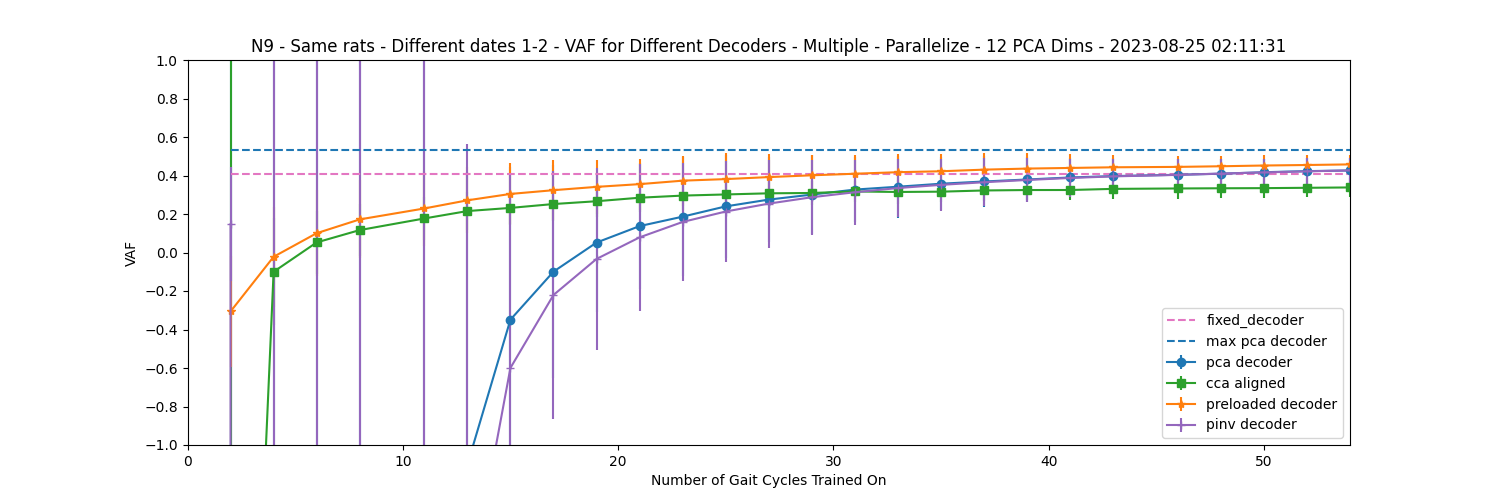

Fri Aug 25 02:24:36 2023    /Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/output-2023-08-25 02:11:31.prof

         331553 function calls (325933 primitive calls) in 784.609 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       74    0.000    0.000    0.000    0.000 {method 'find' of 'bytearray' objects}
        5    0.000    0.000    0.000    0.000 {method 'translate' of 'bytearray' objects}
        2    0.000    0.000    0.000    0.000 {method 'decode' of 'bytes' objects}
        1    0.000    0.000    0.000    0.000 {method 'islower' of 'bytes' objects}
     1843    0.000    0.000    0.000    0.000 {method 'join' of 'bytes' objects}
     1074    0.000    0.000    0.000    0.000 {method 'rstrip' of 'bytes' objects}
       62    0.000    0.000    0.000    0.000 {method 'get' of 'mappingproxy' objects}
      625    0.000    0.000    0.000    0.000 {method 'values' of 'mappingproxy' objects}
       39    0.000  

In [9]:
def main():
    from datetime import datetime

    current_datetime = datetime.now()
    formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")

    data_dict_N9, sorted_keys_N9 = load_data_from_folder(path=path_N9)
    cp1_N9 = data_dict_N9[sorted_keys_N9[0]]
    cp2_N9 = data_dict_N9[sorted_keys_N9[1]]
    cp3_N9 = data_dict_N9[sorted_keys_N9[2]]
    pca_dims = 12

    scores_dict_N9_12 = compare_decoders_all_perms(cp1_N9, cp2_N9,
                                        subsample_list,
                                        step=step,
                                        multiThread=True,
                                        num_processes=1,
                                        pca_dims=pca_dims,
                                        split_ratio=0.8)

    plot_vaf_comparison_multiple(number_of_gaits=scores_dict_N9_12['number_of_gaits'],
                                subsample_list=subsample_list,
                                title_str=f'N9 - Same rats - Different dates 1-2 - VAF for Different Decoders - Multiple - Parallelize - {pca_dims} PCA Dims - {formatted_datetime}',
                                path=saving_path,
                                max_gait=100,
                                fixed_decoder_scores=scores_dict_N9_12['fixed_decoder_scores'],
                                pca_decoder_scores=scores_dict_N9_12['pca_decoder_scores'],
                                cca_decoder_scores=scores_dict_N9_12['cca_decoder_scores'],
                                r_scores=scores_dict_N9_12['r_scores'],
                                pinv_scores=scores_dict_N9_12['pinv_scores'])
    
    import pickle

    with open(f"/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N9_12-{formatted_datetime}.pickle", "wb") as file:
        pickle.dump(scores_dict_N9_12, file)

    file.close()
# if __name__ == '__main__':
#     main()
    
import cProfile
import pstats

from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
profiler = cProfile.Profile()
profiler.enable()
main()
profiler.disable()

profiler.dump_stats(f'/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/output-{formatted_datetime}.prof')

# Optionally, you can print the profiling results to the console
stats = pstats.Stats(f'/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/output-{formatted_datetime}.prof')
stats.print_stats()



##### Same rat N6

In [ ]:

data_dict_N6, sorted_keys_N6 = load_data_from_folder(path=path_N6)
cp1_N6 = data_dict_N6[sorted_keys_N6[0]]
cp2_N6 = data_dict_N6[sorted_keys_N6[1]]
cp3_N6 = data_dict_N6[sorted_keys_N6[2]]
pca_dims = 12

scores_dict_N6_12 = compare_decoders_single_perms(cp1_N6, cp2_N6,
                                    subsample_list,
                                    step=step,
                                    pca_dims=pca_dims,
                                    split_ratio=0.8)

plot_vaf_comparison_single(number_of_gaits=scores_dict_N6_12['number_of_gaits'],
                    title_str=f'N6 - Same rats - Different dates 1-2 - VAF for Different Decoders - Single - {pca_dims} PCA Dims',
                    path=saving_path,
                    max_gait=100,
                    fixed_decoder_scores=scores_dict_N6_12['fixed_decoder_scores'],
                    pca_decoder_scores=scores_dict_N6_12['pca_decoder_scores'],
                    cca_decoder_scores=scores_dict_N6_12['cca_decoder_scores'],
                    r_scores=scores_dict_N6_12['r_scores'],
                    pinv_scores=scores_dict_N6_12['pinv_scores'])
import pickle

with open("/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N6_12.pickle", "wb") as file:
    pickle.dump(scores_dict_N6_12, file)

file.close()

# scores_dict_N6_13 = compare_decoders_single_perms(cp1_N6, cp3_N6,
#                                     subsample_list,
#                                     pca_dims=pca_dims,
#                                     split_ratio=0.8)

# plot_vaf_comparison_single(number_of_gaits=scores_dict_N6_13['number_of_gaits'],
#                     title_str=f'N6 - Same rats - Different dates 1-3 - VAF for Different Decoders - Single - {pca_dims} PCA Dims',
#                     path=saving_path,
#                     max_gait=100,
#                     fixed_decoder_scores=scores_dict_N6_13['fixed_decoder_scores'],
#                     pca_decoder_scores=scores_dict_N6_13['pca_decoder_scores'],
#                     cca_decoder_scores=scores_dict_N6_13['cca_decoder_scores'],
#                     r_scores=scores_dict_N6_13['r_scores'],
#                     pinv_scores=scores_dict_N6_13['pinv_scores'])

In [ ]:
data_dict_N6, sorted_keys_N6 = load_data_from_folder(path=path_N6)
cp1_N6 = data_dict_N6[sorted_keys_N6[0]]
cp2_N6 = data_dict_N6[sorted_keys_N6[1]]
cp3_N6 = data_dict_N6[sorted_keys_N6[2]]
pca_dims = 8

scores_dict_N6_12 = compare_decoders_all_perms(cp1_N6, cp2_N6,
                                    subsample_list,
                                    step=step,
                                    pca_dims=pca_dims,
                                    split_ratio=0.8)

plot_vaf_comparison_multiple(number_of_gaits=scores_dict_N6_12['number_of_gaits'],
                    title_str=f'N6 - Same rats - Different dates 1-2 - VAF for Different Decoders - Multiple - Paralleliza - {pca_dims} PCA Dims',
                    path=saving_path,
                    max_gait=100,
                    fixed_decoder_scores=scores_dict_N6_12['fixed_decoder_scores'],
                    pca_decoder_scores=scores_dict_N6_12['pca_decoder_scores'],
                    cca_decoder_scores=scores_dict_N6_12['cca_decoder_scores'],
                    r_scores=scores_dict_N6_12['r_scores'],
                    pinv_scores=scores_dict_N6_12['pinv_scores'])
import pickle

with open("/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N6_12_PCA8.pickle", "wb") as file:
    pickle.dump(scores_dict_N6_12, file)

file.close()

# scores_dict_N6_13 = compare_decoders_all_perms(cp1_N6, cp3_N6,
#                                     subsample_list,
#                                     pca_dims=pca_dims,
#                                     split_ratio=0.8)

# plot_vaf_comparison_multiple(number_of_gaits=scores_dict_N6_13['number_of_gaits'],
#                     title_str=f'N6 - Same rats - Different dates 1-3 - VAF for Different Decoders - Multiple - {pca_dims} PCA Dims',
#                     path=saving_path,
#                     max_gait=100,
#                     fixed_decoder_scores=scores_dict_N6_13['fixed_decoder_scores'],
#                     pca_decoder_scores=scores_dict_N6_13['pca_decoder_scores'],
#                     cca_decoder_scores=scores_dict_N6_13['cca_decoder_scores'],
#                     r_scores=scores_dict_N6_13['r_scores'],
#                     pinv_scores=scores_dict_N6_13['pinv_scores'])

# with open("/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N6_13.pickle", "wb") as file:
#     pickle.dump(scores_dict_N6_13, file)

# file.close()

##### Same rat N5

In [ ]:
%%capture
data_dict_N5, sorted_keys_N5 = load_data_from_folder(path=path_N5)
cp1_N5 = data_dict_N5[sorted_keys_N5[0]]
cp2_N5 = data_dict_N5[sorted_keys_N5[1]]
cp3_N5 = data_dict_N5[sorted_keys_N5[2]]
pca_dims = 8

scores_dict_N5_12 = compare_decoders_all_perms(cp1_N5, cp2_N5,
                                    subsample_list,
                                    step=step,
                                    pca_dims=pca_dims,
                                    split_ratio=0.8)

plot_vaf_comparison_multiple(number_of_gaits=scores_dict_N5_12['number_of_gaits'],
                    title_str=f'N5 - Same rats - Different dates 1-2 - VAF for Different Decoders - {pca_dims} PCA Dims',
                    path=saving_path,
                    max_gait=100,
                    fixed_decoder_scores=scores_dict_N5_12['fixed_decoder_scores'],
                    pca_decoder_scores=scores_dict_N5_12['pca_decoder_scores'],
                    cca_decoder_scores=scores_dict_N5_12['cca_decoder_scores'],
                    r_scores=scores_dict_N5_12['r_scores'],
                    pinv_scores=scores_dict_N5_12['pinv_scores'])

with open("/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N5_12_PCA8.pickle", "wb") as file:
    pickle.dump(scores_dict_N5_12, file)

file.close()
# scores_dict_N5_13 = compare_decoders_all_perms(cp1_N5, cp3_N5,
#                                     subsample_list,
#                                     pca_dims=pca_dims,
#                                     split_ratio=0.8)

# plot_vaf_comparison_multiple(number_of_gaits=scores_dict_N5_12['number_of_gaits'],
#                     title_str=f'N5 - Same rats - Different dates 1-3 - VAF for Different Decoders - {pca_dims} PCA Dims',
#                     path=saving_path,
#                     max_gait=100,
#                     fixed_decoder_scores=scores_dict_N5_13['fixed_decoder_scores'],
#                     pca_decoder_scores=scores_dict_N5_13['pca_decoder_scores'],
#                     cca_decoder_scores=scores_dict_N5_13['cca_decoder_scores'],
#                     r_scores=scores_dict_N5_13['r_scores'],
#                     pinv_scores=scores_dict_N5_13['pinv_scores'])

##### N5 as source to decode N6 Day-30

In [ ]:
data_dict_N6, sorted_keys_N6 = load_data_from_folder(path=path_N6)
cp1_N6 = data_dict_N6[sorted_keys_N6[0]]
cp2_N6 = data_dict_N6[sorted_keys_N6[1]]
cp3_N6 = data_dict_N6[sorted_keys_N6[2]]
data_dict_N5, sorted_keys_N5 = load_data_from_folder(path=path_N5)
cp1_N5 = data_dict_N5[sorted_keys_N5[0]]
cp2_N5 = data_dict_N5[sorted_keys_N5[1]]
cp3_N5 = data_dict_N5[sorted_keys_N5[2]]

pca_dims = 12

scores_dict_N5_N6 = compare_decoders_all_perms(cp1_N5, cp2_N6,
                                    subsample_list,
                                    step=step,
                                    pca_dims=pca_dims,
                                    split_ratio=0.8)

plot_vaf_comparison_multiple(number_of_gaits=scores_dict_N5_N6['number_of_gaits'],
                    title_str=f'N5 as source for N6 Day-30 - VAF for Different Decoders - Multiple - Parallelize - {pca_dims} PCA Dims',
                    path=saving_path,
                    max_gait=100,
                    pca_decoder_scores=scores_dict_N5_N6['pca_decoder_scores'],
                    cca_decoder_scores=scores_dict_N5_N6['cca_decoder_scores'],
                    r_scores=scores_dict_N5_N6['r_scores'],
                    pinv_scores=scores_dict_N5_N6['pinv_scores'])

import pickle

with open("/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N5_N6_PCA12.pickle", "wb") as file:
    pickle.dump(scores_dict_N5_N6, file)

file.close()

In [ ]:
import pickle

with open("/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N5_N6_PCA8.pickle", "wb") as file:
    pickle.dump(scores_dict_N5_N6, file)

file.close()

plot_vaf_comparison_multiple(number_of_gaits=scores_dict_N5_N6['number_of_gaits'],
                    title_str=f'N5 as source for N6 Day-30 - VAF for Different Decoders - Multiple - Parallelize - {pca_dims} PCA Dims',
                    path=saving_path,
                    max_gait=100,
                    pca_decoder_scores=scores_dict_N5_N6['pca_decoder_scores'],
                    cca_decoder_scores=scores_dict_N5_N6['cca_decoder_scores'],
                    r_scores=scores_dict_N5_N6['r_scores'],
                    pinv_scores=scores_dict_N5_N6['pinv_scores'])

### Scraps

In [ ]:

with open("/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N6_12_PCA8.pickle", 'rb') as inp:
    scores_dict_N6_12 = pickle.load(inp)

with open("/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N5_N6_PCA12.pickle", 'rb') as inp:
    scores_dict_N5_N6_PCA12 = pickle.load(inp)

with open("/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N5_N6_PCA8.pickle", 'rb') as inp:
    scores_dict_N5_N6_PCA8 = pickle.load(inp)   
with open("/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N5_12_PCA8.pickle", 'rb') as inp:
    scores_dict_N5_12_PCA8 = pickle.load(inp)  

plot_vaf_comparison_multiple(number_of_gaits=scores_dict_N6_12['number_of_gaits'],
                    title_str=f'N5 as source for N6 Day-30 - Different dates 1-2 - VAF for Different Decoders - Multiple - Paralleliza - Mixed PCA Dims 8-12',
                    path=saving_path,
                    max_gait=100,
                    fixed_decoder_scores=scores_dict_N6_12['fixed_decoder_scores'],
                    pca_decoder_scores=scores_dict_N5_N6_PCA8['pca_decoder_scores'],
                    cca_decoder_scores=scores_dict_N5_N6_PCA12['cca_decoder_scores'],
                    r_scores=scores_dict_N5_N6_PCA8['r_scores'])


In [ ]:
pca_dims = 8
plot_vaf_comparison_multiple(number_of_gaits=scores_dict_N6_12['number_of_gaits'],
                    title_str=f'N6 - Same rats - Different dates 1-2 - VAF for Different Decoders - Multiple - Paralleliza - {pca_dims} PCA Dims',
                    path=saving_path,
                    max_gait=100,
                    fixed_decoder_scores=scores_dict_N6_12['fixed_decoder_scores'],
                    pca_decoder_scores=scores_dict_N6_12['pca_decoder_scores'],
                    cca_decoder_scores=scores_dict_N6_12['cca_decoder_scores'],
                    r_scores=scores_dict_N6_12['r_scores'])

In [ ]:
with open("/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N9_12-2023-06-04 15:57:22.pickle", "wb") as file:
    pickle.dump(scores_dict_N9_12, file)
plot_vaf_comparison_multiple(number_of_gaits=scores_dict_N9_12['number_of_gaits'],
                    title_str=f'N9 - Same rats - Different dates 1-2 - VAF for Different Decoders - Multiple - Parallelize - {pca_dims} PCA Dims',
                    path=saving_path,
                    max_gait=100,
                    fixed_decoder_scores=scores_dict_N9_12['fixed_decoder_scores'],
                    pca_decoder_scores=scores_dict_N9_12['pca_decoder_scores'],
                    cca_decoder_scores=scores_dict_N9_12['cca_decoder_scores'],
                    r_scores=scores_dict_N9_12['r_scores'])




In [ ]:
def split_range_into_groups(list_of_numbers, num_groups, step=1):
    groups = {}
    groups_index ={}

    for i in np.arange(0, num_groups, 1):
        groups[i], groups_index[i] = [], []
        currentIndex = i+1
        startIndex = 1
        # Populate the current group
        while currentIndex <= len(list_of_numbers):
            groups[i].append(list_of_numbers[currentIndex-1])
            groups_index[i].append(currentIndex-1)
            currentIndex = i+1 + num_groups*startIndex
            startIndex+=1

    return groups, groups_index

# Example usage
start_num = 1
end_num = 45
num_of_groups = 9
list_of_numbers = np.arange(start_num, end_num, 1)
groups, groups_index = split_range_into_groups(list_of_numbers, num_of_groups)
len(result)


In [ ]:
groups_index[0][1]
a = {}
a[0] = []
a[0].append(1)
a

In [ ]:
dict1 = {'a': 1, 'b': 2, 'c': 3}
dict2 = {'x': 10, 'y': 20, 'z': 30}

dict2 = {**dict1, **dict2}
print(dict1)
print(dict2)

for index_group in range(9):
    print(index_group)


In [ ]:
with open("/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/scores_dict_N9_12-2023-06-04 18:39:50.pickle", 'rb') as inp:
    scores_dict_N9_12 = pickle.load(inp)
pca_dims = 12
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")

plot_vaf_comparison_multiple(number_of_gaits=scores_dict_N9_12['number_of_gaits'],
                        title_str=f'N9 - Same rats - Different dates 1-2 - VAF for Different Decoders - Multiple - Parallelize - {pca_dims} PCA Dims - {formatted_datetime}',
                        path=saving_path,
                        max_gait=60,
                        min_gait=0,
                        fixed_decoder_scores=scores_dict_N9_12['fixed_decoder_scores'],
                        pca_decoder_scores=scores_dict_N9_12['pca_decoder_scores'],
                        cca_decoder_scores=scores_dict_N9_12['cca_decoder_scores'],
                        r_scores=scores_dict_N9_12['r_scores'])

Raw data importing test

In [ ]:
rollie_1209 = CortProcessor('/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/rollie/1209')

In [ ]:
x = rollie_1209.tdt_data[0]['neural']
print(rollie_1209.tdt_data[0]['fs'])

In [ ]:
x.shape

In [ ]:
fig, ax = plt.subplots()
ax.plot(x[:,0])

In [ ]:
rollie = load_data_from_folder(path='/Users/sam/Dropbox/Tresch Lab/CCA stuffs/rat-fes-data/rollie', raw_data=True)

In [ ]:
# Get the size of the object
size = sys.getsizeof(rollie)

# Display the size
print("Size of the object:", size, "bytes")
